In [31]:
import cv2
from tqdm import tqdm_notebook as tqdm
import zipfile
import io
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [32]:
HEIGHT = 137
WIDTH = 236
SIZE = 224

DATA_PATH = Path('/Users/lextoumbourou/code/bengaliai-cv19')

TRAIN = [DATA_PATH/'data/train_image_data_0.parquet',
         DATA_PATH/'data/train_image_data_1.parquet',
         DATA_PATH/'data/train_image_data_2.parquet',
         DATA_PATH/'data/train_image_data_3.parquet']

OUT_TRAIN = 'train.zip'

In [52]:
def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_resize(img0, size=SIZE, pad=16):
    #crop a box around pixels large than the threshold 
    #some images contain line at the sides
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > 80)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < 28] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    import pdb; pdb.set_trace()
    return img #cv2.resize(img,(size,size))

In [34]:
%%time

df = pd.read_parquet(TRAIN[0])

KeyboardInterrupt: 

In [53]:
img0 = df.iloc[0, 1:].values.reshape(HEIGHT, WIDTH).astype(np.uint8)

In [54]:
img0.shape

(137, 236)

In [55]:
img0[0]

array([254, 253, 252, 253, 251, 252, 253, 251, 251, 253, 254, 253, 253,
       253, 254, 253, 252, 253, 253, 253, 253, 252, 252, 253, 253, 252,
       252, 253, 252, 252, 252, 253, 254, 253, 253, 252, 252, 252, 253,
       252, 251, 252, 252, 251, 252, 251, 251, 251, 251, 252, 252, 252,
       252, 251, 252, 252, 252, 253, 252, 251, 253, 253, 252, 252, 253,
       253, 252, 251, 250, 249, 251, 252, 252, 251, 252, 252, 253, 253,
       252, 252, 251, 253, 252, 251, 251, 252, 253, 253, 251, 249, 251,
       253, 252, 253, 253, 252, 252, 251, 250, 250, 251, 253, 254, 254,
       253, 252, 251, 252, 254, 253, 252, 253, 253, 254, 253, 253, 255,
       255, 254, 252, 251, 251, 250, 252, 251, 250, 252, 250, 249, 252,
       249, 247, 249, 245, 240, 232, 208, 165, 125, 103,  94,  76,  58,
        56,  59,  64,  73,  78,  96, 127, 157, 180, 203, 220, 230, 240,
       245, 247, 247, 250, 251, 252, 252, 252, 252, 252, 253, 252, 251,
       252, 252, 252, 253, 253, 252, 253, 253, 253, 253, 254, 25

In [56]:
255 - img0[0]

array([  1,   2,   3,   2,   4,   3,   2,   4,   4,   2,   1,   2,   2,
         2,   1,   2,   3,   2,   2,   2,   2,   3,   3,   2,   2,   3,
         3,   2,   3,   3,   3,   2,   1,   2,   2,   3,   3,   3,   2,
         3,   4,   3,   3,   4,   3,   4,   4,   4,   4,   3,   3,   3,
         3,   4,   3,   3,   3,   2,   3,   4,   2,   2,   3,   3,   2,
         2,   3,   4,   5,   6,   4,   3,   3,   4,   3,   3,   2,   2,
         3,   3,   4,   2,   3,   4,   4,   3,   2,   2,   4,   6,   4,
         2,   3,   2,   2,   3,   3,   4,   5,   5,   4,   2,   1,   1,
         2,   3,   4,   3,   1,   2,   3,   2,   2,   1,   2,   2,   0,
         0,   1,   3,   4,   4,   5,   3,   4,   5,   3,   5,   6,   3,
         6,   8,   6,  10,  15,  23,  47,  90, 130, 152, 161, 179, 197,
       199, 196, 191, 182, 177, 159, 128,  98,  75,  52,  35,  25,  15,
        10,   8,   8,   5,   4,   3,   3,   3,   3,   3,   2,   3,   4,
         3,   3,   3,   2,   2,   3,   2,   2,   2,   2,   1,   

In [57]:
img0.max()

255

In [58]:
img0 = 255 - img0[0]
img_norm = (img0*(255.0/img0.max())).astype(np.uint8)

In [59]:
img_norm

array([  1,   2,   3,   2,   5,   3,   2,   5,   5,   2,   1,   2,   2,
         2,   1,   2,   3,   2,   2,   2,   2,   3,   3,   2,   2,   3,
         3,   2,   3,   3,   3,   2,   1,   2,   2,   3,   3,   3,   2,
         3,   5,   3,   3,   5,   3,   5,   5,   5,   5,   3,   3,   3,
         3,   5,   3,   3,   3,   2,   3,   5,   2,   2,   3,   3,   2,
         2,   3,   5,   6,   7,   5,   3,   3,   5,   3,   3,   2,   2,
         3,   3,   5,   2,   3,   5,   5,   3,   2,   2,   5,   7,   5,
         2,   3,   2,   2,   3,   3,   5,   6,   6,   5,   2,   1,   1,
         2,   3,   5,   3,   1,   2,   3,   2,   2,   1,   2,   2,   0,
         0,   1,   3,   5,   5,   6,   3,   5,   6,   3,   6,   7,   3,
         7,  10,   7,  12,  19,  29,  60, 115, 166, 194, 206, 229, 252,
       255, 251, 244, 233, 226, 203, 164, 125,  96,  66,  44,  32,  19,
        12,  10,  10,   6,   5,   3,   3,   3,   3,   3,   2,   3,   5,
         3,   3,   3,   2,   2,   3,   2,   2,   2,   2,   1,   

In [105]:
def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax


def crop_resize(img0, size=SIZE, pad=16):
    #crop a box around pixels large than the threshold 
    #some images contain line at the sides
    ymin, ymax, xmin, xmax = bbox(img0[5:-5, 5:-5] > 80)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax, xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < 28] = 0
    lx, ly = xmax-xmin, ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    print(img.shape)
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    print(img.shape)
    return img

(110, 99)
(126, 125)
(92, 160)
(176, 176)
(113, 118)
(133, 134)
(99, 110)
(125, 126)
(99, 141)
(157, 157)
(111, 157)
(173, 173)
(105, 138)
(153, 154)
(105, 86)
(121, 120)



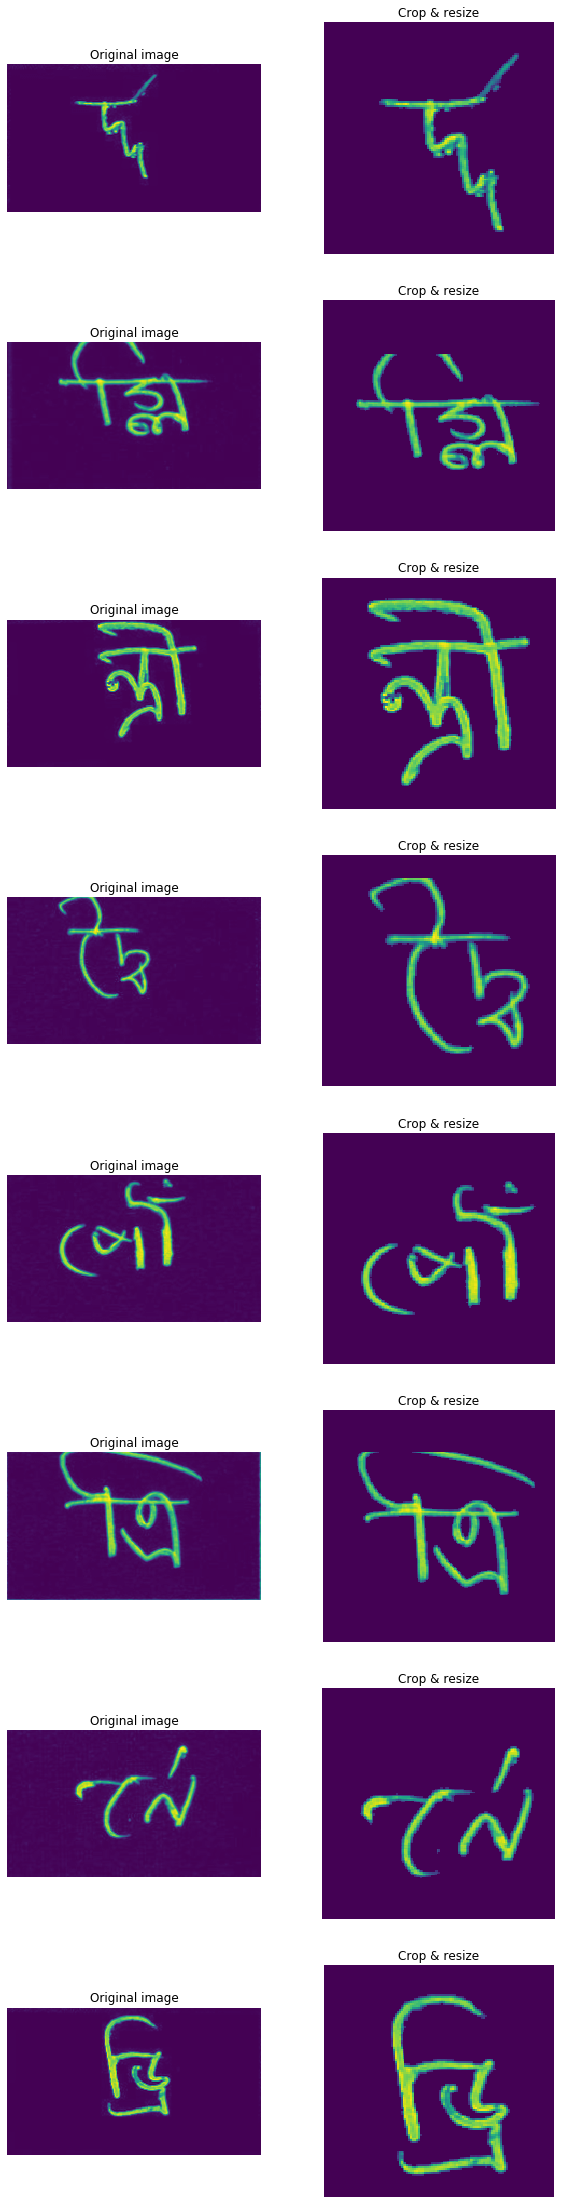

In [106]:
n_imgs = 8
fig, axs = plt.subplots(n_imgs, 2, figsize=(10, 5*n_imgs))

for idx in tqdm(range(n_imgs)):
    #somehow the original input is inverted
    img0 = 255 - df.iloc[idx, 1:].values.reshape(HEIGHT, WIDTH).astype(np.uint8)
    #normalize each image by its max val
    img = (img0*(255.0/img0.max())).astype(np.uint8)
    img = crop_resize(img)

    axs[idx,0].imshow(img0)
    axs[idx,0].set_title('Original image')
    axs[idx,0].axis('off')
    axs[idx,1].imshow(img)
    axs[idx,1].set_title('Crop & resize')
    axs[idx,1].axis('off')
plt.show()

In [107]:
x_tot,x2_tot = [],[]
with zipfile.ZipFile(OUT_TRAIN, 'w') as img_out:
    for fname in tqdm(TRAIN):
        df = pd.read_parquet(fname)
        #the input is inverted
        data = 255 - df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH).astype(np.uint8)
        for idx in tqdm(range(len(df))):
            name = df.iloc[idx,0]
            #normalize each image by its max val
            img = (data[idx]*(255.0/data[idx].max())).astype(np.uint8)
            img = crop_resize(img)
        
            x_tot.append((img/255.0).mean())
            x2_tot.append(((img/255.0)**2).mean()) 
            img = cv2.imencode('.png',img)[1]
            img_out.writestr(name + '.png', img)

(121, 185)
(201, 201)
(92, 152)
(168, 168)
(103, 92)
(119, 118)
(86, 112)
(128, 128)
(106, 116)
(132, 132)
(108, 155)
(170, 171)
(105, 114)
(129, 130)
(93, 82)
(109, 108)
(104, 180)
(196, 196)
(118, 113)
(134, 133)
(104, 176)
(192, 192)
(121, 136)
(151, 152)
(113, 99)
(129, 129)
(71, 123)
(139, 139)
(88, 166)
(182, 182)
(106, 141)
(156, 157)
(91, 163)
(179, 179)
(116, 128)
(144, 144)
(88, 123)
(138, 139)
(120, 207)
(222, 223)
(91, 85)
(107, 107)
(117, 109)
(133, 133)
(107, 154)
(169, 170)
(94, 99)
(114, 115)
(82, 110)
(126, 126)
(97, 135)
(151, 151)
(99, 162)
(177, 178)
(124, 107)
(140, 139)
(133, 128)
(149, 148)
(58, 86)
(102, 102)
(67, 104)
(119, 120)
(104, 115)
(130, 131)
(98, 165)
(180, 181)
(84, 142)
(158, 158)
(108, 137)
(152, 153)
(97, 128)
(143, 144)
(88, 138)
(154, 154)
(92, 133)
(148, 149)
(113, 122)
(137, 138)
(86, 124)
(140, 140)
(95, 168)
(183, 184)
(101, 124)
(139, 140)
(104, 159)
(174, 175)
(85, 128)
(143, 144)
(117, 111)
(133, 133)
(103, 153)
(169, 169)
(101, 139)
(155,

(86, 174)
(190, 190)
(94, 109)
(124, 125)
(100, 120)
(136, 136)
(71, 87)
(103, 103)
(121, 94)
(137, 136)
(78, 114)
(130, 130)
(119, 130)
(145, 146)
(99, 156)
(171, 172)
(120, 151)
(166, 167)
(95, 106)
(121, 122)
(91, 90)
(107, 106)
(92, 129)
(144, 145)
(111, 94)
(127, 126)
(86, 118)
(134, 134)
(88, 116)
(132, 132)
(108, 159)
(174, 175)
(106, 125)
(140, 141)
(83, 128)
(143, 144)
(87, 82)
(103, 102)
(130, 155)
(170, 171)
(77, 109)
(125, 125)
(78, 118)
(134, 134)
(79, 119)
(135, 135)
(116, 159)
(174, 175)
(109, 96)
(125, 124)
(84, 158)
(174, 174)
(104, 194)
(210, 210)
(109, 88)
(125, 124)
(92, 148)
(164, 164)
(126, 219)
(234, 235)
(96, 111)
(126, 127)
(90, 115)
(130, 131)
(84, 80)
(100, 100)
(93, 187)
(203, 203)
(104, 116)
(132, 132)
(94, 146)
(162, 162)
(79, 115)
(131, 131)
(73, 96)
(111, 112)
(102, 147)
(162, 163)
(106, 165)
(180, 181)
(115, 89)
(131, 131)
(107, 151)
(167, 167)
(101, 140)
(155, 156)
(90, 117)
(132, 133)
(123, 139)
(155, 155)
(109, 155)
(171, 171)
(71, 147)
(163, 163)
(9

(123, 133)
(149, 149)
(123, 138)
(153, 154)
(82, 148)
(164, 164)
(76, 159)
(174, 175)
(94, 132)
(148, 148)
(133, 133)
(149, 149)
(95, 131)
(147, 147)
(109, 104)
(125, 124)
(99, 108)
(123, 124)
(114, 115)
(130, 131)
(113, 135)
(151, 151)
(98, 155)
(170, 171)
(124, 147)
(162, 163)
(109, 64)
(125, 124)
(97, 123)
(139, 139)
(68, 133)
(148, 149)
(83, 116)
(131, 132)
(105, 171)
(187, 187)
(95, 164)
(179, 180)
(79, 107)
(123, 123)
(80, 105)
(120, 121)
(103, 144)
(159, 160)
(109, 99)
(125, 125)
(94, 116)
(132, 132)
(67, 148)
(163, 164)
(97, 141)
(157, 157)
(79, 104)
(119, 120)
(97, 139)
(155, 155)
(80, 106)
(122, 122)
(76, 114)
(130, 130)
(75, 111)
(127, 127)
(67, 90)
(105, 106)
(89, 159)
(175, 175)
(96, 120)
(136, 136)
(117, 151)
(167, 167)
(73, 111)
(127, 127)
(121, 170)
(185, 186)
(71, 112)
(127, 128)
(91, 98)
(113, 114)
(102, 121)
(136, 137)
(106, 129)
(144, 145)
(109, 104)
(125, 124)
(119, 204)
(219, 220)
(99, 73)
(115, 115)
(90, 150)
(166, 166)
(92, 97)
(112, 113)
(108, 124)
(140, 140)
(

(100, 183)
(198, 199)
(127, 111)
(143, 143)
(130, 123)
(146, 145)
(136, 112)
(152, 152)
(111, 121)
(137, 137)
(91, 111)
(127, 127)
(85, 142)
(157, 158)
(95, 145)
(161, 161)
(112, 137)
(152, 153)
(76, 140)
(156, 156)
(101, 99)
(117, 117)
(90, 129)
(144, 145)
(81, 110)
(125, 126)
(111, 125)
(141, 141)
(83, 92)
(107, 108)
(84, 114)
(130, 130)
(109, 113)
(129, 129)
(108, 153)
(168, 169)
(113, 112)
(129, 128)
(121, 102)
(137, 136)
(89, 129)
(145, 145)
(64, 113)
(128, 129)
(117, 98)
(133, 132)
(80, 192)
(208, 208)
(113, 152)
(167, 168)
(126, 112)
(142, 142)
(128, 117)
(144, 143)
(69, 105)
(121, 121)
(81, 155)
(171, 171)
(98, 155)
(170, 171)
(105, 128)
(143, 144)
(90, 99)
(114, 115)
(136, 197)
(212, 213)
(97, 89)
(113, 113)
(73, 98)
(113, 114)
(90, 93)
(108, 109)
(95, 95)
(111, 111)
(89, 194)
(209, 210)
(98, 185)
(200, 201)
(95, 179)
(195, 195)
(101, 72)
(117, 116)
(118, 156)
(172, 172)
(84, 150)
(166, 166)
(109, 135)
(151, 151)
(89, 178)
(193, 194)
(130, 95)
(146, 145)
(74, 115)
(130, 131)
(

(100, 112)
(128, 128)
(76, 110)
(126, 126)
(108, 134)
(150, 150)
(109, 132)
(147, 148)
(86, 89)
(104, 105)
(83, 121)
(137, 137)
(106, 160)
(176, 176)
(102, 163)
(178, 179)
(129, 99)
(145, 145)
(95, 167)
(183, 183)
(112, 125)
(140, 141)
(126, 143)
(158, 159)
(113, 134)
(149, 150)
(91, 100)
(115, 116)
(111, 146)
(161, 162)
(96, 119)
(134, 135)
(134, 118)
(150, 150)
(80, 125)
(140, 141)
(93, 155)
(171, 171)
(88, 122)
(138, 138)
(97, 104)
(119, 120)
(97, 145)
(161, 161)
(78, 78)
(94, 94)
(100, 132)
(148, 148)
(80, 120)
(136, 136)
(125, 167)
(183, 183)
(89, 117)
(133, 133)
(102, 131)
(146, 147)
(88, 107)
(122, 123)
(129, 177)
(193, 193)
(87, 116)
(131, 132)
(91, 127)
(143, 143)
(111, 151)
(167, 167)
(136, 113)
(152, 151)
(118, 156)
(172, 172)
(106, 118)
(134, 134)
(89, 98)
(113, 114)
(130, 128)
(146, 146)
(90, 148)
(164, 164)
(84, 187)
(202, 203)
(102, 119)
(134, 135)
(82, 94)
(110, 110)
(92, 192)
(208, 208)
(87, 132)
(147, 148)
(114, 104)
(130, 130)
(69, 114)
(129, 130)
(116, 133)
(148, 14

(103, 120)
(135, 136)
(136, 139)
(154, 155)
(125, 166)
(181, 182)
(97, 127)
(143, 143)
(104, 118)
(134, 134)
(87, 89)
(105, 105)
(107, 106)
(123, 122)
(135, 148)
(163, 164)
(111, 96)
(127, 126)
(123, 110)
(139, 138)
(87, 101)
(117, 117)
(125, 147)
(163, 163)
(72, 131)
(146, 147)
(121, 104)
(137, 136)
(99, 97)
(115, 115)
(94, 197)
(212, 213)
(87, 157)
(173, 173)
(66, 85)
(100, 101)
(117, 106)
(133, 132)
(114, 88)
(130, 130)
(82, 192)
(208, 208)
(101, 236)
(251, 252)
(84, 118)
(134, 134)
(103, 150)
(165, 166)
(100, 111)
(126, 127)
(116, 127)
(142, 143)
(99, 101)
(117, 117)
(114, 145)
(160, 161)
(119, 116)
(135, 134)
(104, 146)
(162, 162)
(106, 182)
(198, 198)
(83, 111)
(127, 127)
(83, 174)
(189, 190)
(81, 130)
(145, 146)
(109, 117)
(133, 133)
(128, 91)
(144, 143)
(108, 159)
(174, 175)
(73, 129)
(145, 145)
(72, 115)
(130, 131)
(96, 165)
(180, 181)
(128, 119)
(144, 143)
(91, 181)
(197, 197)
(129, 154)
(169, 170)
(71, 110)
(125, 126)
(128, 179)
(194, 195)
(61, 127)
(143, 143)
(95, 147)
(163

(122, 119)
(138, 137)
(102, 118)
(134, 134)
(94, 134)
(150, 150)
(74, 128)
(144, 144)
(97, 95)
(113, 113)
(64, 150)
(166, 166)
(115, 193)
(209, 209)
(117, 138)
(153, 154)
(95, 178)
(193, 194)
(114, 153)
(168, 169)
(71, 113)
(129, 129)
(117, 99)
(133, 133)
(102, 110)
(126, 126)
(116, 151)
(166, 167)
(89, 129)
(145, 145)
(87, 143)
(159, 159)
(84, 123)
(138, 139)
(106, 110)
(126, 126)
(88, 95)
(110, 111)
(79, 118)
(133, 134)
(105, 150)
(165, 166)
(83, 137)
(153, 153)
(65, 91)
(107, 107)
(99, 122)
(137, 138)
(77, 107)
(123, 123)
(97, 152)
(167, 168)
(123, 191)
(207, 207)
(108, 130)
(146, 146)
(107, 130)
(145, 146)
(103, 100)
(119, 118)
(104, 106)
(122, 122)
(121, 170)
(185, 186)
(122, 162)
(178, 178)
(119, 110)
(135, 134)
(99, 101)
(117, 117)
(90, 111)
(126, 127)
(110, 156)
(172, 172)
(103, 127)
(143, 143)
(104, 117)
(132, 133)
(109, 109)
(125, 125)
(128, 131)
(146, 147)
(136, 117)
(152, 151)
(93, 179)
(195, 195)
(82, 96)
(112, 112)
(104, 163)
(178, 179)
(114, 110)
(130, 130)
(125, 138)
(1

(136, 117)
(152, 151)
(68, 89)
(104, 105)
(95, 81)
(111, 111)
(134, 135)
(150, 151)
(100, 101)
(116, 117)
(87, 135)
(151, 151)
(94, 150)
(166, 166)
(112, 153)
(168, 169)
(87, 127)
(143, 143)
(92, 151)
(166, 167)
(129, 152)
(167, 168)
(122, 150)
(166, 166)
(98, 94)
(114, 114)
(107, 148)
(163, 164)
(114, 149)
(164, 165)
(98, 138)
(154, 154)
(117, 153)
(169, 169)
(85, 116)
(131, 132)
(82, 186)
(202, 202)
(136, 126)
(152, 152)
(120, 113)
(136, 135)
(117, 198)
(213, 214)
(111, 105)
(127, 127)
(114, 181)
(196, 197)
(90, 114)
(130, 130)
(91, 145)
(161, 161)
(107, 205)
(221, 221)
(122, 154)
(170, 170)
(80, 112)
(128, 128)
(95, 107)
(123, 123)
(71, 119)
(135, 135)
(85, 153)
(169, 169)
(109, 191)
(207, 207)
(98, 137)
(152, 153)
(83, 117)
(133, 133)
(131, 154)
(169, 170)
(126, 83)
(142, 141)
(97, 126)
(141, 142)
(73, 120)
(135, 136)
(85, 140)
(155, 156)
(115, 114)
(131, 130)
(111, 127)
(143, 143)
(89, 184)
(199, 200)
(111, 154)
(169, 170)
(75, 86)
(101, 102)
(127, 193)
(209, 209)
(132, 137)
(152,

(114, 162)
(178, 178)
(77, 122)
(137, 138)
(104, 135)
(150, 151)
(115, 184)
(199, 200)
(66, 138)
(154, 154)
(119, 117)
(135, 135)
(103, 104)
(119, 120)
(76, 128)
(144, 144)
(114, 150)
(166, 166)
(134, 163)
(178, 179)
(106, 148)
(164, 164)
(93, 127)
(143, 143)
(129, 115)
(145, 145)
(103, 120)
(135, 136)
(82, 106)
(122, 122)
(85, 109)
(125, 125)
(76, 116)
(132, 132)
(112, 167)
(182, 183)
(81, 103)
(119, 119)
(84, 99)
(114, 115)
(87, 117)
(133, 133)
(97, 179)
(195, 195)
(83, 104)
(119, 120)
(116, 154)
(170, 170)
(96, 140)
(156, 156)
(85, 75)
(101, 101)
(64, 142)
(158, 158)
(97, 126)
(141, 142)
(98, 109)
(124, 125)
(136, 153)
(168, 169)
(88, 88)
(104, 104)
(86, 136)
(152, 152)
(105, 130)
(145, 146)
(89, 178)
(193, 194)
(136, 155)
(170, 171)
(94, 134)
(150, 150)
(103, 121)
(137, 137)
(132, 182)
(198, 198)
(94, 102)
(118, 118)
(96, 99)
(114, 115)
(84, 125)
(140, 141)
(109, 185)
(201, 201)
(119, 145)
(161, 161)
(97, 172)
(187, 188)
(95, 133)
(149, 149)
(87, 119)
(135, 135)
(96, 98)
(114, 114)

(68, 112)
(128, 128)
(80, 117)
(132, 133)
(90, 153)
(168, 169)
(84, 97)
(112, 113)
(89, 105)
(121, 121)
(111, 117)
(133, 133)
(99, 116)
(131, 132)
(84, 115)
(130, 131)
(93, 106)
(121, 122)
(108, 160)
(176, 176)
(93, 206)
(221, 222)
(92, 119)
(134, 135)
(68, 165)
(180, 181)
(129, 158)
(173, 174)
(88, 128)
(144, 144)
(82, 151)
(166, 167)
(121, 127)
(143, 143)
(87, 93)
(109, 109)
(102, 102)
(118, 118)
(85, 176)
(191, 192)
(102, 162)
(178, 178)
(89, 125)
(141, 141)
(107, 114)
(129, 130)
(123, 169)
(185, 185)
(89, 134)
(149, 150)
(98, 118)
(134, 134)
(108, 135)
(150, 151)
(87, 86)
(103, 102)
(126, 132)
(148, 148)
(105, 118)
(133, 134)
(102, 100)
(118, 118)
(77, 169)
(185, 185)
(73, 100)
(115, 116)
(95, 107)
(123, 123)
(93, 89)
(109, 109)
(109, 218)
(233, 234)
(107, 165)
(181, 181)
(82, 129)
(144, 145)
(87, 147)
(163, 163)
(89, 120)
(135, 136)
(97, 162)
(177, 178)
(89, 116)
(131, 132)
(116, 102)
(132, 132)
(96, 163)
(178, 179)
(91, 132)
(147, 148)
(90, 156)
(172, 172)
(88, 125)
(140, 141)
(8

(106, 116)
(132, 132)
(99, 136)
(151, 152)
(136, 110)
(152, 152)
(109, 132)
(147, 148)
(77, 181)
(197, 197)
(98, 102)
(118, 118)
(76, 79)
(94, 95)
(124, 160)
(176, 176)
(99, 105)
(121, 121)
(75, 173)
(189, 189)
(72, 151)
(166, 167)
(123, 122)
(139, 138)
(108, 156)
(172, 172)
(107, 112)
(127, 128)
(107, 176)
(191, 192)
(111, 106)
(127, 126)
(89, 177)
(193, 193)
(111, 152)
(167, 168)
(70, 142)
(158, 158)
(81, 161)
(177, 177)
(98, 141)
(156, 157)
(83, 138)
(153, 154)
(115, 189)
(205, 205)
(133, 158)
(173, 174)
(95, 153)
(169, 169)
(105, 208)
(223, 224)
(91, 117)
(133, 133)
(75, 97)
(113, 113)
(90, 156)
(172, 172)
(120, 161)
(176, 177)
(58, 121)
(136, 137)
(108, 102)
(124, 124)
(81, 149)
(165, 165)
(87, 117)
(133, 133)
(104, 147)
(162, 163)
(96, 143)
(158, 159)
(72, 112)
(128, 128)
(72, 113)
(128, 129)
(133, 228)
(243, 244)
(88, 148)
(164, 164)
(87, 132)
(147, 148)
(110, 173)
(188, 189)
(136, 123)
(152, 151)
(75, 128)
(143, 144)
(100, 92)
(116, 116)
(100, 118)
(134, 134)
(114, 165)
(180, 1

(84, 135)
(150, 151)
(70, 140)
(156, 156)
(92, 143)
(158, 159)
(126, 109)
(142, 141)
(107, 95)
(123, 123)
(77, 183)
(199, 199)
(63, 140)
(155, 156)
(128, 111)
(144, 143)
(81, 123)
(139, 139)
(120, 164)
(180, 180)
(87, 104)
(119, 120)
(136, 188)
(204, 204)
(95, 168)
(183, 184)
(105, 197)
(213, 213)
(106, 182)
(198, 198)
(113, 110)
(129, 128)
(108, 116)
(132, 132)
(70, 100)
(116, 116)
(101, 138)
(153, 154)
(98, 94)
(114, 114)
(95, 75)
(111, 111)
(99, 183)
(199, 199)
(84, 146)
(162, 162)
(100, 159)
(174, 175)
(71, 131)
(147, 147)
(104, 129)
(144, 145)
(84, 97)
(112, 113)
(83, 135)
(151, 151)
(99, 154)
(169, 170)
(73, 101)
(117, 117)
(76, 69)
(92, 91)
(123, 221)
(237, 237)
(99, 88)
(115, 114)
(71, 122)
(137, 138)
(77, 123)
(139, 139)
(112, 105)
(128, 127)
(112, 106)
(128, 128)
(83, 128)
(143, 144)
(88, 129)
(144, 145)
(80, 99)
(114, 115)
(75, 113)
(129, 129)
(84, 117)
(132, 133)
(101, 84)
(117, 116)
(119, 134)
(149, 150)
(136, 133)
(152, 151)
(116, 129)
(144, 145)
(93, 117)
(133, 133)
(104

(108, 158)
(174, 174)
(96, 144)
(160, 160)
(68, 81)
(96, 97)
(105, 99)
(121, 121)
(97, 127)
(143, 143)
(116, 145)
(160, 161)
(106, 134)
(150, 150)
(77, 99)
(115, 115)
(93, 103)
(119, 119)
(73, 127)
(143, 143)
(113, 107)
(129, 129)
(74, 95)
(110, 111)
(113, 110)
(129, 128)
(72, 93)
(108, 109)
(73, 161)
(177, 177)
(110, 124)
(140, 140)
(80, 122)
(138, 138)
(93, 190)
(205, 206)
(94, 135)
(150, 151)
(119, 125)
(141, 141)
(113, 125)
(141, 141)
(97, 95)
(113, 113)
(74, 130)
(146, 146)
(76, 114)
(130, 130)
(83, 123)
(139, 139)
(95, 139)
(155, 155)
(68, 126)
(142, 142)
(120, 108)
(136, 136)
(109, 146)
(161, 162)
(108, 143)
(158, 159)
(109, 133)
(149, 149)
(100, 107)
(122, 123)
(110, 126)
(142, 142)
(104, 102)
(120, 120)
(80, 119)
(134, 135)
(93, 111)
(127, 127)
(106, 167)
(182, 183)
(79, 103)
(119, 119)
(84, 97)
(112, 113)
(94, 107)
(122, 123)
(110, 99)
(126, 125)
(106, 124)
(140, 140)
(103, 126)
(141, 142)
(116, 139)
(154, 155)
(98, 102)
(118, 118)
(87, 90)
(105, 106)
(95, 119)
(135, 135)
(72

(97, 149)
(165, 165)
(97, 195)
(211, 211)
(95, 109)
(125, 125)
(92, 150)
(166, 166)
(110, 176)
(192, 192)
(116, 100)
(132, 132)
(82, 166)
(182, 182)
(73, 103)
(119, 119)
(70, 168)
(184, 184)
(89, 158)
(173, 174)
(78, 150)
(166, 166)
(132, 112)
(148, 148)
(94, 107)
(122, 123)
(103, 155)
(171, 171)
(92, 112)
(128, 128)
(80, 105)
(120, 121)
(92, 126)
(142, 142)
(93, 137)
(153, 153)
(104, 92)
(120, 120)
(97, 124)
(139, 140)
(128, 132)
(148, 148)
(85, 95)
(111, 111)
(91, 131)
(147, 147)
(111, 125)
(141, 141)
(133, 142)
(157, 158)
(109, 158)
(173, 174)
(115, 151)
(167, 167)
(92, 100)
(116, 116)
(121, 148)
(163, 164)
(105, 112)
(127, 128)
(123, 138)
(153, 154)
(108, 155)
(170, 171)
(136, 115)
(152, 151)
(94, 102)
(118, 118)
(97, 157)
(173, 173)
(89, 139)
(155, 155)
(90, 103)
(118, 119)
(130, 211)
(226, 227)
(92, 92)
(108, 108)
(106, 118)
(134, 134)
(105, 102)
(121, 120)
(112, 147)
(162, 163)
(104, 116)
(132, 132)
(118, 118)
(134, 134)
(120, 102)
(136, 136)
(101, 148)
(163, 164)
(108, 125)
(14

(107, 121)
(137, 137)
(90, 112)
(128, 128)
(80, 128)
(144, 144)
(82, 123)
(138, 139)
(84, 176)
(192, 192)
(104, 114)
(130, 130)
(79, 77)
(95, 95)
(112, 114)
(130, 130)
(136, 182)
(198, 198)
(93, 149)
(165, 165)
(132, 154)
(170, 170)
(83, 135)
(151, 151)
(121, 132)
(147, 148)
(121, 148)
(163, 164)
(79, 132)
(147, 148)
(64, 122)
(138, 138)
(97, 201)
(217, 217)
(118, 91)
(134, 133)
(69, 132)
(147, 148)
(73, 143)
(159, 159)
(89, 135)
(151, 151)
(112, 154)
(170, 170)
(89, 105)
(121, 121)
(100, 147)
(162, 163)
(109, 108)
(125, 124)
(104, 190)
(206, 206)
(95, 147)
(163, 163)
(75, 62)
(91, 90)
(89, 108)
(123, 124)
(109, 144)
(159, 160)
(101, 159)
(175, 175)
(75, 97)
(113, 113)
(115, 135)
(151, 151)
(106, 119)
(134, 135)
(80, 123)
(138, 139)
(97, 117)
(133, 133)
(96, 121)
(136, 137)
(91, 98)
(113, 114)
(123, 126)
(141, 142)
(97, 235)
(251, 251)
(89, 109)
(125, 125)
(124, 97)
(140, 139)
(88, 138)
(154, 154)
(133, 116)
(149, 148)
(119, 203)
(219, 219)
(105, 99)
(121, 121)
(63, 96)
(111, 112)
(70,

(129, 194)
(209, 210)
(78, 138)
(154, 154)
(100, 126)
(142, 142)
(92, 137)
(152, 153)
(101, 164)
(179, 180)
(85, 128)
(143, 144)
(88, 122)
(138, 138)
(96, 118)
(134, 134)
(97, 124)
(139, 140)
(93, 136)
(151, 152)
(107, 151)
(167, 167)
(107, 119)
(135, 135)
(84, 134)
(150, 150)
(104, 171)
(186, 187)
(100, 137)
(152, 153)
(104, 140)
(156, 156)
(98, 136)
(152, 152)
(109, 141)
(157, 157)
(112, 123)
(138, 139)
(86, 118)
(134, 134)
(79, 125)
(141, 141)
(105, 91)
(121, 121)
(73, 116)
(131, 132)
(82, 128)
(144, 144)
(107, 138)
(153, 154)
(93, 113)
(129, 129)
(104, 131)
(146, 147)
(71, 136)
(151, 152)
(108, 124)
(140, 140)
(104, 137)
(152, 153)
(95, 136)
(151, 152)
(68, 129)
(144, 145)
(136, 154)
(170, 170)
(61, 101)
(117, 117)
(74, 141)
(156, 157)
(77, 142)
(157, 158)
(84, 150)
(166, 166)
(103, 112)
(127, 128)
(110, 101)
(126, 125)
(98, 139)
(154, 155)
(96, 114)
(130, 130)
(88, 115)
(130, 131)
(96, 123)
(138, 139)
(65, 100)
(115, 116)
(99, 186)
(201, 202)
(92, 111)
(126, 127)
(124, 141)
(156, 

(93, 151)
(167, 167)
(103, 144)
(159, 160)
(118, 131)
(146, 147)
(101, 151)
(167, 167)
(122, 131)
(146, 147)
(99, 141)
(157, 157)
(86, 103)
(118, 119)
(111, 108)
(127, 126)
(81, 97)
(113, 113)
(110, 146)
(162, 162)
(95, 136)
(151, 152)
(105, 94)
(121, 120)
(80, 170)
(186, 186)
(93, 125)
(141, 141)
(91, 117)
(133, 133)
(68, 87)
(102, 103)
(98, 86)
(114, 114)
(83, 97)
(113, 113)
(120, 133)
(148, 149)
(125, 128)
(143, 144)
(107, 120)
(135, 136)
(105, 135)
(151, 151)
(90, 96)
(112, 112)
(105, 181)
(197, 197)
(120, 128)
(144, 144)
(64, 176)
(192, 192)
(78, 106)
(122, 122)
(111, 140)
(155, 156)
(92, 151)
(166, 167)
(85, 148)
(163, 164)
(107, 107)
(123, 123)
(97, 130)
(145, 146)
(103, 123)
(139, 139)
(102, 122)
(138, 138)
(86, 131)
(146, 147)
(62, 110)
(126, 126)
(98, 103)
(118, 119)
(91, 147)
(163, 163)
(63, 83)
(99, 99)
(98, 122)
(138, 138)
(98, 193)
(208, 209)
(121, 116)
(137, 136)
(98, 100)
(116, 116)
(104, 90)
(120, 120)
(117, 187)
(203, 203)
(99, 103)
(119, 119)
(84, 76)
(100, 100)
(125

(76, 123)
(138, 139)
(108, 171)
(186, 187)
(111, 127)
(143, 143)
(101, 110)
(125, 126)
(99, 188)
(203, 204)
(104, 95)
(120, 119)
(103, 110)
(125, 126)
(85, 154)
(169, 170)
(89, 105)
(121, 121)
(107, 118)
(133, 134)
(123, 136)
(151, 152)
(87, 109)
(125, 125)
(83, 122)
(137, 138)
(113, 110)
(129, 128)
(100, 163)
(178, 179)
(84, 141)
(156, 157)
(112, 131)
(146, 147)
(90, 147)
(162, 163)
(117, 114)
(133, 132)
(89, 163)
(179, 179)
(121, 166)
(181, 182)
(60, 125)
(140, 141)
(90, 127)
(142, 143)
(95, 130)
(145, 146)
(96, 159)
(174, 175)
(92, 161)
(176, 177)
(116, 148)
(164, 164)
(107, 117)
(133, 133)
(116, 118)
(134, 134)
(96, 106)
(122, 122)
(105, 180)
(195, 196)
(71, 154)
(169, 170)
(115, 126)
(141, 142)
(89, 128)
(143, 144)
(97, 142)
(157, 158)
(113, 119)
(135, 135)
(113, 146)
(161, 162)
(93, 143)
(159, 159)
(65, 126)
(141, 142)
(105, 143)
(159, 159)
(103, 78)
(119, 118)
(89, 109)
(125, 125)
(104, 121)
(136, 137)
(112, 166)
(182, 182)
(91, 134)
(149, 150)
(110, 142)
(158, 158)
(91, 145)
(1

(106, 130)
(146, 146)
(97, 177)
(193, 193)
(94, 147)
(162, 163)
(84, 139)
(154, 155)
(79, 165)
(181, 181)
(76, 126)
(142, 142)
(81, 99)
(115, 115)
(83, 95)
(111, 111)
(97, 136)
(151, 152)
(99, 115)
(131, 131)
(120, 184)
(200, 200)
(94, 140)
(156, 156)
(114, 107)
(130, 129)
(136, 169)
(184, 185)
(90, 107)
(122, 123)
(103, 169)
(185, 185)
(93, 146)
(161, 162)
(63, 124)
(139, 140)
(84, 88)
(104, 104)
(121, 96)
(137, 136)
(136, 108)
(152, 152)
(69, 111)
(127, 127)
(90, 85)
(106, 105)
(84, 173)
(188, 189)
(99, 153)
(169, 169)
(86, 113)
(128, 129)
(103, 141)
(157, 157)
(136, 119)
(152, 151)
(131, 236)
(251, 252)
(102, 149)
(164, 165)
(78, 111)
(126, 127)
(80, 119)
(134, 135)
(84, 151)
(166, 167)
(65, 101)
(117, 117)
(103, 139)
(155, 155)
(113, 146)
(161, 162)
(107, 98)
(123, 122)
(108, 120)
(136, 136)
(63, 128)
(143, 144)
(98, 155)
(170, 171)
(80, 123)
(138, 139)
(84, 83)
(100, 99)
(107, 136)
(151, 152)
(94, 184)
(200, 200)
(77, 112)
(127, 128)
(95, 129)
(145, 145)
(106, 153)
(168, 169)
(87,

(93, 80)
(109, 108)
(90, 134)
(150, 150)
(74, 96)
(112, 112)
(90, 191)
(206, 207)
(70, 131)
(146, 147)
(128, 101)
(144, 143)
(124, 124)
(140, 140)
(114, 84)
(130, 130)
(100, 117)
(132, 133)
(121, 130)
(145, 146)
(102, 87)
(118, 117)
(111, 134)
(149, 150)
(67, 142)
(157, 158)
(99, 93)
(115, 115)
(91, 157)
(173, 173)
(94, 138)
(154, 154)
(84, 97)
(112, 113)
(91, 155)
(171, 171)
(92, 104)
(120, 120)
(102, 163)
(178, 179)
(106, 135)
(150, 151)
(100, 131)
(146, 147)
(92, 94)
(110, 110)
(131, 128)
(147, 146)
(123, 129)
(145, 145)
(108, 149)
(164, 165)
(112, 114)
(130, 130)
(111, 110)
(127, 126)
(95, 144)
(159, 160)
(105, 117)
(133, 133)
(88, 106)
(122, 122)
(136, 105)
(152, 151)
(96, 149)
(164, 165)
(90, 98)
(114, 114)
(134, 111)
(150, 149)
(91, 154)
(169, 170)
(106, 85)
(122, 121)
(117, 205)
(221, 221)
(89, 70)
(105, 104)
(119, 90)
(135, 134)
(59, 107)
(123, 123)
(117, 186)
(201, 202)
(94, 161)
(176, 177)
(101, 166)
(181, 182)
(103, 141)
(157, 157)
(90, 115)
(130, 131)
(105, 186)
(201, 202)

(92, 129)
(144, 145)
(90, 101)
(116, 117)
(99, 139)
(155, 155)
(83, 133)
(149, 149)
(99, 159)
(175, 175)
(92, 103)
(118, 119)
(64, 103)
(118, 119)
(133, 236)
(251, 252)
(136, 98)
(152, 152)
(98, 113)
(128, 129)
(79, 138)
(153, 154)
(93, 123)
(139, 139)
(85, 129)
(145, 145)
(121, 125)
(141, 141)
(111, 125)
(141, 141)
(119, 126)
(141, 142)
(79, 129)
(145, 145)
(115, 107)
(131, 131)
(110, 127)
(142, 143)
(86, 155)
(170, 171)
(87, 178)
(193, 194)
(100, 129)
(144, 145)
(94, 153)
(168, 169)
(116, 108)
(132, 132)
(96, 174)
(190, 190)
(95, 173)
(189, 189)
(97, 106)
(121, 122)
(99, 104)
(119, 120)
(108, 111)
(126, 127)
(107, 159)
(175, 175)
(88, 125)
(140, 141)
(119, 160)
(175, 176)
(106, 163)
(178, 179)
(97, 184)
(199, 200)
(103, 138)
(153, 154)
(117, 112)
(133, 132)
(112, 162)
(178, 178)
(106, 121)
(136, 137)
(122, 120)
(138, 138)
(90, 123)
(138, 139)
(110, 123)
(138, 139)
(116, 145)
(160, 161)
(98, 148)
(164, 164)
(87, 94)
(109, 110)
(95, 136)
(151, 152)
(98, 134)
(150, 150)
(105, 120)
(135,

(79, 117)
(133, 133)
(112, 154)
(170, 170)
(86, 100)
(116, 116)
(78, 129)
(144, 145)
(120, 143)
(158, 159)
(88, 182)
(198, 198)
(113, 114)
(129, 130)
(112, 119)
(134, 135)
(92, 166)
(182, 182)
(105, 83)
(121, 121)
(136, 98)
(152, 152)
(106, 117)
(132, 133)
(124, 99)
(140, 139)
(84, 156)
(172, 172)
(84, 233)
(248, 249)
(100, 113)
(128, 129)
(132, 143)
(158, 159)
(90, 90)
(106, 106)
(105, 195)
(211, 211)
(62, 123)
(138, 139)
(63, 105)
(121, 121)
(86, 145)
(160, 161)
(87, 133)
(149, 149)
(106, 145)
(160, 161)
(110, 115)
(130, 131)
(122, 115)
(138, 137)
(101, 132)
(147, 148)
(93, 97)
(113, 113)
(123, 174)
(189, 190)
(117, 121)
(137, 137)
(71, 113)
(129, 129)
(75, 101)
(117, 117)
(92, 104)
(120, 120)
(117, 137)
(153, 153)
(111, 163)
(179, 179)
(93, 135)
(151, 151)
(111, 165)
(181, 181)
(123, 109)
(139, 139)
(108, 133)
(148, 149)
(81, 117)
(133, 133)
(79, 114)
(129, 130)
(100, 161)
(176, 177)
(97, 164)
(179, 180)
(122, 115)
(138, 137)
(112, 133)
(148, 149)
(116, 84)
(132, 132)
(94, 183)
(198

(107, 145)
(161, 161)
(79, 138)
(153, 154)
(96, 120)
(136, 136)
(123, 89)
(139, 139)
(108, 147)
(162, 163)
(90, 113)
(128, 129)
(64, 139)
(154, 155)
(103, 147)
(163, 163)
(95, 131)
(147, 147)
(103, 144)
(159, 160)
(90, 93)
(108, 109)
(99, 108)
(123, 124)
(78, 124)
(140, 140)
(111, 114)
(129, 130)
(81, 88)
(103, 104)
(112, 145)
(160, 161)
(90, 130)
(146, 146)
(126, 125)
(142, 141)
(101, 127)
(143, 143)
(100, 159)
(174, 175)
(108, 102)
(124, 124)
(91, 120)
(135, 136)
(127, 189)
(205, 205)
(78, 165)
(180, 181)
(110, 124)
(140, 140)
(84, 154)
(170, 170)
(99, 118)
(133, 134)
(123, 165)
(181, 181)
(103, 172)
(187, 188)
(80, 130)
(146, 146)
(104, 104)
(120, 120)
(95, 220)
(235, 236)
(82, 138)
(154, 154)
(132, 162)
(178, 178)
(100, 130)
(146, 146)
(108, 113)
(128, 129)
(116, 165)
(180, 181)
(73, 120)
(135, 136)
(80, 136)
(152, 152)
(88, 96)
(112, 112)
(78, 106)
(122, 122)
(92, 134)
(150, 150)
(122, 192)
(208, 208)
(101, 97)
(117, 117)
(103, 156)
(171, 172)
(93, 107)
(123, 123)
(77, 145)
(161, 

(83, 108)
(123, 124)
(93, 163)
(179, 179)
(70, 105)
(120, 121)
(103, 108)
(123, 124)
(99, 144)
(159, 160)
(112, 145)
(160, 161)
(99, 140)
(155, 156)
(89, 145)
(161, 161)
(95, 150)
(165, 166)
(84, 126)
(142, 142)
(87, 113)
(129, 129)
(105, 126)
(141, 142)
(91, 145)
(161, 161)
(100, 162)
(178, 178)
(108, 152)
(168, 168)
(71, 138)
(153, 154)
(124, 109)
(140, 139)
(75, 101)
(117, 117)
(83, 65)
(99, 99)
(120, 128)
(144, 144)
(86, 134)
(150, 150)
(68, 81)
(96, 97)
(111, 141)
(157, 157)
(110, 153)
(168, 169)
(115, 137)
(153, 153)
(106, 128)
(144, 144)
(128, 162)
(178, 178)
(119, 126)
(141, 142)
(131, 199)
(215, 215)
(80, 112)
(128, 128)
(89, 100)
(115, 116)
(75, 153)
(169, 169)
(112, 119)
(134, 135)
(127, 229)
(245, 245)
(70, 117)
(132, 133)
(77, 88)
(103, 104)
(71, 193)
(209, 209)
(102, 98)
(118, 118)
(125, 143)
(159, 159)
(65, 94)
(109, 110)
(111, 152)
(167, 168)
(121, 123)
(139, 139)
(97, 151)
(167, 167)
(105, 85)
(121, 121)
(102, 133)
(148, 149)
(106, 94)
(122, 122)
(92, 126)
(142, 142)
(

(84, 147)
(162, 163)
(82, 140)
(156, 156)
(118, 150)
(166, 166)
(89, 126)
(141, 142)
(116, 144)
(160, 160)
(128, 180)
(196, 196)
(62, 89)
(104, 105)
(106, 99)
(122, 121)
(103, 159)
(175, 175)
(83, 157)
(173, 173)
(110, 142)
(158, 158)
(110, 173)
(188, 189)
(112, 100)
(128, 128)
(136, 117)
(152, 151)
(85, 82)
(101, 100)
(85, 149)
(165, 165)
(89, 153)
(169, 169)
(100, 121)
(136, 137)
(88, 117)
(132, 133)
(96, 204)
(220, 220)
(84, 84)
(100, 100)
(92, 116)
(132, 132)
(70, 180)
(196, 196)
(92, 134)
(150, 150)
(101, 102)
(117, 118)
(84, 145)
(160, 161)
(99, 134)
(149, 150)
(106, 114)
(130, 130)
(100, 173)
(188, 189)
(77, 137)
(153, 153)
(94, 158)
(174, 174)
(79, 93)
(109, 109)
(123, 93)
(139, 139)
(79, 110)
(125, 126)
(88, 96)
(112, 112)
(76, 82)
(98, 98)
(83, 129)
(145, 145)
(113, 122)
(137, 138)
(127, 126)
(143, 142)
(120, 99)
(136, 135)
(76, 93)
(108, 109)
(88, 172)
(188, 188)
(101, 188)
(203, 204)
(83, 131)
(147, 147)
(117, 191)
(207, 207)
(94, 140)
(156, 156)
(87, 174)
(189, 190)
(82, 9

(94, 199)
(214, 215)
(105, 92)
(121, 120)
(123, 90)
(139, 138)
(92, 182)
(198, 198)
(101, 154)
(169, 170)
(124, 151)
(166, 167)
(84, 110)
(126, 126)
(106, 122)
(138, 138)
(117, 119)
(135, 135)
(74, 208)
(224, 224)
(82, 107)
(122, 123)
(91, 83)
(107, 107)
(74, 99)
(114, 115)
(125, 107)
(141, 141)
(122, 112)
(138, 138)
(120, 101)
(136, 135)
(92, 164)
(180, 180)
(125, 120)
(141, 140)
(130, 170)
(186, 186)
(100, 96)
(116, 116)
(106, 136)
(152, 152)
(93, 160)
(175, 176)
(100, 109)
(124, 125)
(115, 185)
(201, 201)
(86, 134)
(150, 150)
(77, 124)
(139, 140)
(83, 125)
(141, 141)
(93, 71)
(109, 109)
(88, 114)
(130, 130)
(109, 143)
(159, 159)
(79, 129)
(145, 145)
(81, 126)
(141, 142)
(97, 60)
(113, 112)
(87, 108)
(123, 124)
(89, 117)
(133, 133)
(102, 103)
(118, 119)
(110, 116)
(132, 132)
(121, 114)
(137, 136)
(97, 117)
(133, 133)
(81, 149)
(165, 165)
(92, 154)
(170, 170)
(75, 68)
(91, 90)
(74, 119)
(134, 135)
(95, 155)
(171, 171)
(93, 171)
(187, 187)
(106, 94)
(122, 122)
(100, 139)
(154, 155)
(10

(100, 125)
(140, 141)
(110, 180)
(196, 196)
(107, 153)
(169, 169)
(79, 114)
(129, 130)
(92, 106)
(122, 122)
(69, 107)
(123, 123)
(103, 186)
(201, 202)
(110, 108)
(126, 126)
(87, 88)
(103, 104)
(80, 104)
(120, 120)
(98, 120)
(136, 136)
(94, 94)
(110, 110)
(98, 150)
(166, 166)
(90, 150)
(166, 166)
(97, 117)
(133, 133)
(100, 160)
(176, 176)
(92, 106)
(122, 122)
(115, 135)
(151, 151)
(112, 162)
(178, 178)
(87, 86)
(103, 102)
(107, 180)
(195, 196)
(87, 118)
(133, 134)
(79, 96)
(111, 112)
(122, 119)
(138, 137)
(90, 124)
(140, 140)
(113, 158)
(173, 174)
(120, 135)
(150, 151)
(130, 121)
(146, 145)
(95, 154)
(169, 170)
(110, 119)
(134, 135)
(107, 117)
(133, 133)
(77, 92)
(107, 108)
(120, 96)
(136, 136)
(105, 113)
(129, 129)
(101, 113)
(129, 129)
(84, 158)
(174, 174)
(79, 149)
(165, 165)
(83, 159)
(175, 175)
(132, 144)
(160, 160)
(92, 103)
(118, 119)
(101, 135)
(151, 151)
(102, 105)
(120, 121)
(89, 113)
(129, 129)
(89, 72)
(105, 104)
(121, 112)
(137, 136)
(80, 98)
(114, 114)
(136, 140)
(156, 156

(116, 195)
(210, 211)
(82, 95)
(110, 111)
(103, 149)
(165, 165)
(99, 152)
(167, 168)
(107, 118)
(133, 134)
(70, 121)
(136, 137)
(91, 137)
(153, 153)
(78, 113)
(128, 129)
(86, 107)
(122, 123)
(101, 114)
(129, 130)
(88, 125)
(140, 141)
(99, 232)
(247, 248)
(92, 160)
(176, 176)
(99, 136)
(151, 152)
(89, 92)
(107, 108)
(104, 90)
(120, 120)
(86, 110)
(126, 126)
(74, 135)
(150, 151)
(102, 83)
(118, 117)
(124, 167)
(182, 183)
(99, 114)
(129, 130)
(91, 121)
(137, 137)
(114, 143)
(158, 159)
(115, 200)
(215, 216)
(106, 114)
(130, 130)
(96, 94)
(112, 112)
(103, 113)
(129, 129)
(121, 100)
(137, 136)
(95, 149)
(165, 165)
(92, 169)
(184, 185)
(136, 153)
(168, 169)
(131, 167)
(183, 183)
(109, 125)
(141, 141)
(99, 198)
(213, 214)
(108, 126)
(142, 142)
(95, 122)
(137, 138)
(107, 95)
(123, 123)
(110, 93)
(126, 125)
(109, 138)
(153, 154)
(70, 158)
(174, 174)
(106, 116)
(132, 132)
(106, 151)
(166, 167)
(90, 106)
(122, 122)
(109, 128)
(143, 144)
(74, 107)
(122, 123)
(97, 99)
(115, 115)
(95, 92)
(111, 110)


(85, 109)
(125, 125)
(87, 111)
(127, 127)
(85, 102)
(117, 118)
(91, 161)
(177, 177)
(93, 102)
(117, 118)
(94, 197)
(212, 213)
(106, 153)
(168, 169)
(107, 95)
(123, 123)
(85, 153)
(169, 169)
(126, 186)
(202, 202)
(95, 114)
(129, 130)
(107, 107)
(123, 123)
(74, 131)
(146, 147)
(108, 158)
(174, 174)
(105, 164)
(179, 180)
(136, 168)
(184, 184)
(127, 103)
(143, 143)
(95, 104)
(119, 120)
(120, 111)
(136, 135)
(86, 83)
(102, 101)
(92, 114)
(130, 130)
(81, 160)
(175, 176)
(109, 104)
(125, 124)
(128, 160)
(176, 176)
(111, 129)
(145, 145)
(78, 127)
(142, 143)
(129, 139)
(155, 155)
(105, 144)
(159, 160)
(120, 139)
(154, 155)
(101, 163)
(179, 179)
(97, 122)
(137, 138)
(78, 98)
(114, 114)
(114, 169)
(184, 185)
(87, 102)
(117, 118)
(74, 107)
(122, 123)
(114, 134)
(150, 150)
(83, 97)
(113, 113)
(98, 143)
(158, 159)
(114, 138)
(154, 154)
(88, 142)
(158, 158)
(105, 76)
(121, 120)
(79, 112)
(127, 128)
(88, 104)
(120, 120)
(104, 134)
(150, 150)
(101, 133)
(149, 149)
(95, 117)
(133, 133)
(78, 97)
(112, 11

(84, 143)
(158, 159)
(126, 95)
(142, 141)
(98, 118)
(134, 134)
(101, 134)
(149, 150)
(116, 104)
(132, 132)
(103, 112)
(127, 128)
(89, 154)
(169, 170)
(126, 129)
(144, 145)
(113, 100)
(129, 128)
(95, 113)
(129, 129)
(104, 94)
(120, 120)
(107, 144)
(159, 160)
(93, 98)
(113, 114)
(80, 111)
(126, 127)
(72, 78)
(94, 94)
(97, 191)
(207, 207)
(122, 204)
(220, 220)
(82, 145)
(160, 161)
(120, 123)
(138, 139)
(103, 147)
(163, 163)
(78, 106)
(122, 122)
(102, 99)
(118, 117)
(106, 146)
(162, 162)
(102, 199)
(214, 215)
(85, 119)
(135, 135)
(104, 114)
(130, 130)
(111, 138)
(153, 154)
(87, 109)
(125, 125)
(80, 164)
(180, 180)
(115, 99)
(131, 131)
(80, 112)
(128, 128)
(119, 104)
(135, 134)
(104, 124)
(140, 140)
(96, 137)
(152, 153)
(103, 168)
(183, 184)
(101, 149)
(165, 165)
(106, 129)
(144, 145)
(108, 108)
(124, 124)
(71, 113)
(129, 129)
(84, 133)
(148, 149)
(80, 117)
(132, 133)
(68, 102)
(118, 118)
(114, 117)
(132, 133)
(66, 109)
(124, 125)
(100, 126)
(142, 142)
(109, 108)
(125, 124)
(100, 109)
(124,

(89, 94)
(109, 110)
(96, 201)
(216, 217)
(85, 104)
(119, 120)
(89, 75)
(105, 105)
(92, 201)
(216, 217)
(108, 125)
(140, 141)
(76, 142)
(158, 158)
(107, 98)
(123, 122)
(102, 147)
(162, 163)
(75, 144)
(159, 160)
(117, 108)
(133, 132)
(117, 124)
(139, 140)
(103, 114)
(129, 130)
(90, 120)
(136, 136)
(86, 146)
(162, 162)
(96, 81)
(112, 111)
(93, 192)
(207, 208)
(86, 117)
(132, 133)
(92, 103)
(118, 119)
(75, 122)
(137, 138)
(105, 127)
(143, 143)
(113, 99)
(129, 129)
(103, 132)
(147, 148)
(96, 93)
(112, 111)
(88, 148)
(164, 164)
(118, 162)
(178, 178)
(84, 103)
(118, 119)
(112, 99)
(128, 127)
(88, 129)
(144, 145)
(90, 96)
(112, 112)
(98, 148)
(164, 164)
(108, 98)
(124, 124)
(98, 134)
(150, 150)
(121, 119)
(137, 137)
(110, 172)
(188, 188)
(83, 101)
(117, 117)
(79, 133)
(149, 149)
(73, 145)
(161, 161)
(107, 145)
(161, 161)
(96, 152)
(168, 168)
(119, 120)
(135, 136)
(102, 179)
(194, 195)
(80, 135)
(150, 151)
(131, 120)
(147, 146)
(114, 122)
(138, 138)
(88, 93)
(108, 109)
(95, 165)
(181, 181)
(77,

(69, 135)
(151, 151)
(108, 115)
(130, 131)
(105, 140)
(155, 156)
(82, 115)
(130, 131)
(133, 164)
(179, 180)
(96, 121)
(136, 137)
(99, 152)
(167, 168)
(91, 109)
(125, 125)
(104, 105)
(120, 121)
(89, 99)
(115, 115)
(120, 131)
(146, 147)
(106, 119)
(134, 135)
(89, 142)
(157, 158)
(96, 95)
(112, 111)
(95, 84)
(111, 110)
(113, 83)
(129, 129)
(95, 76)
(111, 110)
(87, 137)
(153, 153)
(79, 111)
(127, 127)
(88, 173)
(188, 189)
(124, 199)
(214, 215)
(115, 151)
(167, 167)
(123, 185)
(201, 201)
(127, 161)
(177, 177)
(136, 112)
(152, 152)
(102, 120)
(136, 136)
(90, 156)
(172, 172)
(91, 166)
(181, 182)
(93, 145)
(161, 161)
(95, 153)
(169, 169)
(73, 143)
(159, 159)
(75, 110)
(125, 126)
(98, 163)
(178, 179)
(112, 158)
(174, 174)
(114, 130)
(146, 146)
(106, 120)
(136, 136)
(100, 108)
(124, 124)
(108, 106)
(124, 124)
(96, 127)
(142, 143)
(106, 167)
(182, 183)
(99, 88)
(115, 114)
(116, 204)
(220, 220)
(116, 136)
(152, 152)
(88, 148)
(164, 164)
(122, 140)
(156, 156)
(97, 105)
(121, 121)
(127, 135)
(151, 1

(74, 82)
(98, 98)
(70, 88)
(104, 104)
(97, 114)
(129, 130)
(66, 170)
(186, 186)
(118, 121)
(136, 137)
(136, 128)
(152, 152)
(84, 177)
(192, 193)
(105, 118)
(133, 134)
(80, 124)
(140, 140)
(132, 116)
(148, 148)
(62, 79)
(94, 95)
(109, 130)
(145, 146)
(116, 172)
(188, 188)
(62, 109)
(124, 125)
(104, 127)
(142, 143)
(123, 175)
(191, 191)
(109, 143)
(159, 159)
(106, 171)
(186, 187)
(119, 115)
(135, 135)
(124, 123)
(140, 139)
(88, 100)
(116, 116)
(88, 102)
(118, 118)
(74, 109)
(124, 125)
(78, 185)
(200, 201)
(74, 86)
(102, 102)
(99, 132)
(147, 148)
(103, 96)
(119, 118)
(78, 121)
(136, 137)
(100, 107)
(122, 123)
(124, 142)
(158, 158)
(97, 145)
(161, 161)
(101, 126)
(141, 142)
(119, 137)
(153, 153)
(107, 141)
(157, 157)
(97, 145)
(161, 161)
(127, 128)
(143, 144)
(76, 117)
(132, 133)
(136, 142)
(158, 158)
(91, 175)
(191, 191)
(96, 150)
(166, 166)
(72, 85)
(100, 101)
(120, 187)
(202, 203)
(113, 134)
(149, 150)
(87, 124)
(139, 140)
(97, 148)
(163, 164)
(106, 112)
(128, 128)
(94, 97)
(112, 113)
(

(103, 112)
(127, 128)
(86, 117)
(132, 133)
(79, 131)
(147, 147)
(91, 107)
(123, 123)
(86, 91)
(106, 107)
(128, 111)
(144, 143)
(96, 109)
(124, 125)
(102, 111)
(126, 127)
(112, 109)
(128, 127)
(96, 133)
(148, 149)
(77, 87)
(103, 103)
(68, 82)
(98, 98)
(81, 209)
(225, 225)
(97, 125)
(141, 141)
(92, 145)
(160, 161)
(131, 147)
(163, 163)
(93, 176)
(191, 192)
(104, 145)
(160, 161)
(110, 119)
(134, 135)
(82, 144)
(160, 160)
(81, 104)
(119, 120)
(97, 107)
(123, 123)
(123, 119)
(139, 139)
(91, 150)
(165, 166)
(95, 136)
(151, 152)
(123, 112)
(139, 138)
(84, 122)
(138, 138)
(112, 108)
(128, 128)
(113, 144)
(159, 160)
(83, 106)
(121, 122)
(119, 167)
(183, 183)
(89, 106)
(121, 122)
(83, 142)
(157, 158)
(89, 122)
(137, 138)
(136, 143)
(158, 159)
(108, 179)
(194, 195)
(101, 101)
(117, 117)
(75, 94)
(109, 110)
(87, 129)
(145, 145)
(99, 200)
(215, 216)
(123, 153)
(169, 169)
(109, 170)
(185, 186)
(127, 102)
(143, 142)
(82, 120)
(136, 136)
(103, 101)
(119, 119)
(93, 108)
(123, 124)
(112, 86)
(128, 128)


(95, 112)
(127, 128)
(77, 133)
(149, 149)
(79, 98)
(113, 114)
(90, 132)
(148, 148)
(101, 104)
(119, 120)
(78, 99)
(114, 115)
(102, 85)
(118, 117)
(109, 99)
(125, 125)
(96, 101)
(116, 117)
(111, 167)
(183, 183)
(104, 127)
(142, 143)
(105, 146)
(161, 162)
(92, 204)
(220, 220)
(71, 163)
(179, 179)
(78, 149)
(164, 165)
(136, 122)
(152, 152)
(107, 105)
(123, 123)
(88, 118)
(134, 134)
(82, 113)
(128, 129)
(83, 148)
(163, 164)
(111, 91)
(127, 127)
(73, 85)
(101, 101)
(73, 172)
(187, 188)
(84, 123)
(138, 139)
(92, 138)
(154, 154)
(100, 150)
(166, 166)
(94, 140)
(156, 156)
(84, 157)
(172, 173)
(81, 143)
(159, 159)
(79, 92)
(107, 108)
(99, 126)
(141, 142)
(117, 138)
(153, 154)
(86, 167)
(182, 183)
(85, 97)
(113, 113)
(116, 152)
(168, 168)
(84, 136)
(152, 152)
(121, 98)
(137, 136)
(79, 158)
(173, 174)
(86, 105)
(120, 121)
(109, 158)
(173, 174)
(91, 188)
(203, 204)
(100, 88)
(116, 116)
(104, 109)
(124, 125)
(95, 116)
(131, 132)
(126, 125)
(142, 141)
(112, 130)
(146, 146)
(112, 108)
(128, 128)
(124

(106, 98)
(122, 122)
(95, 139)
(155, 155)
(95, 96)
(111, 112)
(89, 91)
(107, 107)
(79, 160)
(175, 176)
(107, 161)
(177, 177)
(89, 138)
(153, 154)
(90, 143)
(158, 159)
(125, 113)
(141, 141)
(123, 149)
(165, 165)
(94, 75)
(110, 109)
(80, 89)
(104, 105)
(116, 109)
(132, 131)
(93, 86)
(109, 108)
(101, 141)
(157, 157)
(102, 105)
(120, 121)
(98, 194)
(210, 210)
(91, 110)
(125, 126)
(97, 103)
(119, 119)
(86, 109)
(124, 125)
(109, 155)
(171, 171)
(96, 110)
(126, 126)
(81, 105)
(121, 121)
(101, 106)
(121, 122)
(102, 101)
(118, 117)
(121, 125)
(141, 141)
(85, 149)
(165, 165)
(93, 186)
(201, 202)
(92, 103)
(118, 119)
(114, 124)
(140, 140)
(103, 133)
(149, 149)
(129, 122)
(145, 144)
(89, 112)
(127, 128)
(104, 140)
(156, 156)
(114, 149)
(164, 165)
(109, 126)
(141, 142)
(102, 139)
(154, 155)
(84, 85)
(100, 101)
(79, 133)
(149, 149)
(108, 210)
(226, 226)
(89, 106)
(121, 122)
(88, 90)
(106, 106)
(95, 142)
(157, 158)
(100, 109)
(124, 125)
(103, 99)
(119, 119)
(67, 134)
(149, 150)
(87, 149)
(165, 165)
(

(82, 107)
(122, 123)
(108, 151)
(166, 167)
(94, 85)
(110, 109)
(94, 129)
(144, 145)
(112, 123)
(138, 139)
(75, 169)
(185, 185)
(110, 115)
(130, 131)
(130, 133)
(148, 149)
(94, 180)
(196, 196)
(133, 138)
(153, 154)
(112, 99)
(128, 127)
(97, 165)
(181, 181)
(81, 112)
(127, 128)
(94, 157)
(172, 173)
(98, 104)
(120, 120)
(107, 112)
(127, 128)
(119, 164)
(179, 180)
(111, 142)
(157, 158)
(88, 132)
(148, 148)
(124, 134)
(150, 150)
(98, 145)
(160, 161)
(78, 143)
(158, 159)
(110, 139)
(154, 155)
(74, 89)
(104, 105)
(71, 143)
(159, 159)
(115, 139)
(155, 155)
(81, 127)
(143, 143)
(98, 162)
(178, 178)
(90, 80)
(106, 106)
(102, 126)
(142, 142)
(123, 133)
(149, 149)
(119, 122)
(137, 138)
(103, 111)
(127, 127)
(119, 139)
(155, 155)
(115, 116)
(131, 132)
(116, 172)
(188, 188)
(81, 84)
(99, 100)
(100, 155)
(170, 171)
(90, 89)
(106, 105)
(82, 93)
(108, 109)
(85, 111)
(127, 127)
(113, 122)
(137, 138)
(101, 148)
(163, 164)
(95, 102)
(117, 118)
(94, 137)
(152, 153)
(111, 103)
(127, 127)
(123, 105)
(139, 13

(71, 131)
(147, 147)
(111, 137)
(153, 153)
(89, 99)
(115, 115)
(110, 157)
(172, 173)
(82, 75)
(98, 97)
(122, 131)
(146, 147)
(136, 137)
(152, 153)
(102, 130)
(146, 146)
(119, 145)
(161, 161)
(94, 160)
(176, 176)
(89, 148)
(163, 164)
(76, 125)
(140, 141)
(102, 104)
(120, 120)
(81, 183)
(199, 199)
(97, 147)
(163, 163)
(105, 107)
(123, 123)
(78, 105)
(120, 121)
(108, 145)
(160, 161)
(81, 111)
(127, 127)
(94, 162)
(178, 178)
(111, 123)
(139, 139)
(88, 145)
(160, 161)
(98, 146)
(162, 162)
(109, 185)
(201, 201)
(124, 133)
(148, 149)
(93, 183)
(199, 199)
(136, 155)
(170, 171)
(98, 89)
(114, 113)
(105, 156)
(171, 172)
(88, 159)
(174, 175)
(109, 98)
(125, 124)
(90, 103)
(118, 119)
(79, 99)
(115, 115)
(87, 141)
(157, 157)
(86, 170)
(186, 186)
(89, 149)
(165, 165)
(110, 124)
(140, 140)
(79, 104)
(119, 120)
(79, 156)
(171, 172)
(77, 95)
(111, 111)
(106, 91)
(122, 121)
(123, 131)
(147, 147)
(121, 124)
(139, 140)
(69, 94)
(109, 110)
(69, 121)
(137, 137)
(127, 177)
(193, 193)
(119, 130)
(145, 146)
(8

(111, 95)
(127, 127)
(110, 211)
(226, 227)
(110, 182)
(198, 198)
(76, 128)
(144, 144)
(115, 131)
(147, 147)
(84, 110)
(126, 126)
(94, 111)
(126, 127)
(74, 143)
(158, 159)
(106, 112)
(128, 128)
(79, 153)
(169, 169)
(77, 72)
(93, 92)
(78, 142)
(158, 158)
(107, 120)
(135, 136)
(114, 106)
(130, 130)
(112, 128)
(144, 144)
(100, 137)
(152, 153)
(110, 122)
(138, 138)
(110, 124)
(140, 140)
(98, 83)
(114, 113)
(127, 148)
(163, 164)
(96, 177)
(192, 193)
(74, 131)
(146, 147)
(116, 110)
(132, 132)
(96, 97)
(112, 113)
(81, 146)
(161, 162)
(105, 147)
(163, 163)
(97, 126)
(141, 142)
(107, 127)
(143, 143)
(89, 144)
(159, 160)
(101, 146)
(161, 162)
(102, 118)
(134, 134)
(78, 132)
(148, 148)
(93, 129)
(145, 145)
(117, 98)
(133, 132)
(112, 140)
(156, 156)
(97, 104)
(119, 120)
(109, 156)
(171, 172)
(97, 135)
(151, 151)
(86, 115)
(130, 131)
(108, 157)
(172, 173)
(83, 106)
(121, 122)
(97, 167)
(183, 183)
(76, 124)
(140, 140)
(105, 184)
(199, 200)
(88, 99)
(114, 115)
(100, 117)
(132, 133)
(102, 141)
(156, 15

(106, 151)
(166, 167)
(108, 152)
(168, 168)
(83, 118)
(133, 134)
(86, 174)
(190, 190)
(84, 205)
(220, 221)
(109, 118)
(133, 134)
(88, 107)
(122, 123)
(108, 117)
(132, 133)
(136, 145)
(160, 161)
(74, 108)
(124, 124)
(107, 124)
(139, 140)
(118, 85)
(134, 133)
(91, 182)
(197, 198)
(112, 124)
(140, 140)
(96, 129)
(144, 145)
(87, 110)
(125, 126)
(111, 108)
(127, 126)
(119, 139)
(155, 155)
(100, 129)
(144, 145)
(126, 222)
(238, 238)
(120, 118)
(136, 136)
(82, 129)
(144, 145)
(90, 158)
(174, 174)
(115, 115)
(131, 131)
(90, 96)
(112, 112)
(107, 128)
(143, 144)
(82, 137)
(152, 153)
(106, 165)
(180, 181)
(120, 98)
(136, 136)
(93, 100)
(115, 116)
(78, 135)
(150, 151)
(94, 130)
(146, 146)
(118, 196)
(212, 212)
(107, 132)
(147, 148)
(128, 201)
(216, 217)
(80, 103)
(118, 119)
(95, 120)
(135, 136)
(114, 106)
(130, 130)
(89, 116)
(131, 132)
(109, 153)
(169, 169)
(70, 120)
(136, 136)
(91, 147)
(163, 163)
(103, 128)
(143, 144)
(104, 180)
(196, 196)
(105, 142)
(157, 158)
(108, 167)
(182, 183)
(81, 128)
(

(107, 96)
(123, 122)
(84, 148)
(164, 164)
(100, 127)
(142, 143)
(114, 175)
(190, 191)
(82, 124)
(140, 140)
(109, 157)
(173, 173)
(112, 107)
(128, 127)
(110, 105)
(126, 125)
(94, 110)
(126, 126)
(128, 128)
(144, 144)
(105, 183)
(199, 199)
(109, 119)
(135, 135)
(93, 137)
(153, 153)
(105, 158)
(173, 174)
(98, 116)
(132, 132)
(123, 160)
(175, 176)
(125, 138)
(153, 154)
(87, 174)
(189, 190)
(101, 96)
(117, 116)
(78, 119)
(134, 135)
(107, 134)
(149, 150)
(72, 128)
(144, 144)
(118, 105)
(134, 133)
(126, 120)
(142, 142)
(87, 141)
(157, 157)
(91, 122)
(137, 138)
(64, 97)
(112, 113)
(72, 99)
(114, 115)
(105, 85)
(121, 121)
(123, 119)
(139, 139)
(111, 109)
(127, 127)
(109, 110)
(125, 126)
(102, 125)
(140, 141)
(70, 96)
(112, 112)
(109, 114)
(129, 130)
(112, 112)
(128, 128)
(77, 97)
(113, 113)
(91, 144)
(159, 160)
(108, 110)
(126, 126)
(85, 130)
(145, 146)
(98, 95)
(114, 113)
(136, 174)
(190, 190)
(111, 91)
(127, 127)
(89, 181)
(197, 197)
(92, 132)
(148, 148)
(98, 142)
(158, 158)
(112, 140)
(156, 

(99, 147)
(163, 163)
(122, 123)
(138, 139)
(74, 122)
(138, 138)
(136, 122)
(152, 152)
(102, 86)
(118, 118)
(112, 96)
(128, 128)
(102, 128)
(144, 144)
(110, 143)
(158, 159)
(132, 140)
(156, 156)
(87, 114)
(129, 130)
(97, 157)
(173, 173)
(108, 126)
(142, 142)
(78, 122)
(138, 138)
(104, 138)
(154, 154)
(82, 137)
(152, 153)
(75, 162)
(177, 178)
(89, 108)
(123, 124)
(100, 112)
(128, 128)
(78, 87)
(102, 103)
(102, 112)
(128, 128)
(85, 177)
(193, 193)
(136, 133)
(152, 151)
(91, 100)
(115, 116)
(99, 154)
(169, 170)
(106, 106)
(122, 122)
(98, 121)
(136, 137)
(115, 191)
(207, 207)
(103, 133)
(149, 149)
(80, 144)
(160, 160)
(117, 200)
(215, 216)
(104, 168)
(184, 184)
(100, 86)
(116, 116)
(110, 133)
(148, 149)
(105, 125)
(141, 141)
(62, 123)
(138, 139)
(74, 117)
(132, 133)
(119, 142)
(157, 158)
(87, 103)
(119, 119)
(132, 155)
(170, 171)
(122, 154)
(170, 170)
(96, 117)
(132, 133)
(103, 179)
(195, 195)
(80, 145)
(160, 161)
(105, 154)
(169, 170)
(115, 126)
(141, 142)
(115, 120)
(135, 136)
(122, 144)


(93, 147)
(163, 163)
(106, 209)
(224, 225)
(68, 134)
(150, 150)
(100, 114)
(130, 130)
(100, 179)
(194, 195)
(86, 94)
(110, 110)
(96, 107)
(122, 123)
(92, 118)
(134, 134)
(107, 138)
(153, 154)
(111, 103)
(127, 127)
(116, 128)
(144, 144)
(110, 156)
(172, 172)
(122, 128)
(144, 144)
(126, 206)
(222, 222)
(101, 79)
(117, 117)
(75, 158)
(173, 174)
(95, 98)
(113, 114)
(82, 154)
(170, 170)
(98, 134)
(150, 150)
(114, 107)
(130, 129)
(75, 125)
(141, 141)
(84, 168)
(184, 184)
(88, 157)
(172, 173)
(83, 143)
(159, 159)
(123, 101)
(139, 139)
(96, 175)
(190, 191)
(129, 117)
(145, 145)
(76, 86)
(102, 102)
(101, 119)
(135, 135)
(86, 113)
(128, 129)
(110, 128)
(144, 144)
(111, 113)
(129, 129)
(95, 101)
(117, 117)
(89, 103)
(119, 119)
(74, 94)
(110, 110)
(112, 107)
(128, 127)
(90, 100)
(116, 116)
(110, 236)
(252, 252)
(130, 145)
(160, 161)
(92, 127)
(142, 143)
(90, 109)
(124, 125)
(95, 137)
(153, 153)
(72, 122)
(138, 138)
(90, 175)
(190, 191)
(117, 132)
(147, 148)
(84, 104)
(120, 120)
(111, 141)
(157, 15

(118, 118)
(118, 157)
(172, 173)
(99, 128)
(143, 144)
(111, 129)
(145, 145)
(75, 164)
(179, 180)
(107, 165)
(181, 181)
(98, 138)
(154, 154)
(91, 173)
(189, 189)
(99, 143)
(159, 159)
(120, 188)
(204, 204)
(104, 116)
(132, 132)
(90, 168)
(184, 184)
(113, 187)
(203, 203)
(111, 121)
(137, 137)
(93, 123)
(139, 139)
(75, 95)
(111, 111)
(97, 105)
(121, 121)
(108, 159)
(174, 175)
(73, 86)
(101, 102)
(121, 106)
(137, 136)
(95, 128)
(143, 144)
(91, 149)
(165, 165)
(114, 133)
(148, 149)
(97, 145)
(161, 161)
(87, 143)
(159, 159)
(73, 81)
(97, 97)
(131, 197)
(213, 213)
(136, 143)
(158, 159)
(103, 106)
(121, 122)
(127, 190)
(205, 206)
(97, 144)
(159, 160)
(89, 122)
(137, 138)
(91, 68)
(107, 106)
(102, 156)
(172, 172)
(82, 157)
(172, 173)
(90, 139)
(154, 155)
(91, 117)
(133, 133)
(92, 116)
(132, 132)
(91, 179)
(195, 195)
(114, 142)
(158, 158)
(103, 150)
(165, 166)
(117, 101)
(133, 133)
(102, 126)
(142, 142)
(104, 161)
(176, 177)
(116, 172)
(188, 188)
(94, 125)
(140, 141)
(86, 103)
(118, 119)
(109, 11

(111, 147)
(163, 163)
(78, 124)
(140, 140)
(94, 96)
(112, 112)
(124, 153)
(168, 169)
(87, 158)
(173, 174)
(83, 99)
(115, 115)
(80, 134)
(150, 150)
(104, 129)
(144, 145)
(133, 127)
(149, 149)
(99, 128)
(143, 144)
(86, 226)
(242, 242)
(76, 93)
(108, 109)
(80, 119)
(134, 135)
(107, 113)
(129, 129)
(88, 135)
(150, 151)
(88, 122)
(138, 138)
(120, 163)
(178, 179)
(108, 79)
(124, 123)
(109, 120)
(135, 136)
(98, 163)
(178, 179)
(92, 134)
(150, 150)
(129, 106)
(145, 144)
(114, 148)
(164, 164)
(111, 114)
(129, 130)
(111, 158)
(173, 174)
(136, 169)
(184, 185)
(113, 130)
(145, 146)
(104, 136)
(152, 152)
(103, 118)
(133, 134)
(99, 115)
(131, 131)
(92, 146)
(162, 162)
(97, 84)
(113, 112)
(91, 145)
(161, 161)
(91, 180)
(195, 196)
(77, 168)
(183, 184)
(106, 130)
(146, 146)
(99, 125)
(141, 141)
(135, 169)
(185, 185)
(105, 89)
(121, 121)
(134, 70)
(150, 150)
(117, 88)
(133, 132)
(113, 116)
(131, 132)
(112, 111)
(128, 127)
(70, 76)
(92, 92)
(99, 145)
(161, 161)
(107, 176)
(191, 192)
(74, 141)
(156, 157)


(114, 170)
(186, 186)
(117, 130)
(145, 146)
(102, 99)
(118, 117)
(95, 117)
(133, 133)
(123, 115)
(139, 139)
(109, 181)
(197, 197)
(97, 111)
(127, 127)
(108, 137)
(152, 153)
(122, 104)
(138, 138)
(92, 162)
(178, 178)
(80, 112)
(128, 128)
(103, 124)
(139, 140)
(101, 156)
(171, 172)
(91, 163)
(179, 179)
(92, 108)
(124, 124)
(101, 122)
(137, 138)
(95, 151)
(167, 167)
(126, 187)
(202, 203)
(104, 188)
(204, 204)
(106, 107)
(122, 123)
(101, 125)
(141, 141)
(113, 138)
(153, 154)
(83, 140)
(155, 156)
(122, 152)
(168, 168)
(117, 176)
(191, 192)
(86, 115)
(130, 131)
(116, 116)
(132, 132)
(115, 116)
(131, 132)
(76, 117)
(132, 133)
(94, 97)
(112, 113)
(104, 108)
(124, 124)
(92, 174)
(190, 190)
(136, 89)
(152, 151)
(89, 112)
(127, 128)
(95, 176)
(191, 192)
(107, 151)
(167, 167)
(105, 93)
(121, 121)
(87, 118)
(133, 134)
(66, 72)
(88, 88)
(92, 147)
(162, 163)
(123, 130)
(145, 146)
(131, 129)
(147, 147)
(125, 118)
(141, 140)
(106, 148)
(164, 164)
(81, 151)
(167, 167)
(97, 122)
(137, 138)
(89, 117)
(133

(85, 213)
(229, 229)
(97, 120)
(135, 136)
(94, 141)
(156, 157)
(92, 127)
(142, 143)
(114, 147)
(162, 163)
(84, 73)
(100, 99)
(82, 145)
(160, 161)
(121, 146)
(161, 162)
(82, 175)
(190, 191)
(136, 198)
(214, 214)
(93, 100)
(115, 116)
(100, 129)
(144, 145)
(91, 129)
(145, 145)
(90, 150)
(166, 166)
(79, 141)
(157, 157)
(116, 111)
(132, 131)
(85, 105)
(121, 121)
(100, 171)
(186, 187)
(102, 124)
(140, 140)
(99, 85)
(115, 115)
(85, 116)
(131, 132)
(89, 133)
(149, 149)
(86, 93)
(108, 109)
(92, 71)
(108, 107)
(106, 118)
(134, 134)
(136, 138)
(154, 154)
(81, 146)
(161, 162)
(112, 137)
(152, 153)
(101, 127)
(143, 143)
(94, 112)
(128, 128)
(96, 161)
(176, 177)
(76, 164)
(180, 180)
(94, 105)
(120, 121)
(106, 131)
(146, 147)
(110, 147)
(162, 163)
(85, 89)
(105, 105)
(136, 148)
(164, 164)
(98, 110)
(126, 126)
(97, 120)
(135, 136)
(90, 142)
(158, 158)
(109, 141)
(157, 157)
(85, 118)
(133, 134)
(88, 85)
(104, 103)
(105, 162)
(177, 178)
(122, 122)
(138, 138)
(122, 161)
(176, 177)
(106, 85)
(122, 121)
(8

(105, 93)
(121, 121)
(93, 124)
(139, 140)
(69, 103)
(119, 119)
(84, 148)
(164, 164)
(89, 104)
(119, 120)
(128, 81)
(144, 143)
(100, 144)
(160, 160)
(95, 125)
(141, 141)
(102, 83)
(118, 117)
(107, 150)
(165, 166)
(104, 83)
(120, 119)
(91, 188)
(203, 204)
(128, 123)
(144, 143)
(128, 127)
(144, 143)
(95, 125)
(141, 141)
(106, 124)
(140, 140)
(114, 97)
(130, 129)
(94, 167)
(182, 183)
(111, 121)
(137, 137)
(76, 174)
(190, 190)
(109, 108)
(125, 124)
(95, 216)
(231, 232)
(98, 108)
(124, 124)
(111, 103)
(127, 127)
(89, 115)
(131, 131)
(86, 106)
(122, 122)
(113, 157)
(173, 173)
(76, 89)
(104, 105)
(105, 98)
(121, 120)
(104, 168)
(184, 184)
(111, 207)
(223, 223)
(82, 108)
(124, 124)
(70, 151)
(166, 167)
(71, 103)
(119, 119)
(90, 161)
(176, 177)
(107, 161)
(177, 177)
(83, 148)
(163, 164)
(107, 141)
(157, 157)
(103, 116)
(131, 132)
(120, 137)
(152, 153)
(91, 101)
(117, 117)
(117, 97)
(133, 133)
(99, 160)
(175, 176)
(123, 184)
(199, 200)
(96, 95)
(112, 111)
(89, 138)
(153, 154)
(93, 153)
(169, 169)

(91, 107)
(123, 123)
(100, 156)
(172, 172)
(106, 81)
(122, 121)
(119, 105)
(135, 135)
(76, 138)
(154, 154)
(81, 146)
(161, 162)
(112, 129)
(144, 145)
(83, 121)
(137, 137)
(79, 105)
(121, 121)
(100, 113)
(128, 129)
(88, 135)
(150, 151)
(98, 117)
(132, 133)
(108, 100)
(124, 124)
(123, 97)
(139, 139)
(94, 95)
(110, 111)
(85, 103)
(119, 119)
(97, 143)
(159, 159)
(84, 87)
(102, 103)
(89, 77)
(105, 105)
(88, 114)
(130, 130)
(115, 182)
(197, 198)
(136, 102)
(152, 152)
(92, 141)
(156, 157)
(86, 159)
(174, 175)
(78, 103)
(118, 119)
(130, 152)
(168, 168)
(92, 131)
(146, 147)
(108, 146)
(162, 162)
(84, 136)
(152, 152)
(136, 158)
(174, 174)
(116, 128)
(144, 144)
(98, 126)
(142, 142)
(110, 195)
(210, 211)
(83, 119)
(135, 135)
(106, 206)
(222, 222)
(135, 115)
(151, 151)
(122, 129)
(144, 145)
(77, 100)
(115, 116)
(115, 130)
(145, 146)
(136, 105)
(152, 151)
(94, 142)
(158, 158)
(118, 189)
(204, 205)
(70, 79)
(94, 95)
(104, 92)
(120, 120)
(102, 195)
(210, 211)
(90, 77)
(106, 105)
(82, 130)
(146, 146)
(

(119, 145)
(161, 161)
(90, 108)
(124, 124)
(79, 145)
(161, 161)
(107, 117)
(133, 133)
(111, 124)
(139, 140)
(90, 146)
(162, 162)
(130, 162)
(178, 178)
(93, 154)
(169, 170)
(106, 117)
(132, 133)
(91, 143)
(159, 159)
(113, 146)
(161, 162)
(98, 103)
(118, 119)
(105, 93)
(121, 121)
(109, 167)
(183, 183)
(106, 156)
(172, 172)
(116, 165)
(180, 181)
(92, 123)
(138, 139)
(127, 117)
(143, 143)
(111, 164)
(179, 180)
(77, 149)
(165, 165)
(128, 122)
(144, 144)
(103, 146)
(161, 162)
(110, 145)
(160, 161)
(104, 94)
(120, 120)
(109, 133)
(149, 149)
(98, 140)
(156, 156)
(84, 104)
(120, 120)
(107, 89)
(123, 123)
(105, 120)
(135, 136)
(80, 104)
(120, 120)
(83, 141)
(157, 157)
(87, 128)
(143, 144)
(118, 161)
(176, 177)
(105, 160)
(175, 176)
(81, 178)
(193, 194)
(107, 139)
(155, 155)
(117, 181)
(197, 197)
(78, 132)
(148, 148)
(108, 90)
(124, 124)
(95, 92)
(111, 110)
(98, 148)
(164, 164)
(82, 133)
(148, 149)
(107, 122)
(137, 138)
(97, 118)
(133, 134)
(112, 174)
(190, 190)
(96, 122)
(138, 138)
(127, 104)
(1

(77, 98)
(113, 114)
(108, 106)
(124, 124)
(87, 196)
(211, 212)
(130, 117)
(146, 145)
(100, 105)
(120, 121)
(98, 133)
(148, 149)
(115, 144)
(159, 160)
(89, 130)
(145, 146)
(104, 181)
(196, 197)
(83, 112)
(127, 128)
(83, 102)
(117, 118)
(88, 102)
(118, 118)
(91, 106)
(121, 122)
(81, 177)
(193, 193)
(129, 196)
(211, 212)
(109, 161)
(177, 177)
(90, 174)
(190, 190)
(105, 157)
(173, 173)
(98, 119)
(134, 135)
(101, 125)
(141, 141)
(67, 95)
(111, 111)
(71, 147)
(163, 163)
(125, 133)
(149, 149)
(104, 110)
(126, 126)
(78, 128)
(144, 144)
(76, 124)
(140, 140)
(106, 126)
(142, 142)
(124, 105)
(140, 139)
(94, 110)
(126, 126)
(110, 114)
(130, 130)
(108, 112)
(128, 128)
(104, 99)
(120, 119)
(104, 100)
(120, 120)
(86, 124)
(140, 140)
(84, 110)
(126, 126)
(107, 93)
(123, 123)
(96, 170)
(186, 186)
(78, 151)
(166, 167)
(85, 111)
(127, 127)
(85, 135)
(151, 151)
(89, 172)
(187, 188)
(62, 118)
(134, 134)
(122, 168)
(184, 184)
(85, 81)
(101, 101)
(88, 108)
(124, 124)
(70, 135)
(150, 151)
(87, 104)
(119, 120)

(115, 149)
(165, 165)
(113, 135)
(151, 151)
(88, 121)
(136, 137)
(94, 139)
(154, 155)
(86, 85)
(102, 101)
(84, 102)
(118, 118)
(117, 111)
(133, 133)
(136, 158)
(174, 174)
(100, 75)
(116, 115)
(102, 119)
(134, 135)
(97, 91)
(113, 113)
(112, 105)
(128, 127)
(114, 145)
(160, 161)
(107, 137)
(153, 153)
(117, 100)
(133, 132)
(60, 114)
(130, 130)
(97, 154)
(169, 170)
(118, 170)
(186, 186)
(116, 90)
(132, 132)
(93, 132)
(147, 148)
(104, 105)
(120, 121)
(127, 152)
(167, 168)
(89, 143)
(159, 159)
(91, 132)
(147, 148)
(109, 148)
(163, 164)
(91, 154)
(169, 170)
(67, 98)
(113, 114)
(127, 139)
(155, 155)
(86, 122)
(138, 138)
(130, 150)
(166, 166)
(99, 103)
(119, 119)
(114, 125)
(140, 141)
(126, 151)
(166, 167)
(104, 147)
(162, 163)
(112, 205)
(220, 221)
(81, 162)
(177, 178)
(112, 96)
(128, 128)
(123, 112)
(139, 138)
(105, 133)
(149, 149)
(78, 133)
(148, 149)
(101, 135)
(151, 151)
(102, 172)
(188, 188)
(91, 146)
(161, 162)
(98, 78)
(114, 114)
(85, 117)
(133, 133)
(108, 119)
(134, 135)
(87, 147)
(163

(111, 142)
(157, 158)
(100, 117)
(132, 133)
(123, 133)
(149, 149)
(86, 119)
(134, 135)
(113, 110)
(129, 128)
(109, 105)
(125, 125)
(96, 119)
(134, 135)
(71, 82)
(97, 98)
(101, 175)
(191, 191)
(83, 103)
(119, 119)
(80, 118)
(134, 134)
(80, 131)
(146, 147)
(86, 141)
(156, 157)
(122, 156)
(172, 172)
(126, 113)
(142, 141)
(89, 122)
(137, 138)
(98, 139)
(154, 155)
(107, 105)
(123, 123)
(65, 108)
(123, 124)
(109, 190)
(205, 206)
(115, 173)
(189, 189)
(76, 118)
(134, 134)
(75, 131)
(147, 147)
(99, 149)
(165, 165)
(104, 162)
(178, 178)
(118, 207)
(222, 223)
(72, 165)
(180, 181)
(116, 170)
(186, 186)
(88, 146)
(162, 162)
(111, 150)
(165, 166)
(96, 124)
(140, 140)
(73, 101)
(117, 117)
(94, 147)
(162, 163)
(127, 142)
(157, 158)
(82, 108)
(124, 124)
(112, 212)
(228, 228)
(100, 129)
(144, 145)
(92, 103)
(118, 119)
(89, 140)
(155, 156)
(100, 88)
(116, 116)
(100, 148)
(164, 164)
(101, 171)
(187, 187)
(117, 124)
(139, 140)
(107, 121)
(137, 137)
(79, 95)
(111, 111)
(102, 180)
(196, 196)
(124, 117)
(140

(90, 186)
(202, 202)
(92, 119)
(134, 135)
(107, 108)
(123, 124)
(116, 165)
(180, 181)
(83, 106)
(121, 122)
(98, 96)
(114, 114)
(101, 107)
(123, 123)
(106, 168)
(184, 184)
(100, 110)
(126, 126)
(122, 140)
(156, 156)
(111, 161)
(177, 177)
(77, 105)
(121, 121)
(122, 122)
(138, 138)
(91, 103)
(119, 119)
(121, 120)
(137, 136)
(84, 127)
(142, 143)
(83, 98)
(113, 114)
(89, 177)
(193, 193)
(79, 175)
(191, 191)
(112, 112)
(128, 128)
(100, 148)
(164, 164)
(106, 101)
(122, 121)
(98, 171)
(186, 187)
(85, 95)
(111, 111)
(114, 93)
(130, 129)
(120, 146)
(162, 162)
(101, 172)
(187, 188)
(98, 117)
(132, 133)
(77, 141)
(157, 157)
(110, 143)
(158, 159)
(118, 132)
(148, 148)
(104, 139)
(154, 155)
(103, 139)
(155, 155)
(136, 118)
(152, 152)
(84, 110)
(126, 126)
(119, 173)
(189, 189)
(90, 116)
(132, 132)
(89, 68)
(105, 104)
(97, 138)
(153, 154)
(119, 90)
(135, 134)
(88, 102)
(118, 118)
(73, 128)
(143, 144)
(101, 122)
(137, 138)
(109, 191)
(207, 207)
(74, 189)
(204, 205)
(96, 150)
(166, 166)
(95, 154)
(169, 

(108, 125)
(140, 141)
(110, 166)
(182, 182)
(93, 133)
(149, 149)
(86, 125)
(140, 141)
(101, 119)
(135, 135)
(97, 99)
(115, 115)
(82, 93)
(108, 109)
(86, 121)
(136, 137)
(133, 192)
(207, 208)
(94, 118)
(134, 134)
(79, 135)
(151, 151)
(78, 164)
(180, 180)
(112, 146)
(162, 162)
(75, 138)
(153, 154)
(82, 93)
(108, 109)
(84, 139)
(154, 155)
(94, 96)
(112, 112)
(59, 119)
(135, 135)
(84, 140)
(156, 156)
(77, 126)
(141, 142)
(95, 110)
(125, 126)
(96, 113)
(128, 129)
(109, 121)
(137, 137)
(98, 135)
(150, 151)
(75, 169)
(185, 185)
(83, 185)
(201, 201)
(117, 146)
(161, 162)
(91, 145)
(161, 161)
(91, 127)
(143, 143)
(93, 82)
(109, 108)
(104, 145)
(160, 161)
(98, 154)
(170, 170)
(77, 104)
(119, 120)
(125, 135)
(151, 151)
(77, 126)
(141, 142)
(89, 157)
(173, 173)
(97, 95)
(113, 113)
(109, 136)
(151, 152)
(59, 117)
(133, 133)
(130, 158)
(174, 174)
(76, 131)
(146, 147)
(107, 137)
(153, 153)
(111, 109)
(127, 127)
(102, 165)
(180, 181)
(78, 93)
(108, 109)
(109, 131)
(147, 147)
(89, 137)
(153, 153)
(136,

(107, 137)
(153, 153)
(129, 111)
(145, 145)
(101, 115)
(131, 131)
(96, 186)
(202, 202)
(96, 118)
(134, 134)
(122, 114)
(138, 138)
(100, 143)
(158, 159)
(109, 113)
(129, 129)
(67, 95)
(111, 111)
(108, 138)
(154, 154)
(72, 89)
(104, 105)
(109, 119)
(135, 135)
(98, 95)
(114, 113)
(100, 142)
(158, 158)
(96, 113)
(128, 129)
(78, 146)
(162, 162)
(103, 146)
(161, 162)
(98, 178)
(194, 194)
(88, 136)
(152, 152)
(98, 135)
(150, 151)
(88, 214)
(230, 230)
(118, 89)
(134, 133)
(99, 168)
(183, 184)
(63, 144)
(159, 160)
(117, 134)
(149, 150)
(117, 147)
(163, 163)
(112, 162)
(178, 178)
(72, 210)
(226, 226)
(92, 159)
(174, 175)
(83, 110)
(125, 126)
(122, 121)
(138, 137)
(95, 114)
(129, 130)
(98, 106)
(122, 122)
(99, 163)
(179, 179)
(103, 102)
(119, 118)
(105, 78)
(121, 120)
(84, 136)
(152, 152)
(101, 106)
(121, 122)
(88, 108)
(124, 124)
(92, 108)
(124, 124)
(93, 135)
(151, 151)
(108, 119)
(134, 135)
(116, 185)
(200, 201)
(102, 117)
(132, 133)
(89, 105)
(121, 121)
(107, 127)
(143, 143)
(83, 111)
(127, 1

(73, 97)
(113, 113)
(75, 113)
(129, 129)
(81, 108)
(123, 124)
(106, 118)
(134, 134)
(119, 212)
(227, 228)
(91, 128)
(143, 144)
(109, 176)
(191, 192)
(107, 113)
(129, 129)
(91, 176)
(191, 192)
(122, 100)
(138, 138)
(110, 154)
(170, 170)
(82, 104)
(120, 120)
(96, 117)
(132, 133)
(123, 161)
(177, 177)
(97, 168)
(183, 184)
(114, 134)
(150, 150)
(109, 150)
(165, 166)
(80, 115)
(130, 131)
(93, 70)
(109, 108)
(124, 127)
(142, 143)
(104, 105)
(120, 121)
(87, 105)
(121, 121)
(96, 118)
(134, 134)
(88, 169)
(184, 185)
(63, 119)
(135, 135)
(84, 130)
(146, 146)
(113, 131)
(147, 147)
(75, 115)
(131, 131)
(102, 114)
(130, 130)
(94, 78)
(110, 110)
(91, 150)
(165, 166)
(105, 179)
(195, 195)
(103, 135)
(151, 151)
(111, 91)
(127, 127)
(111, 120)
(135, 136)
(93, 150)
(165, 166)
(85, 145)
(161, 161)
(106, 176)
(192, 192)
(99, 145)
(161, 161)
(113, 207)
(223, 223)
(92, 139)
(154, 155)
(76, 113)
(128, 129)
(120, 111)
(136, 135)
(102, 167)
(182, 183)
(89, 158)
(173, 174)
(100, 140)
(156, 156)
(81, 190)
(205, 

(66, 164)
(180, 180)
(115, 168)
(183, 184)
(69, 110)
(125, 126)
(78, 176)
(192, 192)
(85, 134)
(149, 150)
(105, 81)
(121, 121)
(136, 119)
(152, 151)
(86, 83)
(102, 101)
(109, 99)
(125, 125)
(105, 122)
(137, 138)
(70, 136)
(152, 152)
(111, 87)
(127, 127)
(113, 169)
(185, 185)
(87, 111)
(127, 127)
(117, 79)
(133, 133)
(106, 206)
(222, 222)
(80, 180)
(196, 196)
(134, 125)
(150, 149)
(130, 129)
(146, 145)
(90, 141)
(156, 157)
(130, 194)
(210, 210)
(74, 124)
(140, 140)
(91, 98)
(113, 114)
(108, 179)
(194, 195)
(115, 113)
(131, 131)
(103, 121)
(137, 137)
(101, 142)
(157, 158)
(98, 107)
(122, 123)
(83, 106)
(121, 122)
(86, 144)
(160, 160)
(117, 100)
(133, 132)
(91, 138)
(153, 154)
(75, 92)
(107, 108)
(88, 132)
(148, 148)
(122, 160)
(176, 176)
(103, 138)
(153, 154)
(89, 107)
(123, 123)
(108, 113)
(128, 129)
(99, 116)
(131, 132)
(97, 108)
(123, 124)
(86, 113)
(128, 129)
(103, 112)
(127, 128)
(94, 152)
(168, 168)
(136, 131)
(152, 151)
(109, 153)
(169, 169)
(106, 106)
(122, 122)
(136, 174)
(190, 

(98, 185)
(200, 201)
(66, 102)
(118, 118)
(106, 137)
(152, 153)
(102, 159)
(174, 175)
(130, 102)
(146, 146)
(82, 166)
(182, 182)
(93, 101)
(117, 117)
(75, 67)
(91, 91)
(75, 119)
(135, 135)
(71, 174)
(189, 190)
(96, 131)
(146, 147)
(111, 122)
(137, 138)
(88, 154)
(170, 170)
(120, 120)
(136, 136)
(98, 138)
(154, 154)
(77, 121)
(137, 137)
(74, 107)
(122, 123)
(111, 126)
(141, 142)
(107, 129)
(145, 145)
(112, 120)
(136, 136)
(112, 157)
(172, 173)
(102, 114)
(130, 130)
(120, 112)
(136, 136)
(94, 118)
(134, 134)
(85, 133)
(149, 149)
(104, 116)
(132, 132)
(90, 98)
(114, 114)
(95, 142)
(157, 158)
(97, 161)
(177, 177)
(98, 193)
(208, 209)
(104, 150)
(166, 166)
(80, 123)
(138, 139)
(80, 137)
(152, 153)
(136, 178)
(194, 194)
(103, 139)
(155, 155)
(92, 99)
(114, 115)
(81, 121)
(137, 137)
(107, 140)
(155, 156)
(95, 146)
(161, 162)
(80, 124)
(140, 140)
(85, 92)
(107, 108)
(136, 141)
(156, 157)
(120, 120)
(136, 136)
(100, 97)
(116, 115)
(107, 100)
(123, 122)
(84, 112)
(128, 128)
(92, 113)
(128, 129)


(87, 153)
(169, 169)
(98, 117)
(132, 133)
(73, 98)
(113, 114)
(87, 103)
(119, 119)
(134, 90)
(150, 150)
(86, 122)
(138, 138)
(91, 166)
(181, 182)
(89, 94)
(109, 110)
(124, 118)
(140, 140)
(76, 109)
(124, 125)
(130, 211)
(226, 227)
(109, 102)
(125, 124)
(108, 164)
(180, 180)
(107, 127)
(143, 143)
(65, 109)
(125, 125)
(101, 91)
(117, 117)
(77, 78)
(93, 94)
(98, 92)
(114, 114)
(103, 116)
(131, 132)
(91, 175)
(191, 191)
(85, 117)
(133, 133)
(131, 115)
(147, 147)
(88, 141)
(156, 157)
(119, 167)
(183, 183)
(107, 153)
(169, 169)
(97, 126)
(141, 142)
(125, 152)
(167, 168)
(93, 104)
(119, 120)
(117, 99)
(133, 133)
(110, 105)
(126, 125)
(79, 124)
(139, 140)
(98, 154)
(170, 170)
(80, 132)
(148, 148)
(91, 104)
(119, 120)
(129, 131)
(147, 147)
(95, 111)
(127, 127)
(106, 128)
(144, 144)
(107, 141)
(157, 157)
(116, 151)
(166, 167)
(62, 102)
(118, 118)
(110, 95)
(126, 125)
(123, 148)
(163, 164)
(94, 153)
(168, 169)
(103, 152)
(167, 168)
(96, 102)
(118, 118)
(134, 104)
(150, 150)
(113, 93)
(129, 129)
(

(86, 126)
(142, 142)
(101, 131)
(147, 147)
(113, 94)
(129, 128)
(80, 100)
(116, 116)
(90, 156)
(172, 172)
(99, 123)
(139, 139)
(93, 123)
(139, 139)
(120, 158)
(174, 174)
(91, 141)
(157, 157)
(75, 144)
(159, 160)
(105, 106)
(121, 122)
(78, 149)
(164, 165)
(110, 146)
(162, 162)
(80, 111)
(126, 127)
(108, 121)
(136, 137)
(72, 113)
(128, 129)
(129, 170)
(185, 186)
(89, 139)
(155, 155)
(92, 158)
(174, 174)
(98, 119)
(134, 135)
(93, 176)
(191, 192)
(132, 135)
(150, 151)
(78, 114)
(130, 130)
(84, 135)
(150, 151)
(89, 160)
(175, 176)
(61, 95)
(111, 111)
(76, 114)
(130, 130)
(100, 151)
(166, 167)
(102, 142)
(158, 158)
(79, 149)
(165, 165)
(121, 173)
(189, 189)
(100, 149)
(164, 165)
(117, 162)
(177, 178)
(106, 153)
(168, 169)
(103, 178)
(193, 194)
(93, 93)
(109, 109)
(87, 127)
(143, 143)
(112, 132)
(148, 148)
(82, 201)
(216, 217)
(71, 86)
(101, 102)
(77, 118)
(133, 134)
(73, 108)
(123, 124)
(101, 116)
(131, 132)
(79, 120)
(135, 136)
(89, 185)
(201, 201)
(115, 104)
(131, 130)
(105, 111)
(127, 127

(112, 126)
(142, 142)
(115, 119)
(135, 135)
(123, 178)
(193, 194)
(92, 197)
(212, 213)
(115, 137)
(153, 153)
(67, 117)
(133, 133)
(128, 108)
(144, 144)
(117, 113)
(133, 133)
(91, 142)
(157, 158)
(128, 194)
(210, 210)
(126, 141)
(156, 157)
(117, 104)
(133, 132)
(114, 135)
(150, 151)
(120, 92)
(136, 136)
(108, 80)
(124, 124)
(118, 148)
(164, 164)
(82, 143)
(158, 159)
(106, 133)
(148, 149)
(103, 98)
(119, 118)
(93, 149)
(165, 165)
(94, 107)
(122, 123)
(99, 91)
(115, 115)
(81, 134)
(149, 150)
(76, 134)
(150, 150)
(112, 162)
(178, 178)
(72, 124)
(140, 140)
(111, 113)
(129, 129)
(101, 131)
(147, 147)
(123, 131)
(147, 147)
(135, 127)
(151, 151)
(78, 119)
(134, 135)
(67, 99)
(115, 115)
(82, 130)
(146, 146)
(95, 103)
(119, 119)
(109, 119)
(135, 135)
(122, 111)
(138, 137)
(84, 124)
(140, 140)
(72, 127)
(142, 143)
(114, 89)
(130, 129)
(122, 159)
(174, 175)
(107, 125)
(141, 141)
(136, 173)
(188, 189)
(105, 131)
(147, 147)
(108, 133)
(148, 149)
(111, 161)
(177, 177)
(115, 104)
(131, 130)
(99, 192)


(61, 117)
(133, 133)
(101, 188)
(203, 204)
(81, 144)
(159, 160)
(93, 138)
(153, 154)
(87, 148)
(163, 164)
(120, 107)
(136, 135)
(92, 126)
(142, 142)
(114, 95)
(130, 129)
(110, 188)
(204, 204)
(80, 101)
(116, 117)
(76, 143)
(158, 159)
(87, 127)
(143, 143)
(94, 135)
(150, 151)
(85, 139)
(155, 155)
(99, 132)
(147, 148)
(93, 151)
(167, 167)
(104, 110)
(126, 126)
(73, 121)
(137, 137)
(75, 92)
(107, 108)
(112, 171)
(186, 187)
(113, 99)
(129, 129)
(91, 135)
(151, 151)
(74, 129)
(144, 145)
(136, 127)
(152, 151)
(86, 93)
(108, 109)
(85, 122)
(137, 138)
(91, 125)
(141, 141)
(108, 122)
(138, 138)
(108, 157)
(172, 173)
(101, 112)
(127, 128)
(97, 104)
(119, 120)
(89, 159)
(175, 175)
(96, 133)
(148, 149)
(118, 110)
(134, 134)
(106, 121)
(136, 137)
(88, 112)
(128, 128)
(110, 148)
(164, 164)
(96, 152)
(168, 168)
(102, 196)
(212, 212)
(131, 136)
(151, 152)
(101, 96)
(117, 116)
(127, 152)
(167, 168)
(111, 125)
(141, 141)
(125, 181)
(197, 197)
(114, 152)
(168, 168)
(86, 130)
(146, 146)
(124, 165)
(180, 1

(124, 106)
(140, 140)
(100, 140)
(156, 156)
(96, 132)
(148, 148)
(98, 96)
(114, 114)
(90, 101)
(116, 117)
(91, 122)
(137, 138)
(84, 93)
(108, 109)
(95, 109)
(125, 125)
(86, 91)
(106, 107)
(84, 144)
(160, 160)
(114, 208)
(224, 224)
(108, 102)
(124, 124)
(77, 100)
(115, 116)
(128, 134)
(150, 150)
(94, 133)
(148, 149)
(79, 100)
(115, 116)
(73, 110)
(125, 126)
(90, 84)
(106, 106)
(85, 190)
(205, 206)
(115, 79)
(131, 131)
(94, 143)
(158, 159)
(64, 113)
(128, 129)
(78, 131)
(146, 147)
(99, 112)
(127, 128)
(136, 166)
(182, 182)
(104, 136)
(152, 152)
(103, 131)
(147, 147)
(136, 137)
(152, 153)
(122, 150)
(166, 166)
(77, 155)
(171, 171)
(115, 189)
(205, 205)
(104, 112)
(128, 128)
(86, 107)
(122, 123)
(84, 120)
(136, 136)
(96, 100)
(116, 116)
(100, 140)
(156, 156)
(136, 160)
(176, 176)
(78, 107)
(122, 123)
(104, 136)
(152, 152)
(105, 158)
(173, 174)
(88, 134)
(150, 150)
(93, 158)
(173, 174)
(77, 116)
(131, 132)
(92, 164)
(180, 180)
(95, 187)
(203, 203)
(107, 94)
(123, 122)
(112, 176)
(192, 192)


(88, 108)
(124, 124)
(77, 94)
(109, 110)
(82, 153)
(168, 169)
(136, 140)
(156, 156)
(105, 194)
(209, 210)
(107, 124)
(139, 140)
(125, 99)
(141, 141)
(93, 77)
(109, 109)
(85, 101)
(117, 117)
(81, 132)
(147, 148)
(110, 122)
(138, 138)
(94, 101)
(116, 117)
(108, 114)
(130, 130)
(97, 139)
(155, 155)
(102, 124)
(140, 140)
(75, 133)
(149, 149)
(110, 174)
(190, 190)
(93, 106)
(121, 122)
(136, 101)
(152, 151)
(94, 120)
(136, 136)
(100, 108)
(124, 124)
(92, 94)
(110, 110)
(124, 125)
(140, 141)
(86, 150)
(166, 166)
(91, 124)
(139, 140)
(97, 164)
(179, 180)
(107, 98)
(123, 122)
(105, 151)
(167, 167)
(114, 110)
(130, 130)
(103, 144)
(159, 160)
(76, 108)
(124, 124)
(75, 103)
(119, 119)
(106, 103)
(122, 121)
(126, 110)
(142, 142)
(131, 114)
(147, 146)
(72, 122)
(138, 138)
(76, 105)
(120, 121)
(85, 166)
(181, 182)
(98, 143)
(158, 159)
(115, 100)
(131, 130)
(104, 111)
(126, 127)
(90, 100)
(116, 116)
(84, 149)
(164, 165)
(88, 133)
(148, 149)
(83, 160)
(175, 176)
(102, 173)
(188, 189)
(104, 93)
(120, 11

(100, 126)
(142, 142)
(90, 158)
(174, 174)
(114, 176)
(192, 192)
(105, 138)
(153, 154)
(103, 110)
(125, 126)
(103, 182)
(197, 198)
(89, 134)
(149, 150)
(88, 107)
(122, 123)
(136, 137)
(152, 153)
(117, 150)
(165, 166)
(89, 152)
(167, 168)
(125, 160)
(175, 176)
(83, 139)
(155, 155)
(130, 114)
(146, 146)
(98, 182)
(198, 198)
(110, 149)
(164, 165)
(103, 145)
(161, 161)
(102, 170)
(186, 186)
(91, 151)
(167, 167)
(129, 133)
(149, 149)
(113, 116)
(131, 132)
(101, 96)
(117, 116)
(107, 130)
(145, 146)
(107, 175)
(191, 191)
(116, 139)
(154, 155)
(86, 100)
(116, 116)
(106, 121)
(136, 137)
(106, 126)
(142, 142)
(94, 174)
(190, 190)
(96, 119)
(134, 135)
(104, 149)
(164, 165)
(119, 135)
(151, 151)
(102, 87)
(118, 117)
(101, 172)
(187, 188)
(109, 121)
(137, 137)
(74, 139)
(154, 155)
(85, 96)
(111, 112)
(68, 95)
(110, 111)
(96, 158)
(174, 174)
(88, 85)
(104, 103)
(102, 124)
(140, 140)
(104, 126)
(142, 142)
(95, 143)
(159, 159)
(102, 114)
(130, 130)
(78, 120)
(136, 136)
(102, 148)
(164, 164)
(109, 118)

(93, 114)
(129, 130)
(136, 163)
(178, 179)
(78, 146)
(162, 162)
(101, 149)
(165, 165)
(82, 126)
(142, 142)
(90, 137)
(152, 153)
(130, 170)
(186, 186)
(99, 120)
(135, 136)
(75, 115)
(131, 131)
(71, 205)
(221, 221)
(82, 112)
(128, 128)
(85, 160)
(175, 176)
(96, 157)
(172, 173)
(99, 128)
(143, 144)
(110, 113)
(128, 129)
(68, 150)
(166, 166)
(95, 82)
(111, 110)
(122, 89)
(138, 137)
(82, 106)
(122, 122)
(114, 157)
(172, 173)
(90, 99)
(114, 115)
(115, 97)
(131, 131)
(88, 94)
(110, 110)
(100, 142)
(158, 158)
(98, 105)
(120, 121)
(116, 128)
(144, 144)
(86, 104)
(120, 120)
(123, 86)
(139, 138)
(114, 98)
(130, 130)
(130, 105)
(146, 145)
(110, 127)
(142, 143)
(85, 165)
(181, 181)
(119, 115)
(135, 135)
(96, 94)
(112, 112)
(108, 129)
(144, 145)
(80, 79)
(96, 95)
(81, 107)
(123, 123)
(89, 129)
(145, 145)
(131, 140)
(155, 156)
(118, 209)
(224, 225)
(93, 111)
(127, 127)
(112, 131)
(146, 147)
(121, 142)
(157, 158)
(105, 124)
(139, 140)
(111, 82)
(127, 126)
(106, 115)
(130, 131)
(90, 134)
(150, 150)
(12

(91, 126)
(141, 142)
(86, 144)
(160, 160)
(96, 159)
(174, 175)
(87, 116)
(131, 132)
(116, 143)
(158, 159)
(99, 145)
(161, 161)
(78, 170)
(186, 186)
(81, 140)
(155, 156)
(93, 137)
(153, 153)
(109, 98)
(125, 124)
(87, 157)
(173, 173)
(86, 135)
(150, 151)
(100, 127)
(142, 143)
(114, 126)
(142, 142)
(75, 99)
(115, 115)
(109, 96)
(125, 124)
(96, 120)
(136, 136)
(77, 160)
(175, 176)
(114, 135)
(150, 151)
(103, 94)
(119, 118)
(86, 115)
(130, 131)
(125, 103)
(141, 141)
(94, 97)
(112, 113)
(95, 89)
(111, 111)
(98, 124)
(140, 140)
(86, 127)
(142, 143)
(101, 116)
(131, 132)
(84, 108)
(124, 124)
(108, 107)
(124, 123)
(72, 104)
(120, 120)
(108, 198)
(214, 214)
(78, 97)
(112, 113)
(107, 179)
(195, 195)
(101, 165)
(181, 181)
(97, 135)
(151, 151)
(79, 100)
(115, 116)
(116, 129)
(144, 145)
(106, 124)
(140, 140)
(85, 115)
(131, 131)
(103, 139)
(155, 155)
(93, 160)
(175, 176)
(117, 115)
(133, 133)
(122, 168)
(184, 184)
(82, 138)
(154, 154)
(111, 188)
(203, 204)
(89, 81)
(105, 105)
(119, 171)
(187, 187)
(

(119, 138)
(153, 154)
(83, 150)
(165, 166)
(108, 109)
(124, 125)
(91, 107)
(123, 123)
(96, 213)
(228, 229)
(91, 114)
(129, 130)
(131, 121)
(147, 147)
(113, 166)
(181, 182)
(117, 133)
(149, 149)
(84, 103)
(118, 119)
(93, 103)
(119, 119)
(108, 88)
(124, 124)
(93, 157)
(173, 173)
(94, 102)
(118, 118)
(90, 127)
(142, 143)
(87, 117)
(133, 133)
(78, 191)
(206, 207)
(117, 140)
(155, 156)
(91, 125)
(141, 141)
(100, 105)
(120, 121)
(117, 175)
(191, 191)
(77, 108)
(123, 124)
(76, 172)
(188, 188)
(82, 107)
(122, 123)
(88, 137)
(152, 153)
(123, 135)
(151, 151)
(125, 97)
(141, 141)
(78, 135)
(150, 151)
(102, 142)
(158, 158)
(114, 141)
(156, 157)
(136, 117)
(152, 151)
(104, 142)
(158, 158)
(129, 166)
(181, 182)
(132, 112)
(148, 148)
(105, 99)
(121, 121)
(107, 117)
(133, 133)
(114, 108)
(130, 130)
(100, 118)
(134, 134)
(106, 146)
(162, 162)
(80, 181)
(196, 197)
(114, 98)
(130, 130)
(127, 111)
(143, 143)
(80, 111)
(126, 127)
(69, 111)
(127, 127)
(91, 142)
(157, 158)
(93, 113)
(129, 129)
(79, 85)
(101,

(111, 104)
(127, 126)
(103, 151)
(167, 167)
(91, 131)
(147, 147)
(114, 149)
(164, 165)
(116, 183)
(198, 199)
(99, 150)
(165, 166)
(119, 136)
(151, 152)
(97, 160)
(175, 176)
(85, 133)
(149, 149)
(94, 97)
(112, 113)
(116, 112)
(132, 132)
(109, 165)
(181, 181)
(103, 126)
(141, 142)
(126, 125)
(142, 141)
(117, 125)
(141, 141)
(91, 123)
(139, 139)
(90, 80)
(106, 106)
(107, 103)
(123, 123)
(117, 101)
(133, 133)
(88, 118)
(134, 134)
(90, 168)
(184, 184)
(98, 145)
(160, 161)
(90, 161)
(176, 177)
(78, 103)
(118, 119)
(125, 115)
(141, 141)
(119, 210)
(225, 226)
(110, 124)
(140, 140)
(85, 188)
(203, 204)
(112, 177)
(192, 193)
(78, 107)
(122, 123)
(65, 142)
(157, 158)
(77, 120)
(135, 136)
(82, 101)
(116, 117)
(84, 106)
(122, 122)
(103, 137)
(153, 153)
(89, 130)
(145, 146)
(131, 163)
(179, 179)
(98, 114)
(130, 130)
(119, 95)
(135, 135)
(91, 172)
(187, 188)
(121, 125)
(141, 141)
(73, 116)
(131, 132)
(97, 166)
(181, 182)
(104, 156)
(172, 172)
(105, 117)
(133, 133)
(99, 112)
(127, 128)
(93, 119)
(135,

(71, 116)
(131, 132)
(115, 202)
(217, 218)
(87, 119)
(135, 135)
(101, 116)
(131, 132)
(78, 116)
(132, 132)
(94, 123)
(138, 139)
(121, 146)
(161, 162)
(110, 119)
(134, 135)
(118, 149)
(164, 165)
(88, 113)
(128, 129)
(112, 205)
(220, 221)
(102, 162)
(178, 178)
(62, 126)
(142, 142)
(101, 109)
(125, 125)
(104, 167)
(182, 183)
(97, 90)
(113, 112)
(115, 179)
(195, 195)
(130, 173)
(188, 189)
(119, 137)
(153, 153)
(111, 177)
(193, 193)
(93, 144)
(159, 160)
(97, 105)
(121, 121)
(87, 110)
(125, 126)
(76, 138)
(154, 154)
(86, 141)
(156, 157)
(117, 153)
(169, 169)
(107, 139)
(155, 155)
(102, 125)
(140, 141)
(89, 86)
(105, 104)
(102, 158)
(174, 174)
(87, 119)
(135, 135)
(115, 174)
(189, 190)
(92, 110)
(126, 126)
(101, 129)
(145, 145)
(112, 123)
(138, 139)
(119, 147)
(163, 163)
(100, 156)
(172, 172)
(76, 123)
(138, 139)
(103, 152)
(167, 168)
(110, 98)
(126, 126)
(117, 131)
(147, 147)
(117, 112)
(133, 132)
(92, 114)
(130, 130)
(85, 111)
(127, 127)
(109, 91)
(125, 125)
(79, 186)
(201, 202)
(86, 152)
(

(66, 109)
(124, 125)
(105, 123)
(139, 139)
(129, 145)
(161, 161)
(119, 236)
(251, 252)
(81, 153)
(169, 169)
(91, 74)
(107, 106)
(80, 128)
(144, 144)
(112, 153)
(168, 169)
(98, 133)
(148, 149)
(99, 217)
(233, 233)
(119, 191)
(207, 207)
(100, 134)
(150, 150)
(136, 111)
(152, 151)
(91, 140)
(155, 156)
(87, 100)
(115, 116)
(101, 107)
(123, 123)
(87, 140)
(155, 156)
(95, 142)
(157, 158)
(97, 140)
(155, 156)
(105, 91)
(121, 121)
(93, 142)
(157, 158)
(115, 109)
(131, 131)
(121, 151)
(167, 167)
(104, 131)
(146, 147)
(117, 110)
(133, 132)
(83, 126)
(141, 142)
(115, 142)
(157, 158)
(111, 112)
(127, 128)
(73, 91)
(107, 107)
(96, 128)
(144, 144)
(103, 178)
(193, 194)
(72, 136)
(152, 152)
(89, 104)
(119, 120)
(87, 120)
(135, 136)
(97, 140)
(155, 156)
(80, 130)
(146, 146)
(88, 93)
(108, 109)
(99, 112)
(127, 128)
(85, 147)
(163, 163)
(80, 152)
(168, 168)
(85, 105)
(121, 121)
(110, 142)
(158, 158)
(70, 134)
(150, 150)
(90, 126)
(142, 142)
(116, 111)
(132, 131)
(97, 104)
(119, 120)
(133, 236)
(251, 252

(93, 93)
(109, 109)
(112, 158)
(174, 174)
(97, 190)
(205, 206)
(109, 150)
(165, 166)
(115, 143)
(159, 159)
(82, 94)
(110, 110)
(111, 140)
(155, 156)
(93, 149)
(165, 165)
(107, 120)
(135, 136)
(75, 117)
(133, 133)
(126, 102)
(142, 142)
(103, 158)
(173, 174)
(109, 82)
(125, 124)
(111, 138)
(153, 154)
(105, 112)
(127, 128)
(111, 191)
(207, 207)
(84, 111)
(126, 127)
(72, 115)
(130, 131)
(103, 215)
(231, 231)
(80, 95)
(110, 111)
(102, 119)
(134, 135)
(106, 157)
(172, 173)
(107, 142)
(157, 158)
(84, 146)
(162, 162)
(116, 121)
(136, 137)
(102, 113)
(128, 129)
(71, 152)
(167, 168)
(95, 124)
(139, 140)
(106, 95)
(122, 121)
(86, 145)
(160, 161)
(136, 95)
(152, 151)
(97, 185)
(201, 201)
(125, 122)
(141, 140)
(77, 163)
(179, 179)
(116, 131)
(146, 147)
(123, 109)
(139, 139)
(109, 130)
(145, 146)
(94, 117)
(132, 133)
(103, 170)
(185, 186)
(106, 158)
(174, 174)
(98, 138)
(154, 154)
(125, 112)
(141, 140)
(108, 148)
(164, 164)
(97, 119)
(135, 135)
(97, 99)
(115, 115)
(96, 154)
(170, 170)
(130, 110)
(14

(124, 134)
(150, 150)
(136, 138)
(154, 154)
(103, 147)
(163, 163)
(105, 164)
(179, 180)
(84, 77)
(100, 99)
(103, 133)
(149, 149)
(71, 98)
(113, 114)
(90, 135)
(150, 151)
(107, 183)
(199, 199)
(92, 143)
(158, 159)
(120, 174)
(190, 190)
(102, 163)
(178, 179)
(130, 157)
(172, 173)
(96, 121)
(136, 137)
(79, 116)
(131, 132)
(92, 96)
(112, 112)
(124, 167)
(182, 183)
(116, 144)
(160, 160)
(77, 80)
(95, 96)
(93, 137)
(153, 153)
(92, 117)
(132, 133)
(110, 137)
(152, 153)
(104, 122)
(138, 138)
(105, 106)
(121, 122)
(108, 119)
(134, 135)
(129, 135)
(151, 151)
(105, 150)
(165, 166)
(92, 140)
(156, 156)
(97, 122)
(137, 138)
(92, 119)
(134, 135)
(104, 148)
(164, 164)
(86, 152)
(168, 168)
(97, 157)
(173, 173)
(110, 100)
(126, 126)
(108, 153)
(168, 169)
(120, 117)
(136, 135)
(96, 138)
(154, 154)
(89, 126)
(141, 142)
(84, 93)
(108, 109)
(106, 126)
(142, 142)
(107, 173)
(189, 189)
(132, 217)
(232, 233)
(136, 141)
(156, 157)
(127, 152)
(167, 168)
(87, 113)
(129, 129)
(100, 164)
(180, 180)
(90, 135)
(150,

(103, 184)
(199, 200)
(88, 103)
(118, 119)
(88, 109)
(124, 125)
(89, 147)
(163, 163)
(108, 142)
(158, 158)
(123, 117)
(139, 139)
(93, 127)
(143, 143)
(106, 114)
(130, 130)
(83, 105)
(121, 121)
(96, 115)
(130, 131)
(102, 121)
(136, 137)
(87, 121)
(137, 137)
(103, 174)
(189, 190)
(97, 173)
(189, 189)
(84, 112)
(128, 128)
(73, 162)
(177, 178)
(89, 103)
(119, 119)
(110, 113)
(128, 129)
(86, 121)
(136, 137)
(103, 148)
(163, 164)
(84, 101)
(116, 117)
(79, 103)
(119, 119)
(72, 133)
(148, 149)
(79, 100)
(115, 116)
(85, 89)
(105, 105)
(108, 152)
(168, 168)
(121, 195)
(211, 211)
(105, 102)
(121, 120)
(91, 178)
(193, 194)
(75, 159)
(175, 175)
(107, 145)
(161, 161)
(101, 129)
(145, 145)
(89, 132)
(147, 148)
(118, 165)
(180, 181)
(112, 171)
(186, 187)
(100, 158)
(174, 174)
(84, 96)
(112, 112)
(72, 77)
(92, 93)
(100, 148)
(164, 164)
(84, 125)
(140, 141)
(111, 176)
(191, 192)
(97, 111)
(127, 127)
(99, 147)
(163, 163)
(116, 147)
(162, 163)
(67, 113)
(129, 129)
(111, 149)
(165, 165)
(125, 94)
(141, 140

(116, 158)
(174, 174)
(118, 127)
(142, 143)
(108, 176)
(192, 192)
(92, 119)
(134, 135)
(117, 144)
(159, 160)
(78, 96)
(112, 112)
(96, 114)
(130, 130)
(90, 108)
(124, 124)
(133, 117)
(149, 149)
(95, 137)
(153, 153)
(133, 149)
(165, 165)
(102, 125)
(140, 141)
(95, 134)
(149, 150)
(96, 79)
(112, 111)
(100, 143)
(158, 159)
(75, 112)
(127, 128)
(102, 152)
(168, 168)
(102, 149)
(164, 165)
(90, 99)
(114, 115)
(118, 114)
(134, 134)
(102, 83)
(118, 117)
(79, 97)
(113, 113)
(97, 169)
(185, 185)
(73, 139)
(155, 155)
(101, 118)
(133, 134)
(136, 116)
(152, 152)
(85, 90)
(105, 106)
(116, 189)
(204, 205)
(71, 109)
(125, 125)
(111, 120)
(135, 136)
(94, 125)
(140, 141)
(86, 114)
(130, 130)
(81, 168)
(183, 184)
(102, 183)
(198, 199)
(87, 191)
(207, 207)
(88, 127)
(142, 143)
(92, 118)
(134, 134)
(115, 119)
(135, 135)
(89, 175)
(191, 191)
(84, 123)
(138, 139)
(111, 177)
(193, 193)
(91, 127)
(143, 143)
(114, 206)
(222, 222)
(91, 160)
(175, 176)
(113, 173)
(189, 189)
(131, 140)
(155, 156)
(136, 122)
(152, 1

(119, 114)
(135, 134)
(73, 80)
(95, 96)
(107, 119)
(135, 135)
(99, 198)
(213, 214)
(75, 97)
(113, 113)
(74, 109)
(124, 125)
(90, 211)
(226, 227)
(64, 140)
(156, 156)
(110, 121)
(136, 137)
(120, 164)
(180, 180)
(105, 116)
(131, 132)
(104, 157)
(172, 173)
(85, 106)
(121, 122)
(128, 181)
(196, 197)
(100, 97)
(116, 115)
(85, 108)
(123, 124)
(84, 136)
(152, 152)
(131, 198)
(213, 214)
(86, 148)
(164, 164)
(82, 123)
(138, 139)
(118, 122)
(138, 138)
(90, 135)
(150, 151)
(80, 118)
(134, 134)
(131, 150)
(165, 166)
(71, 102)
(117, 118)
(94, 161)
(176, 177)
(85, 123)
(139, 139)
(109, 151)
(167, 167)
(93, 158)
(173, 174)
(122, 121)
(138, 137)
(102, 132)
(148, 148)
(116, 105)
(132, 131)
(107, 195)
(211, 211)
(83, 130)
(145, 146)
(92, 137)
(152, 153)
(105, 119)
(135, 135)
(116, 178)
(194, 194)
(99, 135)
(151, 151)
(84, 139)
(154, 155)
(92, 103)
(118, 119)
(74, 139)
(154, 155)
(128, 110)
(144, 144)
(104, 116)
(132, 132)
(132, 172)
(188, 188)
(97, 95)
(113, 113)
(103, 114)
(129, 130)
(98, 125)
(140, 14

(63, 120)
(135, 136)
(85, 96)
(111, 112)
(105, 167)
(183, 183)
(97, 175)
(191, 191)
(121, 115)
(137, 137)
(110, 111)
(126, 127)
(126, 137)
(152, 153)
(104, 142)
(158, 158)
(104, 133)
(148, 149)
(86, 135)
(150, 151)
(101, 162)
(177, 178)
(86, 83)
(102, 101)
(89, 153)
(169, 169)
(104, 181)
(196, 197)
(78, 106)
(122, 122)
(96, 165)
(180, 181)
(96, 103)
(118, 119)
(116, 139)
(154, 155)
(93, 50)
(109, 108)
(83, 90)
(105, 106)
(103, 140)
(155, 156)
(104, 135)
(150, 151)
(120, 105)
(136, 135)
(136, 198)
(214, 214)
(102, 132)
(148, 148)
(101, 193)
(209, 209)
(122, 132)
(148, 148)
(99, 136)
(151, 152)
(89, 127)
(143, 143)
(114, 185)
(200, 201)
(108, 134)
(150, 150)
(96, 113)
(128, 129)
(87, 105)
(121, 121)
(89, 125)
(141, 141)
(117, 127)
(143, 143)
(114, 123)
(138, 139)
(115, 136)
(151, 152)
(92, 166)
(182, 182)
(86, 112)
(128, 128)
(102, 151)
(166, 167)
(98, 80)
(114, 114)
(109, 105)
(125, 125)
(77, 92)
(107, 108)
(97, 100)
(115, 116)
(97, 165)
(181, 181)
(81, 165)
(181, 181)
(123, 139)
(155, 

(110, 97)
(126, 125)
(97, 205)
(221, 221)
(98, 109)
(124, 125)
(79, 108)
(123, 124)
(89, 109)
(125, 125)
(110, 83)
(126, 125)
(94, 118)
(134, 134)
(90, 123)
(138, 139)
(96, 130)
(146, 146)
(72, 141)
(156, 157)
(133, 116)
(149, 148)
(94, 156)
(172, 172)
(81, 154)
(169, 170)
(69, 93)
(109, 109)
(96, 182)
(198, 198)
(66, 152)
(168, 168)
(105, 177)
(193, 193)
(96, 131)
(146, 147)
(83, 134)
(149, 150)
(100, 166)
(182, 182)
(131, 109)
(147, 147)
(107, 106)
(123, 122)
(98, 125)
(140, 141)
(113, 139)
(155, 155)
(96, 97)
(112, 113)
(113, 105)
(129, 129)
(90, 141)
(156, 157)
(101, 114)
(129, 130)
(97, 148)
(163, 164)
(123, 135)
(151, 151)
(98, 128)
(144, 144)
(78, 153)
(168, 169)
(86, 92)
(108, 108)
(100, 89)
(116, 115)
(104, 113)
(128, 129)
(83, 121)
(137, 137)
(96, 123)
(138, 139)
(76, 138)
(154, 154)
(51, 119)
(135, 135)
(94, 114)
(130, 130)
(105, 125)
(141, 141)
(86, 128)
(144, 144)
(124, 236)
(252, 252)
(89, 110)
(125, 126)
(64, 112)
(128, 128)
(91, 87)
(107, 107)
(86, 138)
(154, 154)
(65, 

(83, 147)
(163, 163)
(117, 76)
(133, 132)
(109, 168)
(183, 184)
(69, 68)
(85, 84)
(104, 153)
(168, 169)
(111, 178)
(193, 194)
(115, 118)
(133, 134)
(131, 112)
(147, 146)
(123, 178)
(193, 194)
(95, 169)
(185, 185)
(104, 86)
(120, 120)
(117, 129)
(145, 145)
(84, 125)
(140, 141)
(91, 131)
(147, 147)
(94, 188)
(204, 204)
(88, 89)
(104, 105)
(101, 86)
(117, 116)
(71, 120)
(135, 136)
(85, 163)
(179, 179)
(114, 90)
(130, 130)
(88, 127)
(142, 143)
(105, 109)
(125, 125)
(95, 162)
(177, 178)
(83, 144)
(159, 160)
(66, 116)
(132, 132)
(121, 189)
(205, 205)
(106, 104)
(122, 122)
(107, 149)
(165, 165)
(92, 104)
(120, 120)
(65, 88)
(103, 104)
(111, 135)
(151, 151)
(109, 110)
(125, 126)
(95, 106)
(121, 122)
(114, 164)
(180, 180)
(84, 93)
(108, 109)
(74, 133)
(148, 149)
(94, 106)
(122, 122)
(103, 115)
(131, 131)
(111, 166)
(181, 182)
(106, 132)
(148, 148)
(114, 97)
(130, 129)
(114, 98)
(130, 130)
(78, 120)
(136, 136)
(88, 139)
(154, 155)
(116, 120)
(136, 136)
(74, 106)
(122, 122)
(101, 104)
(119, 120)


(110, 104)
(126, 126)
(99, 102)
(117, 118)
(93, 147)
(163, 163)
(103, 157)
(173, 173)
(95, 73)
(111, 111)
(88, 111)
(126, 127)
(84, 135)
(150, 151)
(98, 160)
(176, 176)
(105, 157)
(173, 173)
(91, 122)
(137, 138)
(98, 82)
(114, 114)
(106, 142)
(158, 158)
(104, 148)
(164, 164)
(70, 130)
(146, 146)
(105, 106)
(121, 122)
(115, 84)
(131, 130)
(114, 108)
(130, 130)
(117, 143)
(159, 159)
(98, 174)
(190, 190)
(112, 135)
(150, 151)
(117, 159)
(175, 175)
(101, 152)
(167, 168)
(85, 114)
(129, 130)
(105, 121)
(137, 137)
(100, 154)
(170, 170)
(97, 210)
(225, 226)
(100, 135)
(150, 151)
(116, 106)
(132, 132)
(95, 130)
(145, 146)
(79, 126)
(141, 142)
(96, 93)
(112, 111)
(94, 165)
(180, 181)
(136, 198)
(214, 214)
(93, 114)
(129, 130)
(99, 106)
(121, 122)
(110, 102)
(126, 126)
(122, 107)
(138, 137)
(84, 80)
(100, 100)
(111, 138)
(153, 154)
(80, 119)
(134, 135)
(116, 166)
(182, 182)
(124, 144)
(160, 160)
(122, 115)
(138, 137)
(103, 119)
(135, 135)
(75, 120)
(135, 136)
(91, 147)
(163, 163)
(133, 162)
(177

(182, 182)
(103, 118)
(133, 134)
(83, 118)
(133, 134)
(69, 116)
(131, 132)
(107, 157)
(173, 173)
(93, 137)
(153, 153)
(76, 103)
(118, 119)
(101, 110)
(125, 126)
(76, 177)
(192, 193)
(113, 125)
(141, 141)
(88, 117)
(132, 133)
(119, 131)
(147, 147)
(81, 136)
(151, 152)
(116, 158)
(174, 174)
(87, 125)
(141, 141)
(136, 115)
(152, 151)
(126, 169)
(184, 185)
(97, 76)
(113, 112)
(116, 111)
(132, 131)
(79, 110)
(125, 126)
(74, 102)
(118, 118)
(99, 141)
(157, 157)
(72, 116)
(132, 132)
(88, 58)
(104, 104)
(117, 129)
(145, 145)
(80, 100)
(116, 116)
(117, 197)
(213, 213)
(129, 133)
(149, 149)
(105, 154)
(169, 170)
(102, 160)
(176, 176)
(104, 101)
(120, 119)
(121, 184)
(199, 200)
(99, 122)
(137, 138)
(115, 173)
(189, 189)
(71, 131)
(147, 147)
(93, 185)
(201, 201)
(80, 170)
(186, 186)
(105, 112)
(127, 128)
(110, 138)
(154, 154)
(112, 167)
(182, 183)
(77, 100)
(115, 116)
(100, 123)
(138, 139)
(83, 137)
(153, 153)
(78, 82)
(98, 98)
(92, 129)
(144, 145)
(103, 68)
(119, 118)
(64, 99)
(114, 115)
(124, 14

(122, 105)
(138, 137)
(95, 174)
(189, 190)
(66, 90)
(106, 106)
(113, 124)
(139, 140)
(97, 108)
(123, 124)
(103, 106)
(121, 122)
(92, 105)
(120, 121)
(98, 97)
(114, 113)
(84, 161)
(176, 177)
(109, 118)
(133, 134)
(73, 94)
(109, 110)
(108, 138)
(154, 154)
(136, 179)
(194, 195)
(62, 115)
(130, 131)
(108, 114)
(130, 130)
(81, 104)
(119, 120)
(127, 150)
(165, 166)
(124, 122)
(140, 140)
(90, 113)
(128, 129)
(95, 108)
(123, 124)
(106, 174)
(190, 190)
(120, 110)
(136, 136)
(104, 123)
(138, 139)
(85, 165)
(181, 181)
(107, 116)
(131, 132)
(95, 101)
(117, 117)
(70, 107)
(122, 123)
(78, 124)
(140, 140)
(129, 109)
(145, 145)
(100, 168)
(184, 184)
(113, 142)
(157, 158)
(101, 142)
(157, 158)
(93, 154)
(169, 170)
(110, 119)
(134, 135)
(118, 91)
(134, 133)
(99, 170)
(185, 186)
(117, 104)
(133, 132)
(83, 114)
(129, 130)
(101, 148)
(163, 164)
(90, 116)
(132, 132)
(117, 181)
(197, 197)
(110, 99)
(126, 125)
(76, 108)
(124, 124)
(117, 128)
(143, 144)
(112, 157)
(172, 173)
(94, 152)
(168, 168)
(76, 165)
(180

(112, 125)
(140, 141)
(94, 106)
(122, 122)
(100, 158)
(174, 174)
(111, 131)
(147, 147)
(109, 129)
(145, 145)
(102, 174)
(190, 190)
(105, 154)
(169, 170)
(108, 163)
(178, 179)
(72, 93)
(108, 109)
(99, 135)
(151, 151)
(88, 121)
(136, 137)
(81, 167)
(183, 183)
(88, 138)
(154, 154)
(82, 167)
(182, 183)
(108, 187)
(202, 203)
(106, 140)
(156, 156)
(106, 123)
(138, 139)
(77, 189)
(205, 205)
(124, 89)
(140, 139)
(118, 150)
(166, 166)
(90, 106)
(122, 122)
(80, 203)
(218, 219)
(100, 173)
(188, 189)
(105, 108)
(123, 124)
(136, 117)
(152, 151)
(136, 156)
(172, 172)
(115, 144)
(159, 160)
(89, 100)
(115, 116)
(110, 132)
(148, 148)
(136, 158)
(174, 174)
(93, 154)
(169, 170)
(122, 112)
(138, 138)
(58, 117)
(132, 133)
(92, 82)
(108, 108)
(110, 129)
(144, 145)
(115, 158)
(173, 174)
(97, 79)
(113, 113)
(83, 124)
(139, 140)
(136, 132)
(152, 152)
(90, 151)
(166, 167)
(122, 129)
(144, 145)
(100, 139)
(154, 155)
(113, 151)
(167, 167)
(94, 112)
(128, 128)
(122, 126)
(142, 142)
(119, 100)
(135, 134)
(87, 186)


(54, 123)
(138, 139)
(99, 129)
(145, 145)
(110, 105)
(126, 125)
(102, 129)
(144, 145)
(65, 115)
(131, 131)
(86, 86)
(102, 102)
(110, 107)
(126, 125)
(110, 144)
(160, 160)
(94, 110)
(126, 126)
(106, 167)
(182, 183)
(122, 184)
(200, 200)
(90, 141)
(156, 157)
(78, 81)
(96, 97)
(110, 205)
(220, 221)
(77, 153)
(169, 169)
(104, 132)
(148, 148)
(124, 146)
(162, 162)
(97, 164)
(179, 180)
(123, 107)
(139, 139)
(121, 126)
(141, 142)
(65, 91)
(107, 107)
(97, 150)
(165, 166)
(93, 105)
(121, 121)
(94, 127)
(142, 143)
(73, 129)
(145, 145)
(100, 153)
(168, 169)
(117, 153)
(169, 169)
(90, 134)
(150, 150)
(68, 108)
(124, 124)
(116, 135)
(150, 151)
(107, 170)
(185, 186)
(89, 93)
(109, 109)
(104, 96)
(120, 120)
(82, 163)
(178, 179)
(87, 115)
(131, 131)
(77, 116)
(131, 132)
(74, 131)
(146, 147)
(91, 81)
(107, 107)
(83, 91)
(107, 107)
(116, 102)
(132, 132)
(109, 127)
(143, 143)
(85, 100)
(115, 116)
(92, 164)
(180, 180)
(104, 155)
(170, 171)
(82, 93)
(108, 109)
(112, 161)
(176, 177)
(91, 143)
(159, 159)
(78

(100, 93)
(116, 115)
(76, 116)
(132, 132)
(96, 97)
(112, 113)
(87, 132)
(147, 148)
(84, 201)
(216, 217)
(121, 127)
(143, 143)
(114, 147)
(162, 163)
(95, 151)
(167, 167)
(105, 120)
(135, 136)
(105, 119)
(135, 135)
(88, 98)
(114, 114)
(122, 145)
(160, 161)
(76, 121)
(136, 137)
(100, 173)
(188, 189)
(95, 86)
(111, 110)
(85, 163)
(179, 179)
(80, 168)
(184, 184)
(110, 138)
(154, 154)
(121, 93)
(137, 137)
(134, 81)
(150, 149)
(111, 173)
(189, 189)
(80, 94)
(110, 110)
(86, 143)
(158, 159)
(74, 104)
(120, 120)
(109, 183)
(199, 199)
(61, 98)
(113, 114)
(101, 147)
(163, 163)
(95, 147)
(163, 163)
(101, 132)
(147, 148)
(91, 115)
(131, 131)
(109, 161)
(177, 177)
(81, 136)
(151, 152)
(103, 136)
(151, 152)
(85, 110)
(125, 126)
(83, 121)
(137, 137)
(85, 89)
(105, 105)
(105, 110)
(125, 126)
(95, 121)
(137, 137)
(94, 76)
(110, 110)
(128, 168)
(184, 184)
(98, 179)
(194, 195)
(116, 129)
(144, 145)
(70, 141)
(156, 157)
(103, 114)
(129, 130)
(100, 140)
(156, 156)
(90, 99)
(114, 115)
(104, 114)
(130, 130)
(9

(98, 138)
(154, 154)
(99, 130)
(145, 146)
(94, 120)
(136, 136)
(75, 103)
(119, 119)
(136, 119)
(152, 151)
(120, 135)
(150, 151)
(114, 140)
(156, 156)
(127, 122)
(143, 142)
(96, 117)
(132, 133)
(88, 139)
(154, 155)
(111, 133)
(149, 149)
(108, 113)
(128, 129)
(105, 185)
(201, 201)
(90, 93)
(108, 109)
(79, 87)
(103, 103)
(86, 140)
(156, 156)
(87, 121)
(137, 137)
(82, 133)
(148, 149)
(99, 136)
(151, 152)
(83, 146)
(161, 162)
(93, 79)
(109, 109)
(85, 167)
(183, 183)
(102, 107)
(122, 123)
(109, 88)
(125, 124)
(123, 142)
(157, 158)
(109, 128)
(143, 144)
(101, 119)
(135, 135)
(124, 82)
(140, 140)
(78, 173)
(188, 189)
(110, 127)
(142, 143)
(95, 124)
(139, 140)
(87, 120)
(135, 136)
(100, 97)
(116, 115)
(79, 130)
(145, 146)
(106, 125)
(140, 141)
(110, 105)
(126, 125)
(69, 141)
(157, 157)
(92, 163)
(178, 179)
(126, 107)
(142, 141)
(86, 104)
(120, 120)
(78, 117)
(132, 133)
(90, 102)
(118, 118)
(100, 141)
(156, 157)
(83, 140)
(155, 156)
(66, 96)
(112, 112)
(87, 129)
(145, 145)
(72, 122)
(138, 138)
(

(128, 115)
(144, 143)
(108, 160)
(176, 176)
(108, 149)
(164, 165)
(105, 101)
(121, 121)
(128, 160)
(176, 176)
(117, 123)
(139, 139)
(94, 103)
(118, 119)
(134, 216)
(232, 232)
(111, 111)
(127, 127)
(95, 159)
(175, 175)
(92, 150)
(166, 166)
(80, 107)
(122, 123)
(112, 139)
(154, 155)
(97, 149)
(165, 165)
(70, 74)
(90, 90)
(96, 86)
(112, 112)
(105, 147)
(163, 163)
(113, 152)
(167, 168)
(91, 113)
(129, 129)
(125, 200)
(215, 216)
(100, 109)
(124, 125)
(122, 121)
(138, 137)
(95, 83)
(111, 111)
(92, 149)
(164, 165)
(77, 105)
(121, 121)
(110, 112)
(128, 128)
(96, 118)
(134, 134)
(100, 133)
(148, 149)
(122, 123)
(138, 139)
(89, 142)
(157, 158)
(86, 85)
(102, 101)
(133, 157)
(173, 173)
(97, 135)
(151, 151)
(92, 124)
(140, 140)
(99, 71)
(115, 115)
(108, 132)
(148, 148)
(75, 156)
(171, 172)
(91, 119)
(135, 135)
(72, 119)
(134, 135)
(89, 106)
(121, 122)
(117, 99)
(133, 133)
(96, 134)
(150, 150)
(112, 89)
(128, 127)
(81, 146)
(161, 162)
(100, 132)
(148, 148)
(71, 118)
(133, 134)
(129, 160)
(175, 176)

(107, 157)
(173, 173)
(88, 150)
(166, 166)
(74, 108)
(124, 124)
(108, 154)
(170, 170)
(110, 181)
(196, 197)
(109, 123)
(139, 139)
(114, 207)
(222, 223)
(79, 111)
(127, 127)
(64, 131)
(146, 147)
(81, 119)
(135, 135)
(110, 187)
(202, 203)
(85, 129)
(145, 145)
(81, 124)
(139, 140)
(108, 190)
(206, 206)
(113, 159)
(175, 175)
(102, 140)
(156, 156)
(125, 133)
(149, 149)
(120, 118)
(136, 136)
(97, 185)
(201, 201)
(84, 164)
(180, 180)
(108, 120)
(136, 136)
(98, 149)
(164, 165)
(108, 118)
(134, 134)
(92, 112)
(128, 128)
(114, 128)
(144, 144)
(75, 85)
(101, 101)
(81, 111)
(127, 127)
(125, 135)
(151, 151)
(125, 172)
(187, 188)
(106, 105)
(122, 121)
(92, 164)
(180, 180)
(102, 115)
(130, 131)
(70, 147)
(162, 163)
(73, 161)
(177, 177)
(85, 135)
(151, 151)
(100, 165)
(180, 181)
(97, 122)
(137, 138)
(96, 136)
(152, 152)
(136, 121)
(152, 151)
(100, 83)
(116, 115)
(85, 150)
(165, 166)
(78, 120)
(136, 136)
(120, 105)
(136, 135)
(95, 97)
(113, 113)
(111, 106)
(127, 126)
(86, 153)
(168, 169)
(65, 107)
(123

(117, 121)
(137, 137)
(68, 142)
(158, 158)
(102, 127)
(142, 143)
(85, 112)
(127, 128)
(75, 95)
(111, 111)
(109, 159)
(175, 175)
(98, 165)
(180, 181)
(66, 137)
(152, 153)
(89, 161)
(177, 177)
(102, 118)
(134, 134)
(123, 152)
(167, 168)
(108, 123)
(138, 139)
(109, 118)
(133, 134)
(95, 146)
(161, 162)
(74, 127)
(142, 143)
(88, 164)
(180, 180)
(97, 115)
(131, 131)
(100, 111)
(126, 127)
(79, 143)
(159, 159)
(116, 128)
(144, 144)
(99, 99)
(115, 115)
(128, 133)
(148, 149)
(86, 154)
(170, 170)
(105, 108)
(123, 124)
(121, 158)
(173, 174)
(106, 152)
(168, 168)
(83, 103)
(119, 119)
(104, 146)
(162, 162)
(70, 65)
(86, 85)
(93, 97)
(113, 113)
(99, 125)
(141, 141)
(91, 170)
(185, 186)
(94, 102)
(118, 118)
(130, 139)
(154, 155)
(84, 92)
(108, 108)
(117, 101)
(133, 133)
(101, 195)
(211, 211)
(97, 131)
(147, 147)
(76, 129)
(144, 145)
(97, 106)
(121, 122)
(81, 156)
(171, 172)
(91, 103)
(119, 119)
(90, 95)
(110, 111)
(117, 98)
(133, 132)
(94, 144)
(160, 160)
(78, 126)
(142, 142)
(113, 132)
(147, 148)
(12

(76, 134)
(150, 150)
(92, 199)
(214, 215)
(117, 149)
(165, 165)
(121, 121)
(137, 137)
(79, 155)
(171, 171)
(98, 112)
(128, 128)
(111, 143)
(159, 159)
(121, 129)
(145, 145)
(107, 108)
(123, 124)
(104, 170)
(186, 186)
(74, 91)
(106, 107)
(136, 129)
(152, 151)
(128, 159)
(174, 175)
(73, 163)
(179, 179)
(122, 150)
(166, 166)
(76, 134)
(150, 150)
(107, 141)
(157, 157)
(67, 89)
(105, 105)
(83, 164)
(179, 180)
(76, 85)
(100, 101)
(78, 83)
(98, 99)
(114, 105)
(130, 129)
(95, 116)
(131, 132)
(84, 112)
(128, 128)
(83, 115)
(131, 131)
(92, 140)
(156, 156)
(92, 133)
(148, 149)
(76, 98)
(114, 114)
(98, 144)
(160, 160)
(116, 137)
(152, 153)
(78, 112)
(128, 128)
(103, 154)
(169, 170)
(129, 166)
(181, 182)
(87, 154)
(169, 170)
(59, 85)
(101, 101)
(93, 126)
(141, 142)
(107, 160)
(175, 176)
(116, 177)
(192, 193)
(126, 129)
(144, 145)
(117, 156)
(171, 172)
(123, 111)
(139, 139)
(128, 117)
(144, 143)
(78, 154)
(170, 170)
(104, 120)
(136, 136)
(121, 116)
(137, 136)
(114, 149)
(164, 165)
(132, 146)
(162, 16

(93, 108)
(123, 124)
(87, 110)
(125, 126)
(108, 158)
(174, 174)
(105, 101)
(121, 121)
(81, 89)
(105, 105)
(59, 79)
(95, 95)
(97, 184)
(199, 200)
(118, 142)
(158, 158)
(92, 144)
(160, 160)
(101, 156)
(171, 172)
(83, 157)
(173, 173)
(87, 140)
(155, 156)
(91, 80)
(107, 106)
(115, 121)
(137, 137)
(113, 174)
(189, 190)
(110, 107)
(126, 125)
(125, 159)
(175, 175)
(100, 155)
(170, 171)
(94, 124)
(140, 140)
(101, 164)
(179, 180)
(131, 139)
(155, 155)
(78, 118)
(134, 134)
(77, 146)
(161, 162)
(79, 140)
(155, 156)
(114, 134)
(150, 150)
(88, 105)
(120, 121)
(113, 151)
(167, 167)
(83, 171)
(187, 187)
(131, 136)
(151, 152)
(103, 157)
(173, 173)
(99, 117)
(133, 133)
(100, 149)
(164, 165)
(82, 171)
(186, 187)
(122, 79)
(138, 137)
(118, 89)
(134, 133)
(112, 123)
(138, 139)
(89, 142)
(157, 158)
(84, 86)
(102, 102)
(66, 149)
(164, 165)
(83, 161)
(177, 177)
(94, 70)
(110, 110)
(93, 116)
(131, 132)
(98, 109)
(124, 125)
(82, 124)
(140, 140)
(109, 136)
(151, 152)
(113, 128)
(143, 144)
(109, 167)
(183, 183)


(82, 141)
(156, 157)
(95, 73)
(111, 111)
(82, 75)
(98, 97)
(81, 135)
(151, 151)
(136, 158)
(174, 174)
(95, 190)
(205, 206)
(90, 89)
(106, 105)
(110, 149)
(164, 165)
(126, 192)
(208, 208)
(89, 72)
(105, 104)
(87, 167)
(183, 183)
(69, 90)
(105, 106)
(72, 158)
(174, 174)
(103, 95)
(119, 119)
(82, 129)
(144, 145)
(111, 131)
(147, 147)
(86, 101)
(116, 117)
(119, 178)
(193, 194)
(121, 138)
(153, 154)
(113, 110)
(129, 128)
(98, 73)
(114, 113)
(117, 132)
(147, 148)
(112, 171)
(186, 187)
(83, 113)
(129, 129)
(59, 82)
(97, 98)
(63, 108)
(123, 124)
(98, 200)
(216, 216)
(133, 155)
(171, 171)
(119, 179)
(195, 195)
(82, 76)
(98, 98)
(92, 160)
(176, 176)
(118, 157)
(172, 173)
(110, 165)
(180, 181)
(91, 86)
(107, 106)
(102, 144)
(160, 160)
(88, 108)
(124, 124)
(109, 118)
(133, 134)
(108, 113)
(128, 129)
(124, 175)
(190, 191)
(132, 178)
(194, 194)
(118, 164)
(180, 180)
(103, 125)
(141, 141)
(89, 109)
(125, 125)
(114, 107)
(130, 129)
(136, 97)
(152, 151)
(104, 110)
(126, 126)
(86, 98)
(114, 114)
(79, 10

(91, 121)
(137, 137)
(73, 107)
(123, 123)
(132, 164)
(180, 180)
(81, 186)
(201, 202)
(100, 119)
(134, 135)
(108, 173)
(188, 189)
(108, 141)
(156, 157)
(111, 100)
(127, 126)
(117, 176)
(191, 192)
(117, 112)
(133, 132)
(94, 102)
(118, 118)
(92, 141)
(156, 157)
(87, 71)
(103, 103)
(87, 127)
(143, 143)
(67, 119)
(135, 135)
(106, 102)
(122, 122)
(105, 117)
(133, 133)
(95, 117)
(133, 133)
(98, 137)
(152, 153)
(109, 128)
(143, 144)
(96, 121)
(136, 137)
(85, 119)
(135, 135)
(65, 154)
(169, 170)
(100, 111)
(126, 127)
(112, 94)
(128, 128)
(127, 138)
(153, 154)
(136, 149)
(164, 165)
(92, 132)
(148, 148)
(96, 96)
(112, 112)
(99, 136)
(151, 152)
(96, 123)
(138, 139)
(136, 116)
(152, 152)
(94, 143)
(158, 159)
(104, 137)
(152, 153)
(78, 164)
(180, 180)
(90, 113)
(128, 129)
(93, 97)
(113, 113)
(129, 137)
(153, 153)
(112, 159)
(174, 175)
(93, 168)
(183, 184)
(117, 122)
(137, 138)
(122, 145)
(160, 161)
(84, 129)
(144, 145)
(91, 146)
(161, 162)
(96, 143)
(158, 159)
(106, 85)
(122, 121)
(120, 139)
(154, 1

(121, 179)
(195, 195)
(111, 135)
(151, 151)
(69, 163)
(179, 179)
(113, 184)
(199, 200)
(95, 180)
(195, 196)
(111, 172)
(187, 188)
(111, 176)
(191, 192)
(97, 116)
(131, 132)
(90, 173)
(188, 189)
(115, 110)
(131, 130)
(101, 108)
(123, 124)
(91, 119)
(135, 135)
(91, 133)
(149, 149)
(98, 110)
(126, 126)
(73, 157)
(173, 173)
(102, 119)
(134, 135)
(88, 114)
(130, 130)
(88, 123)
(138, 139)
(79, 134)
(149, 150)
(94, 134)
(150, 150)
(97, 178)
(193, 194)
(107, 131)
(147, 147)
(101, 192)
(207, 208)
(109, 75)
(125, 125)
(84, 104)
(120, 120)
(85, 158)
(173, 174)
(83, 116)
(131, 132)
(97, 146)
(161, 162)
(81, 117)
(133, 133)
(100, 141)
(156, 157)
(101, 141)
(157, 157)
(89, 108)
(123, 124)
(76, 97)
(112, 113)
(83, 128)
(143, 144)
(85, 175)
(191, 191)
(131, 177)
(193, 193)
(126, 162)
(178, 178)
(111, 116)
(131, 132)
(89, 100)
(115, 116)
(107, 152)
(167, 168)
(109, 136)
(151, 152)
(88, 150)
(166, 166)
(99, 156)
(171, 172)
(112, 163)
(178, 179)
(88, 157)
(172, 173)
(116, 141)
(156, 157)
(92, 105)
(120, 

(93, 117)
(133, 133)
(120, 190)
(206, 206)
(90, 159)
(174, 175)
(86, 126)
(142, 142)
(136, 110)
(152, 152)
(74, 139)
(154, 155)
(93, 170)
(185, 186)
(75, 122)
(137, 138)
(130, 100)
(146, 146)
(97, 139)
(155, 155)
(95, 146)
(161, 162)
(97, 107)
(123, 123)
(106, 134)
(150, 150)
(106, 98)
(122, 122)
(131, 158)
(173, 174)
(90, 176)
(192, 192)
(103, 130)
(145, 146)
(110, 171)
(186, 187)
(109, 123)
(139, 139)
(105, 177)
(193, 193)
(71, 134)
(149, 150)
(116, 137)
(152, 153)
(78, 106)
(122, 122)
(106, 109)
(124, 125)
(101, 82)
(117, 116)
(79, 130)
(145, 146)
(116, 117)
(132, 133)
(93, 94)
(109, 110)
(83, 111)
(127, 127)
(61, 71)
(87, 87)
(135, 141)
(157, 157)
(82, 97)
(112, 113)
(92, 108)
(124, 124)
(106, 152)
(168, 168)
(104, 113)
(128, 129)
(94, 92)
(110, 110)
(91, 128)
(143, 144)
(81, 166)
(181, 182)
(93, 118)
(133, 134)
(76, 79)
(94, 95)
(75, 119)
(135, 135)
(87, 156)
(171, 172)
(79, 125)
(141, 141)
(95, 147)
(163, 163)
(102, 133)
(148, 149)
(84, 132)
(148, 148)
(104, 149)
(164, 165)
(98, 

(83, 112)
(127, 128)
(103, 160)
(175, 176)
(102, 125)
(140, 141)
(109, 84)
(125, 124)
(105, 127)
(143, 143)
(87, 172)
(187, 188)
(103, 126)
(141, 142)
(106, 133)
(148, 149)
(107, 145)
(161, 161)
(78, 77)
(94, 93)
(119, 150)
(165, 166)
(126, 135)
(150, 151)
(82, 96)
(112, 112)
(109, 134)
(149, 150)
(96, 133)
(148, 149)
(87, 197)
(213, 213)
(89, 154)
(169, 170)
(136, 193)
(208, 209)
(75, 123)
(139, 139)
(120, 160)
(176, 176)
(90, 131)
(146, 147)
(89, 98)
(113, 114)
(86, 137)
(152, 153)
(82, 133)
(148, 149)
(121, 130)
(145, 146)
(124, 121)
(140, 139)
(108, 101)
(124, 123)
(124, 143)
(158, 159)
(123, 75)
(139, 139)
(87, 162)
(177, 178)
(100, 179)
(194, 195)
(101, 127)
(143, 143)
(107, 121)
(137, 137)
(69, 90)
(105, 106)
(126, 137)
(152, 153)
(97, 143)
(159, 159)
(108, 156)
(172, 172)
(108, 135)
(150, 151)
(120, 143)
(158, 159)
(108, 121)
(136, 137)
(111, 120)
(135, 136)
(79, 111)
(127, 127)
(107, 140)
(155, 156)
(89, 134)
(149, 150)
(99, 144)
(159, 160)
(63, 89)
(105, 105)
(85, 121)
(137, 

(94, 102)
(118, 118)
(82, 140)
(156, 156)
(88, 149)
(164, 165)
(118, 155)
(170, 171)
(99, 153)
(169, 169)
(129, 173)
(189, 189)
(89, 112)
(127, 128)
(105, 85)
(121, 121)
(97, 155)
(171, 171)
(124, 157)
(172, 173)
(80, 107)
(122, 123)
(97, 122)
(137, 138)
(100, 168)
(184, 184)
(132, 97)
(148, 147)
(75, 131)
(147, 147)
(135, 121)
(151, 151)
(77, 140)
(155, 156)
(100, 114)
(130, 130)
(108, 119)
(134, 135)
(99, 126)
(141, 142)
(104, 147)
(162, 163)
(121, 96)
(137, 136)
(77, 111)
(127, 127)
(123, 115)
(139, 139)
(114, 145)
(160, 161)
(105, 159)
(175, 175)
(129, 193)
(209, 209)
(89, 110)
(125, 126)
(83, 101)
(117, 117)
(90, 111)
(126, 127)
(88, 122)
(138, 138)
(125, 146)
(161, 162)
(101, 148)
(163, 164)
(127, 157)
(173, 173)
(79, 84)
(99, 100)
(80, 150)
(166, 166)
(124, 117)
(140, 139)
(101, 94)
(117, 116)
(87, 123)
(139, 139)
(88, 171)
(186, 187)
(86, 119)
(134, 135)
(74, 146)
(162, 162)
(109, 154)
(169, 170)
(72, 148)
(164, 164)
(82, 129)
(144, 145)
(96, 138)
(154, 154)
(115, 171)
(187, 18

(83, 138)
(153, 154)
(70, 132)
(148, 148)
(98, 117)
(132, 133)
(110, 128)
(144, 144)
(101, 131)
(147, 147)
(73, 103)
(119, 119)
(79, 115)
(131, 131)
(80, 162)
(178, 178)
(93, 203)
(219, 219)
(91, 119)
(135, 135)
(94, 104)
(120, 120)
(102, 177)
(192, 193)
(69, 75)
(91, 91)
(114, 109)
(130, 129)
(121, 188)
(203, 204)
(103, 130)
(145, 146)
(78, 106)
(122, 122)
(76, 83)
(98, 99)
(88, 98)
(114, 114)
(85, 145)
(161, 161)
(104, 113)
(128, 129)
(98, 94)
(114, 114)
(107, 124)
(139, 140)
(82, 104)
(120, 120)
(134, 124)
(150, 150)
(100, 104)
(120, 120)
(114, 146)
(162, 162)
(108, 143)
(158, 159)
(131, 105)
(147, 147)
(105, 188)
(203, 204)
(133, 156)
(171, 172)
(106, 128)
(144, 144)
(108, 135)
(150, 151)
(97, 158)
(173, 174)
(85, 101)
(117, 117)
(98, 117)
(132, 133)
(82, 137)
(152, 153)
(77, 85)
(101, 101)
(61, 126)
(141, 142)
(123, 139)
(155, 155)
(112, 121)
(136, 137)
(100, 105)
(120, 121)
(81, 108)
(123, 124)
(84, 149)
(164, 165)
(89, 155)
(171, 171)
(121, 119)
(137, 137)
(104, 109)
(124, 125)


(104, 141)
(156, 157)
(103, 153)
(169, 169)
(90, 126)
(142, 142)
(91, 130)
(145, 146)
(95, 112)
(127, 128)
(80, 142)
(158, 158)
(88, 112)
(128, 128)
(121, 164)
(179, 180)
(113, 143)
(159, 159)
(111, 143)
(159, 159)
(95, 109)
(125, 125)
(83, 156)
(171, 172)
(134, 236)
(252, 252)
(88, 127)
(142, 143)
(126, 103)
(142, 141)
(122, 93)
(138, 137)
(99, 109)
(125, 125)
(105, 135)
(151, 151)
(125, 90)
(141, 140)
(120, 153)
(168, 169)
(93, 135)
(151, 151)
(79, 143)
(159, 159)
(86, 164)
(180, 180)
(99, 92)
(115, 114)
(101, 100)
(117, 116)
(105, 136)
(151, 152)
(77, 147)
(163, 163)
(76, 100)
(116, 116)
(116, 112)
(132, 132)
(90, 135)
(150, 151)
(77, 97)
(113, 113)
(75, 132)
(147, 148)
(98, 159)
(174, 175)
(95, 152)
(167, 168)
(73, 184)
(199, 200)
(82, 126)
(142, 142)
(102, 136)
(152, 152)
(88, 147)
(162, 163)
(99, 133)
(149, 149)
(103, 112)
(127, 128)
(75, 106)
(121, 122)
(97, 157)
(173, 173)
(81, 120)
(135, 136)
(80, 148)
(164, 164)
(118, 106)
(134, 134)
(91, 127)
(143, 143)
(117, 152)
(167, 168)

(103, 124)
(139, 140)
(120, 151)
(166, 167)
(73, 109)
(125, 125)
(128, 117)
(144, 143)
(71, 129)
(145, 145)
(102, 103)
(118, 119)
(117, 152)
(167, 168)
(133, 154)
(169, 170)
(121, 156)
(171, 172)
(92, 144)
(160, 160)
(93, 135)
(151, 151)
(89, 152)
(167, 168)
(117, 180)
(195, 196)
(75, 124)
(139, 140)
(94, 111)
(126, 127)
(99, 100)
(115, 116)
(71, 114)
(129, 130)
(78, 90)
(106, 106)
(110, 149)
(164, 165)
(103, 114)
(129, 130)
(83, 102)
(117, 118)
(85, 87)
(103, 103)
(80, 184)
(200, 200)
(91, 146)
(161, 162)
(105, 139)
(155, 155)
(96, 105)
(120, 121)
(76, 155)
(170, 171)
(116, 151)
(166, 167)
(89, 164)
(179, 180)
(123, 133)
(149, 149)
(79, 139)
(155, 155)
(97, 127)
(143, 143)
(87, 100)
(115, 116)
(93, 107)
(123, 123)
(106, 139)
(154, 155)
(103, 125)
(141, 141)
(95, 96)
(111, 112)
(96, 107)
(122, 123)
(136, 115)
(152, 151)
(115, 119)
(135, 135)
(95, 113)
(129, 129)
(113, 138)
(153, 154)
(123, 112)
(139, 138)
(88, 111)
(126, 127)
(68, 98)
(114, 114)
(87, 128)
(143, 144)
(126, 133)
(148, 14

(102, 113)
(128, 129)
(104, 119)
(134, 135)
(66, 136)
(152, 152)
(136, 164)
(180, 180)
(99, 96)
(115, 114)
(82, 100)
(116, 116)
(94, 97)
(112, 113)
(112, 87)
(128, 127)
(91, 157)
(173, 173)
(89, 146)
(161, 162)
(86, 116)
(132, 132)
(106, 148)
(164, 164)
(87, 133)
(149, 149)
(83, 117)
(133, 133)
(136, 134)
(152, 152)
(123, 106)
(139, 138)
(116, 197)
(212, 213)
(109, 138)
(153, 154)
(99, 166)
(181, 182)
(100, 112)
(128, 128)
(108, 134)
(150, 150)
(118, 157)
(172, 173)
(129, 178)
(193, 194)
(124, 105)
(140, 139)
(112, 117)
(132, 133)
(101, 138)
(153, 154)
(86, 137)
(152, 153)
(136, 89)
(152, 151)
(114, 107)
(130, 129)
(112, 134)
(150, 150)
(95, 182)
(197, 198)
(89, 94)
(109, 110)
(108, 155)
(170, 171)
(122, 87)
(138, 137)
(101, 127)
(143, 143)
(97, 98)
(113, 114)
(87, 116)
(131, 132)
(97, 100)
(115, 116)
(123, 149)
(165, 165)
(77, 125)
(141, 141)
(63, 157)
(173, 173)
(105, 107)
(123, 123)
(121, 139)
(155, 155)
(79, 163)
(179, 179)
(116, 102)
(132, 132)
(100, 116)
(132, 132)
(101, 152)
(16

(91, 159)
(175, 175)
(100, 111)
(126, 127)
(95, 135)
(151, 151)
(100, 123)
(138, 139)
(95, 153)
(169, 169)
(102, 108)
(124, 124)
(97, 92)
(113, 112)
(115, 160)
(175, 176)
(131, 165)
(181, 181)
(94, 88)
(110, 110)
(63, 217)
(233, 233)
(83, 126)
(141, 142)
(108, 138)
(154, 154)
(98, 118)
(134, 134)
(95, 134)
(149, 150)
(91, 108)
(123, 124)
(64, 175)
(190, 191)
(95, 154)
(169, 170)
(91, 119)
(135, 135)
(95, 123)
(139, 139)
(97, 108)
(123, 124)
(113, 150)
(165, 166)
(85, 180)
(195, 196)
(104, 135)
(150, 151)
(96, 149)
(164, 165)
(77, 153)
(169, 169)
(136, 113)
(152, 151)
(80, 79)
(96, 95)
(85, 105)
(121, 121)
(69, 117)
(133, 133)
(81, 124)
(139, 140)
(98, 106)
(122, 122)
(99, 176)
(191, 192)
(106, 116)
(132, 132)
(110, 124)
(140, 140)
(84, 123)
(138, 139)
(71, 131)
(147, 147)
(105, 93)
(121, 121)
(96, 112)
(128, 128)
(122, 113)
(138, 137)
(114, 117)
(132, 133)
(81, 98)
(113, 114)
(93, 149)
(165, 165)
(80, 140)
(156, 156)
(83, 115)
(131, 131)
(83, 150)
(165, 166)
(97, 158)
(173, 174)
(136, 

(98, 134)
(150, 150)
(102, 114)
(130, 130)
(128, 101)
(144, 143)
(124, 109)
(140, 139)
(94, 102)
(118, 118)
(121, 130)
(145, 146)
(76, 187)
(202, 203)
(105, 207)
(223, 223)
(99, 193)
(209, 209)
(136, 126)
(152, 152)
(107, 195)
(211, 211)
(116, 117)
(132, 133)
(103, 195)
(211, 211)
(78, 180)
(196, 196)
(93, 131)
(147, 147)
(129, 134)
(149, 150)
(112, 130)
(146, 146)
(116, 156)
(172, 172)
(90, 151)
(166, 167)
(86, 103)
(118, 119)
(90, 131)
(146, 147)
(108, 141)
(156, 157)
(95, 142)
(157, 158)
(92, 175)
(190, 191)
(95, 68)
(111, 110)
(96, 195)
(210, 211)
(126, 134)
(150, 150)
(104, 106)
(122, 122)
(121, 134)
(149, 150)
(96, 104)
(120, 120)
(83, 107)
(123, 123)
(118, 214)
(230, 230)
(114, 104)
(130, 130)
(106, 135)
(150, 151)
(87, 130)
(145, 146)
(75, 129)
(145, 145)
(115, 149)
(165, 165)
(94, 122)
(138, 138)
(76, 143)
(158, 159)
(93, 125)
(141, 141)
(98, 109)
(124, 125)
(112, 103)
(128, 127)
(125, 166)
(181, 182)
(121, 101)
(137, 137)
(113, 93)
(129, 129)
(99, 130)
(145, 146)
(85, 117)
(1

(108, 104)
(124, 124)
(99, 144)
(159, 160)
(99, 143)
(159, 159)
(98, 153)
(168, 169)
(104, 181)
(196, 197)
(100, 163)
(178, 179)
(85, 124)
(139, 140)
(73, 149)
(165, 165)
(106, 115)
(130, 131)
(127, 112)
(143, 142)
(125, 155)
(171, 171)
(89, 133)
(149, 149)
(105, 193)
(209, 209)
(94, 133)
(148, 149)
(101, 190)
(205, 206)
(68, 168)
(184, 184)
(95, 118)
(133, 134)
(100, 163)
(178, 179)
(101, 74)
(117, 116)
(96, 126)
(142, 142)
(75, 111)
(127, 127)
(103, 198)
(213, 214)
(101, 100)
(117, 116)
(91, 123)
(139, 139)
(95, 138)
(153, 154)
(83, 125)
(141, 141)
(74, 128)
(144, 144)
(78, 170)
(186, 186)
(116, 165)
(180, 181)
(109, 178)
(193, 194)
(93, 128)
(143, 144)
(128, 140)
(156, 156)
(91, 107)
(123, 123)
(99, 128)
(143, 144)
(122, 132)
(148, 148)
(119, 136)
(151, 152)
(119, 137)
(153, 153)
(89, 110)
(125, 126)
(83, 151)
(167, 167)
(122, 163)
(178, 179)
(112, 143)
(158, 159)
(85, 104)
(119, 120)
(95, 125)
(141, 141)
(75, 117)
(133, 133)
(111, 169)
(185, 185)
(88, 157)
(172, 173)
(100, 119)
(13

(81, 101)
(117, 117)
(121, 135)
(151, 151)
(86, 110)
(126, 126)
(111, 141)
(157, 157)
(74, 116)
(132, 132)
(130, 105)
(146, 145)
(93, 100)
(115, 116)
(107, 162)
(177, 178)
(120, 119)
(136, 135)
(105, 113)
(129, 129)
(121, 100)
(137, 136)
(80, 92)
(108, 108)
(103, 141)
(157, 157)
(84, 114)
(130, 130)
(77, 169)
(185, 185)
(100, 129)
(144, 145)
(92, 114)
(130, 130)
(110, 116)
(132, 132)
(119, 196)
(211, 212)
(93, 127)
(143, 143)
(116, 72)
(132, 132)
(95, 120)
(135, 136)
(108, 143)
(158, 159)
(96, 123)
(138, 139)
(94, 94)
(110, 110)
(103, 160)
(175, 176)
(99, 143)
(159, 159)
(131, 93)
(147, 147)
(89, 131)
(147, 147)
(76, 121)
(136, 137)
(98, 144)
(160, 160)
(82, 138)
(154, 154)
(91, 159)
(175, 175)
(78, 85)
(100, 101)
(65, 113)
(129, 129)
(95, 121)
(137, 137)
(132, 130)
(148, 148)
(80, 147)
(162, 163)
(96, 175)
(190, 191)
(94, 122)
(138, 138)
(68, 48)
(84, 84)
(91, 148)
(163, 164)
(136, 136)
(152, 152)
(131, 87)
(147, 147)
(110, 131)
(146, 147)
(129, 186)
(201, 202)
(103, 127)
(143, 143)
(

(120, 173)
(188, 189)
(65, 118)
(133, 134)
(96, 113)
(128, 129)
(98, 132)
(148, 148)
(119, 99)
(135, 135)
(90, 95)
(110, 111)
(102, 139)
(154, 155)
(81, 103)
(119, 119)
(107, 153)
(169, 169)
(103, 181)
(197, 197)
(85, 86)
(101, 102)
(114, 174)
(190, 190)
(101, 158)
(173, 174)
(113, 164)
(179, 180)
(101, 94)
(117, 116)
(92, 132)
(148, 148)
(77, 151)
(167, 167)
(112, 131)
(146, 147)
(89, 101)
(117, 117)
(114, 130)
(146, 146)
(92, 148)
(164, 164)
(90, 167)
(182, 183)
(97, 147)
(163, 163)
(78, 201)
(216, 217)
(83, 169)
(185, 185)
(94, 133)
(148, 149)
(131, 145)
(161, 161)
(96, 102)
(118, 118)
(106, 128)
(144, 144)
(81, 120)
(135, 136)
(102, 133)
(148, 149)
(136, 136)
(152, 152)
(108, 94)
(124, 124)
(103, 151)
(167, 167)
(123, 137)
(153, 153)
(74, 116)
(132, 132)
(109, 93)
(125, 125)
(114, 133)
(148, 149)
(109, 97)
(125, 125)
(121, 142)
(157, 158)
(102, 161)
(176, 177)
(89, 104)
(119, 120)
(91, 108)
(123, 124)
(105, 106)
(121, 122)
(84, 111)
(126, 127)
(119, 123)
(139, 139)
(95, 107)
(123, 

(99, 124)
(139, 140)
(69, 108)
(123, 124)
(136, 144)
(160, 160)
(103, 192)
(207, 208)
(77, 167)
(183, 183)
(80, 109)
(124, 125)
(104, 90)
(120, 120)
(107, 130)
(145, 146)
(78, 105)
(120, 121)
(119, 123)
(139, 139)
(103, 138)
(153, 154)
(98, 185)
(200, 201)
(100, 91)
(116, 115)
(91, 117)
(133, 133)
(106, 80)
(122, 122)
(93, 136)
(151, 152)
(136, 147)
(162, 163)
(110, 191)
(206, 207)
(76, 174)
(190, 190)
(103, 79)
(119, 119)
(80, 120)
(136, 136)
(108, 113)
(128, 129)
(106, 96)
(122, 122)
(93, 109)
(125, 125)
(93, 103)
(119, 119)
(82, 98)
(114, 114)
(85, 140)
(155, 156)
(85, 91)
(107, 107)
(95, 150)
(165, 166)
(131, 110)
(147, 146)
(122, 145)
(160, 161)
(80, 116)
(132, 132)
(103, 94)
(119, 118)
(107, 105)
(123, 123)
(88, 127)
(142, 143)
(70, 111)
(126, 127)
(81, 112)
(127, 128)
(106, 129)
(144, 145)
(84, 119)
(134, 135)
(103, 92)
(119, 118)
(105, 134)
(149, 150)
(97, 186)
(201, 202)
(103, 142)
(157, 158)
(81, 150)
(165, 166)
(85, 140)
(155, 156)
(94, 124)
(140, 140)
(93, 175)
(191, 191)
(

(112, 129)
(144, 145)
(86, 104)
(120, 120)
(114, 131)
(146, 147)
(64, 80)
(96, 96)
(101, 126)
(141, 142)
(87, 143)
(159, 159)
(111, 115)
(131, 131)
(61, 78)
(93, 94)
(109, 95)
(125, 125)
(82, 128)
(144, 144)
(103, 110)
(125, 126)
(94, 152)
(168, 168)
(65, 158)
(173, 174)
(121, 197)
(213, 213)
(104, 115)
(130, 131)
(93, 96)
(111, 112)
(121, 198)
(213, 214)
(74, 180)
(196, 196)
(101, 124)
(139, 140)
(97, 86)
(113, 112)
(101, 147)
(163, 163)
(103, 111)
(127, 127)
(119, 102)
(135, 134)
(90, 141)
(156, 157)
(99, 127)
(143, 143)
(117, 111)
(133, 133)
(93, 103)
(119, 119)
(83, 137)
(153, 153)
(91, 89)
(107, 107)
(124, 94)
(140, 140)
(86, 143)
(158, 159)
(83, 144)
(159, 160)
(104, 101)
(120, 119)
(70, 81)
(96, 97)
(78, 138)
(154, 154)
(82, 97)
(112, 113)
(87, 106)
(121, 122)
(92, 166)
(182, 182)
(82, 144)
(160, 160)
(95, 171)
(187, 187)
(125, 136)
(151, 152)
(107, 179)
(195, 195)
(71, 166)
(181, 182)
(68, 73)
(88, 89)
(75, 86)
(101, 102)
(72, 114)
(130, 130)
(119, 145)
(161, 161)
(112, 132)
(1

(121, 112)
(137, 136)
(77, 84)
(99, 100)
(83, 157)
(173, 173)
(90, 164)
(180, 180)
(89, 98)
(113, 114)
(77, 120)
(135, 136)
(119, 117)
(135, 135)
(73, 153)
(169, 169)
(96, 176)
(192, 192)
(83, 130)
(145, 146)
(84, 111)
(126, 127)
(86, 94)
(110, 110)
(94, 135)
(150, 151)
(105, 97)
(121, 121)
(115, 170)
(185, 186)
(136, 132)
(152, 152)
(133, 129)
(149, 149)
(120, 101)
(136, 135)
(105, 143)
(159, 159)
(119, 117)
(135, 135)
(76, 165)
(180, 181)
(99, 117)
(133, 133)
(108, 119)
(134, 135)
(59, 152)
(167, 168)
(88, 130)
(146, 146)
(100, 115)
(130, 131)
(118, 97)
(134, 133)
(74, 101)
(116, 117)
(130, 139)
(154, 155)
(93, 120)
(135, 136)
(135, 147)
(163, 163)
(80, 118)
(134, 134)
(76, 96)
(112, 112)
(69, 147)
(163, 163)
(111, 163)
(179, 179)
(65, 156)
(171, 172)
(88, 90)
(106, 106)
(110, 170)
(186, 186)
(111, 148)
(163, 164)
(96, 109)
(124, 125)
(85, 117)
(133, 133)
(99, 115)
(131, 131)
(105, 83)
(121, 121)
(123, 140)
(155, 156)
(83, 188)
(203, 204)
(109, 155)
(171, 171)
(97, 206)
(221, 222)
(9

(79, 112)
(127, 128)
(105, 171)
(187, 187)
(105, 186)
(201, 202)
(111, 134)
(149, 150)
(90, 105)
(120, 121)
(83, 150)
(165, 166)
(126, 165)
(180, 181)
(100, 143)
(158, 159)
(107, 118)
(133, 134)
(125, 108)
(141, 140)
(82, 140)
(156, 156)
(90, 127)
(142, 143)
(95, 115)
(131, 131)
(105, 120)
(135, 136)
(110, 157)
(172, 173)
(105, 133)
(149, 149)
(131, 121)
(147, 147)
(107, 98)
(123, 122)
(93, 116)
(131, 132)
(97, 139)
(155, 155)
(97, 133)
(149, 149)
(82, 135)
(150, 151)
(87, 103)
(119, 119)
(66, 129)
(144, 145)
(76, 137)
(152, 153)
(103, 114)
(129, 130)
(113, 114)
(129, 130)
(115, 121)
(137, 137)
(90, 113)
(128, 129)
(100, 98)
(116, 116)
(90, 123)
(138, 139)
(87, 141)
(157, 157)
(107, 188)
(203, 204)
(96, 163)
(178, 179)
(100, 135)
(150, 151)
(106, 102)
(122, 122)
(108, 152)
(168, 168)
(99, 116)
(131, 132)
(96, 90)
(112, 112)
(107, 104)
(123, 122)
(77, 116)
(131, 132)
(122, 92)
(138, 138)
(82, 123)
(138, 139)
(70, 182)
(198, 198)
(95, 104)
(119, 120)
(119, 120)
(135, 136)
(81, 120)
(135,

(100, 138)
(154, 154)
(109, 160)
(175, 176)
(109, 116)
(131, 132)
(112, 114)
(130, 130)
(69, 90)
(105, 106)
(88, 126)
(142, 142)
(116, 96)
(132, 132)
(79, 143)
(159, 159)
(134, 155)
(170, 171)
(104, 164)
(180, 180)
(93, 154)
(169, 170)
(97, 145)
(161, 161)
(109, 118)
(133, 134)
(87, 106)
(121, 122)
(101, 137)
(153, 153)
(91, 128)
(143, 144)
(94, 108)
(124, 124)
(99, 127)
(143, 143)
(94, 158)
(174, 174)
(92, 121)
(136, 137)
(97, 119)
(135, 135)
(127, 167)
(183, 183)
(135, 152)
(167, 168)
(89, 124)
(139, 140)
(93, 86)
(109, 108)
(94, 164)
(180, 180)
(120, 170)
(186, 186)
(102, 113)
(128, 129)
(105, 113)
(129, 129)
(126, 163)
(178, 179)
(117, 102)
(133, 132)
(67, 138)
(153, 154)
(85, 106)
(121, 122)
(101, 86)
(117, 116)
(84, 116)
(132, 132)
(89, 179)
(195, 195)
(135, 162)
(177, 178)
(103, 136)
(151, 152)
(106, 143)
(158, 159)
(104, 119)
(134, 135)
(98, 143)
(158, 159)
(86, 153)
(168, 169)
(133, 183)
(199, 199)
(87, 150)
(165, 166)
(136, 118)
(152, 152)
(105, 207)
(223, 223)
(131, 98)
(147

(118, 208)
(224, 224)
(76, 136)
(152, 152)
(86, 176)
(192, 192)
(101, 170)
(185, 186)
(111, 147)
(163, 163)
(89, 179)
(195, 195)
(136, 129)
(152, 151)
(74, 162)
(178, 178)
(102, 177)
(192, 193)
(107, 196)
(211, 212)
(100, 92)
(116, 116)
(120, 131)
(146, 147)
(96, 114)
(130, 130)
(82, 99)
(114, 115)
(89, 168)
(183, 184)
(98, 112)
(128, 128)
(78, 127)
(142, 143)
(93, 128)
(143, 144)
(92, 108)
(124, 124)
(79, 132)
(147, 148)
(110, 150)
(166, 166)
(118, 164)
(180, 180)
(85, 118)
(133, 134)
(64, 135)
(150, 151)
(62, 100)
(116, 116)
(87, 123)
(139, 139)
(76, 147)
(162, 163)
(116, 123)
(138, 139)
(114, 161)
(176, 177)
(118, 117)
(134, 133)
(122, 103)
(138, 137)
(119, 161)
(177, 177)
(108, 126)
(142, 142)
(95, 124)
(139, 140)
(136, 146)
(162, 162)
(112, 109)
(128, 127)
(79, 103)
(119, 119)
(119, 141)
(157, 157)
(93, 93)
(109, 109)
(89, 160)
(175, 176)
(114, 94)
(130, 130)
(91, 106)
(121, 122)
(106, 127)
(142, 143)
(100, 158)
(174, 174)
(94, 152)
(168, 168)
(81, 103)
(119, 119)
(89, 103)
(119, 

(87, 166)
(181, 182)
(82, 107)
(122, 123)
(114, 154)
(170, 170)
(100, 127)
(142, 143)
(85, 147)
(163, 163)
(95, 102)
(117, 118)
(92, 112)
(128, 128)
(92, 191)
(206, 207)
(113, 76)
(129, 128)
(86, 112)
(128, 128)
(111, 165)
(181, 181)
(94, 140)
(156, 156)
(115, 94)
(131, 130)
(118, 99)
(134, 133)
(97, 101)
(117, 117)
(107, 131)
(147, 147)
(100, 135)
(150, 151)
(107, 179)
(195, 195)
(79, 170)
(185, 186)
(73, 99)
(115, 115)
(95, 123)
(139, 139)
(88, 108)
(124, 124)
(110, 107)
(126, 125)
(116, 180)
(196, 196)
(79, 151)
(167, 167)
(72, 91)
(106, 107)
(89, 108)
(123, 124)
(91, 129)
(145, 145)
(74, 71)
(90, 89)
(91, 149)
(165, 165)
(128, 155)
(170, 171)
(106, 140)
(156, 156)
(96, 121)
(136, 137)
(84, 129)
(144, 145)
(102, 129)
(144, 145)
(92, 160)
(176, 176)
(83, 130)
(145, 146)
(121, 106)
(137, 136)
(115, 219)
(235, 235)
(117, 200)
(215, 216)
(92, 178)
(194, 194)
(113, 103)
(129, 129)
(93, 118)
(133, 134)
(113, 117)
(133, 133)
(73, 108)
(123, 124)
(119, 158)
(173, 174)
(86, 123)
(138, 139)
(

(95, 96)
(111, 112)
(123, 138)
(153, 154)
(109, 126)
(141, 142)
(86, 123)
(138, 139)
(98, 151)
(166, 167)
(85, 124)
(139, 140)
(136, 85)
(152, 151)
(136, 120)
(152, 152)
(76, 75)
(92, 91)
(109, 205)
(221, 221)
(75, 120)
(135, 136)
(86, 197)
(212, 213)
(81, 119)
(135, 135)
(94, 110)
(126, 126)
(108, 130)
(146, 146)
(107, 97)
(123, 123)
(95, 202)
(217, 218)
(83, 126)
(141, 142)
(109, 114)
(129, 130)
(69, 115)
(131, 131)
(102, 119)
(134, 135)
(77, 165)
(181, 181)
(105, 149)
(165, 165)
(97, 115)
(131, 131)
(91, 115)
(131, 131)
(82, 135)
(150, 151)
(116, 102)
(132, 132)
(107, 136)
(151, 152)
(109, 117)
(133, 133)
(132, 113)
(148, 147)
(76, 126)
(142, 142)
(93, 177)
(193, 193)
(130, 147)
(162, 163)
(116, 173)
(188, 189)
(80, 168)
(184, 184)
(119, 190)
(205, 206)
(89, 122)
(137, 138)
(88, 209)
(224, 225)
(123, 140)
(155, 156)
(99, 111)
(127, 127)
(123, 134)
(149, 150)
(94, 111)
(126, 127)
(136, 114)
(152, 152)
(85, 132)
(147, 148)
(100, 150)
(166, 166)
(68, 114)
(130, 130)
(111, 134)
(149, 15

(75, 109)
(125, 125)
(101, 153)
(169, 169)
(94, 83)
(110, 109)
(110, 138)
(154, 154)
(112, 132)
(148, 148)
(103, 118)
(133, 134)
(113, 139)
(155, 155)
(77, 145)
(161, 161)
(83, 149)
(165, 165)
(108, 146)
(162, 162)
(103, 146)
(161, 162)
(99, 125)
(141, 141)
(130, 140)
(156, 156)
(92, 117)
(132, 133)
(93, 138)
(153, 154)
(88, 111)
(126, 127)
(83, 166)
(181, 182)
(68, 116)
(132, 132)
(93, 102)
(117, 118)
(76, 96)
(112, 112)
(119, 128)
(143, 144)
(88, 105)
(120, 121)
(86, 90)
(106, 106)
(91, 171)
(187, 187)
(100, 178)
(194, 194)
(104, 143)
(158, 159)
(85, 127)
(143, 143)
(93, 117)
(133, 133)
(96, 125)
(140, 141)
(96, 122)
(138, 138)
(101, 181)
(197, 197)
(117, 236)
(251, 252)
(122, 141)
(156, 157)
(102, 82)
(118, 118)
(134, 171)
(186, 187)
(127, 184)
(199, 200)
(114, 113)
(130, 129)
(97, 144)
(159, 160)
(117, 129)
(145, 145)
(87, 115)
(131, 131)
(118, 131)
(146, 147)
(83, 140)
(155, 156)
(74, 121)
(136, 137)
(71, 133)
(149, 149)
(89, 86)
(105, 104)
(106, 130)
(146, 146)
(87, 139)
(155, 15

(106, 106)
(122, 122)
(108, 185)
(200, 201)
(102, 109)
(124, 125)
(121, 108)
(137, 136)
(118, 130)
(146, 146)
(130, 116)
(146, 146)
(120, 132)
(148, 148)
(80, 92)
(108, 108)
(76, 164)
(180, 180)
(71, 115)
(131, 131)
(113, 175)
(191, 191)
(128, 119)
(144, 143)
(107, 164)
(179, 180)
(86, 126)
(142, 142)
(107, 116)
(131, 132)
(94, 117)
(132, 133)
(107, 105)
(123, 123)
(89, 133)
(149, 149)
(104, 143)
(158, 159)
(102, 140)
(156, 156)
(88, 154)
(170, 170)
(90, 190)
(206, 206)
(88, 159)
(174, 175)
(108, 109)
(124, 125)
(69, 105)
(121, 121)
(101, 165)
(181, 181)
(91, 117)
(133, 133)
(101, 142)
(157, 158)
(87, 197)
(213, 213)
(113, 143)
(159, 159)
(125, 142)
(157, 158)
(95, 153)
(169, 169)
(87, 133)
(149, 149)
(82, 127)
(142, 143)
(98, 135)
(150, 151)
(136, 188)
(204, 204)
(83, 116)
(131, 132)
(79, 152)
(167, 168)
(108, 163)
(178, 179)
(119, 104)
(135, 134)
(106, 174)
(190, 190)
(95, 96)
(111, 112)
(84, 124)
(140, 140)
(88, 124)
(140, 140)
(92, 101)
(116, 117)
(85, 129)
(145, 145)
(130, 124)
(1

(94, 188)
(204, 204)
(123, 91)
(139, 139)
(103, 172)
(187, 188)
(62, 95)
(110, 111)
(87, 124)
(139, 140)
(95, 154)
(169, 170)
(86, 145)
(160, 161)
(88, 108)
(124, 124)
(95, 147)
(163, 163)
(117, 139)
(155, 155)
(107, 96)
(123, 122)
(103, 118)
(133, 134)
(116, 105)
(132, 131)
(98, 103)
(118, 119)
(122, 166)
(182, 182)
(105, 138)
(153, 154)
(86, 121)
(136, 137)
(81, 121)
(137, 137)
(106, 154)
(170, 170)
(96, 138)
(154, 154)
(108, 178)
(194, 194)
(109, 139)
(155, 155)
(124, 236)
(252, 252)
(88, 90)
(106, 106)
(92, 129)
(144, 145)
(114, 180)
(196, 196)
(84, 102)
(118, 118)
(83, 116)
(131, 132)
(71, 131)
(147, 147)
(77, 70)
(93, 92)
(64, 128)
(144, 144)
(100, 144)
(160, 160)
(95, 161)
(177, 177)
(115, 113)
(131, 131)
(104, 162)
(178, 178)
(69, 132)
(147, 148)
(72, 88)
(104, 104)
(126, 141)
(156, 157)
(91, 112)
(127, 128)
(85, 81)
(101, 101)
(106, 132)
(148, 148)
(126, 115)
(142, 141)
(110, 122)
(138, 138)
(99, 155)
(171, 171)
(113, 159)
(175, 175)
(93, 88)
(109, 108)
(92, 92)
(108, 108)
(10

(112, 110)
(128, 128)
(96, 126)
(142, 142)
(98, 139)
(154, 155)
(76, 124)
(140, 140)
(76, 145)
(160, 161)
(89, 104)
(119, 120)
(91, 124)
(139, 140)
(89, 133)
(149, 149)
(112, 102)
(128, 128)
(123, 145)
(161, 161)
(80, 154)
(170, 170)
(89, 198)
(213, 214)
(91, 159)
(175, 175)
(87, 161)
(177, 177)
(88, 116)
(132, 132)
(112, 101)
(128, 127)
(120, 101)
(136, 135)
(105, 124)
(139, 140)
(96, 159)
(174, 175)
(90, 167)
(182, 183)
(135, 138)
(153, 154)
(99, 140)
(155, 156)
(104, 140)
(156, 156)
(88, 174)
(190, 190)
(79, 154)
(169, 170)
(92, 168)
(184, 184)
(92, 128)
(144, 144)
(73, 176)
(191, 192)
(104, 133)
(148, 149)
(86, 125)
(140, 141)
(104, 126)
(142, 142)
(88, 108)
(124, 124)
(83, 148)
(163, 164)
(107, 160)
(175, 176)
(91, 146)
(161, 162)
(136, 140)
(156, 156)
(87, 117)
(133, 133)
(132, 142)
(158, 158)
(112, 140)
(156, 156)
(111, 126)
(141, 142)
(93, 139)
(155, 155)
(74, 138)
(154, 154)
(112, 116)
(132, 132)
(117, 113)
(133, 133)
(115, 137)
(153, 153)
(94, 110)
(126, 126)
(79, 110)
(125, 

(89, 118)
(133, 134)
(93, 109)
(125, 125)
(114, 176)
(192, 192)
(97, 169)
(185, 185)
(87, 182)
(197, 198)
(72, 151)
(166, 167)
(103, 202)
(217, 218)
(102, 183)
(198, 199)
(91, 90)
(107, 106)
(77, 102)
(117, 118)
(114, 142)
(158, 158)
(95, 115)
(131, 131)
(113, 179)
(195, 195)
(101, 106)
(121, 122)
(98, 93)
(114, 113)
(106, 162)
(178, 178)
(132, 146)
(162, 162)
(86, 135)
(150, 151)
(95, 107)
(123, 123)
(66, 113)
(128, 129)
(88, 127)
(142, 143)
(77, 107)
(123, 123)
(102, 180)
(196, 196)
(101, 101)
(117, 117)
(100, 147)
(162, 163)
(79, 128)
(143, 144)
(128, 125)
(144, 143)
(110, 138)
(154, 154)
(101, 119)
(135, 135)
(101, 135)
(151, 151)
(99, 126)
(141, 142)
(88, 122)
(138, 138)
(85, 120)
(135, 136)
(107, 168)
(183, 184)
(78, 108)
(124, 124)
(68, 127)
(142, 143)
(116, 126)
(142, 142)
(95, 136)
(151, 152)
(87, 97)
(113, 113)
(78, 171)
(186, 187)
(123, 139)
(155, 155)
(77, 126)
(141, 142)
(124, 99)
(140, 139)
(101, 113)
(129, 129)
(72, 78)
(94, 94)
(91, 140)
(155, 156)
(77, 104)
(119, 120)


(110, 99)
(126, 125)
(92, 160)
(176, 176)
(113, 118)
(133, 134)
(99, 110)
(125, 126)
(99, 141)
(157, 157)
(111, 157)
(173, 173)
(105, 138)
(153, 154)
(105, 86)
(121, 120)
(110, 114)
(130, 130)
(125, 165)
(181, 181)
(112, 103)
(128, 127)
(93, 112)
(127, 128)
(134, 98)
(150, 150)
(98, 94)
(114, 114)
(88, 140)
(156, 156)
(87, 96)
(111, 112)
(134, 166)
(182, 182)
(99, 135)
(151, 151)
(89, 154)
(169, 170)
(83, 100)
(115, 116)
(113, 85)
(129, 129)
(81, 132)
(147, 148)
(88, 173)
(188, 189)
(121, 141)
(157, 157)
(119, 102)
(135, 134)
(102, 105)
(120, 121)
(90, 122)
(138, 138)
(93, 141)
(157, 157)
(115, 205)
(221, 221)
(104, 155)
(170, 171)
(72, 112)
(128, 128)
(86, 173)
(188, 189)
(97, 139)
(155, 155)
(90, 146)
(162, 162)
(110, 171)
(186, 187)
(103, 177)
(193, 193)
(106, 153)
(168, 169)
(119, 120)
(135, 136)
(63, 88)
(103, 104)
(95, 87)
(111, 111)
(96, 162)
(178, 178)
(101, 132)
(147, 148)
(88, 108)
(124, 124)
(135, 181)
(197, 197)
(91, 168)
(183, 184)
(106, 157)
(172, 173)
(99, 124)
(139, 140

(100, 156)
(172, 172)
(93, 184)
(199, 200)
(75, 169)
(185, 185)
(116, 96)
(132, 132)
(105, 105)
(121, 121)
(87, 90)
(105, 106)
(88, 138)
(154, 154)
(92, 124)
(140, 140)
(88, 128)
(144, 144)
(112, 220)
(236, 236)
(122, 144)
(160, 160)
(97, 163)
(179, 179)
(75, 204)
(219, 220)
(126, 138)
(154, 154)
(136, 147)
(162, 163)
(121, 113)
(137, 137)
(88, 122)
(138, 138)
(78, 111)
(126, 127)
(90, 140)
(156, 156)
(123, 169)
(185, 185)
(92, 142)
(158, 158)
(120, 167)
(182, 183)
(68, 85)
(100, 101)
(101, 121)
(137, 137)
(98, 121)
(136, 137)
(97, 150)
(165, 166)
(124, 200)
(216, 216)
(88, 139)
(154, 155)
(69, 123)
(139, 139)
(100, 105)
(120, 121)
(103, 139)
(155, 155)
(101, 153)
(169, 169)
(81, 109)
(125, 125)
(136, 163)
(178, 179)
(114, 123)
(138, 139)
(106, 156)
(172, 172)
(86, 104)
(120, 120)
(78, 125)
(140, 141)
(97, 111)
(127, 127)
(105, 111)
(127, 127)
(90, 134)
(150, 150)
(80, 87)
(102, 103)
(70, 169)
(184, 185)
(96, 101)
(116, 117)
(82, 138)
(154, 154)
(113, 154)
(169, 170)
(125, 138)
(153, 1

(94, 128)
(144, 144)
(116, 152)
(168, 168)
(128, 151)
(166, 167)
(91, 117)
(133, 133)
(77, 130)
(145, 146)
(73, 122)
(137, 138)
(79, 114)
(129, 130)
(136, 120)
(152, 152)
(99, 104)
(119, 120)
(85, 152)
(167, 168)
(100, 139)
(154, 155)
(105, 122)
(137, 138)
(77, 128)
(143, 144)
(111, 211)
(227, 227)
(71, 92)
(107, 108)
(84, 125)
(140, 141)
(79, 96)
(111, 112)
(105, 110)
(125, 126)
(86, 135)
(150, 151)
(111, 156)
(171, 172)
(125, 184)
(199, 200)
(94, 128)
(144, 144)
(98, 96)
(114, 114)
(95, 139)
(155, 155)
(125, 109)
(141, 141)
(92, 196)
(212, 212)
(83, 115)
(131, 131)
(102, 91)
(118, 117)
(110, 107)
(126, 125)
(84, 113)
(128, 129)
(127, 134)
(149, 150)
(91, 115)
(131, 131)
(68, 124)
(140, 140)
(82, 133)
(148, 149)
(130, 146)
(162, 162)
(77, 135)
(151, 151)
(94, 98)
(114, 114)
(105, 127)
(143, 143)
(94, 140)
(156, 156)
(92, 218)
(234, 234)
(119, 126)
(141, 142)
(81, 119)
(135, 135)
(115, 170)
(185, 186)
(95, 106)
(121, 122)
(95, 105)
(121, 121)
(113, 133)
(149, 149)
(92, 107)
(122, 123)


(85, 183)
(199, 199)
(108, 113)
(128, 129)
(94, 154)
(170, 170)
(101, 152)
(167, 168)
(96, 119)
(134, 135)
(82, 114)
(130, 130)
(118, 158)
(174, 174)
(101, 90)
(117, 116)
(136, 176)
(192, 192)
(110, 108)
(126, 126)
(91, 146)
(161, 162)
(112, 146)
(162, 162)
(111, 118)
(133, 134)
(74, 149)
(164, 165)
(68, 130)
(146, 146)
(93, 121)
(137, 137)
(104, 113)
(128, 129)
(98, 140)
(156, 156)
(80, 109)
(124, 125)
(96, 145)
(160, 161)
(114, 160)
(176, 176)
(102, 175)
(190, 191)
(85, 147)
(163, 163)
(104, 121)
(136, 137)
(136, 118)
(152, 152)
(123, 125)
(141, 141)
(75, 124)
(139, 140)
(105, 161)
(177, 177)
(116, 137)
(152, 153)
(102, 84)
(118, 118)
(80, 100)
(116, 116)
(105, 126)
(141, 142)
(113, 177)
(193, 193)
(97, 137)
(153, 153)
(77, 111)
(127, 127)
(64, 148)
(164, 164)
(109, 134)
(149, 150)
(104, 116)
(132, 132)
(98, 115)
(130, 131)
(112, 129)
(144, 145)
(91, 132)
(147, 148)
(102, 133)
(148, 149)
(116, 132)
(148, 148)
(102, 130)
(146, 146)
(86, 143)
(158, 159)
(90, 130)
(146, 146)
(96, 134)
(

(83, 132)
(147, 148)
(117, 85)
(133, 133)
(108, 149)
(164, 165)
(120, 114)
(136, 136)
(93, 186)
(201, 202)
(101, 121)
(137, 137)
(109, 111)
(127, 127)
(92, 198)
(214, 214)
(127, 142)
(157, 158)
(96, 139)
(154, 155)
(102, 143)
(158, 159)
(79, 143)
(159, 159)
(128, 93)
(144, 143)
(113, 145)
(161, 161)
(108, 174)
(190, 190)
(96, 102)
(118, 118)
(90, 126)
(142, 142)
(91, 128)
(143, 144)
(86, 141)
(156, 157)
(99, 124)
(139, 140)
(93, 84)
(109, 108)
(102, 126)
(142, 142)
(79, 130)
(145, 146)
(104, 136)
(152, 152)
(103, 216)
(231, 232)
(91, 133)
(149, 149)
(106, 117)
(132, 133)
(95, 122)
(137, 138)
(101, 87)
(117, 117)
(98, 111)
(126, 127)
(73, 83)
(99, 99)
(103, 184)
(199, 200)
(115, 167)
(183, 183)
(107, 108)
(123, 124)
(104, 178)
(194, 194)
(121, 137)
(153, 153)
(108, 120)
(136, 136)
(88, 156)
(172, 172)
(109, 139)
(155, 155)
(120, 121)
(136, 137)
(88, 142)
(158, 158)
(62, 109)
(124, 125)
(109, 115)
(131, 131)
(100, 125)
(140, 141)
(99, 130)
(145, 146)
(94, 154)
(170, 170)
(71, 115)
(131, 

(73, 115)
(131, 131)
(125, 168)
(183, 184)
(65, 99)
(115, 115)
(119, 151)
(167, 167)
(133, 181)
(197, 197)
(102, 136)
(152, 152)
(100, 109)
(124, 125)
(97, 90)
(113, 112)
(114, 161)
(176, 177)
(73, 119)
(135, 135)
(77, 133)
(149, 149)
(88, 109)
(124, 125)
(114, 96)
(130, 130)
(116, 133)
(148, 149)
(87, 138)
(153, 154)
(93, 141)
(157, 157)
(111, 143)
(159, 159)
(82, 156)
(172, 172)
(85, 166)
(181, 182)
(111, 146)
(161, 162)
(81, 129)
(145, 145)
(105, 172)
(187, 188)
(81, 117)
(133, 133)
(91, 133)
(149, 149)
(105, 188)
(203, 204)
(86, 87)
(102, 103)
(98, 127)
(142, 143)
(101, 169)
(185, 185)
(118, 121)
(136, 137)
(92, 129)
(144, 145)
(105, 172)
(187, 188)
(71, 124)
(139, 140)
(97, 112)
(127, 128)
(134, 181)
(196, 197)
(101, 117)
(133, 133)
(81, 121)
(137, 137)
(98, 126)
(142, 142)
(114, 153)
(168, 169)
(106, 105)
(122, 121)
(122, 124)
(140, 140)
(102, 161)
(176, 177)
(85, 89)
(105, 105)
(98, 162)
(178, 178)
(77, 117)
(133, 133)
(99, 102)
(117, 118)
(126, 150)
(166, 166)
(96, 120)
(136, 1

(113, 107)
(129, 129)
(106, 142)
(158, 158)
(103, 142)
(157, 158)
(95, 173)
(189, 189)
(119, 115)
(135, 135)
(122, 185)
(200, 201)
(49, 107)
(123, 123)
(104, 154)
(170, 170)
(111, 104)
(127, 126)
(77, 169)
(185, 185)
(88, 161)
(176, 177)
(93, 109)
(125, 125)
(115, 111)
(131, 131)
(97, 147)
(163, 163)
(110, 215)
(230, 231)
(73, 83)
(99, 99)
(102, 142)
(158, 158)
(93, 123)
(139, 139)
(108, 93)
(124, 123)
(93, 139)
(155, 155)
(103, 95)
(119, 119)
(81, 69)
(97, 97)
(96, 120)
(136, 136)
(91, 147)
(163, 163)
(94, 181)
(196, 197)
(74, 89)
(104, 105)
(85, 118)
(133, 134)
(99, 142)
(157, 158)
(110, 140)
(156, 156)
(102, 94)
(118, 118)
(121, 114)
(137, 136)
(105, 184)
(199, 200)
(105, 202)
(217, 218)
(84, 187)
(202, 203)
(99, 96)
(115, 114)
(117, 91)
(133, 133)
(107, 120)
(135, 136)
(95, 167)
(183, 183)
(116, 192)
(208, 208)
(85, 167)
(183, 183)
(109, 121)
(137, 137)
(101, 146)
(161, 162)
(87, 95)
(111, 111)
(106, 162)
(178, 178)
(74, 104)
(120, 120)
(90, 156)
(172, 172)
(93, 105)
(121, 121)
(10

(102, 137)
(152, 153)
(99, 105)
(121, 121)
(92, 178)
(194, 194)
(101, 115)
(131, 131)
(106, 191)
(206, 207)
(80, 187)
(202, 203)
(92, 95)
(110, 111)
(100, 104)
(120, 120)
(129, 118)
(145, 144)
(123, 151)
(167, 167)
(67, 167)
(183, 183)
(71, 133)
(149, 149)
(78, 99)
(114, 115)
(134, 190)
(206, 206)
(87, 167)
(183, 183)
(91, 122)
(137, 138)
(115, 137)
(153, 153)
(84, 118)
(134, 134)
(91, 133)
(149, 149)
(132, 186)
(202, 202)
(121, 172)
(187, 188)
(115, 161)
(177, 177)
(123, 167)
(183, 183)
(85, 117)
(133, 133)
(72, 166)
(182, 182)
(112, 141)
(156, 157)
(95, 165)
(181, 181)
(95, 80)
(111, 110)
(114, 163)
(178, 179)
(100, 143)
(158, 159)
(86, 152)
(168, 168)
(89, 122)
(137, 138)
(116, 110)
(132, 132)
(92, 124)
(140, 140)
(82, 124)
(140, 140)
(97, 159)
(175, 175)
(101, 91)
(117, 117)
(105, 190)
(205, 206)
(101, 168)
(183, 184)
(90, 108)
(124, 124)
(100, 182)
(198, 198)
(135, 117)
(151, 151)
(71, 160)
(175, 176)
(77, 126)
(141, 142)
(114, 116)
(132, 132)
(110, 117)
(132, 133)
(115, 112)
(131

(81, 166)
(181, 182)
(110, 116)
(132, 132)
(87, 138)
(153, 154)
(96, 107)
(122, 123)
(107, 90)
(123, 122)
(113, 177)
(193, 193)
(121, 140)
(155, 156)
(91, 150)
(165, 166)
(80, 99)
(114, 115)
(87, 108)
(123, 124)
(107, 89)
(123, 123)
(107, 92)
(123, 122)
(85, 140)
(155, 156)
(89, 93)
(109, 109)
(78, 162)
(178, 178)
(112, 163)
(178, 179)
(97, 163)
(179, 179)
(88, 168)
(184, 184)
(107, 163)
(179, 179)
(85, 107)
(123, 123)
(104, 129)
(144, 145)
(108, 140)
(156, 156)
(83, 101)
(117, 117)
(135, 133)
(151, 151)
(96, 94)
(112, 112)
(87, 185)
(201, 201)
(106, 99)
(122, 121)
(89, 164)
(179, 180)
(118, 176)
(192, 192)
(129, 98)
(145, 144)
(130, 104)
(146, 146)
(90, 127)
(142, 143)
(77, 121)
(137, 137)
(124, 145)
(160, 161)
(99, 114)
(129, 130)
(109, 113)
(129, 129)
(110, 103)
(126, 125)
(100, 109)
(124, 125)
(79, 85)
(101, 101)
(89, 99)
(115, 115)
(99, 181)
(197, 197)
(111, 144)
(159, 160)
(113, 191)
(207, 207)
(104, 133)
(148, 149)
(111, 90)
(127, 126)
(71, 182)
(197, 198)
(107, 113)
(129, 129)


(199, 200)
(120, 157)
(172, 173)
(107, 151)
(167, 167)
(93, 131)
(147, 147)
(98, 141)
(156, 157)
(89, 132)
(147, 148)
(111, 163)
(179, 179)
(92, 130)
(146, 146)
(124, 148)
(164, 164)
(91, 173)
(189, 189)
(105, 165)
(181, 181)
(98, 145)
(160, 161)
(111, 179)
(195, 195)
(106, 135)
(150, 151)
(83, 139)
(155, 155)
(110, 131)
(146, 147)
(59, 98)
(113, 114)
(115, 102)
(131, 130)
(89, 141)
(157, 157)
(102, 130)
(146, 146)
(89, 102)
(117, 118)
(123, 148)
(163, 164)
(113, 129)
(145, 145)
(100, 149)
(164, 165)
(94, 154)
(170, 170)
(93, 114)
(129, 130)
(87, 138)
(153, 154)
(94, 129)
(144, 145)
(111, 113)
(129, 129)
(90, 192)
(208, 208)
(93, 115)
(131, 131)
(91, 95)
(111, 111)
(106, 156)
(172, 172)
(83, 85)
(101, 101)
(91, 118)
(133, 134)
(86, 146)
(162, 162)
(127, 111)
(143, 143)
(79, 106)
(121, 122)
(108, 117)
(132, 133)
(92, 154)
(170, 170)
(97, 91)
(113, 113)
(93, 104)
(119, 120)
(112, 115)
(130, 131)
(64, 147)
(162, 163)
(89, 116)
(131, 132)
(99, 134)
(149, 150)
(70, 170)
(186, 186)
(92, 141)

(98, 206)
(222, 222)
(97, 176)
(191, 192)
(101, 96)
(117, 116)
(92, 131)
(146, 147)
(69, 131)
(147, 147)
(115, 122)
(137, 138)
(88, 160)
(176, 176)
(78, 103)
(118, 119)
(106, 115)
(130, 131)
(125, 127)
(143, 143)
(96, 130)
(146, 146)
(121, 168)
(183, 184)
(92, 137)
(152, 153)
(121, 108)
(137, 136)
(89, 132)
(147, 148)
(61, 108)
(123, 124)
(136, 121)
(152, 151)
(77, 138)
(153, 154)
(100, 162)
(178, 178)
(110, 164)
(180, 180)
(92, 146)
(162, 162)
(98, 117)
(132, 133)
(68, 125)
(140, 141)
(111, 132)
(147, 148)
(95, 138)
(153, 154)
(134, 165)
(180, 181)
(112, 126)
(142, 142)
(106, 149)
(164, 165)
(116, 119)
(134, 135)
(108, 113)
(128, 129)
(102, 148)
(164, 164)
(89, 159)
(175, 175)
(81, 179)
(195, 195)
(87, 133)
(149, 149)
(87, 112)
(127, 128)
(88, 140)
(156, 156)
(122, 113)
(138, 137)
(85, 124)
(139, 140)
(76, 167)
(182, 183)
(95, 144)
(159, 160)
(112, 103)
(128, 127)
(123, 109)
(139, 139)
(99, 190)
(205, 206)
(106, 92)
(122, 122)
(102, 120)
(136, 136)
(123, 150)
(165, 166)
(125, 138)
(15

(110, 128)
(144, 144)
(78, 149)
(164, 165)
(96, 137)
(152, 153)
(96, 107)
(122, 123)
(93, 109)
(125, 125)
(86, 120)
(136, 136)
(91, 88)
(107, 106)
(104, 91)
(120, 119)
(128, 144)
(160, 160)
(115, 124)
(139, 140)
(129, 148)
(163, 164)
(112, 122)
(138, 138)
(108, 130)
(146, 146)
(112, 216)
(232, 232)
(85, 100)
(115, 116)
(96, 106)
(122, 122)
(91, 172)
(187, 188)
(63, 70)
(85, 86)
(86, 75)
(102, 101)
(136, 156)
(172, 172)
(83, 107)
(123, 123)
(58, 95)
(110, 111)
(117, 103)
(133, 133)
(96, 155)
(170, 171)
(109, 156)
(171, 172)
(91, 160)
(175, 176)
(120, 144)
(160, 160)
(86, 85)
(102, 101)
(103, 101)
(119, 119)
(122, 145)
(160, 161)
(88, 153)
(168, 169)
(67, 87)
(103, 103)
(107, 173)
(189, 189)
(102, 149)
(164, 165)
(107, 111)
(127, 127)
(97, 160)
(175, 176)
(122, 203)
(218, 219)
(127, 125)
(143, 143)
(99, 195)
(211, 211)
(74, 158)
(174, 174)
(115, 161)
(177, 177)
(80, 81)
(96, 97)
(82, 114)
(130, 130)
(113, 111)
(129, 129)
(106, 179)
(194, 195)
(105, 101)
(121, 121)
(107, 212)
(227, 228)
(

(104, 111)
(126, 127)
(97, 115)
(131, 131)
(86, 173)
(188, 189)
(119, 169)
(185, 185)
(131, 156)
(171, 172)
(96, 106)
(122, 122)
(99, 113)
(129, 129)
(120, 114)
(136, 136)
(116, 108)
(132, 132)
(112, 161)
(176, 177)
(90, 140)
(156, 156)
(97, 93)
(113, 113)
(58, 104)
(120, 120)
(101, 111)
(127, 127)
(94, 119)
(134, 135)
(110, 106)
(126, 126)
(93, 174)
(189, 190)
(103, 141)
(157, 157)
(97, 149)
(165, 165)
(78, 127)
(142, 143)
(91, 141)
(157, 157)
(107, 121)
(137, 137)
(91, 80)
(107, 106)
(96, 124)
(140, 140)
(97, 88)
(113, 112)
(90, 82)
(106, 106)
(105, 143)
(159, 159)
(98, 101)
(116, 117)
(103, 139)
(155, 155)
(108, 180)
(196, 196)
(112, 157)
(172, 173)
(119, 107)
(135, 135)
(99, 163)
(179, 179)
(109, 137)
(153, 153)
(77, 197)
(213, 213)
(111, 136)
(151, 152)
(86, 86)
(102, 102)
(122, 145)
(160, 161)
(109, 162)
(177, 178)
(72, 122)
(138, 138)
(96, 155)
(170, 171)
(128, 189)
(204, 205)
(96, 103)
(118, 119)
(90, 104)
(120, 120)
(67, 120)
(135, 136)
(93, 179)
(195, 195)
(95, 182)
(197, 198

(98, 141)
(156, 157)
(77, 91)
(107, 107)
(109, 127)
(143, 143)
(90, 91)
(106, 107)
(93, 105)
(121, 121)
(94, 140)
(156, 156)
(88, 130)
(146, 146)
(86, 106)
(122, 122)
(82, 92)
(108, 108)
(83, 82)
(99, 98)
(93, 112)
(127, 128)
(111, 143)
(159, 159)
(100, 151)
(166, 167)
(109, 176)
(191, 192)
(76, 104)
(120, 120)
(93, 105)
(121, 121)
(122, 109)
(138, 137)
(115, 116)
(131, 132)
(93, 136)
(151, 152)
(77, 168)
(183, 184)
(99, 132)
(147, 148)
(76, 125)
(140, 141)
(111, 129)
(145, 145)
(101, 141)
(157, 157)
(112, 171)
(186, 187)
(117, 100)
(133, 132)
(119, 150)
(165, 166)
(90, 124)
(140, 140)
(77, 149)
(165, 165)
(92, 116)
(132, 132)
(89, 136)
(151, 152)
(93, 137)
(153, 153)
(104, 155)
(170, 171)
(106, 174)
(190, 190)
(96, 109)
(124, 125)
(127, 96)
(143, 142)
(94, 97)
(112, 113)
(86, 159)
(174, 175)
(103, 124)
(139, 140)
(94, 104)
(120, 120)
(96, 117)
(132, 133)
(96, 117)
(132, 133)
(82, 160)
(176, 176)
(88, 193)
(208, 209)
(109, 112)
(127, 128)
(92, 124)
(140, 140)
(100, 135)
(150, 151)
(109

(86, 119)
(134, 135)
(80, 154)
(170, 170)
(104, 141)
(156, 157)
(111, 119)
(135, 135)
(95, 105)
(121, 121)
(93, 111)
(127, 127)
(85, 132)
(147, 148)
(88, 103)
(118, 119)
(108, 135)
(150, 151)
(90, 165)
(180, 181)
(101, 100)
(117, 116)
(74, 78)
(94, 94)
(121, 98)
(137, 136)
(104, 107)
(122, 123)
(124, 99)
(140, 139)
(124, 145)
(160, 161)
(130, 140)
(156, 156)
(132, 121)
(148, 147)
(95, 105)
(121, 121)
(108, 108)
(124, 124)
(120, 107)
(136, 135)
(98, 118)
(134, 134)
(116, 109)
(132, 131)
(115, 204)
(219, 220)
(98, 150)
(166, 166)
(81, 134)
(149, 150)
(84, 149)
(164, 165)
(97, 162)
(177, 178)
(111, 129)
(145, 145)
(113, 128)
(143, 144)
(115, 143)
(159, 159)
(88, 155)
(170, 171)
(91, 124)
(139, 140)
(86, 116)
(132, 132)
(92, 148)
(164, 164)
(87, 135)
(151, 151)
(92, 210)
(226, 226)
(128, 152)
(168, 168)
(136, 121)
(152, 151)
(86, 126)
(142, 142)
(119, 162)
(177, 178)
(136, 163)
(178, 179)
(117, 126)
(141, 142)
(81, 112)
(127, 128)
(85, 135)
(151, 151)
(123, 171)
(187, 187)
(70, 103)
(118, 

(78, 184)
(200, 200)
(117, 156)
(171, 172)
(89, 124)
(139, 140)
(80, 164)
(180, 180)
(135, 119)
(151, 151)
(104, 118)
(134, 134)
(118, 157)
(172, 173)
(97, 154)
(169, 170)
(136, 111)
(152, 151)
(102, 113)
(128, 129)
(101, 152)
(167, 168)
(126, 136)
(152, 152)
(122, 115)
(138, 137)
(111, 116)
(131, 132)
(127, 110)
(143, 142)
(114, 89)
(130, 129)
(111, 84)
(127, 126)
(89, 107)
(123, 123)
(79, 150)
(165, 166)
(128, 111)
(144, 143)
(107, 152)
(167, 168)
(114, 179)
(194, 195)
(83, 111)
(127, 127)
(99, 123)
(139, 139)
(89, 141)
(157, 157)
(89, 144)
(159, 160)
(87, 112)
(127, 128)
(88, 122)
(138, 138)
(114, 154)
(170, 170)
(94, 118)
(134, 134)
(125, 98)
(141, 140)
(98, 97)
(114, 113)
(94, 106)
(122, 122)
(136, 94)
(152, 152)
(119, 136)
(151, 152)
(85, 91)
(107, 107)
(70, 134)
(150, 150)
(85, 91)
(107, 107)
(117, 146)
(161, 162)
(90, 161)
(176, 177)
(81, 103)
(119, 119)
(97, 108)
(123, 124)
(116, 129)
(144, 145)
(132, 123)
(148, 147)
(95, 111)
(127, 127)
(71, 94)
(109, 110)
(124, 93)
(140, 139

(88, 94)
(110, 110)
(120, 146)
(162, 162)
(79, 149)
(165, 165)
(124, 97)
(140, 139)
(114, 151)
(166, 167)
(100, 153)
(168, 169)
(109, 130)
(145, 146)
(113, 136)
(151, 152)
(77, 107)
(123, 123)
(88, 112)
(128, 128)
(117, 162)
(177, 178)
(111, 118)
(133, 134)
(72, 138)
(154, 154)
(122, 157)
(172, 173)
(127, 149)
(165, 165)
(82, 91)
(106, 107)
(90, 140)
(156, 156)
(136, 136)
(152, 152)
(101, 158)
(173, 174)
(104, 152)
(168, 168)
(88, 133)
(148, 149)
(124, 136)
(152, 152)
(106, 130)
(146, 146)
(77, 97)
(113, 113)
(100, 140)
(156, 156)
(77, 96)
(111, 112)
(101, 120)
(135, 136)
(96, 114)
(130, 130)
(80, 123)
(138, 139)
(117, 191)
(207, 207)
(92, 111)
(126, 127)
(101, 182)
(197, 198)
(117, 92)
(133, 132)
(83, 107)
(123, 123)
(117, 146)
(161, 162)
(80, 107)
(122, 123)
(87, 114)
(129, 130)
(89, 102)
(117, 118)
(69, 143)
(159, 159)
(71, 125)
(141, 141)
(98, 155)
(170, 171)
(119, 170)
(185, 186)
(102, 137)
(152, 153)
(98, 139)
(154, 155)
(100, 87)
(116, 115)
(117, 129)
(145, 145)
(112, 102)
(128,

(96, 139)
(154, 155)
(96, 145)
(160, 161)
(89, 129)
(145, 145)
(80, 95)
(110, 111)
(86, 116)
(132, 132)
(100, 106)
(122, 122)
(89, 127)
(143, 143)
(93, 139)
(155, 155)
(92, 108)
(124, 124)
(95, 159)
(175, 175)
(90, 172)
(188, 188)
(83, 97)
(113, 113)
(108, 113)
(128, 129)
(121, 118)
(137, 136)
(118, 159)
(174, 175)
(99, 118)
(133, 134)
(113, 157)
(173, 173)
(106, 125)
(140, 141)
(116, 111)
(132, 131)
(71, 172)
(187, 188)
(95, 129)
(145, 145)
(118, 138)
(154, 154)
(92, 57)
(108, 107)
(82, 114)
(130, 130)
(111, 89)
(127, 127)
(95, 150)
(165, 166)
(99, 126)
(141, 142)
(92, 114)
(130, 130)
(92, 116)
(132, 132)
(110, 112)
(128, 128)
(136, 164)
(180, 180)
(97, 127)
(143, 143)
(110, 114)
(130, 130)
(108, 168)
(184, 184)
(74, 137)
(152, 153)
(123, 130)
(145, 146)
(108, 112)
(128, 128)
(95, 102)
(117, 118)
(115, 142)
(157, 158)
(103, 67)
(119, 119)
(70, 96)
(112, 112)
(123, 172)
(187, 188)
(92, 158)
(174, 174)
(110, 148)
(164, 164)
(92, 123)
(138, 139)
(100, 143)
(158, 159)
(134, 135)
(150, 151

(106, 136)
(152, 152)
(95, 109)
(125, 125)
(85, 134)
(149, 150)
(89, 129)
(145, 145)
(121, 90)
(137, 136)
(91, 167)
(183, 183)
(105, 207)
(223, 223)
(98, 180)
(196, 196)
(108, 156)
(172, 172)
(88, 160)
(176, 176)
(109, 117)
(133, 133)
(87, 138)
(153, 154)
(108, 101)
(124, 123)
(111, 86)
(127, 126)
(118, 152)
(168, 168)
(75, 117)
(133, 133)
(108, 134)
(150, 150)
(67, 99)
(115, 115)
(101, 126)
(141, 142)
(94, 139)
(154, 155)
(91, 163)
(179, 179)
(88, 138)
(154, 154)
(114, 128)
(144, 144)
(97, 180)
(195, 196)
(88, 138)
(154, 154)
(87, 122)
(137, 138)
(108, 111)
(126, 127)
(115, 137)
(153, 153)
(110, 163)
(178, 179)
(113, 149)
(165, 165)
(118, 170)
(186, 186)
(116, 161)
(176, 177)
(96, 107)
(122, 123)
(100, 182)
(198, 198)
(84, 127)
(142, 143)
(76, 107)
(122, 123)
(136, 95)
(152, 151)
(123, 131)
(147, 147)
(116, 129)
(144, 145)
(86, 121)
(136, 137)
(80, 140)
(156, 156)
(87, 147)
(163, 163)
(126, 115)
(142, 141)
(83, 199)
(215, 215)
(74, 135)
(150, 151)
(91, 187)
(203, 203)
(104, 107)
(122,

(95, 134)
(149, 150)
(87, 132)
(147, 148)
(123, 152)
(167, 168)
(89, 146)
(161, 162)
(117, 116)
(133, 132)
(113, 120)
(135, 136)
(128, 110)
(144, 144)
(99, 147)
(163, 163)
(103, 135)
(151, 151)
(106, 182)
(198, 198)
(81, 177)
(193, 193)
(113, 115)
(131, 131)
(100, 109)
(124, 125)
(101, 134)
(149, 150)
(78, 138)
(154, 154)
(112, 141)
(156, 157)
(92, 155)
(170, 171)
(88, 112)
(128, 128)
(103, 117)
(133, 133)
(107, 152)
(167, 168)
(113, 172)
(187, 188)
(105, 98)
(121, 120)
(99, 107)
(123, 123)
(105, 202)
(217, 218)
(85, 76)
(101, 100)
(78, 98)
(114, 114)
(108, 141)
(156, 157)
(102, 162)
(178, 178)
(77, 116)
(131, 132)
(93, 137)
(153, 153)
(108, 105)
(124, 123)
(121, 95)
(137, 137)
(90, 113)
(128, 129)
(112, 98)
(128, 128)
(125, 181)
(197, 197)
(95, 124)
(139, 140)
(80, 155)
(170, 171)
(89, 105)
(121, 121)
(97, 139)
(155, 155)
(125, 235)
(251, 251)
(76, 141)
(156, 157)
(136, 112)
(152, 152)
(85, 161)
(177, 177)
(115, 186)
(201, 202)
(136, 93)
(152, 151)
(89, 129)
(145, 145)
(115, 156)
(171

(78, 135)
(150, 151)
(73, 138)
(153, 154)
(70, 123)
(138, 139)
(83, 89)
(105, 105)
(107, 117)
(133, 133)
(111, 128)
(143, 144)
(99, 166)
(181, 182)
(92, 121)
(136, 137)
(136, 128)
(152, 152)
(97, 179)
(195, 195)
(135, 163)
(179, 179)
(99, 212)
(227, 228)
(104, 168)
(184, 184)
(104, 98)
(120, 120)
(92, 163)
(178, 179)
(79, 173)
(189, 189)
(126, 110)
(142, 142)
(66, 72)
(88, 88)
(84, 134)
(150, 150)
(86, 139)
(154, 155)
(103, 153)
(169, 169)
(101, 125)
(141, 141)
(105, 170)
(185, 186)
(87, 123)
(139, 139)
(104, 135)
(150, 151)
(78, 118)
(134, 134)
(133, 155)
(171, 171)
(122, 128)
(144, 144)
(113, 145)
(161, 161)
(99, 158)
(173, 174)
(85, 145)
(161, 161)
(67, 97)
(113, 113)
(98, 129)
(144, 145)
(113, 119)
(135, 135)
(131, 109)
(147, 147)
(92, 106)
(122, 122)
(93, 99)
(115, 115)
(91, 156)
(171, 172)
(99, 98)
(115, 114)
(86, 114)
(130, 130)
(89, 192)
(207, 208)
(98, 142)
(158, 158)
(84, 136)
(152, 152)
(100, 101)
(116, 117)
(107, 132)
(147, 148)
(110, 140)
(156, 156)
(73, 96)
(111, 112)
(77

(107, 96)
(123, 122)
(112, 145)
(160, 161)
(97, 144)
(159, 160)
(104, 103)
(120, 119)
(106, 114)
(130, 130)
(136, 121)
(152, 151)
(131, 138)
(153, 154)
(70, 128)
(144, 144)
(78, 102)
(118, 118)
(119, 114)
(135, 134)
(76, 90)
(106, 106)
(103, 130)
(145, 146)
(75, 170)
(185, 186)
(94, 140)
(156, 156)
(135, 135)
(151, 151)
(92, 70)
(108, 108)
(135, 171)
(187, 187)
(117, 227)
(243, 243)
(110, 153)
(168, 169)
(123, 103)
(139, 139)
(121, 142)
(157, 158)
(103, 103)
(119, 119)
(84, 113)
(128, 129)
(81, 159)
(175, 175)
(98, 113)
(128, 129)
(110, 146)
(162, 162)
(95, 180)
(195, 196)
(109, 143)
(159, 159)
(85, 96)
(111, 112)
(106, 128)
(144, 144)
(82, 98)
(114, 114)
(97, 137)
(153, 153)
(105, 124)
(139, 140)
(84, 135)
(150, 151)
(112, 109)
(128, 127)
(95, 132)
(147, 148)
(68, 202)
(218, 218)
(93, 135)
(151, 151)
(95, 190)
(205, 206)
(101, 171)
(187, 187)
(86, 171)
(186, 187)
(82, 160)
(176, 176)
(107, 181)
(197, 197)
(95, 96)
(111, 112)
(82, 139)
(154, 155)
(96, 134)
(150, 150)
(72, 95)
(110, 111

(109, 90)
(125, 124)
(86, 101)
(116, 117)
(81, 119)
(135, 135)
(112, 84)
(128, 128)
(104, 96)
(120, 120)
(120, 143)
(158, 159)
(116, 231)
(246, 247)
(76, 98)
(114, 114)
(105, 140)
(155, 156)
(130, 171)
(186, 187)
(109, 115)
(131, 131)
(108, 99)
(124, 123)
(81, 128)
(143, 144)
(80, 105)
(120, 121)
(79, 133)
(149, 149)
(91, 157)
(173, 173)
(110, 81)
(126, 125)
(94, 117)
(132, 133)
(119, 107)
(135, 135)
(112, 87)
(128, 127)
(95, 145)
(161, 161)
(84, 185)
(200, 201)
(86, 161)
(176, 177)
(109, 131)
(147, 147)
(106, 108)
(124, 124)
(100, 121)
(136, 137)
(68, 188)
(204, 204)
(123, 141)
(157, 157)
(77, 102)
(117, 118)
(127, 156)
(171, 172)
(81, 97)
(113, 113)
(111, 83)
(127, 127)
(120, 153)
(168, 169)
(112, 136)
(152, 152)
(95, 144)
(159, 160)
(62, 116)
(132, 132)
(104, 122)
(138, 138)
(84, 108)
(124, 124)
(95, 160)
(175, 176)
(98, 117)
(132, 133)
(77, 114)
(129, 130)
(97, 139)
(155, 155)
(119, 118)
(135, 134)
(121, 115)
(137, 137)
(112, 131)
(146, 147)
(72, 73)
(88, 89)
(95, 94)
(111, 110)
(1

(84, 164)
(180, 180)
(59, 116)
(131, 132)
(111, 124)
(139, 140)
(116, 156)
(172, 172)
(89, 131)
(147, 147)
(84, 191)
(206, 207)
(110, 97)
(126, 125)
(92, 192)
(208, 208)
(93, 147)
(163, 163)
(114, 169)
(184, 185)
(113, 150)
(165, 166)
(102, 141)
(156, 157)
(99, 188)
(203, 204)
(110, 128)
(144, 144)
(106, 170)
(186, 186)
(99, 159)
(175, 175)
(106, 125)
(140, 141)
(133, 120)
(149, 148)
(123, 124)
(139, 140)
(111, 165)
(181, 181)
(98, 111)
(126, 127)
(74, 122)
(138, 138)
(106, 129)
(144, 145)
(123, 122)
(139, 138)
(113, 112)
(129, 128)
(81, 218)
(233, 234)
(113, 158)
(173, 174)
(85, 100)
(115, 116)
(136, 142)
(158, 158)
(98, 136)
(152, 152)
(91, 149)
(165, 165)
(121, 113)
(137, 137)
(97, 135)
(151, 151)
(110, 137)
(152, 153)
(128, 162)
(178, 178)
(95, 100)
(115, 116)
(99, 106)
(121, 122)
(111, 158)
(173, 174)
(79, 111)
(127, 127)
(82, 123)
(138, 139)
(93, 173)
(189, 189)
(88, 159)
(174, 175)
(130, 127)
(146, 145)
(102, 113)
(128, 129)
(108, 106)
(124, 124)
(114, 142)
(158, 158)
(88, 123)


(114, 90)
(130, 130)
(125, 180)
(195, 196)
(99, 166)
(181, 182)
(92, 183)
(198, 199)
(81, 76)
(97, 96)
(79, 115)
(131, 131)
(79, 155)
(171, 171)
(92, 116)
(132, 132)
(112, 128)
(144, 144)
(103, 115)
(131, 131)
(98, 117)
(132, 133)
(112, 152)
(168, 168)
(87, 161)
(177, 177)
(91, 114)
(129, 130)
(78, 91)
(106, 107)
(109, 140)
(155, 156)
(77, 108)
(123, 124)
(96, 89)
(112, 111)
(121, 180)
(195, 196)
(136, 120)
(152, 152)
(96, 164)
(180, 180)
(85, 120)
(135, 136)
(100, 122)
(138, 138)
(120, 139)
(154, 155)
(109, 115)
(131, 131)
(95, 79)
(111, 111)
(92, 135)
(150, 151)
(95, 111)
(127, 127)
(121, 133)
(149, 149)
(121, 118)
(137, 136)
(86, 179)
(194, 195)
(98, 121)
(136, 137)
(105, 149)
(165, 165)
(92, 156)
(172, 172)
(93, 129)
(145, 145)
(85, 165)
(181, 181)
(110, 136)
(152, 152)
(125, 176)
(191, 192)
(128, 153)
(168, 169)
(107, 111)
(127, 127)
(98, 175)
(190, 191)
(68, 75)
(90, 91)
(68, 112)
(128, 128)
(108, 114)
(130, 130)
(105, 188)
(203, 204)
(116, 136)
(152, 152)
(90, 151)
(166, 167)
(1

(92, 122)
(138, 138)
(105, 123)
(139, 139)
(84, 133)
(148, 149)
(89, 162)
(177, 178)
(96, 154)
(170, 170)
(95, 136)
(151, 152)
(114, 133)
(148, 149)
(76, 112)
(128, 128)
(96, 168)
(184, 184)
(98, 181)
(196, 197)
(108, 110)
(126, 126)
(107, 178)
(193, 194)
(103, 129)
(145, 145)
(113, 127)
(143, 143)
(113, 141)
(157, 157)
(117, 125)
(141, 141)
(112, 132)
(148, 148)
(112, 127)
(142, 143)
(111, 148)
(163, 164)
(120, 144)
(160, 160)
(64, 137)
(152, 153)
(108, 165)
(180, 181)
(67, 159)
(175, 175)
(93, 136)
(151, 152)
(84, 100)
(116, 116)
(92, 194)
(210, 210)
(90, 103)
(118, 119)
(102, 121)
(136, 137)
(98, 105)
(120, 121)
(119, 126)
(141, 142)
(110, 183)
(198, 199)
(92, 112)
(128, 128)
(107, 212)
(227, 228)
(87, 103)
(119, 119)
(93, 131)
(147, 147)
(85, 96)
(111, 112)
(77, 124)
(139, 140)
(111, 173)
(189, 189)
(85, 81)
(101, 101)
(86, 116)
(132, 132)
(75, 52)
(91, 90)
(101, 128)
(143, 144)
(83, 156)
(171, 172)
(123, 117)
(139, 139)
(122, 163)
(178, 179)
(106, 99)
(122, 121)
(120, 121)
(136, 1

(88, 164)
(180, 180)
(108, 114)
(130, 130)
(98, 152)
(168, 168)
(83, 96)
(111, 112)
(107, 165)
(181, 181)
(76, 132)
(148, 148)
(128, 137)
(152, 153)
(71, 90)
(105, 106)
(103, 99)
(119, 119)
(91, 95)
(111, 111)
(106, 174)
(190, 190)
(124, 112)
(140, 140)
(108, 117)
(132, 133)
(132, 224)
(240, 240)
(89, 92)
(107, 108)
(94, 156)
(172, 172)
(112, 166)
(182, 182)
(99, 150)
(165, 166)
(119, 131)
(147, 147)
(105, 116)
(131, 132)
(88, 90)
(106, 106)
(102, 142)
(158, 158)
(136, 108)
(152, 152)
(67, 86)
(101, 102)
(101, 127)
(143, 143)
(129, 118)
(145, 144)
(68, 100)
(116, 116)
(136, 106)
(152, 152)
(89, 112)
(127, 128)
(63, 147)
(163, 163)
(95, 134)
(149, 150)
(112, 141)
(156, 157)
(110, 233)
(248, 249)
(103, 170)
(185, 186)
(86, 109)
(124, 125)
(121, 191)
(207, 207)
(94, 174)
(190, 190)
(109, 125)
(141, 141)
(127, 146)
(161, 162)
(96, 145)
(160, 161)
(83, 105)
(121, 121)
(134, 139)
(154, 155)
(113, 147)
(163, 163)
(91, 90)
(107, 106)
(109, 155)
(171, 171)
(99, 201)
(217, 217)
(105, 129)
(145, 

(89, 123)
(139, 139)
(117, 96)
(133, 132)
(90, 135)
(150, 151)
(106, 137)
(152, 153)
(77, 112)
(127, 128)
(104, 128)
(144, 144)
(109, 136)
(151, 152)
(103, 197)
(213, 213)
(93, 102)
(117, 118)
(118, 162)
(178, 178)
(85, 76)
(101, 100)
(113, 165)
(181, 181)
(85, 190)
(205, 206)
(106, 88)
(122, 122)
(81, 119)
(135, 135)
(97, 127)
(143, 143)
(106, 100)
(122, 122)
(95, 157)
(173, 173)
(96, 147)
(162, 163)
(104, 195)
(210, 211)
(100, 115)
(130, 131)
(109, 148)
(163, 164)
(93, 114)
(129, 130)
(112, 111)
(128, 127)
(76, 118)
(134, 134)
(121, 118)
(137, 136)
(89, 127)
(143, 143)
(93, 175)
(191, 191)
(94, 103)
(118, 119)
(81, 138)
(153, 154)
(72, 121)
(136, 137)
(112, 139)
(154, 155)
(79, 112)
(127, 128)
(110, 102)
(126, 126)
(98, 148)
(164, 164)
(128, 149)
(164, 165)
(111, 122)
(137, 138)
(87, 117)
(133, 133)
(79, 152)
(167, 168)
(109, 131)
(147, 147)
(110, 105)
(126, 125)
(75, 135)
(151, 151)
(122, 94)
(138, 138)
(93, 114)
(129, 130)
(100, 173)
(188, 189)
(79, 168)
(183, 184)
(95, 128)
(143, 

(120, 85)
(136, 135)
(91, 113)
(129, 129)
(100, 78)
(116, 116)
(97, 95)
(113, 113)
(89, 132)
(147, 148)
(94, 169)
(184, 185)
(85, 162)
(177, 178)
(78, 100)
(116, 116)
(113, 116)
(131, 132)
(81, 122)
(137, 138)
(120, 119)
(136, 135)
(108, 96)
(124, 124)
(105, 202)
(217, 218)
(124, 205)
(220, 221)
(96, 88)
(112, 112)
(96, 127)
(142, 143)
(110, 187)
(202, 203)
(94, 115)
(130, 131)
(101, 113)
(129, 129)
(126, 157)
(172, 173)
(103, 122)
(137, 138)
(111, 124)
(139, 140)
(101, 120)
(135, 136)
(93, 106)
(121, 122)
(93, 127)
(143, 143)
(112, 111)
(128, 127)
(110, 150)
(166, 166)
(120, 156)
(172, 172)
(104, 176)
(192, 192)
(110, 175)
(190, 191)
(101, 111)
(127, 127)
(127, 203)
(219, 219)
(118, 118)
(134, 134)
(108, 143)
(158, 159)
(86, 133)
(148, 149)
(94, 162)
(178, 178)
(111, 140)
(155, 156)
(89, 114)
(129, 130)
(89, 137)
(153, 153)
(124, 121)
(140, 139)
(83, 112)
(127, 128)
(122, 159)
(174, 175)
(97, 135)
(151, 151)
(78, 75)
(94, 93)
(113, 151)
(167, 167)
(93, 118)
(133, 134)
(100, 120)
(136,

(96, 144)
(160, 160)
(90, 106)
(122, 122)
(88, 175)
(190, 191)
(107, 120)
(135, 136)
(117, 114)
(133, 132)
(122, 122)
(138, 138)
(92, 111)
(126, 127)
(106, 122)
(138, 138)
(101, 189)
(205, 205)
(108, 87)
(124, 123)
(99, 100)
(115, 116)
(124, 137)
(152, 153)
(75, 74)
(91, 90)
(86, 139)
(154, 155)
(84, 133)
(148, 149)
(107, 149)
(165, 165)
(129, 124)
(145, 144)
(92, 159)
(174, 175)
(115, 93)
(131, 131)
(99, 156)
(171, 172)
(102, 119)
(134, 135)
(119, 124)
(139, 140)
(88, 170)
(186, 186)
(86, 103)
(118, 119)
(120, 129)
(144, 145)
(69, 101)
(117, 117)
(78, 128)
(144, 144)
(103, 88)
(119, 118)
(121, 153)
(169, 169)
(131, 143)
(159, 159)
(130, 155)
(170, 171)
(77, 119)
(135, 135)
(134, 211)
(226, 227)
(73, 112)
(127, 128)
(119, 149)
(165, 165)
(89, 75)
(105, 105)
(103, 145)
(161, 161)
(105, 115)
(131, 131)
(99, 192)
(207, 208)
(79, 158)
(173, 174)
(113, 111)
(129, 129)
(88, 136)
(152, 152)
(111, 158)
(173, 174)
(111, 155)
(171, 171)
(99, 121)
(137, 137)
(85, 115)
(131, 131)
(118, 132)
(148, 

(84, 93)
(108, 109)
(114, 139)
(154, 155)
(103, 167)
(183, 183)
(96, 147)
(162, 163)
(120, 215)
(230, 231)
(99, 101)
(117, 117)
(115, 140)
(155, 156)
(82, 124)
(140, 140)
(100, 141)
(156, 157)
(94, 144)
(160, 160)
(132, 127)
(148, 147)
(94, 129)
(144, 145)
(107, 131)
(147, 147)
(93, 147)
(163, 163)
(98, 108)
(124, 124)
(116, 147)
(162, 163)
(81, 194)
(209, 210)
(82, 166)
(182, 182)
(103, 133)
(149, 149)
(96, 110)
(126, 126)
(86, 135)
(150, 151)
(87, 89)
(105, 105)
(83, 76)
(99, 98)
(89, 164)
(179, 180)
(62, 133)
(148, 149)
(89, 111)
(127, 127)
(117, 182)
(197, 198)
(94, 160)
(176, 176)
(87, 84)
(103, 102)
(113, 113)
(129, 129)
(108, 157)
(172, 173)
(121, 168)
(183, 184)
(114, 154)
(170, 170)
(98, 136)
(152, 152)
(101, 128)
(143, 144)
(112, 164)
(180, 180)
(95, 102)
(117, 118)
(77, 134)
(149, 150)
(70, 136)
(152, 152)
(99, 152)
(167, 168)
(136, 140)
(156, 156)
(96, 104)
(120, 120)
(86, 108)
(124, 124)
(88, 111)
(126, 127)
(82, 132)
(148, 148)
(77, 88)
(103, 104)
(110, 136)
(152, 152)
(1

(95, 125)
(141, 141)
(83, 104)
(119, 120)
(110, 195)
(210, 211)
(106, 116)
(132, 132)
(83, 101)
(117, 117)
(81, 151)
(167, 167)
(88, 163)
(178, 179)
(120, 97)
(136, 135)
(119, 101)
(135, 135)
(103, 162)
(177, 178)
(112, 144)
(160, 160)
(95, 98)
(113, 114)
(120, 144)
(160, 160)
(95, 87)
(111, 111)
(78, 96)
(112, 112)
(104, 109)
(124, 125)
(115, 121)
(137, 137)
(121, 202)
(217, 218)
(68, 156)
(172, 172)
(136, 97)
(152, 151)
(99, 129)
(145, 145)
(111, 107)
(127, 127)
(99, 138)
(153, 154)
(56, 149)
(164, 165)
(93, 102)
(117, 118)
(123, 161)
(177, 177)
(127, 150)
(165, 166)
(100, 165)
(180, 181)
(79, 148)
(163, 164)
(106, 111)
(126, 127)
(112, 138)
(154, 154)
(125, 169)
(185, 185)
(95, 121)
(137, 137)
(91, 161)
(177, 177)
(81, 89)
(105, 105)
(81, 119)
(135, 135)
(83, 112)
(127, 128)
(121, 113)
(137, 137)
(102, 104)
(120, 120)
(96, 166)
(182, 182)
(136, 143)
(158, 159)
(122, 122)
(138, 138)
(136, 158)
(174, 174)
(87, 118)
(133, 134)
(86, 161)
(176, 177)
(106, 160)
(176, 176)
(87, 164)
(179, 

(115, 154)
(169, 170)
(101, 108)
(123, 124)
(84, 102)
(118, 118)
(91, 114)
(129, 130)
(79, 147)
(163, 163)
(109, 108)
(125, 124)
(109, 167)
(183, 183)
(110, 123)
(138, 139)
(96, 139)
(154, 155)
(108, 121)
(136, 137)
(95, 155)
(171, 171)
(124, 174)
(190, 190)
(103, 132)
(147, 148)
(76, 132)
(148, 148)
(98, 92)
(114, 114)
(114, 124)
(140, 140)
(113, 164)
(179, 180)
(102, 108)
(124, 124)
(92, 103)
(118, 119)
(80, 128)
(144, 144)
(123, 180)
(195, 196)
(65, 127)
(143, 143)
(113, 137)
(153, 153)
(128, 136)
(152, 152)
(130, 123)
(146, 145)
(89, 84)
(105, 104)
(102, 178)
(194, 194)
(102, 137)
(152, 153)
(87, 103)
(119, 119)
(110, 114)
(130, 130)
(82, 135)
(150, 151)
(136, 123)
(152, 151)
(112, 132)
(148, 148)
(90, 135)
(150, 151)
(83, 90)
(105, 106)
(79, 125)
(141, 141)
(92, 150)
(166, 166)
(88, 117)
(132, 133)
(75, 134)
(149, 150)
(112, 105)
(128, 127)
(119, 131)
(147, 147)
(88, 164)
(180, 180)
(131, 141)
(157, 157)
(95, 96)
(111, 112)
(114, 160)
(176, 176)
(103, 97)
(119, 119)
(94, 102)
(118

(77, 160)
(175, 176)
(94, 144)
(160, 160)
(71, 166)
(181, 182)
(89, 121)
(137, 137)
(104, 95)
(120, 119)
(118, 140)
(156, 156)
(97, 178)
(193, 194)
(77, 123)
(139, 139)
(88, 136)
(152, 152)
(92, 132)
(148, 148)
(98, 93)
(114, 113)
(89, 87)
(105, 105)
(98, 111)
(126, 127)
(120, 182)
(198, 198)
(84, 118)
(134, 134)
(123, 92)
(139, 138)
(87, 149)
(165, 165)
(109, 131)
(147, 147)
(76, 124)
(140, 140)
(95, 107)
(123, 123)
(88, 119)
(134, 135)
(85, 128)
(143, 144)
(80, 101)
(116, 117)
(89, 121)
(137, 137)
(97, 112)
(127, 128)
(105, 84)
(121, 120)
(64, 114)
(130, 130)
(106, 112)
(128, 128)
(96, 143)
(158, 159)
(128, 159)
(174, 175)
(78, 112)
(128, 128)
(72, 107)
(122, 123)
(118, 103)
(134, 133)
(102, 137)
(152, 153)
(92, 151)
(166, 167)
(86, 133)
(148, 149)
(96, 103)
(118, 119)
(97, 116)
(131, 132)
(90, 178)
(194, 194)
(101, 151)
(167, 167)
(103, 109)
(125, 125)
(103, 163)
(179, 179)
(81, 92)
(107, 108)
(88, 93)
(108, 109)
(89, 107)
(123, 123)
(97, 119)
(135, 135)
(96, 111)
(126, 127)
(89, 16

(88, 126)
(142, 142)
(96, 146)
(162, 162)
(103, 92)
(119, 118)
(110, 119)
(134, 135)
(109, 116)
(131, 132)
(64, 137)
(152, 153)
(132, 115)
(148, 147)
(100, 182)
(198, 198)
(85, 126)
(141, 142)
(112, 120)
(136, 136)
(73, 118)
(133, 134)
(89, 133)
(149, 149)
(134, 155)
(170, 171)
(115, 148)
(163, 164)
(63, 159)
(175, 175)
(136, 114)
(152, 152)
(115, 117)
(133, 133)
(65, 95)
(111, 111)
(102, 160)
(176, 176)
(88, 131)
(146, 147)
(104, 152)
(168, 168)
(110, 134)
(150, 150)
(85, 105)
(121, 121)
(74, 166)
(182, 182)
(95, 82)
(111, 110)
(118, 111)
(134, 133)
(73, 128)
(143, 144)
(89, 120)
(135, 136)
(70, 119)
(134, 135)
(94, 106)
(122, 122)
(84, 131)
(146, 147)
(96, 193)
(208, 209)
(116, 135)
(150, 151)
(101, 175)
(191, 191)
(83, 106)
(121, 122)
(95, 141)
(157, 157)
(73, 126)
(141, 142)
(100, 177)
(192, 193)
(94, 121)
(136, 137)
(87, 94)
(109, 110)
(92, 139)
(154, 155)
(98, 87)
(114, 113)
(100, 116)
(132, 132)
(119, 95)
(135, 135)
(103, 116)
(131, 132)
(90, 159)
(174, 175)
(97, 172)
(187, 188)

(133, 117)
(149, 149)
(109, 131)
(147, 147)
(78, 144)
(160, 160)
(136, 129)
(152, 151)
(130, 120)
(146, 146)
(104, 113)
(128, 129)
(91, 136)
(151, 152)
(111, 112)
(127, 128)
(132, 165)
(180, 181)
(90, 160)
(176, 176)
(96, 93)
(112, 111)
(114, 145)
(160, 161)
(95, 119)
(135, 135)
(90, 115)
(130, 131)
(97, 127)
(143, 143)
(66, 91)
(106, 107)
(112, 139)
(154, 155)
(74, 165)
(180, 181)
(90, 105)
(120, 121)
(92, 132)
(148, 148)
(83, 145)
(161, 161)
(87, 184)
(199, 200)
(136, 193)
(208, 209)
(100, 129)
(144, 145)
(94, 119)
(134, 135)
(105, 126)
(141, 142)
(90, 105)
(120, 121)
(97, 122)
(137, 138)
(123, 143)
(159, 159)
(83, 123)
(139, 139)
(101, 143)
(159, 159)
(74, 95)
(110, 111)
(87, 110)
(125, 126)
(71, 93)
(109, 109)
(81, 128)
(143, 144)
(124, 106)
(140, 140)
(136, 217)
(232, 233)
(68, 105)
(120, 121)
(109, 154)
(169, 170)
(102, 106)
(122, 122)
(107, 127)
(143, 143)
(113, 116)
(131, 132)
(75, 99)
(115, 115)
(90, 114)
(130, 130)
(84, 125)
(140, 141)
(89, 111)
(127, 127)
(114, 179)
(194, 19

(78, 107)
(122, 123)
(94, 86)
(110, 110)
(99, 119)
(135, 135)
(97, 117)
(133, 133)
(85, 134)
(149, 150)
(84, 159)
(174, 175)
(111, 137)
(153, 153)
(100, 136)
(152, 152)
(136, 100)
(152, 152)
(97, 174)
(189, 190)
(109, 128)
(143, 144)
(99, 147)
(163, 163)
(107, 153)
(169, 169)
(94, 138)
(154, 154)
(94, 151)
(166, 167)
(99, 127)
(143, 143)
(105, 154)
(169, 170)
(100, 103)
(118, 119)
(81, 135)
(151, 151)
(111, 236)
(251, 252)
(82, 119)
(134, 135)
(82, 85)
(100, 101)
(104, 107)
(122, 123)
(84, 132)
(148, 148)
(103, 139)
(155, 155)
(100, 108)
(124, 124)
(110, 126)
(142, 142)
(73, 92)
(107, 108)
(124, 142)
(158, 158)
(88, 148)
(164, 164)
(99, 159)
(175, 175)
(115, 103)
(131, 131)
(112, 173)
(188, 189)
(96, 112)
(128, 128)
(99, 115)
(131, 131)
(130, 116)
(146, 146)
(85, 109)
(125, 125)
(101, 132)
(147, 148)
(93, 121)
(137, 137)
(114, 144)
(160, 160)
(86, 112)
(128, 128)
(136, 169)
(184, 185)
(74, 93)
(108, 109)
(92, 136)
(152, 152)
(77, 105)
(121, 121)
(76, 112)
(128, 128)
(108, 103)
(124, 12

(91, 139)
(155, 155)
(91, 133)
(149, 149)
(97, 117)
(133, 133)
(94, 136)
(152, 152)
(103, 96)
(119, 118)
(109, 123)
(139, 139)
(101, 149)
(165, 165)
(103, 205)
(221, 221)
(76, 208)
(224, 224)
(71, 126)
(141, 142)
(112, 130)
(146, 146)
(122, 158)
(174, 174)
(114, 104)
(130, 130)
(103, 94)
(119, 118)
(100, 101)
(116, 117)
(110, 134)
(150, 150)
(104, 91)
(120, 119)
(106, 105)
(122, 121)
(114, 143)
(158, 159)
(76, 106)
(122, 122)
(117, 167)
(183, 183)
(98, 91)
(114, 113)
(95, 113)
(129, 129)
(68, 124)
(140, 140)
(89, 154)
(169, 170)
(95, 137)
(153, 153)
(95, 107)
(123, 123)
(68, 161)
(176, 177)
(117, 198)
(213, 214)
(86, 145)
(160, 161)
(78, 152)
(168, 168)
(79, 144)
(159, 160)
(110, 124)
(140, 140)
(104, 139)
(154, 155)
(99, 95)
(115, 115)
(118, 142)
(158, 158)
(93, 183)
(199, 199)
(91, 126)
(141, 142)
(111, 140)
(155, 156)
(115, 110)
(131, 130)
(109, 144)
(159, 160)
(107, 144)
(159, 160)
(114, 168)
(184, 184)
(81, 133)
(149, 149)
(112, 134)
(150, 150)
(111, 111)
(127, 127)
(101, 119)
(13

(93, 100)
(115, 116)
(91, 135)
(151, 151)
(116, 178)
(194, 194)
(93, 106)
(121, 122)
(94, 104)
(120, 120)
(76, 99)
(114, 115)
(66, 114)
(130, 130)
(86, 132)
(148, 148)
(101, 109)
(125, 125)
(115, 184)
(199, 200)
(91, 129)
(145, 145)
(105, 137)
(153, 153)
(122, 202)
(218, 218)
(111, 126)
(141, 142)
(83, 116)
(131, 132)
(98, 82)
(114, 114)
(82, 100)
(116, 116)
(96, 117)
(132, 133)
(111, 172)
(187, 188)
(113, 117)
(133, 133)
(94, 106)
(122, 122)
(89, 127)
(143, 143)
(95, 140)
(155, 156)
(104, 122)
(138, 138)
(84, 110)
(126, 126)
(102, 97)
(118, 117)
(106, 125)
(140, 141)
(99, 103)
(119, 119)
(112, 128)
(144, 144)
(86, 136)
(152, 152)
(104, 101)
(120, 119)
(88, 124)
(140, 140)
(122, 139)
(154, 155)
(100, 136)
(152, 152)
(84, 139)
(154, 155)
(87, 121)
(137, 137)
(118, 134)
(150, 150)
(111, 75)
(127, 127)
(87, 204)
(219, 220)
(93, 88)
(109, 108)
(99, 99)
(115, 115)
(99, 119)
(135, 135)
(97, 106)
(121, 122)
(109, 101)
(125, 125)
(103, 104)
(119, 120)
(107, 188)
(203, 204)
(84, 127)
(142, 143)

(101, 100)
(117, 116)
(100, 139)
(154, 155)
(136, 164)
(180, 180)
(113, 80)
(129, 128)
(106, 119)
(134, 135)
(104, 153)
(168, 169)
(112, 130)
(146, 146)
(103, 175)
(191, 191)
(106, 148)
(164, 164)
(70, 154)
(170, 170)
(79, 115)
(131, 131)
(85, 122)
(137, 138)
(83, 109)
(125, 125)
(84, 137)
(152, 153)
(110, 153)
(168, 169)
(71, 122)
(137, 138)
(75, 160)
(175, 176)
(116, 161)
(176, 177)
(71, 76)
(91, 92)
(91, 94)
(109, 110)
(98, 112)
(128, 128)
(71, 120)
(135, 136)
(114, 129)
(144, 145)
(68, 103)
(118, 119)
(110, 100)
(126, 126)
(83, 93)
(109, 109)
(105, 162)
(177, 178)
(136, 171)
(186, 187)
(73, 101)
(117, 117)
(103, 160)
(175, 176)
(93, 136)
(151, 152)
(114, 149)
(164, 165)
(82, 114)
(130, 130)
(96, 139)
(154, 155)
(94, 133)
(148, 149)
(100, 177)
(192, 193)
(95, 118)
(133, 134)
(125, 128)
(143, 144)
(136, 200)
(216, 216)
(85, 94)
(109, 110)
(85, 96)
(111, 112)
(99, 138)
(153, 154)
(91, 129)
(145, 145)
(79, 127)
(143, 143)
(81, 148)
(163, 164)
(77, 143)
(159, 159)
(120, 172)
(188, 188)


(117, 107)
(133, 133)
(133, 107)
(149, 149)
(89, 133)
(149, 149)
(112, 156)
(172, 172)
(101, 192)
(207, 208)
(128, 173)
(188, 189)
(102, 115)
(130, 131)
(93, 96)
(111, 112)
(106, 114)
(130, 130)
(99, 123)
(139, 139)
(87, 168)
(183, 184)
(84, 102)
(118, 118)
(134, 187)
(202, 203)
(99, 139)
(155, 155)
(79, 104)
(119, 120)
(102, 145)
(160, 161)
(95, 179)
(195, 195)
(127, 114)
(143, 142)
(98, 170)
(186, 186)
(65, 137)
(153, 153)
(61, 96)
(111, 112)
(114, 154)
(170, 170)
(106, 106)
(122, 122)
(72, 100)
(116, 116)
(95, 115)
(131, 131)
(107, 170)
(185, 186)
(92, 122)
(138, 138)
(106, 137)
(152, 153)
(136, 145)
(160, 161)
(83, 121)
(137, 137)
(86, 105)
(120, 121)
(98, 151)
(166, 167)
(76, 132)
(148, 148)
(111, 139)
(155, 155)
(123, 127)
(143, 143)
(104, 134)
(150, 150)
(113, 136)
(151, 152)
(103, 157)
(173, 173)
(116, 141)
(156, 157)
(102, 151)
(166, 167)
(118, 118)
(134, 134)
(96, 118)
(134, 134)
(77, 96)
(111, 112)
(99, 160)
(175, 176)
(102, 122)
(138, 138)
(110, 113)
(128, 129)
(74, 106)
(1

(87, 91)
(107, 107)
(122, 93)
(138, 137)
(93, 153)
(169, 169)
(106, 103)
(122, 121)
(78, 96)
(112, 112)
(104, 129)
(144, 145)
(94, 159)
(174, 175)
(99, 83)
(115, 115)
(121, 106)
(137, 136)
(97, 116)
(131, 132)
(88, 88)
(104, 104)
(98, 105)
(120, 121)
(89, 133)
(149, 149)
(83, 90)
(105, 106)
(112, 145)
(160, 161)
(130, 139)
(154, 155)
(105, 110)
(125, 126)
(108, 159)
(174, 175)
(117, 144)
(159, 160)
(133, 98)
(149, 148)
(106, 105)
(122, 121)
(110, 133)
(148, 149)
(77, 124)
(139, 140)
(107, 129)
(145, 145)
(77, 96)
(111, 112)
(101, 125)
(141, 141)
(118, 118)
(134, 134)
(123, 112)
(139, 138)
(78, 88)
(104, 104)
(117, 147)
(163, 163)
(107, 140)
(155, 156)
(96, 112)
(128, 128)
(70, 122)
(138, 138)
(102, 106)
(122, 122)
(95, 153)
(169, 169)
(94, 125)
(140, 141)
(136, 110)
(152, 152)
(105, 132)
(147, 148)
(123, 153)
(169, 169)
(77, 164)
(179, 180)
(104, 150)
(166, 166)
(77, 137)
(153, 153)
(136, 110)
(152, 152)
(97, 115)
(131, 131)
(88, 103)
(118, 119)
(123, 153)
(169, 169)
(101, 80)
(117, 11

(123, 91)
(139, 139)
(112, 133)
(148, 149)
(107, 153)
(169, 169)
(106, 120)
(136, 136)
(113, 135)
(151, 151)
(113, 119)
(135, 135)
(87, 109)
(125, 125)
(104, 146)
(162, 162)
(70, 101)
(116, 117)
(98, 102)
(118, 118)
(91, 141)
(157, 157)
(83, 105)
(121, 121)
(105, 109)
(125, 125)
(113, 110)
(129, 128)
(89, 139)
(155, 155)
(96, 152)
(168, 168)
(109, 89)
(125, 125)
(73, 119)
(135, 135)
(135, 165)
(181, 181)
(92, 94)
(110, 110)
(81, 88)
(103, 104)
(104, 139)
(154, 155)
(92, 201)
(216, 217)
(74, 89)
(104, 105)
(122, 135)
(150, 151)
(87, 160)
(175, 176)
(96, 172)
(188, 188)
(76, 82)
(98, 98)
(134, 97)
(150, 149)
(85, 92)
(107, 108)
(84, 84)
(100, 100)
(90, 117)
(132, 133)
(114, 131)
(146, 147)
(115, 122)
(137, 138)
(77, 116)
(131, 132)
(136, 120)
(152, 152)
(83, 107)
(123, 123)
(94, 186)
(202, 202)
(131, 97)
(147, 147)
(73, 130)
(145, 146)
(132, 200)
(216, 216)
(123, 128)
(143, 144)
(100, 122)
(138, 138)
(114, 149)
(164, 165)
(113, 201)
(217, 217)
(75, 149)
(165, 165)
(108, 172)
(188, 188)
(

(88, 99)
(114, 115)
(96, 163)
(178, 179)
(102, 146)
(162, 162)
(83, 110)
(125, 126)
(106, 213)
(228, 229)
(88, 131)
(146, 147)
(105, 164)
(179, 180)
(119, 169)
(185, 185)
(99, 175)
(191, 191)
(104, 117)
(132, 133)
(73, 122)
(137, 138)
(96, 118)
(134, 134)
(116, 151)
(166, 167)
(121, 168)
(183, 184)
(102, 141)
(156, 157)
(90, 108)
(124, 124)
(91, 104)
(119, 120)
(97, 122)
(137, 138)
(108, 117)
(132, 133)
(101, 98)
(117, 116)
(103, 106)
(121, 122)
(85, 116)
(131, 132)
(104, 168)
(184, 184)
(112, 131)
(146, 147)
(82, 93)
(108, 109)
(103, 122)
(137, 138)
(94, 137)
(152, 153)
(78, 123)
(138, 139)
(80, 143)
(158, 159)
(84, 167)
(182, 183)
(100, 136)
(152, 152)
(92, 115)
(130, 131)
(102, 161)
(176, 177)
(110, 136)
(152, 152)
(90, 123)
(138, 139)
(102, 112)
(128, 128)
(70, 117)
(132, 133)
(125, 147)
(163, 163)
(64, 121)
(136, 137)
(114, 176)
(192, 192)
(92, 152)
(168, 168)
(78, 130)
(146, 146)
(94, 97)
(112, 113)
(101, 130)
(145, 146)
(125, 93)
(141, 141)
(87, 164)
(179, 180)
(88, 127)
(142, 1

(112, 130)
(146, 146)
(113, 150)
(165, 166)
(131, 105)
(147, 147)
(100, 110)
(126, 126)
(119, 189)
(205, 205)
(72, 124)
(140, 140)
(96, 156)
(172, 172)
(115, 236)
(251, 252)
(104, 112)
(128, 128)
(106, 169)
(184, 185)
(80, 121)
(136, 137)
(115, 152)
(167, 168)
(129, 168)
(183, 184)
(107, 131)
(147, 147)
(91, 110)
(125, 126)
(90, 114)
(130, 130)
(73, 181)
(197, 197)
(121, 120)
(137, 136)
(81, 205)
(221, 221)
(127, 192)
(207, 208)
(78, 117)
(132, 133)
(128, 162)
(178, 178)
(102, 113)
(128, 129)
(88, 75)
(104, 103)
(88, 126)
(142, 142)
(94, 91)
(110, 109)
(87, 129)
(145, 145)
(91, 143)
(159, 159)
(82, 107)
(122, 123)
(89, 129)
(145, 145)
(104, 102)
(120, 120)
(117, 117)
(133, 133)
(82, 122)
(138, 138)
(84, 166)
(182, 182)
(81, 94)
(109, 110)
(84, 130)
(146, 146)
(85, 106)
(121, 122)
(84, 181)
(196, 197)
(75, 116)
(131, 132)
(93, 155)
(171, 171)
(96, 126)
(142, 142)
(120, 117)
(136, 135)
(84, 138)
(154, 154)
(99, 122)
(137, 138)
(86, 104)
(120, 120)
(127, 85)
(143, 143)
(92, 179)
(194, 195

(92, 111)
(126, 127)
(105, 119)
(135, 135)
(128, 156)
(172, 172)
(129, 120)
(145, 144)
(100, 111)
(126, 127)
(110, 151)
(166, 167)
(93, 124)
(139, 140)
(87, 158)
(173, 174)
(96, 125)
(140, 141)
(128, 126)
(144, 144)
(84, 164)
(180, 180)
(86, 191)
(206, 207)
(106, 111)
(126, 127)
(125, 162)
(177, 178)
(84, 99)
(114, 115)
(94, 118)
(134, 134)
(89, 145)
(161, 161)
(104, 114)
(130, 130)
(82, 156)
(172, 172)
(69, 140)
(155, 156)
(136, 88)
(152, 152)
(87, 177)
(193, 193)
(94, 139)
(154, 155)
(92, 100)
(116, 116)
(75, 107)
(123, 123)
(115, 117)
(133, 133)
(81, 119)
(135, 135)
(107, 137)
(153, 153)
(113, 86)
(129, 128)
(130, 139)
(154, 155)
(99, 111)
(127, 127)
(127, 125)
(143, 143)
(104, 144)
(160, 160)
(85, 154)
(169, 170)
(126, 92)
(142, 142)
(95, 188)
(203, 204)
(107, 167)
(183, 183)
(109, 158)
(173, 174)
(115, 195)
(211, 211)
(87, 153)
(169, 169)
(86, 109)
(124, 125)
(101, 176)
(191, 192)
(64, 163)
(178, 179)
(76, 135)
(150, 151)
(114, 124)
(140, 140)
(118, 160)
(176, 176)
(116, 127)
(142

(110, 117)
(132, 133)
(90, 122)
(138, 138)
(97, 79)
(113, 113)
(99, 131)
(147, 147)
(99, 146)
(161, 162)
(93, 133)
(149, 149)
(129, 104)
(145, 144)
(130, 129)
(146, 145)
(111, 151)
(167, 167)
(116, 121)
(136, 137)
(94, 140)
(156, 156)
(98, 97)
(114, 113)
(101, 172)
(187, 188)
(95, 89)
(111, 111)
(126, 143)
(158, 159)
(76, 129)
(144, 145)
(88, 154)
(170, 170)
(76, 109)
(124, 125)
(79, 136)
(151, 152)
(109, 105)
(125, 125)
(101, 122)
(137, 138)
(115, 126)
(141, 142)
(99, 157)
(173, 173)
(93, 108)
(123, 124)
(93, 133)
(149, 149)
(107, 140)
(155, 156)
(74, 142)
(158, 158)
(97, 97)
(113, 113)
(93, 146)
(161, 162)
(108, 125)
(140, 141)
(115, 123)
(139, 139)
(116, 80)
(132, 132)
(110, 98)
(126, 126)
(105, 108)
(123, 124)
(83, 167)
(183, 183)
(133, 129)
(149, 149)
(115, 127)
(143, 143)
(82, 105)
(120, 121)
(110, 120)
(136, 136)
(135, 180)
(195, 196)
(83, 109)
(125, 125)
(95, 105)
(121, 121)
(117, 118)
(133, 134)
(99, 207)
(223, 223)
(119, 119)
(135, 135)
(76, 132)
(148, 148)
(107, 116)
(131, 1

(90, 147)
(162, 163)
(66, 119)
(134, 135)
(131, 155)
(171, 171)
(91, 89)
(107, 107)
(100, 157)
(172, 173)
(100, 160)
(176, 176)
(103, 87)
(119, 119)
(136, 126)
(152, 152)
(107, 95)
(123, 123)
(105, 145)
(161, 161)
(106, 94)
(122, 122)
(84, 153)
(168, 169)
(91, 161)
(177, 177)
(101, 128)
(143, 144)
(95, 144)
(159, 160)
(113, 174)
(189, 190)
(95, 151)
(167, 167)
(104, 123)
(138, 139)
(95, 80)
(111, 110)
(126, 117)
(142, 141)
(81, 77)
(97, 97)
(81, 105)
(121, 121)
(90, 150)
(166, 166)
(114, 88)
(130, 130)
(111, 92)
(127, 126)
(112, 130)
(146, 146)
(126, 162)
(178, 178)
(104, 137)
(152, 153)
(109, 187)
(203, 203)
(64, 137)
(152, 153)
(88, 104)
(120, 120)
(123, 88)
(139, 138)
(111, 145)
(161, 161)
(130, 130)
(146, 146)
(100, 192)
(208, 208)
(120, 116)
(136, 136)
(100, 134)
(150, 150)
(135, 156)
(171, 172)
(93, 113)
(129, 129)
(102, 112)
(128, 128)
(85, 158)
(173, 174)
(117, 157)
(173, 173)
(96, 161)
(176, 177)
(99, 114)
(129, 130)
(106, 126)
(142, 142)
(80, 117)
(132, 133)
(98, 134)
(150, 1

(110, 105)
(126, 125)
(99, 117)
(133, 133)
(109, 117)
(133, 133)
(122, 101)
(138, 137)
(85, 160)
(175, 176)
(62, 109)
(124, 125)
(93, 140)
(155, 156)
(87, 142)
(157, 158)
(73, 179)
(195, 195)
(87, 106)
(121, 122)
(84, 151)
(166, 167)
(93, 121)
(137, 137)
(111, 184)
(199, 200)
(90, 98)
(114, 114)
(87, 109)
(125, 125)
(93, 114)
(129, 130)
(99, 173)
(189, 189)
(104, 101)
(120, 119)
(80, 139)
(154, 155)
(133, 87)
(149, 149)
(105, 180)
(195, 196)
(135, 162)
(177, 178)
(100, 113)
(128, 129)
(103, 128)
(143, 144)
(96, 149)
(164, 165)
(71, 98)
(113, 114)
(99, 98)
(115, 114)
(96, 98)
(114, 114)
(136, 163)
(178, 179)
(119, 129)
(145, 145)
(105, 118)
(133, 134)
(104, 155)
(170, 171)
(109, 135)
(151, 151)
(105, 168)
(183, 184)
(125, 111)
(141, 141)
(97, 144)
(159, 160)
(108, 119)
(134, 135)
(82, 119)
(134, 135)
(105, 121)
(137, 137)
(87, 103)
(119, 119)
(112, 132)
(148, 148)
(84, 143)
(158, 159)
(101, 98)
(117, 116)
(115, 127)
(143, 143)
(112, 226)
(242, 242)
(87, 102)
(117, 118)
(76, 118)
(134, 1

(77, 139)
(155, 155)
(110, 126)
(142, 142)
(108, 124)
(140, 140)
(97, 99)
(115, 115)
(92, 130)
(146, 146)
(100, 110)
(126, 126)
(88, 145)
(160, 161)
(126, 92)
(142, 142)
(86, 123)
(138, 139)
(100, 155)
(170, 171)
(102, 144)
(160, 160)
(79, 173)
(189, 189)
(67, 163)
(179, 179)
(115, 119)
(135, 135)
(71, 135)
(151, 151)
(101, 160)
(175, 176)
(100, 142)
(158, 158)
(94, 134)
(150, 150)
(80, 117)
(132, 133)
(62, 203)
(218, 219)
(72, 103)
(118, 119)
(136, 126)
(152, 152)
(112, 138)
(154, 154)
(57, 99)
(115, 115)
(82, 87)
(102, 103)
(85, 88)
(103, 104)
(80, 130)
(146, 146)
(105, 102)
(121, 120)
(97, 144)
(159, 160)
(92, 152)
(168, 168)
(84, 158)
(174, 174)
(105, 146)
(161, 162)
(123, 179)
(195, 195)
(135, 121)
(151, 151)
(115, 99)
(131, 131)
(118, 93)
(134, 133)
(128, 121)
(144, 143)
(117, 128)
(143, 144)
(91, 94)
(109, 110)
(102, 117)
(132, 133)
(100, 171)
(186, 187)
(87, 109)
(125, 125)
(93, 144)
(159, 160)
(101, 134)
(149, 150)
(84, 150)
(166, 166)
(102, 178)
(194, 194)
(136, 149)
(164, 16

(87, 86)
(103, 102)
(107, 85)
(123, 123)
(95, 124)
(139, 140)
(89, 139)
(155, 155)
(94, 146)
(162, 162)
(103, 137)
(153, 153)
(103, 108)
(123, 124)
(77, 157)
(173, 173)
(123, 99)
(139, 139)
(127, 86)
(143, 142)
(105, 174)
(189, 190)
(102, 120)
(136, 136)
(126, 132)
(148, 148)
(99, 140)
(155, 156)
(84, 103)
(118, 119)
(91, 142)
(157, 158)
(91, 133)
(149, 149)
(85, 119)
(135, 135)
(108, 94)
(124, 124)
(94, 76)
(110, 110)
(92, 93)
(108, 109)
(75, 144)
(159, 160)
(86, 133)
(148, 149)
(126, 183)
(198, 199)
(119, 140)
(155, 156)
(108, 175)
(190, 191)
(67, 138)
(153, 154)
(104, 137)
(152, 153)
(55, 90)
(105, 106)
(99, 162)
(177, 178)
(105, 151)
(167, 167)
(96, 129)
(144, 145)
(91, 138)
(153, 154)
(128, 156)
(172, 172)
(106, 90)
(122, 122)
(82, 152)
(168, 168)
(111, 92)
(127, 126)
(100, 150)
(166, 166)
(94, 99)
(114, 115)
(80, 159)
(174, 175)
(102, 147)
(162, 163)
(82, 115)
(130, 131)
(106, 117)
(132, 133)
(79, 114)
(129, 130)
(130, 118)
(146, 146)
(105, 141)
(157, 157)
(88, 99)
(114, 115)
(72

(89, 118)
(133, 134)
(83, 85)
(101, 101)
(97, 151)
(167, 167)
(116, 155)
(170, 171)
(79, 165)
(181, 181)
(101, 105)
(121, 121)
(93, 95)
(111, 111)
(105, 133)
(149, 149)
(91, 209)
(225, 225)
(96, 95)
(112, 111)
(101, 94)
(117, 116)
(119, 205)
(221, 221)
(102, 194)
(210, 210)
(82, 102)
(118, 118)
(112, 152)
(168, 168)
(103, 154)
(169, 170)
(82, 98)
(114, 114)
(96, 130)
(146, 146)
(111, 154)
(169, 170)
(113, 125)
(141, 141)
(78, 112)
(128, 128)
(87, 119)
(135, 135)
(79, 112)
(127, 128)
(74, 169)
(184, 185)
(74, 119)
(134, 135)
(89, 140)
(155, 156)
(97, 166)
(181, 182)
(96, 159)
(174, 175)
(75, 113)
(129, 129)
(101, 149)
(165, 165)
(110, 156)
(172, 172)
(136, 179)
(194, 195)
(124, 112)
(140, 140)
(109, 128)
(143, 144)
(91, 140)
(155, 156)
(103, 137)
(153, 153)
(90, 103)
(118, 119)
(97, 107)
(123, 123)
(96, 82)
(112, 112)
(91, 147)
(163, 163)
(117, 104)
(133, 132)
(95, 114)
(129, 130)
(124, 183)
(198, 199)
(99, 154)
(169, 170)
(98, 127)
(142, 143)
(112, 155)
(170, 171)
(103, 128)
(143, 144)

(116, 131)
(146, 147)
(90, 152)
(168, 168)
(76, 152)
(168, 168)
(136, 209)
(224, 225)
(112, 137)
(152, 153)
(100, 162)
(178, 178)
(136, 98)
(152, 152)
(123, 138)
(153, 154)
(114, 149)
(164, 165)
(94, 166)
(182, 182)
(85, 133)
(149, 149)
(99, 102)
(117, 118)
(98, 120)
(136, 136)
(78, 132)
(148, 148)
(112, 99)
(128, 127)
(98, 179)
(194, 195)
(123, 111)
(139, 139)
(105, 152)
(167, 168)
(95, 198)
(213, 214)
(114, 163)
(178, 179)
(130, 154)
(170, 170)
(82, 131)
(146, 147)
(85, 126)
(141, 142)
(93, 126)
(141, 142)
(111, 141)
(157, 157)
(90, 122)
(138, 138)
(101, 126)
(141, 142)
(112, 104)
(128, 128)
(103, 91)
(119, 119)
(66, 140)
(156, 156)
(101, 157)
(173, 173)
(131, 125)
(147, 147)
(96, 123)
(138, 139)
(99, 206)
(221, 222)
(87, 111)
(127, 127)
(90, 122)
(138, 138)
(78, 220)
(236, 236)
(84, 114)
(130, 130)
(125, 126)
(141, 142)
(100, 141)
(156, 157)
(131, 156)
(171, 172)
(90, 130)
(146, 146)
(106, 100)
(122, 122)
(101, 197)
(213, 213)
(113, 90)
(129, 128)
(98, 98)
(114, 114)
(115, 109)
(131

(109, 110)
(125, 126)
(100, 93)
(116, 115)
(105, 112)
(127, 128)
(109, 128)
(143, 144)
(94, 91)
(110, 109)
(108, 141)
(156, 157)
(101, 92)
(117, 116)
(113, 124)
(139, 140)
(136, 140)
(156, 156)
(102, 106)
(122, 122)
(84, 105)
(120, 121)
(117, 119)
(135, 135)
(93, 100)
(115, 116)
(113, 112)
(129, 128)
(90, 172)
(188, 188)
(116, 151)
(166, 167)
(82, 94)
(110, 110)
(104, 83)
(120, 119)
(91, 118)
(133, 134)
(102, 172)
(188, 188)
(88, 115)
(130, 131)
(103, 109)
(125, 125)
(113, 139)
(155, 155)
(97, 147)
(163, 163)
(113, 74)
(129, 128)
(129, 128)
(145, 144)
(83, 100)
(115, 116)
(94, 162)
(178, 178)
(84, 103)
(118, 119)
(84, 172)
(188, 188)
(86, 131)
(146, 147)
(100, 124)
(140, 140)
(115, 179)
(195, 195)
(118, 107)
(134, 133)
(119, 113)
(135, 135)
(67, 109)
(125, 125)
(100, 88)
(116, 116)
(72, 120)
(136, 136)
(100, 121)
(136, 137)
(121, 99)
(137, 137)
(92, 215)
(230, 231)
(128, 97)
(144, 143)
(87, 123)
(139, 139)
(76, 103)
(118, 119)
(95, 123)
(139, 139)
(127, 112)
(143, 142)
(97, 87)
(113, 1

(127, 99)
(143, 143)
(120, 73)
(136, 135)
(92, 94)
(110, 110)
(109, 101)
(125, 125)
(110, 101)
(126, 125)
(74, 112)
(128, 128)
(92, 129)
(144, 145)
(102, 109)
(124, 125)
(119, 117)
(135, 135)
(118, 131)
(146, 147)
(117, 96)
(133, 132)
(105, 143)
(159, 159)
(113, 117)
(133, 133)
(85, 153)
(169, 169)
(90, 125)
(140, 141)
(114, 106)
(130, 130)
(120, 132)
(148, 148)
(81, 145)
(161, 161)
(104, 115)
(130, 131)
(131, 126)
(147, 146)
(105, 131)
(147, 147)
(102, 173)
(188, 189)
(99, 109)
(125, 125)
(106, 99)
(122, 121)
(130, 105)
(146, 145)
(109, 111)
(127, 127)
(88, 150)
(166, 166)
(103, 82)
(119, 118)
(93, 124)
(139, 140)
(120, 132)
(148, 148)
(117, 136)
(151, 152)
(95, 199)
(215, 215)
(94, 114)
(130, 130)
(122, 135)
(150, 151)
(98, 121)
(136, 137)
(108, 139)
(154, 155)
(129, 98)
(145, 144)
(97, 145)
(161, 161)
(99, 155)
(171, 171)
(117, 121)
(137, 137)
(83, 109)
(125, 125)
(117, 122)
(137, 138)
(85, 181)
(197, 197)
(94, 179)
(194, 195)
(98, 172)
(188, 188)
(82, 167)
(182, 183)
(80, 152)
(168

(89, 109)
(125, 125)
(70, 82)
(98, 98)
(106, 159)
(174, 175)
(97, 112)
(127, 128)
(80, 124)
(140, 140)
(104, 106)
(122, 122)
(100, 156)
(172, 172)
(83, 168)
(183, 184)
(117, 151)
(167, 167)
(81, 123)
(139, 139)
(85, 150)
(165, 166)
(77, 112)
(127, 128)
(124, 151)
(166, 167)
(84, 103)
(118, 119)
(106, 200)
(216, 216)
(104, 166)
(182, 182)
(91, 111)
(127, 127)
(106, 160)
(176, 176)
(89, 136)
(151, 152)
(82, 104)
(120, 120)
(78, 109)
(124, 125)
(79, 99)
(115, 115)
(119, 180)
(195, 196)
(122, 103)
(138, 137)
(82, 78)
(98, 98)
(119, 154)
(169, 170)
(121, 143)
(159, 159)
(107, 135)
(151, 151)
(101, 228)
(243, 244)
(97, 95)
(113, 113)
(89, 157)
(173, 173)
(103, 90)
(119, 118)
(87, 116)
(131, 132)
(100, 206)
(222, 222)
(92, 80)
(108, 108)
(111, 140)
(155, 156)
(110, 115)
(130, 131)
(100, 111)
(126, 127)
(84, 154)
(170, 170)
(104, 115)
(130, 131)
(91, 108)
(123, 124)
(103, 187)
(203, 203)
(96, 156)
(172, 172)
(66, 154)
(170, 170)
(67, 104)
(119, 120)
(116, 120)
(136, 136)
(90, 85)
(106, 105)
(9

(62, 98)
(114, 114)
(90, 134)
(150, 150)
(69, 74)
(89, 90)
(94, 95)
(110, 111)
(103, 150)
(165, 166)
(100, 111)
(126, 127)
(96, 119)
(134, 135)
(95, 101)
(117, 117)
(92, 103)
(118, 119)
(95, 81)
(111, 111)
(110, 142)
(158, 158)
(89, 102)
(117, 118)
(112, 140)
(156, 156)
(71, 132)
(147, 148)
(113, 148)
(163, 164)
(105, 141)
(157, 157)
(102, 81)
(118, 117)
(79, 110)
(125, 126)
(118, 96)
(134, 134)
(100, 113)
(128, 129)
(83, 192)
(207, 208)
(68, 85)
(100, 101)
(109, 127)
(143, 143)
(93, 103)
(119, 119)
(104, 128)
(144, 144)
(105, 180)
(195, 196)
(113, 131)
(147, 147)
(96, 135)
(150, 151)
(87, 108)
(123, 124)
(103, 90)
(119, 118)
(85, 101)
(117, 117)
(101, 105)
(121, 121)
(91, 137)
(153, 153)
(89, 89)
(105, 105)
(72, 103)
(118, 119)
(110, 92)
(126, 126)
(75, 101)
(117, 117)
(101, 143)
(159, 159)
(100, 91)
(116, 115)
(123, 101)
(139, 139)
(94, 126)
(142, 142)
(116, 160)
(176, 176)
(135, 159)
(175, 175)
(116, 122)
(138, 138)
(101, 127)
(143, 143)
(95, 133)
(149, 149)
(112, 195)
(210, 211)
(9

(106, 98)
(122, 122)
(111, 149)
(165, 165)
(123, 149)
(165, 165)
(108, 158)
(174, 174)
(100, 106)
(122, 122)
(101, 170)
(185, 186)
(104, 216)
(232, 232)
(76, 106)
(122, 122)
(92, 171)
(186, 187)
(102, 150)
(166, 166)
(83, 97)
(113, 113)
(112, 114)
(130, 130)
(110, 178)
(194, 194)
(110, 98)
(126, 126)
(114, 155)
(170, 171)
(104, 96)
(120, 120)
(125, 102)
(141, 140)
(96, 166)
(182, 182)
(120, 119)
(136, 135)
(135, 90)
(151, 150)
(101, 167)
(183, 183)
(83, 143)
(159, 159)
(120, 116)
(136, 136)
(136, 121)
(152, 151)
(117, 167)
(183, 183)
(105, 106)
(121, 122)
(95, 157)
(173, 173)
(85, 121)
(137, 137)
(112, 160)
(176, 176)
(80, 97)
(112, 113)
(92, 82)
(108, 108)
(94, 103)
(118, 119)
(58, 163)
(178, 179)
(108, 105)
(124, 123)
(90, 185)
(200, 201)
(89, 76)
(105, 104)
(88, 142)
(158, 158)
(75, 75)
(91, 91)
(112, 137)
(152, 153)
(97, 74)
(113, 112)
(78, 95)
(110, 111)
(96, 114)
(130, 130)
(106, 92)
(122, 122)
(118, 101)
(134, 133)
(85, 90)
(105, 106)
(104, 111)
(126, 127)
(80, 136)
(152, 152)
(

(84, 127)
(142, 143)
(110, 108)
(126, 126)
(90, 99)
(114, 115)
(126, 87)
(142, 141)
(83, 116)
(131, 132)
(103, 129)
(145, 145)
(87, 192)
(207, 208)
(90, 105)
(120, 121)
(91, 99)
(115, 115)
(93, 215)
(231, 231)
(99, 110)
(125, 126)
(131, 142)
(157, 158)
(86, 106)
(122, 122)
(92, 115)
(130, 131)
(93, 163)
(179, 179)
(89, 136)
(151, 152)
(107, 185)
(201, 201)
(133, 167)
(183, 183)
(100, 146)
(162, 162)
(114, 110)
(130, 130)
(85, 122)
(137, 138)
(86, 103)
(118, 119)
(121, 136)
(151, 152)
(109, 104)
(125, 124)
(104, 125)
(140, 141)
(109, 114)
(129, 130)
(120, 101)
(136, 135)
(85, 107)
(123, 123)
(124, 135)
(150, 151)
(88, 154)
(170, 170)
(92, 154)
(170, 170)
(112, 118)
(134, 134)
(112, 180)
(196, 196)
(102, 169)
(184, 185)
(99, 121)
(137, 137)
(93, 126)
(141, 142)
(125, 212)
(227, 228)
(92, 157)
(172, 173)
(98, 145)
(160, 161)
(128, 116)
(144, 144)
(130, 109)
(146, 145)
(95, 112)
(127, 128)
(98, 131)
(146, 147)
(117, 162)
(177, 178)
(112, 135)
(150, 151)
(113, 160)
(175, 176)
(77, 130)
(145

(112, 130)
(146, 146)
(87, 176)
(191, 192)
(118, 128)
(144, 144)
(91, 91)
(107, 107)
(104, 165)
(180, 181)
(102, 155)
(170, 171)
(110, 130)
(146, 146)
(125, 176)
(191, 192)
(120, 113)
(136, 135)
(113, 115)
(131, 131)
(90, 104)
(120, 120)
(78, 92)
(108, 108)
(112, 123)
(138, 139)
(95, 122)
(137, 138)
(135, 163)
(179, 179)
(89, 147)
(163, 163)
(84, 144)
(160, 160)
(72, 95)
(110, 111)
(128, 183)
(198, 199)
(121, 170)
(185, 186)
(97, 145)
(161, 161)
(106, 139)
(154, 155)
(88, 91)
(106, 107)
(103, 85)
(119, 119)
(84, 161)
(176, 177)
(88, 111)
(126, 127)
(71, 99)
(115, 115)
(91, 104)
(119, 120)
(113, 86)
(129, 128)
(103, 132)
(147, 148)
(107, 110)
(125, 126)
(95, 144)
(159, 160)
(92, 149)
(164, 165)
(79, 108)
(123, 124)
(114, 104)
(130, 130)
(90, 127)
(142, 143)
(88, 131)
(146, 147)
(96, 120)
(136, 136)
(87, 126)
(141, 142)
(127, 107)
(143, 143)
(107, 87)
(123, 123)
(95, 146)
(161, 162)
(96, 134)
(150, 150)
(119, 157)
(173, 173)
(85, 105)
(121, 121)
(84, 103)
(118, 119)
(102, 126)
(142, 142)

(187, 187)
(104, 184)
(200, 200)
(73, 126)
(141, 142)
(97, 99)
(115, 115)
(128, 127)
(144, 143)
(93, 138)
(153, 154)
(106, 129)
(144, 145)
(124, 102)
(140, 140)
(102, 96)
(118, 118)
(83, 181)
(197, 197)
(108, 102)
(124, 124)
(114, 179)
(194, 195)
(82, 152)
(168, 168)
(98, 117)
(132, 133)
(94, 116)
(132, 132)
(88, 162)
(178, 178)
(122, 162)
(178, 178)
(117, 98)
(133, 132)
(94, 119)
(134, 135)
(106, 121)
(136, 137)
(77, 69)
(93, 93)
(95, 161)
(177, 177)
(82, 141)
(156, 157)
(125, 113)
(141, 141)
(108, 157)
(172, 173)
(103, 74)
(119, 118)
(98, 135)
(150, 151)
(97, 119)
(135, 135)
(59, 95)
(111, 111)
(98, 89)
(114, 113)
(117, 131)
(147, 147)
(115, 112)
(131, 130)
(67, 139)
(155, 155)
(90, 138)
(154, 154)
(76, 140)
(156, 156)
(130, 135)
(150, 151)
(94, 211)
(226, 227)
(101, 131)
(147, 147)
(98, 159)
(174, 175)
(83, 157)
(173, 173)
(112, 129)
(144, 145)
(89, 131)
(147, 147)
(88, 133)
(148, 149)
(82, 170)
(186, 186)
(90, 90)
(106, 106)
(95, 165)
(181, 181)
(88, 129)
(144, 145)
(114, 204)
(220

(98, 115)
(130, 131)
(79, 142)
(157, 158)
(101, 118)
(133, 134)
(136, 134)
(152, 152)
(105, 97)
(121, 121)
(112, 78)
(128, 128)
(135, 135)
(151, 151)
(102, 111)
(126, 127)
(81, 130)
(145, 146)
(122, 188)
(204, 204)
(89, 102)
(117, 118)
(105, 121)
(137, 137)
(114, 137)
(152, 153)
(100, 127)
(142, 143)
(76, 123)
(138, 139)
(126, 93)
(142, 141)
(88, 133)
(148, 149)
(135, 174)
(189, 190)
(118, 170)
(186, 186)
(98, 78)
(114, 114)
(80, 106)
(122, 122)
(110, 117)
(132, 133)
(96, 116)
(132, 132)
(120, 188)
(204, 204)
(117, 122)
(137, 138)
(92, 149)
(164, 165)
(101, 171)
(187, 187)
(78, 151)
(166, 167)
(76, 99)
(114, 115)
(98, 132)
(148, 148)
(103, 160)
(175, 176)
(81, 86)
(101, 102)
(68, 120)
(136, 136)
(89, 139)
(155, 155)
(92, 66)
(108, 108)
(125, 91)
(141, 141)
(83, 109)
(125, 125)
(104, 153)
(168, 169)
(100, 115)
(130, 131)
(85, 111)
(127, 127)
(96, 137)
(152, 153)
(113, 107)
(129, 129)
(97, 149)
(165, 165)
(109, 141)
(157, 157)
(95, 187)
(203, 203)
(82, 127)
(142, 143)
(90, 166)
(182, 182

(100, 114)
(130, 130)
(107, 165)
(181, 181)
(104, 135)
(150, 151)
(56, 103)
(118, 119)
(95, 124)
(139, 140)
(92, 140)
(156, 156)
(87, 128)
(143, 144)
(105, 151)
(167, 167)
(79, 156)
(171, 172)
(104, 121)
(136, 137)
(85, 141)
(157, 157)
(116, 126)
(142, 142)
(108, 164)
(180, 180)
(108, 118)
(134, 134)
(134, 171)
(186, 187)
(136, 125)
(152, 151)
(81, 142)
(157, 158)
(76, 153)
(168, 169)
(77, 132)
(147, 148)
(79, 128)
(143, 144)
(125, 187)
(203, 203)
(78, 176)
(192, 192)
(106, 164)
(180, 180)
(102, 119)
(134, 135)
(118, 120)
(136, 136)
(106, 94)
(122, 122)
(86, 111)
(126, 127)
(71, 123)
(139, 139)
(100, 173)
(188, 189)
(101, 162)
(177, 178)
(93, 183)
(199, 199)
(103, 180)
(195, 196)
(96, 145)
(160, 161)
(105, 155)
(171, 171)
(71, 106)
(121, 122)
(82, 163)
(178, 179)
(95, 95)
(111, 111)
(80, 109)
(124, 125)
(91, 97)
(113, 113)
(96, 89)
(112, 111)
(84, 131)
(146, 147)
(116, 130)
(146, 146)
(77, 140)
(155, 156)
(124, 195)
(210, 211)
(131, 129)
(147, 147)
(107, 95)
(123, 123)
(125, 96)
(141, 

(106, 135)
(150, 151)
(88, 192)
(208, 208)
(91, 185)
(201, 201)
(89, 132)
(147, 148)
(107, 92)
(123, 122)
(75, 160)
(175, 176)
(129, 131)
(147, 147)
(75, 132)
(147, 148)
(97, 162)
(177, 178)
(99, 143)
(159, 159)
(91, 136)
(151, 152)
(106, 110)
(126, 126)
(97, 104)
(119, 120)
(82, 177)
(192, 193)
(103, 99)
(119, 119)
(83, 160)
(175, 176)
(113, 166)
(181, 182)
(103, 167)
(183, 183)
(99, 115)
(131, 131)
(92, 109)
(124, 125)
(118, 183)
(198, 199)
(97, 129)
(145, 145)
(122, 141)
(156, 157)
(96, 167)
(182, 183)
(96, 129)
(144, 145)
(114, 120)
(136, 136)
(113, 181)
(197, 197)
(98, 124)
(140, 140)
(111, 127)
(143, 143)
(83, 113)
(129, 129)
(99, 118)
(133, 134)
(84, 139)
(154, 155)
(93, 157)
(173, 173)
(67, 144)
(159, 160)
(73, 140)
(155, 156)
(102, 138)
(154, 154)
(106, 99)
(122, 121)
(88, 137)
(152, 153)
(113, 182)
(197, 198)
(108, 95)
(124, 123)
(75, 92)
(107, 108)
(134, 157)
(172, 173)
(96, 165)
(180, 181)
(109, 142)
(157, 158)
(94, 163)
(178, 179)
(100, 109)
(124, 125)
(136, 103)
(152, 151

(90, 76)
(106, 106)
(92, 110)
(126, 126)
(81, 129)
(145, 145)
(90, 136)
(152, 152)
(91, 151)
(167, 167)
(72, 125)
(140, 141)
(106, 151)
(166, 167)
(127, 126)
(143, 142)
(112, 173)
(188, 189)
(119, 129)
(145, 145)
(104, 119)
(134, 135)
(115, 131)
(147, 147)
(97, 156)
(171, 172)
(136, 110)
(152, 152)
(120, 120)
(136, 136)
(106, 101)
(122, 121)
(99, 135)
(151, 151)
(86, 99)
(114, 115)
(115, 113)
(131, 131)
(134, 148)
(164, 164)
(74, 99)
(114, 115)
(102, 95)
(118, 117)
(117, 165)
(181, 181)
(98, 123)
(138, 139)
(115, 147)
(163, 163)
(86, 130)
(146, 146)
(113, 94)
(129, 128)
(123, 146)
(161, 162)
(102, 119)
(134, 135)
(111, 141)
(157, 157)
(81, 84)
(99, 100)
(119, 146)
(161, 162)
(102, 91)
(118, 117)
(99, 132)
(147, 148)
(106, 116)
(132, 132)
(90, 124)
(140, 140)
(121, 174)
(189, 190)
(81, 154)
(169, 170)
(136, 169)
(184, 185)
(115, 122)
(137, 138)
(105, 126)
(141, 142)
(107, 151)
(167, 167)
(103, 114)
(129, 130)
(84, 98)
(114, 114)
(89, 166)
(181, 182)
(119, 171)
(187, 187)
(81, 135)
(151,

(119, 122)
(137, 138)
(99, 130)
(145, 146)
(100, 126)
(142, 142)
(106, 86)
(122, 122)
(81, 147)
(163, 163)
(119, 141)
(157, 157)
(76, 109)
(124, 125)
(100, 170)
(186, 186)
(118, 110)
(134, 134)
(129, 186)
(201, 202)
(120, 163)
(178, 179)
(72, 136)
(152, 152)
(102, 143)
(158, 159)
(102, 113)
(128, 129)
(98, 140)
(156, 156)
(91, 166)
(181, 182)
(100, 96)
(116, 116)
(100, 85)
(116, 115)
(97, 76)
(113, 112)
(94, 105)
(120, 121)
(132, 149)
(164, 165)
(115, 144)
(159, 160)
(136, 111)
(152, 151)
(116, 177)
(192, 193)
(75, 110)
(125, 126)
(99, 163)
(179, 179)
(100, 121)
(136, 137)
(106, 165)
(180, 181)
(112, 225)
(240, 241)
(85, 114)
(129, 130)
(96, 147)
(162, 163)
(91, 138)
(153, 154)
(121, 149)
(165, 165)
(80, 174)
(190, 190)
(72, 114)
(130, 130)
(75, 140)
(155, 156)
(125, 187)
(203, 203)
(86, 156)
(172, 172)
(94, 106)
(122, 122)
(68, 131)
(146, 147)
(89, 165)
(181, 181)
(100, 124)
(140, 140)
(116, 154)
(170, 170)
(85, 102)
(117, 118)
(89, 147)
(163, 163)
(107, 184)
(199, 200)
(113, 87)
(129

(89, 144)
(159, 160)
(100, 123)
(138, 139)
(83, 127)
(143, 143)
(89, 115)
(131, 131)
(90, 172)
(188, 188)
(107, 125)
(141, 141)
(90, 86)
(106, 106)
(103, 158)
(173, 174)
(91, 141)
(157, 157)
(111, 214)
(229, 230)
(98, 113)
(128, 129)
(107, 153)
(169, 169)
(100, 100)
(116, 116)
(99, 150)
(165, 166)
(118, 106)
(134, 134)
(92, 141)
(156, 157)
(100, 113)
(128, 129)
(135, 195)
(211, 211)
(117, 195)
(211, 211)
(81, 109)
(125, 125)
(112, 158)
(174, 174)
(94, 144)
(160, 160)
(84, 108)
(124, 124)
(107, 103)
(123, 123)
(101, 90)
(117, 116)
(116, 157)
(172, 173)
(92, 98)
(114, 114)
(92, 105)
(120, 121)
(66, 110)
(126, 126)
(92, 146)
(162, 162)
(103, 128)
(143, 144)
(103, 138)
(153, 154)
(76, 137)
(152, 153)
(76, 144)
(160, 160)
(112, 180)
(196, 196)
(82, 126)
(142, 142)
(96, 108)
(124, 124)
(91, 143)
(159, 159)
(81, 96)
(111, 112)
(101, 125)
(141, 141)
(124, 146)
(162, 162)
(131, 176)
(191, 192)
(121, 148)
(163, 164)
(88, 124)
(140, 140)
(78, 112)
(128, 128)
(111, 112)
(127, 128)
(104, 129)
(144,

(79, 121)
(137, 137)
(85, 112)
(127, 128)
(104, 93)
(120, 119)
(99, 116)
(131, 132)
(105, 104)
(121, 120)
(109, 129)
(145, 145)
(89, 90)
(105, 106)
(96, 75)
(112, 111)
(101, 118)
(133, 134)
(80, 119)
(134, 135)
(96, 133)
(148, 149)
(84, 116)
(132, 132)
(78, 130)
(146, 146)
(93, 196)
(211, 212)
(92, 112)
(128, 128)
(102, 88)
(118, 118)
(78, 132)
(148, 148)
(93, 138)
(153, 154)
(122, 189)
(204, 205)
(87, 110)
(125, 126)
(116, 145)
(160, 161)
(111, 208)
(223, 224)
(107, 102)
(123, 122)
(86, 171)
(186, 187)
(98, 153)
(168, 169)
(93, 197)
(213, 213)
(108, 112)
(128, 128)
(87, 108)
(123, 124)
(90, 175)
(190, 191)
(91, 118)
(133, 134)
(90, 124)
(140, 140)
(105, 93)
(121, 121)
(70, 96)
(112, 112)
(97, 98)
(113, 114)
(61, 103)
(119, 119)
(91, 108)
(123, 124)
(96, 129)
(144, 145)
(109, 191)
(207, 207)
(93, 121)
(137, 137)
(56, 103)
(118, 119)
(89, 149)
(165, 165)
(96, 113)
(128, 129)
(80, 143)
(158, 159)
(93, 150)
(165, 166)
(112, 149)
(164, 165)
(95, 86)
(111, 110)
(86, 85)
(102, 101)
(79, 103)

(100, 207)
(222, 223)
(115, 96)
(131, 130)
(100, 120)
(136, 136)
(98, 125)
(140, 141)
(115, 95)
(131, 131)
(78, 131)
(146, 147)
(103, 147)
(163, 163)
(73, 89)
(105, 105)
(96, 156)
(172, 172)
(108, 130)
(146, 146)
(76, 147)
(162, 163)
(124, 149)
(164, 165)
(102, 143)
(158, 159)
(110, 99)
(126, 125)
(92, 143)
(158, 159)
(84, 96)
(112, 112)
(106, 156)
(172, 172)
(78, 129)
(144, 145)
(63, 98)
(113, 114)
(125, 138)
(153, 154)
(83, 116)
(131, 132)
(98, 129)
(144, 145)
(98, 113)
(128, 129)
(91, 174)
(189, 190)
(86, 97)
(112, 113)
(108, 117)
(132, 133)
(62, 109)
(124, 125)
(108, 96)
(124, 124)
(136, 165)
(180, 181)
(103, 159)
(175, 175)
(102, 137)
(152, 153)
(87, 86)
(103, 102)
(104, 107)
(122, 123)
(102, 221)
(236, 237)
(122, 112)
(138, 138)
(96, 112)
(128, 128)
(97, 108)
(123, 124)
(86, 117)
(132, 133)
(93, 129)
(145, 145)
(104, 146)
(162, 162)
(106, 116)
(132, 132)
(104, 141)
(156, 157)
(90, 111)
(126, 127)
(106, 139)
(154, 155)
(99, 146)
(161, 162)
(79, 113)
(129, 129)
(77, 98)
(113, 114)


(113, 209)
(225, 225)
(106, 213)
(228, 229)
(89, 173)
(189, 189)
(131, 138)
(153, 154)
(107, 131)
(147, 147)
(83, 180)
(195, 196)
(72, 176)
(192, 192)
(100, 120)
(136, 136)
(109, 110)
(125, 126)
(88, 147)
(162, 163)
(85, 103)
(119, 119)
(73, 108)
(123, 124)
(95, 198)
(213, 214)
(88, 113)
(128, 129)
(84, 179)
(194, 195)
(72, 131)
(146, 147)
(86, 119)
(134, 135)
(89, 164)
(179, 180)
(64, 134)
(150, 150)
(129, 169)
(185, 185)
(96, 107)
(122, 123)
(86, 188)
(204, 204)
(78, 141)
(156, 157)
(75, 100)
(115, 116)
(103, 107)
(123, 123)
(102, 128)
(144, 144)
(95, 106)
(121, 122)
(100, 149)
(164, 165)
(85, 101)
(117, 117)
(96, 121)
(136, 137)
(118, 186)
(202, 202)
(105, 203)
(219, 219)
(113, 138)
(153, 154)
(91, 174)
(189, 190)
(113, 171)
(187, 187)
(115, 137)
(153, 153)
(109, 111)
(127, 127)
(132, 126)
(148, 148)
(99, 137)
(153, 153)
(88, 117)
(132, 133)
(85, 107)
(123, 123)
(88, 95)
(110, 111)
(81, 161)
(177, 177)
(125, 94)
(141, 140)
(94, 104)
(120, 120)
(100, 147)
(162, 163)
(92, 127)
(142, 1

(94, 167)
(182, 183)
(114, 165)
(180, 181)
(85, 167)
(183, 183)
(121, 106)
(137, 136)
(103, 180)
(195, 196)
(116, 168)
(184, 184)
(104, 109)
(124, 125)
(89, 84)
(105, 104)
(90, 125)
(140, 141)
(89, 204)
(219, 220)
(70, 114)
(130, 130)
(73, 155)
(171, 171)
(108, 141)
(156, 157)
(76, 88)
(104, 104)
(93, 122)
(137, 138)
(103, 121)
(137, 137)
(106, 91)
(122, 121)
(117, 127)
(143, 143)
(96, 118)
(134, 134)
(60, 103)
(118, 119)
(97, 140)
(155, 156)
(94, 172)
(188, 188)
(93, 136)
(151, 152)
(89, 113)
(129, 129)
(105, 146)
(161, 162)
(95, 170)
(185, 186)
(105, 184)
(199, 200)
(86, 144)
(160, 160)
(104, 100)
(120, 120)
(109, 154)
(169, 170)
(97, 146)
(161, 162)
(111, 149)
(165, 165)
(104, 156)
(172, 172)
(125, 153)
(169, 169)
(92, 182)
(198, 198)
(86, 106)
(122, 122)
(123, 132)
(147, 148)
(136, 136)
(152, 152)
(123, 109)
(139, 139)
(95, 109)
(125, 125)
(136, 163)
(178, 179)
(90, 103)
(118, 119)
(130, 185)
(200, 201)
(96, 181)
(196, 197)
(96, 126)
(142, 142)
(119, 84)
(135, 134)
(115, 124)
(139,

(107, 181)
(197, 197)
(88, 133)
(148, 149)
(98, 187)
(202, 203)
(92, 103)
(118, 119)
(76, 97)
(112, 113)
(101, 118)
(133, 134)
(74, 191)
(206, 207)
(109, 152)
(167, 168)
(92, 143)
(158, 159)
(128, 124)
(144, 144)
(87, 99)
(115, 115)
(90, 145)
(160, 161)
(107, 161)
(177, 177)
(136, 129)
(152, 151)
(82, 123)
(138, 139)
(92, 157)
(172, 173)
(77, 159)
(175, 175)
(74, 130)
(146, 146)
(130, 113)
(146, 145)
(79, 214)
(229, 230)
(102, 171)
(186, 187)
(78, 101)
(116, 117)
(103, 193)
(209, 209)
(98, 131)
(146, 147)
(101, 131)
(147, 147)
(98, 154)
(170, 170)
(92, 147)
(162, 163)
(134, 136)
(152, 152)
(108, 128)
(144, 144)
(92, 171)
(186, 187)
(90, 137)
(152, 153)
(77, 155)
(171, 171)
(114, 210)
(226, 226)
(120, 171)
(186, 187)
(90, 100)
(116, 116)
(105, 127)
(143, 143)
(118, 173)
(188, 189)
(108, 88)
(124, 124)
(95, 114)
(129, 130)
(131, 107)
(147, 147)
(100, 173)
(188, 189)
(59, 171)
(187, 187)
(107, 154)
(169, 170)
(103, 110)
(125, 126)
(91, 110)
(125, 126)
(82, 146)
(162, 162)
(79, 54)
(95, 94

(83, 147)
(163, 163)
(96, 142)
(158, 158)
(97, 138)
(153, 154)
(77, 163)
(179, 179)
(122, 156)
(172, 172)
(116, 141)
(156, 157)
(105, 101)
(121, 121)
(98, 137)
(152, 153)
(75, 132)
(147, 148)
(114, 148)
(164, 164)
(109, 163)
(179, 179)
(136, 190)
(206, 206)
(116, 142)
(158, 158)
(132, 179)
(194, 195)
(90, 111)
(126, 127)
(81, 141)
(157, 157)
(115, 120)
(135, 136)
(81, 116)
(131, 132)
(74, 158)
(174, 174)
(90, 124)
(140, 140)
(88, 112)
(128, 128)
(85, 201)
(217, 217)
(104, 114)
(130, 130)
(83, 92)
(107, 108)
(117, 145)
(161, 161)
(85, 115)
(131, 131)
(136, 188)
(204, 204)
(118, 119)
(134, 135)
(78, 127)
(142, 143)
(90, 111)
(126, 127)
(113, 166)
(181, 182)
(102, 182)
(198, 198)
(89, 114)
(129, 130)
(57, 99)
(115, 115)
(109, 105)
(125, 125)
(123, 181)
(197, 197)
(106, 157)
(172, 173)
(99, 139)
(155, 155)
(110, 136)
(152, 152)
(99, 155)
(171, 171)
(86, 135)
(150, 151)
(79, 114)
(129, 130)
(93, 105)
(121, 121)
(115, 159)
(175, 175)
(86, 134)
(150, 150)
(120, 139)
(154, 155)
(98, 112)
(128,

(114, 93)
(130, 129)
(78, 114)
(130, 130)
(105, 107)
(123, 123)
(106, 141)
(156, 157)
(100, 92)
(116, 116)
(122, 210)
(226, 226)
(130, 122)
(146, 146)
(75, 172)
(187, 188)
(80, 115)
(130, 131)
(90, 101)
(116, 117)
(111, 112)
(127, 128)
(116, 115)
(132, 131)
(94, 112)
(128, 128)
(113, 156)
(171, 172)
(94, 123)
(138, 139)
(95, 143)
(159, 159)
(94, 86)
(110, 110)
(89, 167)
(183, 183)
(80, 111)
(126, 127)
(91, 91)
(107, 107)
(107, 140)
(155, 156)
(90, 153)
(168, 169)
(98, 142)
(158, 158)
(127, 144)
(159, 160)
(104, 111)
(126, 127)
(105, 129)
(145, 145)
(89, 147)
(163, 163)
(65, 53)
(81, 81)
(93, 134)
(149, 150)
(97, 141)
(157, 157)
(122, 119)
(138, 137)
(76, 126)
(142, 142)
(76, 146)
(162, 162)
(87, 139)
(155, 155)
(77, 96)
(111, 112)
(69, 103)
(119, 119)
(98, 127)
(142, 143)
(122, 120)
(138, 138)
(115, 123)
(139, 139)
(90, 130)
(146, 146)
(97, 163)
(179, 179)
(66, 85)
(100, 101)
(100, 145)
(160, 161)
(106, 227)
(242, 243)
(109, 153)
(169, 169)
(80, 148)
(164, 164)
(117, 123)
(139, 139)
(9

(90, 95)
(110, 111)
(106, 55)
(122, 121)
(91, 74)
(107, 106)
(94, 95)
(110, 111)
(93, 141)
(157, 157)
(119, 128)
(143, 144)
(105, 171)
(187, 187)
(82, 125)
(140, 141)
(106, 143)
(158, 159)
(95, 169)
(185, 185)
(110, 134)
(150, 150)
(120, 159)
(174, 175)
(107, 92)
(123, 122)
(112, 179)
(194, 195)
(86, 135)
(150, 151)
(98, 128)
(144, 144)
(75, 188)
(203, 204)
(77, 99)
(115, 115)
(66, 66)
(82, 82)
(88, 111)
(126, 127)
(98, 158)
(174, 174)
(87, 158)
(173, 174)
(116, 108)
(132, 132)
(98, 127)
(142, 143)
(95, 97)
(113, 113)
(77, 93)
(109, 109)
(90, 183)
(198, 199)
(97, 112)
(127, 128)
(99, 136)
(151, 152)
(85, 120)
(135, 136)
(79, 112)
(127, 128)
(124, 126)
(142, 142)
(106, 126)
(142, 142)
(116, 160)
(176, 176)
(97, 185)
(201, 201)
(105, 106)
(121, 122)
(94, 103)
(118, 119)
(96, 145)
(160, 161)
(103, 106)
(121, 122)
(108, 107)
(124, 123)
(95, 141)
(157, 157)
(136, 159)
(174, 175)
(124, 163)
(178, 179)
(85, 159)
(175, 175)
(116, 127)
(142, 143)
(106, 139)
(154, 155)
(88, 190)
(206, 206)
(92, 

(119, 187)
(203, 203)
(93, 175)
(191, 191)
(129, 148)
(163, 164)
(100, 122)
(138, 138)
(94, 114)
(130, 130)
(71, 102)
(117, 118)
(118, 161)
(176, 177)
(103, 125)
(141, 141)
(67, 104)
(119, 120)
(69, 99)
(115, 115)
(85, 214)
(229, 230)
(87, 154)
(169, 170)
(103, 125)
(141, 141)
(99, 163)
(179, 179)
(105, 116)
(131, 132)
(107, 105)
(123, 123)
(91, 125)
(141, 141)
(100, 107)
(122, 123)
(132, 143)
(158, 159)
(83, 136)
(151, 152)
(102, 109)
(124, 125)
(92, 140)
(156, 156)
(83, 118)
(133, 134)
(110, 97)
(126, 125)
(110, 134)
(150, 150)
(103, 133)
(149, 149)
(66, 138)
(154, 154)
(103, 126)
(141, 142)
(112, 86)
(128, 128)
(119, 146)
(161, 162)
(94, 103)
(118, 119)
(116, 125)
(140, 141)
(85, 170)
(185, 186)
(103, 134)
(149, 150)
(89, 174)
(189, 190)
(122, 107)
(138, 137)
(117, 104)
(133, 132)
(117, 104)
(133, 132)
(118, 111)
(134, 133)
(73, 76)
(91, 92)
(78, 100)
(116, 116)
(115, 111)
(131, 131)
(126, 144)
(160, 160)
(114, 149)
(164, 165)
(92, 158)
(174, 174)
(114, 196)
(212, 212)
(107, 152)
(1

(108, 142)
(158, 158)
(114, 140)
(156, 156)
(83, 139)
(155, 155)
(93, 117)
(133, 133)
(107, 128)
(143, 144)
(94, 140)
(156, 156)
(95, 129)
(145, 145)
(96, 119)
(134, 135)
(119, 155)
(171, 171)
(109, 98)
(125, 124)
(117, 183)
(199, 199)
(103, 101)
(119, 119)
(119, 133)
(149, 149)
(132, 112)
(148, 148)
(84, 122)
(138, 138)
(96, 124)
(140, 140)
(114, 159)
(174, 175)
(106, 136)
(152, 152)
(109, 92)
(125, 124)
(98, 146)
(162, 162)
(119, 160)
(175, 176)
(84, 128)
(144, 144)
(80, 153)
(168, 169)
(74, 128)
(144, 144)
(116, 108)
(132, 132)
(71, 151)
(167, 167)
(129, 122)
(145, 144)
(123, 185)
(201, 201)
(107, 121)
(137, 137)
(80, 88)
(104, 104)
(73, 108)
(123, 124)
(88, 126)
(142, 142)
(128, 106)
(144, 144)
(97, 165)
(181, 181)
(90, 146)
(162, 162)
(102, 137)
(152, 153)
(100, 136)
(152, 152)
(79, 106)
(121, 122)
(109, 115)
(131, 131)
(118, 181)
(196, 197)
(76, 156)
(172, 172)
(113, 144)
(159, 160)
(87, 107)
(123, 123)
(102, 127)
(142, 143)
(99, 103)
(119, 119)
(101, 120)
(135, 136)
(122, 95)
(1

(112, 136)
(152, 152)
(111, 95)
(127, 127)
(112, 134)
(150, 150)
(63, 71)
(87, 87)
(99, 84)
(115, 114)
(108, 168)
(184, 184)
(89, 203)
(219, 219)
(89, 137)
(153, 153)
(80, 132)
(148, 148)
(83, 108)
(123, 124)
(99, 102)
(117, 118)
(99, 176)
(191, 192)
(90, 172)
(188, 188)
(72, 95)
(110, 111)
(116, 87)
(132, 131)
(94, 115)
(130, 131)
(91, 77)
(107, 107)
(112, 111)
(128, 127)
(100, 149)
(164, 165)
(73, 81)
(97, 97)
(109, 141)
(157, 157)
(120, 138)
(154, 154)
(93, 120)
(135, 136)
(110, 164)
(180, 180)
(81, 134)
(149, 150)
(109, 75)
(125, 125)
(97, 179)
(195, 195)
(85, 204)
(219, 220)
(128, 140)
(156, 156)
(94, 133)
(148, 149)
(92, 132)
(148, 148)
(103, 186)
(201, 202)
(125, 177)
(193, 193)
(86, 65)
(102, 101)
(81, 101)
(117, 117)
(119, 201)
(217, 217)
(76, 131)
(146, 147)
(101, 113)
(129, 129)
(102, 137)
(152, 153)
(111, 118)
(133, 134)
(115, 108)
(131, 130)
(84, 135)
(150, 151)
(91, 106)
(121, 122)
(107, 109)
(125, 125)
(119, 148)
(163, 164)
(89, 122)
(137, 138)
(92, 106)
(122, 122)
(99, 

(124, 169)
(184, 185)
(93, 118)
(133, 134)
(108, 86)
(124, 124)
(108, 141)
(156, 157)
(94, 206)
(222, 222)
(102, 126)
(142, 142)
(76, 98)
(114, 114)
(96, 137)
(152, 153)
(69, 108)
(123, 124)
(68, 134)
(150, 150)
(123, 118)
(139, 138)
(126, 231)
(246, 247)
(126, 211)
(226, 227)
(100, 175)
(190, 191)
(126, 168)
(184, 184)
(104, 140)
(156, 156)
(91, 98)
(113, 114)
(87, 167)
(183, 183)
(74, 135)
(150, 151)
(110, 141)
(156, 157)
(113, 138)
(153, 154)
(108, 158)
(174, 174)
(75, 99)
(115, 115)
(98, 123)
(138, 139)
(120, 179)
(194, 195)
(105, 111)
(127, 127)
(116, 135)
(150, 151)
(87, 166)
(181, 182)
(113, 114)
(129, 130)
(67, 140)
(155, 156)
(92, 148)
(164, 164)
(111, 86)
(127, 126)
(68, 184)
(200, 200)
(100, 163)
(178, 179)
(98, 109)
(124, 125)
(88, 110)
(126, 126)
(97, 119)
(135, 135)
(89, 140)
(155, 156)
(103, 146)
(161, 162)
(113, 171)
(187, 187)
(115, 123)
(139, 139)
(94, 124)
(140, 140)
(121, 230)
(245, 246)
(77, 133)
(149, 149)
(101, 89)
(117, 117)
(109, 110)
(125, 126)
(76, 92)
(108, 

(92, 91)
(108, 107)
(98, 160)
(176, 176)
(108, 155)
(170, 171)
(99, 145)
(161, 161)
(104, 101)
(120, 119)
(88, 105)
(120, 121)
(102, 112)
(128, 128)
(90, 88)
(106, 106)
(106, 122)
(138, 138)
(104, 102)
(120, 120)
(114, 123)
(138, 139)
(94, 102)
(118, 118)
(98, 114)
(130, 130)
(98, 125)
(140, 141)
(90, 110)
(126, 126)
(111, 147)
(163, 163)
(69, 106)
(121, 122)
(88, 99)
(114, 115)
(111, 143)
(159, 159)
(65, 146)
(161, 162)
(132, 136)
(152, 152)
(92, 90)
(108, 108)
(98, 106)
(122, 122)
(120, 160)
(176, 176)
(98, 114)
(130, 130)
(103, 137)
(153, 153)
(112, 138)
(154, 154)
(121, 123)
(139, 139)
(108, 117)
(132, 133)
(105, 92)
(121, 120)
(102, 103)
(118, 119)
(96, 143)
(158, 159)
(76, 165)
(180, 181)
(121, 133)
(149, 149)
(85, 107)
(123, 123)
(136, 145)
(160, 161)
(79, 109)
(125, 125)
(96, 102)
(118, 118)
(89, 149)
(165, 165)
(108, 124)
(140, 140)
(73, 133)
(149, 149)
(131, 127)
(147, 147)
(85, 132)
(147, 148)
(122, 112)
(138, 138)
(72, 105)
(120, 121)
(136, 126)
(152, 152)
(96, 74)
(112, 11

(81, 86)
(101, 102)
(66, 140)
(156, 156)
(65, 112)
(127, 128)
(112, 128)
(144, 144)
(128, 130)
(146, 146)
(130, 154)
(170, 170)
(105, 106)
(121, 122)
(91, 106)
(121, 122)
(128, 151)
(166, 167)
(93, 83)
(109, 109)
(120, 116)
(136, 136)
(112, 165)
(180, 181)
(84, 118)
(134, 134)
(87, 130)
(145, 146)
(100, 142)
(158, 158)
(108, 133)
(148, 149)
(108, 159)
(174, 175)
(88, 138)
(154, 154)
(116, 128)
(144, 144)
(100, 123)
(138, 139)
(84, 104)
(120, 120)
(107, 180)
(195, 196)
(79, 150)
(165, 166)
(98, 136)
(152, 152)
(107, 122)
(137, 138)
(124, 203)
(218, 219)
(93, 96)
(111, 112)
(88, 118)
(134, 134)
(86, 121)
(136, 137)
(136, 129)
(152, 151)
(124, 115)
(140, 139)
(93, 170)
(185, 186)
(94, 93)
(110, 109)
(111, 168)
(183, 184)
(106, 102)
(122, 122)
(100, 147)
(162, 163)
(117, 154)
(169, 170)
(97, 168)
(183, 184)
(102, 184)
(200, 200)
(102, 145)
(160, 161)
(105, 113)
(129, 129)
(119, 118)
(135, 134)
(77, 86)
(101, 102)
(110, 135)
(150, 151)
(98, 130)
(146, 146)
(90, 99)
(114, 115)
(114, 126)
(14

(99, 130)
(145, 146)
(121, 106)
(137, 136)
(75, 100)
(115, 116)
(108, 95)
(124, 123)
(83, 124)
(139, 140)
(84, 213)
(228, 229)
(107, 163)
(179, 179)
(112, 114)
(130, 130)
(128, 160)
(176, 176)
(134, 189)
(204, 205)
(113, 83)
(129, 129)
(130, 129)
(146, 145)
(89, 145)
(161, 161)
(106, 90)
(122, 122)
(88, 97)
(112, 113)
(101, 143)
(159, 159)
(101, 103)
(119, 119)
(79, 98)
(113, 114)
(94, 105)
(120, 121)
(100, 131)
(146, 147)
(104, 131)
(146, 147)
(89, 120)
(135, 136)
(92, 107)
(122, 123)
(117, 132)
(147, 148)
(79, 143)
(159, 159)
(111, 142)
(157, 158)
(89, 93)
(109, 109)
(102, 119)
(134, 135)
(95, 109)
(125, 125)
(91, 107)
(123, 123)
(112, 148)
(164, 164)
(120, 127)
(142, 143)
(114, 175)
(190, 191)
(74, 97)
(112, 113)
(124, 133)
(148, 149)
(109, 113)
(129, 129)
(89, 117)
(133, 133)
(112, 174)
(190, 190)
(80, 121)
(136, 137)
(120, 100)
(136, 136)
(81, 68)
(97, 96)
(122, 102)
(138, 138)
(116, 127)
(142, 143)
(109, 126)
(141, 142)
(95, 116)
(131, 132)
(101, 80)
(117, 116)
(136, 133)
(152, 1

(104, 152)
(168, 168)
(111, 113)
(129, 129)
(100, 117)
(132, 133)
(88, 102)
(118, 118)
(108, 211)
(226, 227)
(77, 124)
(139, 140)
(89, 80)
(105, 104)
(100, 154)
(170, 170)
(80, 151)
(166, 167)
(87, 121)
(137, 137)
(102, 107)
(122, 123)
(102, 110)
(126, 126)
(64, 113)
(128, 129)
(64, 99)
(114, 115)
(107, 160)
(175, 176)
(85, 122)
(137, 138)
(109, 82)
(125, 124)
(99, 135)
(151, 151)
(94, 130)
(146, 146)
(79, 133)
(149, 149)
(97, 63)
(113, 113)
(123, 113)
(139, 139)
(88, 133)
(148, 149)
(109, 128)
(143, 144)
(120, 147)
(162, 163)
(114, 119)
(134, 135)
(89, 135)
(151, 151)
(110, 84)
(126, 126)
(92, 96)
(112, 112)
(107, 116)
(131, 132)
(120, 141)
(156, 157)
(84, 133)
(148, 149)
(93, 130)
(145, 146)
(102, 97)
(118, 117)
(93, 138)
(153, 154)
(116, 195)
(210, 211)
(90, 122)
(138, 138)
(124, 128)
(144, 144)
(82, 152)
(168, 168)
(102, 137)
(152, 153)
(108, 129)
(144, 145)
(100, 159)
(174, 175)
(121, 146)
(161, 162)
(103, 120)
(135, 136)
(71, 123)
(139, 139)
(94, 111)
(126, 127)
(102, 136)
(152, 

(104, 116)
(132, 132)
(71, 118)
(133, 134)
(79, 142)
(157, 158)
(109, 138)
(153, 154)
(88, 75)
(104, 103)
(109, 136)
(151, 152)
(89, 124)
(139, 140)
(94, 164)
(180, 180)
(91, 75)
(107, 107)
(97, 117)
(133, 133)
(81, 137)
(153, 153)
(97, 139)
(155, 155)
(113, 158)
(173, 174)
(104, 155)
(170, 171)
(97, 95)
(113, 113)
(121, 130)
(145, 146)
(103, 179)
(195, 195)
(100, 160)
(176, 176)
(109, 133)
(149, 149)
(100, 152)
(168, 168)
(91, 86)
(107, 106)
(82, 115)
(130, 131)
(85, 104)
(119, 120)
(90, 136)
(152, 152)
(108, 141)
(156, 157)
(90, 185)
(200, 201)
(136, 109)
(152, 151)
(111, 152)
(167, 168)
(117, 139)
(155, 155)
(88, 153)
(168, 169)
(110, 157)
(172, 173)
(126, 171)
(186, 187)
(136, 123)
(152, 151)
(97, 111)
(127, 127)
(99, 143)
(159, 159)
(118, 213)
(228, 229)
(106, 155)
(170, 171)
(126, 121)
(142, 141)
(79, 118)
(133, 134)
(96, 113)
(128, 129)
(111, 160)
(175, 176)
(103, 149)
(165, 165)
(102, 128)
(144, 144)
(116, 208)
(224, 224)
(100, 115)
(130, 131)
(128, 153)
(168, 169)
(85, 121)
(1

(89, 197)
(213, 213)
(101, 187)
(203, 203)
(95, 112)
(127, 128)
(119, 153)
(169, 169)
(74, 135)
(150, 151)
(71, 136)
(151, 152)
(108, 130)
(146, 146)
(67, 129)
(145, 145)
(117, 141)
(157, 157)
(113, 129)
(145, 145)
(86, 88)
(104, 104)
(133, 182)
(197, 198)
(111, 169)
(185, 185)
(90, 199)
(214, 215)
(125, 102)
(141, 140)
(117, 122)
(137, 138)
(107, 105)
(123, 123)
(118, 114)
(134, 134)
(106, 115)
(130, 131)
(110, 127)
(142, 143)
(72, 107)
(122, 123)
(82, 91)
(106, 107)
(114, 91)
(130, 129)
(105, 170)
(185, 186)
(67, 109)
(125, 125)
(93, 127)
(143, 143)
(120, 112)
(136, 136)
(65, 169)
(185, 185)
(76, 82)
(98, 98)
(100, 103)
(118, 119)
(100, 163)
(178, 179)
(99, 98)
(115, 114)
(103, 121)
(137, 137)
(90, 102)
(118, 118)
(93, 154)
(169, 170)
(94, 105)
(120, 121)
(97, 150)
(165, 166)
(125, 127)
(143, 143)
(97, 104)
(119, 120)
(99, 107)
(123, 123)
(133, 180)
(195, 196)
(122, 168)
(184, 184)
(80, 158)
(174, 174)
(107, 102)
(123, 122)
(97, 105)
(121, 121)
(113, 161)
(177, 177)
(107, 214)
(229, 

(105, 160)
(175, 176)
(130, 167)
(182, 183)
(136, 169)
(184, 185)
(71, 139)
(155, 155)
(109, 124)
(139, 140)
(106, 135)
(150, 151)
(127, 103)
(143, 143)
(79, 109)
(125, 125)
(55, 88)
(103, 104)
(97, 115)
(131, 131)
(126, 214)
(230, 230)
(97, 110)
(125, 126)
(97, 160)
(175, 176)
(67, 99)
(115, 115)
(103, 193)
(209, 209)
(84, 160)
(176, 176)
(77, 124)
(139, 140)
(87, 152)
(167, 168)
(108, 102)
(124, 124)
(80, 105)
(120, 121)
(102, 195)
(210, 211)
(110, 138)
(154, 154)
(77, 96)
(111, 112)
(134, 162)
(178, 178)
(116, 150)
(166, 166)
(111, 120)
(135, 136)
(104, 98)
(120, 120)
(102, 133)
(148, 149)
(100, 114)
(130, 130)
(95, 113)
(129, 129)
(131, 125)
(147, 147)
(80, 178)
(194, 194)
(103, 179)
(195, 195)
(89, 74)
(105, 104)
(92, 156)
(172, 172)
(92, 115)
(130, 131)
(118, 123)
(138, 139)
(88, 116)
(132, 132)
(91, 193)
(209, 209)
(86, 92)
(108, 108)
(107, 142)
(157, 158)
(90, 118)
(134, 134)
(101, 125)
(141, 141)
(111, 104)
(127, 126)
(106, 152)
(168, 168)
(95, 145)
(161, 161)
(83, 127)
(143, 

(101, 143)
(159, 159)
(79, 145)
(161, 161)
(107, 109)
(125, 125)
(73, 138)
(153, 154)
(109, 165)
(181, 181)
(120, 125)
(140, 141)
(93, 169)
(185, 185)
(92, 109)
(124, 125)
(105, 181)
(197, 197)
(114, 141)
(156, 157)
(94, 108)
(124, 124)
(92, 78)
(108, 108)
(89, 115)
(131, 131)
(113, 93)
(129, 129)
(92, 166)
(182, 182)
(74, 122)
(138, 138)
(125, 121)
(141, 141)
(105, 158)
(173, 174)
(103, 126)
(141, 142)
(135, 123)
(151, 151)
(120, 115)
(136, 135)
(90, 87)
(106, 105)
(104, 186)
(202, 202)
(84, 133)
(148, 149)
(80, 84)
(100, 100)
(95, 137)
(153, 153)
(113, 169)
(185, 185)
(96, 102)
(118, 118)
(90, 108)
(124, 124)
(106, 117)
(132, 133)
(91, 202)
(217, 218)
(111, 150)
(165, 166)
(92, 156)
(172, 172)
(118, 167)
(182, 183)
(115, 171)
(187, 187)
(98, 177)
(192, 193)
(72, 155)
(170, 171)
(93, 143)
(159, 159)
(71, 110)
(125, 126)
(91, 111)
(127, 127)
(95, 148)
(163, 164)
(134, 185)
(200, 201)
(87, 146)
(161, 162)
(107, 169)
(185, 185)
(78, 91)
(106, 107)
(126, 118)
(142, 142)
(103, 137)
(153, 1

(85, 110)
(125, 126)
(102, 149)
(164, 165)
(109, 129)
(145, 145)
(93, 112)
(127, 128)
(96, 150)
(166, 166)
(117, 164)
(179, 180)
(102, 107)
(122, 123)
(95, 150)
(165, 166)
(70, 65)
(86, 85)
(71, 132)
(147, 148)
(117, 143)
(159, 159)
(82, 132)
(148, 148)
(74, 132)
(148, 148)
(94, 129)
(144, 145)
(82, 96)
(112, 112)
(112, 161)
(176, 177)
(84, 81)
(100, 99)
(100, 160)
(176, 176)
(103, 172)
(187, 188)
(94, 137)
(152, 153)
(118, 137)
(152, 153)
(113, 108)
(129, 128)
(118, 143)
(158, 159)
(108, 144)
(160, 160)
(83, 127)
(143, 143)
(75, 79)
(95, 95)
(94, 110)
(126, 126)
(113, 161)
(177, 177)
(112, 125)
(140, 141)
(102, 130)
(146, 146)
(103, 180)
(195, 196)
(85, 94)
(109, 110)
(107, 200)
(215, 216)
(98, 155)
(170, 171)
(94, 143)
(158, 159)
(64, 127)
(142, 143)
(96, 108)
(124, 124)
(109, 137)
(153, 153)
(91, 159)
(175, 175)
(87, 100)
(115, 116)
(98, 108)
(124, 124)
(86, 101)
(116, 117)
(94, 142)
(158, 158)
(125, 110)
(141, 140)
(79, 94)
(109, 110)
(127, 129)
(145, 145)
(92, 163)
(178, 179)
(113

(108, 168)
(184, 184)
(94, 74)
(110, 110)
(77, 126)
(141, 142)
(74, 151)
(166, 167)
(91, 123)
(139, 139)
(66, 118)
(134, 134)
(102, 158)
(174, 174)
(87, 139)
(155, 155)
(104, 157)
(172, 173)
(103, 128)
(143, 144)
(89, 166)
(181, 182)
(114, 174)
(190, 190)
(87, 174)
(189, 190)
(79, 139)
(155, 155)
(80, 108)
(124, 124)
(83, 89)
(105, 105)
(129, 121)
(145, 145)
(118, 188)
(204, 204)
(120, 112)
(136, 136)
(89, 179)
(195, 195)
(113, 133)
(149, 149)
(107, 186)
(201, 202)
(120, 153)
(168, 169)
(84, 120)
(136, 136)
(108, 90)
(124, 124)
(120, 129)
(144, 145)
(89, 149)
(165, 165)
(76, 169)
(184, 185)
(115, 167)
(183, 183)
(86, 113)
(128, 129)
(64, 134)
(150, 150)
(95, 133)
(149, 149)
(99, 86)
(115, 114)
(119, 112)
(135, 134)
(136, 125)
(152, 151)
(100, 154)
(170, 170)
(103, 109)
(125, 125)
(83, 150)
(165, 166)
(75, 121)
(137, 137)
(106, 163)
(178, 179)
(114, 163)
(178, 179)
(116, 140)
(156, 156)
(83, 176)
(191, 192)
(95, 109)
(125, 125)
(105, 91)
(121, 121)
(100, 108)
(124, 124)
(93, 96)
(111, 1

(78, 131)
(146, 147)
(114, 141)
(156, 157)
(118, 126)
(142, 142)
(133, 165)
(181, 181)
(102, 112)
(128, 128)
(86, 131)
(146, 147)
(82, 111)
(126, 127)
(104, 119)
(134, 135)
(91, 94)
(109, 110)
(109, 152)
(167, 168)
(126, 142)
(158, 158)
(108, 121)
(136, 137)
(111, 170)
(185, 186)
(105, 86)
(121, 120)
(88, 91)
(106, 107)
(62, 107)
(122, 123)
(101, 126)
(141, 142)
(101, 112)
(127, 128)
(111, 119)
(135, 135)
(113, 134)
(149, 150)
(109, 149)
(165, 165)
(99, 96)
(115, 114)
(117, 124)
(139, 140)
(105, 170)
(185, 186)
(72, 97)
(112, 113)
(99, 135)
(151, 151)
(109, 124)
(139, 140)
(126, 109)
(142, 141)
(116, 153)
(168, 169)
(131, 170)
(185, 186)
(91, 100)
(115, 116)
(136, 105)
(152, 151)
(113, 117)
(133, 133)
(101, 113)
(129, 129)
(85, 158)
(173, 174)
(110, 160)
(176, 176)
(72, 70)
(88, 88)
(108, 135)
(150, 151)
(119, 180)
(195, 196)
(88, 194)
(210, 210)
(105, 114)
(129, 130)
(98, 127)
(142, 143)
(89, 101)
(117, 117)
(110, 119)
(134, 135)
(96, 100)
(116, 116)
(76, 76)
(92, 92)
(62, 94)
(110, 1

(71, 159)
(175, 175)
(111, 133)
(149, 149)
(95, 142)
(157, 158)
(84, 128)
(144, 144)
(92, 141)
(156, 157)
(91, 121)
(137, 137)
(122, 167)
(182, 183)
(77, 129)
(145, 145)
(108, 108)
(124, 124)
(81, 125)
(141, 141)
(121, 158)
(173, 174)
(89, 164)
(179, 180)
(110, 147)
(162, 163)
(95, 141)
(157, 157)
(100, 106)
(122, 122)
(107, 112)
(127, 128)
(89, 117)
(133, 133)
(124, 102)
(140, 140)
(100, 159)
(174, 175)
(95, 111)
(127, 127)
(92, 139)
(154, 155)
(65, 100)
(115, 116)
(95, 102)
(117, 118)
(63, 84)
(99, 100)
(114, 109)
(130, 129)
(109, 150)
(165, 166)
(100, 113)
(128, 129)
(107, 209)
(225, 225)
(109, 159)
(175, 175)
(76, 166)
(182, 182)
(97, 176)
(191, 192)
(74, 114)
(130, 130)
(98, 122)
(138, 138)
(91, 182)
(197, 198)
(105, 157)
(173, 173)
(81, 123)
(139, 139)
(85, 84)
(101, 100)
(93, 105)
(121, 121)
(88, 139)
(154, 155)
(75, 114)
(129, 130)
(106, 180)
(196, 196)
(115, 147)
(163, 163)
(82, 115)
(130, 131)
(85, 150)
(165, 166)
(112, 132)
(148, 148)
(129, 162)
(177, 178)
(72, 98)
(114, 114

(112, 146)
(162, 162)
(106, 143)
(158, 159)
(111, 137)
(153, 153)
(98, 168)
(184, 184)
(108, 149)
(164, 165)
(75, 94)
(109, 110)
(95, 90)
(111, 110)
(103, 132)
(147, 148)
(101, 163)
(179, 179)
(84, 106)
(122, 122)
(104, 143)
(158, 159)
(105, 121)
(137, 137)
(126, 182)
(198, 198)
(125, 141)
(157, 157)
(104, 175)
(190, 191)
(94, 97)
(112, 113)
(129, 133)
(149, 149)
(66, 152)
(168, 168)
(106, 98)
(122, 122)
(78, 150)
(166, 166)
(107, 186)
(201, 202)
(128, 116)
(144, 144)
(89, 124)
(139, 140)
(96, 145)
(160, 161)
(99, 138)
(153, 154)
(83, 101)
(117, 117)
(120, 141)
(156, 157)
(93, 116)
(131, 132)
(104, 161)
(176, 177)
(77, 131)
(147, 147)
(118, 126)
(142, 142)
(121, 90)
(137, 136)
(76, 107)
(122, 123)
(82, 97)
(112, 113)
(89, 142)
(157, 158)
(102, 191)
(206, 207)
(111, 116)
(131, 132)
(118, 139)
(154, 155)
(99, 108)
(123, 124)
(122, 194)
(210, 210)
(97, 115)
(131, 131)
(107, 192)
(207, 208)
(69, 199)
(215, 215)
(109, 133)
(149, 149)
(116, 189)
(204, 205)
(85, 79)
(101, 101)
(112, 179)
(194

(128, 107)
(144, 143)
(98, 134)
(150, 150)
(96, 95)
(112, 111)
(85, 117)
(133, 133)
(116, 131)
(146, 147)
(136, 120)
(152, 152)
(118, 103)
(134, 133)
(73, 111)
(127, 127)
(125, 188)
(203, 204)
(95, 101)
(117, 117)
(108, 133)
(148, 149)
(105, 129)
(145, 145)
(86, 140)
(156, 156)
(91, 123)
(139, 139)
(85, 87)
(103, 103)
(113, 155)
(171, 171)
(113, 157)
(173, 173)
(108, 90)
(124, 124)
(81, 154)
(169, 170)
(73, 146)
(161, 162)
(91, 93)
(109, 109)
(126, 162)
(178, 178)
(81, 168)
(183, 184)
(106, 158)
(174, 174)
(102, 147)
(162, 163)
(104, 136)
(152, 152)
(108, 150)
(166, 166)
(85, 123)
(139, 139)
(80, 111)
(126, 127)
(104, 177)
(192, 193)
(109, 129)
(145, 145)
(111, 114)
(129, 130)
(92, 119)
(134, 135)
(119, 119)
(135, 135)
(98, 94)
(114, 114)
(102, 186)
(202, 202)
(106, 107)
(122, 123)
(110, 140)
(156, 156)
(106, 109)
(124, 125)
(115, 131)
(147, 147)
(76, 133)
(148, 149)
(103, 113)
(129, 129)
(91, 98)
(113, 114)
(89, 102)
(117, 118)
(95, 113)
(129, 129)
(70, 118)
(134, 134)
(53, 112)
(127,

(122, 161)
(176, 177)
(80, 147)
(162, 163)
(89, 147)
(163, 163)
(104, 100)
(120, 120)
(95, 138)
(153, 154)
(111, 191)
(207, 207)
(120, 138)
(154, 154)
(82, 98)
(114, 114)
(102, 145)
(160, 161)
(103, 119)
(135, 135)
(106, 171)
(186, 187)
(77, 179)
(195, 195)
(100, 95)
(116, 115)
(113, 92)
(129, 128)
(95, 149)
(165, 165)
(92, 139)
(154, 155)
(80, 120)
(136, 136)
(105, 127)
(143, 143)
(122, 163)
(178, 179)
(84, 171)
(186, 187)
(107, 111)
(127, 127)
(102, 148)
(164, 164)
(101, 91)
(117, 117)
(136, 135)
(152, 151)
(114, 145)
(160, 161)
(91, 136)
(151, 152)
(97, 113)
(129, 129)
(106, 213)
(228, 229)
(79, 144)
(159, 160)
(96, 156)
(172, 172)
(93, 166)
(181, 182)
(78, 152)
(168, 168)
(90, 145)
(160, 161)
(87, 137)
(153, 153)
(94, 177)
(192, 193)
(92, 111)
(126, 127)
(86, 110)
(126, 126)
(101, 94)
(117, 116)
(123, 168)
(183, 184)
(85, 152)
(167, 168)
(83, 88)
(103, 104)
(72, 109)
(124, 125)
(92, 134)
(150, 150)
(75, 128)
(143, 144)
(103, 136)
(151, 152)
(93, 169)
(185, 185)
(80, 93)
(108, 109)


(97, 124)
(139, 140)
(106, 131)
(146, 147)
(118, 128)
(144, 144)
(108, 133)
(148, 149)
(107, 111)
(127, 127)
(105, 136)
(151, 152)
(102, 130)
(146, 146)
(129, 142)
(157, 158)
(130, 133)
(148, 149)
(86, 120)
(136, 136)
(103, 156)
(171, 172)
(105, 113)
(129, 129)
(92, 94)
(110, 110)
(105, 106)
(121, 122)
(106, 166)
(182, 182)
(84, 87)
(102, 103)
(88, 212)
(228, 228)
(119, 137)
(153, 153)
(90, 193)
(208, 209)
(86, 218)
(234, 234)
(98, 112)
(128, 128)
(108, 113)
(128, 129)
(80, 119)
(134, 135)
(135, 143)
(159, 159)
(92, 128)
(144, 144)
(104, 142)
(158, 158)
(130, 189)
(204, 205)
(107, 105)
(123, 123)
(84, 128)
(144, 144)
(77, 183)
(199, 199)
(135, 138)
(153, 154)
(71, 79)
(95, 95)
(92, 119)
(134, 135)
(101, 108)
(123, 124)
(87, 135)
(151, 151)
(97, 126)
(141, 142)
(113, 234)
(249, 250)
(81, 123)
(139, 139)
(114, 127)
(142, 143)
(76, 131)
(146, 147)
(100, 105)
(120, 121)
(99, 112)
(127, 128)
(82, 145)
(160, 161)
(124, 174)
(190, 190)
(99, 140)
(155, 156)
(77, 106)
(121, 122)
(95, 106)
(121,

(83, 117)
(133, 133)
(98, 108)
(124, 124)
(118, 147)
(162, 163)
(83, 119)
(135, 135)
(114, 74)
(130, 130)
(127, 101)
(143, 143)
(108, 128)
(144, 144)
(84, 70)
(100, 100)
(110, 140)
(156, 156)
(114, 116)
(132, 132)
(108, 83)
(124, 123)
(109, 199)
(215, 215)
(94, 138)
(154, 154)
(90, 171)
(186, 187)
(108, 144)
(160, 160)
(122, 128)
(144, 144)
(135, 146)
(161, 162)
(133, 141)
(157, 157)
(108, 138)
(154, 154)
(113, 175)
(191, 191)
(67, 141)
(157, 157)
(99, 103)
(119, 119)
(98, 162)
(178, 178)
(94, 91)
(110, 109)
(108, 151)
(166, 167)
(87, 116)
(131, 132)
(92, 120)
(136, 136)
(96, 176)
(192, 192)
(100, 114)
(130, 130)
(83, 102)
(117, 118)
(102, 122)
(138, 138)
(80, 179)
(194, 195)
(86, 149)
(164, 165)
(79, 97)
(113, 113)
(120, 216)
(232, 232)
(77, 149)
(165, 165)
(121, 130)
(145, 146)
(133, 182)
(197, 198)
(81, 116)
(131, 132)
(85, 87)
(103, 103)
(74, 116)
(132, 132)
(94, 134)
(150, 150)
(111, 211)
(227, 227)
(94, 135)
(150, 151)
(109, 120)
(135, 136)
(95, 175)
(191, 191)
(66, 110)
(126, 12

(132, 114)
(148, 148)
(70, 119)
(134, 135)
(91, 136)
(151, 152)
(73, 91)
(107, 107)
(112, 136)
(152, 152)
(84, 119)
(134, 135)
(116, 188)
(204, 204)
(122, 110)
(138, 138)
(74, 94)
(110, 110)
(105, 98)
(121, 120)
(134, 129)
(150, 149)
(98, 136)
(152, 152)
(102, 149)
(164, 165)
(113, 106)
(129, 128)
(108, 143)
(158, 159)
(85, 119)
(135, 135)
(110, 133)
(148, 149)
(91, 132)
(147, 148)
(81, 119)
(135, 135)
(116, 158)
(174, 174)
(113, 108)
(129, 128)
(91, 169)
(185, 185)
(116, 155)
(170, 171)
(94, 110)
(126, 126)
(82, 78)
(98, 98)
(110, 149)
(164, 165)
(125, 115)
(141, 141)
(116, 114)
(132, 132)
(96, 150)
(166, 166)
(82, 133)
(148, 149)
(87, 94)
(109, 110)
(105, 121)
(137, 137)
(92, 135)
(150, 151)
(98, 117)
(132, 133)
(84, 105)
(120, 121)
(94, 120)
(136, 136)
(102, 121)
(136, 137)
(109, 110)
(125, 126)
(136, 162)
(178, 178)
(87, 204)
(219, 220)
(119, 199)
(215, 215)
(102, 96)
(118, 118)
(133, 145)
(161, 161)
(79, 125)
(141, 141)
(98, 162)
(178, 178)
(106, 180)
(196, 196)
(99, 170)
(185, 18

(98, 143)
(158, 159)
(113, 145)
(161, 161)
(106, 115)
(130, 131)
(96, 122)
(138, 138)
(86, 165)
(180, 181)
(92, 102)
(118, 118)
(89, 166)
(181, 182)
(106, 179)
(194, 195)
(75, 106)
(121, 122)
(85, 139)
(155, 155)
(110, 163)
(178, 179)
(92, 131)
(146, 147)
(92, 109)
(124, 125)
(134, 142)
(158, 158)
(100, 98)
(116, 116)
(68, 94)
(110, 110)
(103, 141)
(157, 157)
(103, 139)
(155, 155)
(136, 154)
(170, 170)
(83, 96)
(111, 112)
(80, 105)
(120, 121)
(93, 95)
(111, 111)
(120, 145)
(160, 161)
(107, 100)
(123, 122)
(78, 107)
(122, 123)
(120, 163)
(178, 179)
(114, 181)
(196, 197)
(92, 137)
(152, 153)
(106, 127)
(142, 143)
(112, 158)
(174, 174)
(83, 141)
(157, 157)
(100, 166)
(182, 182)
(88, 142)
(158, 158)
(114, 188)
(204, 204)
(99, 120)
(135, 136)
(86, 112)
(128, 128)
(114, 126)
(142, 142)
(77, 117)
(133, 133)
(121, 142)
(157, 158)
(102, 159)
(174, 175)
(115, 119)
(135, 135)
(70, 127)
(142, 143)
(104, 116)
(132, 132)
(84, 131)
(146, 147)
(86, 118)
(134, 134)
(85, 99)
(115, 115)
(93, 136)
(151, 1

(111, 106)
(127, 126)
(79, 96)
(111, 112)
(122, 188)
(204, 204)
(110, 137)
(152, 153)
(68, 103)
(118, 119)
(88, 141)
(156, 157)
(125, 157)
(173, 173)
(116, 153)
(168, 169)
(86, 85)
(102, 101)
(119, 200)
(215, 216)
(92, 105)
(120, 121)
(81, 88)
(103, 104)
(111, 165)
(181, 181)
(133, 118)
(149, 148)
(136, 157)
(172, 173)
(99, 169)
(185, 185)
(79, 119)
(135, 135)
(107, 102)
(123, 122)
(108, 109)
(124, 125)
(111, 101)
(127, 127)
(104, 134)
(150, 150)
(117, 136)
(151, 152)
(120, 135)
(150, 151)
(91, 113)
(129, 129)
(92, 135)
(150, 151)
(103, 157)
(173, 173)
(98, 115)
(130, 131)
(83, 92)
(107, 108)
(69, 93)
(109, 109)
(101, 153)
(169, 169)
(110, 125)
(140, 141)
(120, 166)
(182, 182)
(132, 131)
(148, 147)
(104, 146)
(162, 162)
(99, 113)
(129, 129)
(75, 108)
(123, 124)
(88, 169)
(184, 185)
(91, 108)
(123, 124)
(121, 117)
(137, 137)
(80, 149)
(164, 165)
(111, 191)
(207, 207)
(81, 84)
(99, 100)
(106, 161)
(176, 177)
(136, 161)
(176, 177)
(82, 93)
(108, 109)
(97, 140)
(155, 156)
(69, 121)
(137, 1

(101, 116)
(131, 132)
(99, 101)
(117, 117)
(91, 116)
(131, 132)
(121, 140)
(155, 156)
(126, 104)
(142, 142)
(131, 146)
(161, 162)
(113, 165)
(181, 181)
(113, 124)
(139, 140)
(99, 178)
(193, 194)
(104, 81)
(120, 119)
(75, 148)
(163, 164)
(72, 150)
(166, 166)
(83, 125)
(141, 141)
(102, 118)
(134, 134)
(92, 146)
(162, 162)
(71, 97)
(113, 113)
(99, 97)
(115, 115)
(107, 106)
(123, 122)
(91, 174)
(189, 190)
(136, 236)
(252, 252)
(97, 107)
(123, 123)
(104, 148)
(164, 164)
(98, 127)
(142, 143)
(92, 94)
(110, 110)
(109, 87)
(125, 125)
(103, 100)
(119, 118)
(128, 143)
(158, 159)
(109, 121)
(137, 137)
(107, 151)
(167, 167)
(88, 110)
(126, 126)
(105, 166)
(181, 182)
(102, 115)
(130, 131)
(104, 137)
(152, 153)
(103, 123)
(139, 139)
(92, 107)
(122, 123)
(95, 97)
(113, 113)
(76, 149)
(164, 165)
(75, 113)
(129, 129)
(136, 105)
(152, 151)
(90, 107)
(122, 123)
(121, 144)
(159, 160)
(109, 114)
(129, 130)
(92, 133)
(148, 149)
(88, 120)
(136, 136)
(70, 171)
(186, 187)
(92, 129)
(144, 145)
(79, 130)
(145, 1

(104, 114)
(130, 130)
(73, 175)
(191, 191)
(102, 116)
(132, 132)
(124, 102)
(140, 140)
(85, 104)
(119, 120)
(81, 161)
(177, 177)
(114, 115)
(130, 131)
(136, 145)
(160, 161)
(71, 105)
(121, 121)
(80, 111)
(126, 127)
(86, 100)
(116, 116)
(83, 116)
(131, 132)
(136, 153)
(168, 169)
(83, 88)
(103, 104)
(86, 182)
(198, 198)
(85, 169)
(185, 185)
(127, 99)
(143, 143)
(86, 155)
(170, 171)
(94, 147)
(162, 163)
(86, 160)
(176, 176)
(90, 80)
(106, 106)
(87, 126)
(141, 142)
(100, 192)
(208, 208)
(78, 128)
(144, 144)
(110, 101)
(126, 125)
(110, 108)
(126, 126)
(106, 108)
(124, 124)
(104, 92)
(120, 120)
(96, 121)
(136, 137)
(83, 112)
(127, 128)
(113, 126)
(141, 142)
(130, 105)
(146, 145)
(78, 79)
(94, 95)
(102, 162)
(178, 178)
(89, 159)
(175, 175)
(131, 146)
(161, 162)
(86, 94)
(110, 110)
(82, 104)
(120, 120)
(118, 113)
(134, 133)
(94, 190)
(206, 206)
(102, 114)
(130, 130)
(96, 123)
(138, 139)
(120, 149)
(164, 165)
(107, 187)
(203, 203)
(80, 107)
(122, 123)
(72, 103)
(118, 119)
(115, 167)
(183, 183)


(117, 166)
(181, 182)
(118, 114)
(134, 134)
(111, 154)
(169, 170)
(110, 142)
(158, 158)
(89, 100)
(115, 116)
(103, 187)
(203, 203)
(116, 186)
(202, 202)
(95, 128)
(143, 144)
(127, 140)
(155, 156)
(100, 150)
(166, 166)
(116, 158)
(174, 174)
(98, 134)
(150, 150)
(83, 109)
(125, 125)
(92, 198)
(214, 214)
(101, 132)
(147, 148)
(103, 153)
(169, 169)
(134, 137)
(152, 153)
(97, 141)
(157, 157)
(106, 151)
(166, 167)
(67, 90)
(105, 106)
(84, 147)
(162, 163)
(85, 139)
(155, 155)
(111, 119)
(135, 135)
(90, 102)
(118, 118)
(111, 175)
(191, 191)
(93, 120)
(135, 136)
(106, 161)
(176, 177)
(107, 139)
(155, 155)
(111, 189)
(205, 205)
(95, 143)
(159, 159)
(112, 119)
(134, 135)
(91, 126)
(141, 142)
(103, 126)
(141, 142)
(118, 165)
(180, 181)
(92, 125)
(140, 141)
(87, 135)
(151, 151)
(73, 118)
(133, 134)
(104, 77)
(120, 119)
(91, 107)
(123, 123)
(110, 112)
(128, 128)
(79, 135)
(151, 151)
(68, 104)
(120, 120)
(108, 178)
(194, 194)
(91, 139)
(155, 155)
(100, 110)
(126, 126)
(70, 116)
(132, 132)
(102, 94)
(

(92, 144)
(160, 160)
(105, 120)
(135, 136)
(113, 145)
(161, 161)
(103, 117)
(133, 133)
(68, 131)
(146, 147)
(104, 132)
(148, 148)
(118, 180)
(196, 196)
(86, 177)
(192, 193)
(110, 127)
(142, 143)
(68, 125)
(140, 141)
(85, 93)
(109, 109)
(102, 130)
(146, 146)
(78, 98)
(114, 114)
(109, 119)
(135, 135)
(100, 110)
(126, 126)
(85, 122)
(137, 138)
(112, 87)
(128, 127)
(89, 99)
(115, 115)
(88, 131)
(146, 147)
(101, 74)
(117, 116)
(100, 90)
(116, 116)
(83, 134)
(149, 150)
(113, 141)
(157, 157)
(108, 122)
(138, 138)
(86, 110)
(126, 126)
(86, 90)
(106, 106)
(95, 160)
(175, 176)
(109, 141)
(157, 157)
(94, 151)
(166, 167)
(105, 118)
(133, 134)
(98, 124)
(140, 140)
(126, 145)
(160, 161)
(125, 143)
(159, 159)
(96, 118)
(134, 134)
(126, 200)
(216, 216)
(93, 141)
(157, 157)
(91, 160)
(175, 176)
(88, 116)
(132, 132)
(90, 103)
(118, 119)
(92, 147)
(162, 163)
(91, 83)
(107, 107)
(94, 135)
(150, 151)
(88, 136)
(152, 152)
(102, 140)
(156, 156)
(100, 130)
(146, 146)
(108, 227)
(242, 243)
(134, 117)
(150, 149

(133, 230)
(245, 246)
(108, 187)
(202, 203)
(96, 202)
(218, 218)
(107, 96)
(123, 122)
(106, 172)
(188, 188)
(103, 165)
(181, 181)
(79, 117)
(133, 133)
(87, 206)
(221, 222)
(104, 169)
(184, 185)
(91, 126)
(141, 142)
(96, 72)
(112, 112)
(94, 111)
(126, 127)
(99, 99)
(115, 115)
(81, 126)
(141, 142)
(89, 96)
(111, 112)
(93, 92)
(109, 108)
(85, 101)
(117, 117)
(93, 128)
(143, 144)
(98, 138)
(154, 154)
(95, 201)
(217, 217)
(67, 184)
(199, 200)
(61, 83)
(99, 99)
(102, 86)
(118, 118)
(108, 146)
(162, 162)
(67, 96)
(111, 112)
(87, 144)
(159, 160)
(90, 182)
(198, 198)
(102, 152)
(168, 168)
(95, 100)
(115, 116)
(98, 84)
(114, 114)
(95, 113)
(129, 129)
(90, 109)
(124, 125)
(115, 138)
(153, 154)
(99, 134)
(149, 150)
(91, 109)
(125, 125)
(133, 196)
(211, 212)
(90, 158)
(174, 174)
(94, 203)
(218, 219)
(118, 122)
(138, 138)
(79, 147)
(163, 163)
(130, 92)
(146, 146)
(87, 105)
(121, 121)
(107, 93)
(123, 123)
(72, 145)
(160, 161)
(68, 123)
(138, 139)
(93, 97)
(113, 113)
(98, 159)
(174, 175)
(96, 161)
(17

(90, 156)
(172, 172)
(81, 156)
(171, 172)
(91, 121)
(137, 137)
(104, 110)
(126, 126)
(112, 108)
(128, 128)
(100, 168)
(184, 184)
(92, 111)
(126, 127)
(113, 178)
(193, 194)
(107, 120)
(135, 136)
(78, 181)
(196, 197)
(93, 146)
(161, 162)
(72, 100)
(116, 116)
(58, 131)
(146, 147)
(85, 129)
(145, 145)
(135, 109)
(151, 151)
(132, 154)
(170, 170)
(120, 101)
(136, 135)
(103, 161)
(177, 177)
(77, 136)
(151, 152)
(115, 132)
(147, 148)
(96, 142)
(158, 158)
(120, 164)
(180, 180)
(97, 155)
(171, 171)
(127, 136)
(151, 152)
(90, 130)
(146, 146)
(108, 131)
(146, 147)
(77, 142)
(157, 158)
(116, 124)
(140, 140)
(75, 110)
(125, 126)
(82, 147)
(162, 163)
(136, 140)
(156, 156)
(107, 118)
(133, 134)
(111, 117)
(133, 133)
(81, 104)
(119, 120)
(81, 130)
(145, 146)
(132, 145)
(160, 161)
(123, 100)
(139, 138)
(121, 178)
(193, 194)
(82, 76)
(98, 98)
(117, 160)
(175, 176)
(104, 215)
(230, 231)
(106, 126)
(142, 142)
(98, 126)
(142, 142)
(95, 122)
(137, 138)
(104, 126)
(142, 142)
(119, 154)
(169, 170)
(79, 111)
(1

(127, 136)
(151, 152)
(131, 128)
(147, 146)
(136, 161)
(176, 177)
(109, 118)
(133, 134)
(94, 186)
(202, 202)
(124, 108)
(140, 140)
(79, 126)
(141, 142)
(74, 179)
(194, 195)
(82, 129)
(144, 145)
(83, 133)
(149, 149)
(73, 119)
(135, 135)
(80, 82)
(98, 98)
(95, 175)
(191, 191)
(114, 115)
(130, 131)
(92, 134)
(150, 150)
(133, 156)
(171, 172)
(88, 114)
(130, 130)
(95, 124)
(139, 140)
(135, 144)
(159, 160)
(110, 140)
(156, 156)
(99, 152)
(167, 168)
(110, 96)
(126, 126)
(136, 130)
(152, 152)
(104, 111)
(126, 127)
(113, 129)
(145, 145)
(100, 168)
(184, 184)
(117, 189)
(205, 205)
(101, 236)
(251, 252)
(116, 121)
(136, 137)
(82, 139)
(154, 155)
(100, 87)
(116, 115)
(112, 121)
(136, 137)
(89, 97)
(113, 113)
(86, 161)
(176, 177)
(116, 204)
(220, 220)
(85, 114)
(129, 130)
(84, 130)
(146, 146)
(82, 111)
(126, 127)
(92, 97)
(112, 113)
(112, 115)
(130, 131)
(130, 130)
(146, 146)
(117, 167)
(183, 183)
(82, 102)
(118, 118)
(112, 147)
(162, 163)
(106, 177)
(192, 193)
(80, 113)
(128, 129)
(89, 152)
(167, 

(98, 185)
(200, 201)
(88, 140)
(156, 156)
(77, 128)
(143, 144)
(89, 105)
(121, 121)
(119, 84)
(135, 134)
(112, 131)
(146, 147)
(86, 119)
(134, 135)
(96, 109)
(124, 125)
(109, 149)
(165, 165)
(111, 99)
(127, 127)
(122, 127)
(142, 143)
(93, 97)
(113, 113)
(120, 105)
(136, 135)
(70, 145)
(160, 161)
(101, 101)
(117, 117)
(114, 110)
(130, 130)
(70, 147)
(162, 163)
(104, 224)
(240, 240)
(94, 170)
(186, 186)
(97, 134)
(149, 150)
(121, 129)
(145, 145)
(120, 130)
(146, 146)
(86, 167)
(182, 183)
(133, 150)
(165, 166)
(125, 132)
(147, 148)
(116, 122)
(138, 138)
(93, 117)
(133, 133)
(89, 134)
(149, 150)
(106, 105)
(122, 121)
(74, 111)
(126, 127)
(94, 215)
(230, 231)
(58, 76)
(92, 92)
(75, 102)
(117, 118)
(66, 186)
(202, 202)
(83, 125)
(141, 141)
(107, 134)
(149, 150)
(87, 150)
(165, 166)
(78, 123)
(138, 139)
(102, 157)
(172, 173)
(102, 164)
(180, 180)
(110, 108)
(126, 126)
(104, 110)
(126, 126)
(88, 102)
(118, 118)
(132, 126)
(148, 148)
(83, 170)
(185, 186)
(78, 120)
(136, 136)
(98, 114)
(130, 130

(114, 130)
(146, 146)
(74, 109)
(124, 125)
(88, 114)
(130, 130)
(92, 72)
(108, 108)
(99, 138)
(153, 154)
(88, 127)
(142, 143)
(120, 130)
(146, 146)
(90, 89)
(106, 105)
(98, 140)
(156, 156)
(112, 135)
(150, 151)
(117, 144)
(159, 160)
(96, 185)
(200, 201)
(105, 132)
(147, 148)
(100, 104)
(120, 120)
(110, 117)
(132, 133)
(92, 118)
(134, 134)
(82, 89)
(104, 105)
(105, 173)
(189, 189)
(95, 133)
(149, 149)
(105, 87)
(121, 121)
(108, 143)
(158, 159)
(116, 174)
(190, 190)
(132, 123)
(148, 147)
(94, 126)
(142, 142)
(65, 103)
(119, 119)
(108, 131)
(146, 147)
(106, 176)
(192, 192)
(94, 115)
(130, 131)
(99, 132)
(147, 148)
(85, 110)
(125, 126)
(94, 144)
(160, 160)
(95, 94)
(111, 110)
(121, 132)
(147, 148)
(117, 183)
(199, 199)
(87, 114)
(129, 130)
(89, 155)
(171, 171)
(103, 144)
(159, 160)
(104, 122)
(138, 138)
(84, 143)
(158, 159)
(101, 101)
(117, 117)
(104, 126)
(142, 142)
(93, 174)
(189, 190)
(89, 135)
(151, 151)
(98, 112)
(128, 128)
(94, 181)
(196, 197)
(101, 104)
(119, 120)
(97, 131)
(147, 14

(84, 93)
(108, 109)
(80, 192)
(208, 208)
(83, 138)
(153, 154)
(86, 128)
(144, 144)
(105, 133)
(149, 149)
(122, 158)
(174, 174)
(118, 166)
(182, 182)
(95, 96)
(111, 112)
(82, 95)
(110, 111)
(114, 129)
(144, 145)
(106, 115)
(130, 131)
(122, 131)
(146, 147)
(87, 143)
(159, 159)
(97, 117)
(133, 133)
(103, 130)
(145, 146)
(83, 113)
(129, 129)
(99, 140)
(155, 156)
(92, 86)
(108, 108)
(129, 112)
(145, 144)
(86, 156)
(172, 172)
(90, 105)
(120, 121)
(105, 150)
(165, 166)
(118, 135)
(150, 151)
(81, 158)
(173, 174)
(86, 123)
(138, 139)
(109, 120)
(135, 136)
(93, 153)
(169, 169)
(87, 182)
(197, 198)
(90, 122)
(138, 138)
(79, 163)
(179, 179)
(70, 177)
(192, 193)
(118, 128)
(144, 144)
(119, 96)
(135, 134)
(117, 101)
(133, 133)
(105, 126)
(141, 142)
(125, 120)
(141, 140)
(102, 99)
(118, 117)
(71, 86)
(101, 102)
(102, 146)
(162, 162)
(100, 132)
(148, 148)
(101, 165)
(181, 181)
(99, 132)
(147, 148)
(80, 123)
(138, 139)
(115, 132)
(147, 148)
(104, 125)
(140, 141)
(114, 150)
(166, 166)
(122, 101)
(138, 1

(94, 122)
(138, 138)
(78, 128)
(144, 144)
(83, 79)
(99, 99)
(101, 104)
(119, 120)
(130, 204)
(220, 220)
(107, 118)
(133, 134)
(80, 199)
(214, 215)
(117, 110)
(133, 132)
(110, 128)
(144, 144)
(83, 136)
(151, 152)
(108, 173)
(188, 189)
(97, 141)
(157, 157)
(106, 100)
(122, 122)
(102, 136)
(152, 152)
(91, 119)
(135, 135)
(67, 114)
(129, 130)
(106, 101)
(122, 121)
(121, 118)
(137, 136)
(78, 103)
(118, 119)
(87, 136)
(151, 152)
(107, 100)
(123, 122)
(113, 131)
(147, 147)
(73, 136)
(151, 152)
(83, 99)
(115, 115)
(101, 181)
(197, 197)
(87, 103)
(119, 119)
(98, 122)
(138, 138)
(86, 90)
(106, 106)
(79, 104)
(119, 120)
(92, 154)
(170, 170)
(107, 158)
(173, 174)
(94, 74)
(110, 110)
(98, 139)
(154, 155)
(79, 166)
(181, 182)
(130, 132)
(148, 148)
(82, 117)
(132, 133)
(72, 157)
(172, 173)
(106, 145)
(160, 161)
(72, 107)
(122, 123)
(102, 115)
(130, 131)
(75, 134)
(149, 150)
(104, 164)
(180, 180)
(98, 131)
(146, 147)
(90, 94)
(110, 110)
(114, 122)
(138, 138)
(121, 142)
(157, 158)
(100, 105)
(120, 121)

(107, 157)
(173, 173)
(80, 136)
(152, 152)
(79, 115)
(131, 131)
(95, 164)
(179, 180)
(106, 147)
(162, 163)
(115, 157)
(173, 173)
(90, 201)
(216, 217)
(108, 135)
(150, 151)
(77, 170)
(185, 186)
(90, 103)
(118, 119)
(80, 139)
(154, 155)
(96, 118)
(134, 134)
(119, 167)
(183, 183)
(84, 158)
(174, 174)
(136, 105)
(152, 151)
(79, 116)
(131, 132)
(125, 102)
(141, 140)
(66, 114)
(130, 130)
(132, 199)
(214, 215)
(93, 188)
(203, 204)
(78, 108)
(124, 124)
(88, 96)
(112, 112)
(67, 110)
(125, 126)
(70, 101)
(116, 117)
(120, 135)
(150, 151)
(107, 133)
(149, 149)
(87, 109)
(125, 125)
(92, 168)
(184, 184)
(96, 139)
(154, 155)
(106, 129)
(144, 145)
(109, 116)
(131, 132)
(91, 123)
(139, 139)
(115, 101)
(131, 131)
(99, 138)
(153, 154)
(134, 149)
(164, 165)
(108, 178)
(194, 194)
(96, 152)
(168, 168)
(93, 128)
(143, 144)
(119, 129)
(145, 145)
(85, 110)
(125, 126)
(106, 110)
(126, 126)
(109, 214)
(229, 230)
(77, 93)
(109, 109)
(93, 140)
(155, 156)
(104, 166)
(182, 182)
(95, 152)
(167, 168)
(117, 109)
(133, 

(104, 213)
(228, 229)
(83, 112)
(127, 128)
(109, 147)
(163, 163)
(94, 103)
(118, 119)
(128, 108)
(144, 144)
(86, 192)
(208, 208)
(80, 151)
(166, 167)
(81, 116)
(131, 132)
(97, 121)
(137, 137)
(77, 117)
(133, 133)
(106, 98)
(122, 122)
(111, 98)
(127, 126)
(123, 96)
(139, 138)
(104, 97)
(120, 119)
(88, 119)
(134, 135)
(78, 115)
(130, 131)
(85, 117)
(133, 133)
(111, 181)
(197, 197)
(114, 153)
(168, 169)
(101, 121)
(137, 137)
(88, 101)
(116, 117)
(102, 169)
(184, 185)
(105, 129)
(145, 145)
(97, 125)
(141, 141)
(100, 101)
(116, 117)
(83, 164)
(179, 180)
(107, 95)
(123, 123)
(117, 109)
(133, 133)
(116, 184)
(200, 200)
(123, 160)
(175, 176)
(97, 148)
(163, 164)
(96, 146)
(162, 162)
(103, 119)
(135, 135)
(97, 174)
(189, 190)
(77, 144)
(159, 160)
(92, 100)
(116, 116)
(104, 184)
(200, 200)
(125, 171)
(187, 187)
(133, 166)
(181, 182)
(111, 154)
(169, 170)
(136, 119)
(152, 151)
(85, 84)
(101, 100)
(98, 162)
(178, 178)
(77, 104)
(119, 120)
(105, 150)
(165, 166)
(86, 100)
(116, 116)
(98, 141)
(156, 

(103, 124)
(139, 140)
(117, 130)
(145, 146)
(91, 90)
(107, 106)
(82, 155)
(170, 171)
(114, 129)
(144, 145)
(102, 120)
(136, 136)
(84, 125)
(140, 141)
(74, 139)
(154, 155)
(88, 146)
(162, 162)
(88, 130)
(146, 146)
(110, 94)
(126, 126)
(97, 171)
(187, 187)
(90, 125)
(140, 141)
(114, 174)
(190, 190)
(111, 131)
(147, 147)
(95, 86)
(111, 110)
(84, 95)
(110, 111)
(91, 115)
(131, 131)
(136, 121)
(152, 151)
(117, 105)
(133, 133)
(121, 158)
(173, 174)
(124, 95)
(140, 139)
(95, 148)
(163, 164)
(111, 160)
(175, 176)
(102, 176)
(192, 192)
(124, 158)
(174, 174)
(126, 119)
(142, 141)
(136, 135)
(152, 151)
(105, 106)
(121, 122)
(104, 121)
(136, 137)
(122, 132)
(148, 148)
(85, 116)
(131, 132)
(102, 110)
(126, 126)
(77, 105)
(121, 121)
(71, 108)
(123, 124)
(97, 165)
(181, 181)
(76, 106)
(122, 122)
(95, 144)
(159, 160)
(104, 121)
(136, 137)
(119, 122)
(137, 138)
(95, 106)
(121, 122)
(109, 172)
(187, 188)
(129, 126)
(145, 144)
(117, 143)
(159, 159)
(118, 112)
(134, 134)
(103, 161)
(177, 177)
(70, 106)
(1

(96, 115)
(130, 131)
(93, 140)
(155, 156)
(106, 155)
(170, 171)
(121, 114)
(137, 136)
(96, 128)
(144, 144)
(131, 120)
(147, 146)
(72, 141)
(156, 157)
(116, 127)
(142, 143)
(119, 116)
(135, 134)
(86, 141)
(156, 157)
(104, 131)
(146, 147)
(98, 188)
(204, 204)
(106, 114)
(130, 130)
(91, 162)
(177, 178)
(109, 138)
(153, 154)
(91, 111)
(127, 127)
(90, 118)
(134, 134)
(115, 148)
(163, 164)
(74, 127)
(142, 143)
(83, 115)
(131, 131)
(112, 113)
(128, 129)
(81, 170)
(185, 186)
(123, 104)
(139, 138)
(119, 107)
(135, 135)
(120, 183)
(198, 199)
(103, 144)
(159, 160)
(114, 139)
(154, 155)
(113, 170)
(185, 186)
(78, 114)
(130, 130)
(99, 112)
(127, 128)
(117, 127)
(143, 143)
(128, 112)
(144, 144)
(85, 89)
(105, 105)
(118, 103)
(134, 133)
(120, 144)
(160, 160)
(87, 107)
(123, 123)
(104, 130)
(146, 146)
(118, 177)
(192, 193)
(118, 147)
(162, 163)
(99, 142)
(157, 158)
(97, 94)
(113, 112)
(85, 127)
(143, 143)
(117, 129)
(145, 145)
(109, 194)
(209, 210)
(59, 127)
(143, 143)
(89, 112)
(127, 128)
(99, 161)
(

(172, 172)
(126, 135)
(150, 151)
(126, 94)
(142, 142)
(109, 98)
(125, 124)
(94, 139)
(154, 155)
(123, 122)
(139, 138)
(77, 83)
(99, 99)
(112, 110)
(128, 128)
(71, 125)
(141, 141)
(112, 151)
(166, 167)
(101, 124)
(139, 140)
(101, 115)
(131, 131)
(80, 160)
(176, 176)
(95, 100)
(115, 116)
(73, 88)
(103, 104)
(83, 108)
(123, 124)
(108, 158)
(174, 174)
(103, 127)
(143, 143)
(102, 105)
(120, 121)
(120, 125)
(140, 141)
(136, 170)
(186, 186)
(82, 94)
(110, 110)
(94, 124)
(140, 140)
(105, 137)
(153, 153)
(74, 133)
(148, 149)
(128, 112)
(144, 144)
(119, 102)
(135, 134)
(99, 119)
(135, 135)
(83, 74)
(99, 98)
(108, 125)
(140, 141)
(104, 93)
(120, 119)
(103, 132)
(147, 148)
(118, 143)
(158, 159)
(86, 128)
(144, 144)
(90, 77)
(106, 105)
(93, 127)
(143, 143)
(103, 165)
(181, 181)
(80, 128)
(144, 144)
(114, 132)
(148, 148)
(100, 149)
(164, 165)
(106, 82)
(122, 122)
(91, 112)
(127, 128)
(100, 114)
(130, 130)
(103, 127)
(143, 143)
(97, 109)
(125, 125)
(89, 139)
(155, 155)
(105, 171)
(187, 187)
(95, 160)

(105, 107)
(123, 123)
(82, 132)
(148, 148)
(115, 205)
(221, 221)
(95, 109)
(125, 125)
(101, 136)
(151, 152)
(107, 113)
(129, 129)
(102, 94)
(118, 118)
(108, 120)
(136, 136)
(99, 110)
(125, 126)
(119, 115)
(135, 135)
(83, 121)
(137, 137)
(66, 107)
(122, 123)
(86, 117)
(132, 133)
(119, 137)
(153, 153)
(108, 149)
(164, 165)
(109, 139)
(155, 155)
(99, 124)
(139, 140)
(86, 139)
(154, 155)
(113, 158)
(173, 174)
(118, 105)
(134, 133)
(126, 112)
(142, 142)
(117, 142)
(157, 158)
(84, 117)
(132, 133)
(80, 146)
(162, 162)
(111, 115)
(131, 131)
(89, 78)
(105, 104)
(74, 102)
(118, 118)
(124, 109)
(140, 139)
(85, 88)
(103, 104)
(97, 114)
(129, 130)
(114, 136)
(152, 152)
(78, 119)
(134, 135)
(93, 122)
(137, 138)
(76, 73)
(92, 91)
(102, 115)
(130, 131)
(77, 95)
(111, 111)
(103, 140)
(155, 156)
(75, 107)
(123, 123)
(100, 102)
(118, 118)
(96, 133)
(148, 149)
(103, 140)
(155, 156)
(112, 124)
(140, 140)
(113, 126)
(141, 142)
(90, 78)
(106, 106)
(102, 118)
(134, 134)
(105, 139)
(155, 155)
(98, 135)
(150, 1

(112, 163)
(178, 179)
(83, 128)
(143, 144)
(126, 190)
(206, 206)
(102, 113)
(128, 129)
(132, 123)
(148, 147)
(120, 154)
(170, 170)
(112, 92)
(128, 128)
(96, 143)
(158, 159)
(107, 123)
(139, 139)
(95, 166)
(181, 182)
(88, 149)
(164, 165)
(136, 117)
(152, 151)
(122, 136)
(152, 152)
(104, 152)
(168, 168)
(62, 144)
(160, 160)
(86, 167)
(182, 183)
(104, 114)
(130, 130)
(99, 171)
(187, 187)
(102, 118)
(134, 134)
(111, 103)
(127, 127)
(108, 177)
(192, 193)
(84, 154)
(170, 170)
(134, 129)
(150, 149)
(130, 129)
(146, 145)
(67, 129)
(145, 145)
(78, 69)
(94, 93)
(84, 122)
(138, 138)
(102, 132)
(148, 148)
(103, 126)
(141, 142)
(98, 106)
(122, 122)
(120, 129)
(144, 145)
(74, 145)
(160, 161)
(111, 119)
(135, 135)
(93, 102)
(117, 118)
(110, 109)
(126, 125)
(90, 130)
(146, 146)
(70, 104)
(120, 120)
(124, 148)
(164, 164)
(94, 111)
(126, 127)
(104, 139)
(154, 155)
(103, 139)
(155, 155)
(74, 108)
(124, 124)
(87, 123)
(139, 139)
(101, 200)
(215, 216)
(108, 161)
(176, 177)
(81, 137)
(153, 153)
(131, 100)
(

(136, 132)
(152, 152)
(89, 96)
(111, 112)
(74, 133)
(148, 149)
(100, 108)
(124, 124)
(98, 138)
(154, 154)
(89, 138)
(153, 154)
(104, 95)
(120, 119)
(128, 117)
(144, 143)
(93, 200)
(215, 216)
(85, 94)
(109, 110)
(121, 145)
(161, 161)
(98, 117)
(132, 133)
(87, 110)
(125, 126)
(101, 131)
(147, 147)
(92, 93)
(108, 109)
(113, 160)
(175, 176)
(107, 120)
(135, 136)
(83, 124)
(139, 140)
(98, 153)
(168, 169)
(113, 131)
(147, 147)
(105, 155)
(171, 171)
(98, 113)
(128, 129)
(112, 157)
(172, 173)
(58, 112)
(128, 128)
(130, 156)
(172, 172)
(67, 160)
(175, 176)
(92, 96)
(112, 112)
(116, 184)
(200, 200)
(96, 135)
(150, 151)
(119, 93)
(135, 135)
(85, 161)
(177, 177)
(88, 136)
(152, 152)
(82, 90)
(106, 106)
(105, 141)
(157, 157)
(106, 157)
(172, 173)
(78, 129)
(144, 145)
(83, 105)
(121, 121)
(110, 144)
(160, 160)
(95, 129)
(145, 145)
(92, 128)
(144, 144)
(84, 115)
(130, 131)
(80, 133)
(148, 149)
(106, 142)
(158, 158)
(92, 140)
(156, 156)
(118, 100)
(134, 134)
(102, 132)
(148, 148)
(89, 196)
(211, 212)


(103, 144)
(159, 160)
(105, 128)
(143, 144)
(97, 111)
(127, 127)
(97, 128)
(143, 144)
(82, 130)
(146, 146)
(104, 180)
(196, 196)
(91, 153)
(169, 169)
(113, 127)
(143, 143)
(101, 131)
(147, 147)
(126, 166)
(182, 182)
(80, 145)
(160, 161)
(103, 115)
(131, 131)
(94, 126)
(142, 142)
(103, 121)
(137, 137)
(108, 105)
(124, 123)
(110, 144)
(160, 160)
(91, 154)
(169, 170)
(108, 184)
(200, 200)
(92, 105)
(120, 121)
(106, 127)
(142, 143)
(70, 129)
(144, 145)
(89, 152)
(167, 168)
(97, 140)
(155, 156)
(83, 133)
(149, 149)
(100, 129)
(144, 145)
(131, 144)
(159, 160)
(101, 127)
(143, 143)
(109, 168)
(183, 184)
(107, 142)
(157, 158)
(84, 122)
(138, 138)
(108, 110)
(126, 126)
(95, 120)
(135, 136)
(75, 186)
(201, 202)
(93, 117)
(133, 133)
(96, 92)
(112, 112)
(94, 115)
(130, 131)
(90, 129)
(144, 145)
(93, 110)
(125, 126)
(113, 220)
(235, 236)
(79, 142)
(157, 158)
(89, 109)
(125, 125)
(91, 132)
(147, 148)
(93, 150)
(165, 166)
(103, 116)
(131, 132)
(104, 125)
(140, 141)
(121, 134)
(149, 150)
(113, 220)
(2

(97, 135)
(151, 151)
(89, 122)
(137, 138)
(80, 138)
(154, 154)
(101, 116)
(131, 132)
(121, 96)
(137, 136)
(115, 77)
(131, 131)
(103, 123)
(139, 139)
(87, 115)
(131, 131)
(99, 158)
(173, 174)
(103, 107)
(123, 123)
(85, 93)
(109, 109)
(72, 184)
(200, 200)
(113, 151)
(167, 167)
(131, 149)
(165, 165)
(58, 120)
(136, 136)
(90, 135)
(150, 151)
(101, 108)
(123, 124)
(88, 155)
(170, 171)
(85, 134)
(149, 150)
(101, 104)
(119, 120)
(100, 154)
(170, 170)
(88, 109)
(124, 125)
(92, 168)
(184, 184)
(98, 116)
(132, 132)
(89, 112)
(127, 128)
(100, 200)
(216, 216)
(89, 165)
(181, 181)
(118, 120)
(136, 136)
(99, 129)
(145, 145)
(98, 149)
(164, 165)
(62, 128)
(144, 144)
(113, 109)
(129, 129)
(86, 135)
(150, 151)
(76, 110)
(126, 126)
(112, 128)
(144, 144)
(109, 91)
(125, 125)
(84, 155)
(170, 171)
(120, 156)
(172, 172)
(78, 131)
(146, 147)
(72, 111)
(126, 127)
(112, 96)
(128, 128)
(116, 145)
(160, 161)
(129, 194)
(209, 210)
(114, 148)
(164, 164)
(130, 190)
(206, 206)
(130, 100)
(146, 146)
(91, 144)
(159, 1

(96, 106)
(122, 122)
(93, 155)
(171, 171)
(93, 147)
(163, 163)
(96, 88)
(112, 112)
(109, 98)
(125, 124)
(96, 107)
(122, 123)
(83, 188)
(203, 204)
(110, 188)
(204, 204)
(80, 113)
(128, 129)
(124, 162)
(178, 178)
(85, 128)
(143, 144)
(92, 119)
(134, 135)
(97, 112)
(127, 128)
(115, 137)
(153, 153)
(119, 140)
(155, 156)
(96, 123)
(138, 139)
(86, 120)
(136, 136)
(122, 174)
(190, 190)
(134, 117)
(150, 149)
(136, 169)
(184, 185)
(82, 145)
(160, 161)
(122, 193)
(208, 209)
(87, 98)
(113, 114)
(67, 141)
(157, 157)
(70, 112)
(128, 128)
(119, 139)
(155, 155)
(112, 100)
(128, 128)
(112, 109)
(128, 127)
(97, 137)
(153, 153)
(109, 121)
(137, 137)
(94, 122)
(138, 138)
(102, 125)
(140, 141)
(93, 156)
(171, 172)
(92, 108)
(124, 124)
(131, 95)
(147, 147)
(61, 133)
(149, 149)
(125, 138)
(153, 154)
(74, 144)
(160, 160)
(113, 132)
(147, 148)
(102, 154)
(170, 170)
(114, 125)
(140, 141)
(103, 134)
(149, 150)
(104, 100)
(120, 120)
(95, 83)
(111, 111)
(82, 118)
(134, 134)
(86, 103)
(118, 119)
(118, 128)
(144, 1

(103, 171)
(187, 187)
(96, 123)
(138, 139)
(95, 140)
(155, 156)
(96, 140)
(156, 156)
(82, 105)
(120, 121)
(105, 155)
(171, 171)
(109, 165)
(181, 181)
(94, 100)
(116, 116)
(92, 118)
(134, 134)
(89, 140)
(155, 156)
(83, 109)
(125, 125)
(128, 162)
(178, 178)
(88, 114)
(130, 130)
(78, 122)
(138, 138)
(65, 113)
(129, 129)
(98, 207)
(222, 223)
(126, 129)
(144, 145)
(120, 109)
(136, 135)
(78, 113)
(128, 129)
(105, 120)
(135, 136)
(96, 119)
(134, 135)
(83, 113)
(129, 129)
(83, 103)
(119, 119)
(94, 103)
(118, 119)
(99, 98)
(115, 114)
(96, 171)
(186, 187)
(79, 111)
(127, 127)
(101, 127)
(143, 143)
(87, 124)
(139, 140)
(111, 121)
(137, 137)
(89, 163)
(179, 179)
(103, 100)
(119, 118)
(92, 124)
(140, 140)
(91, 117)
(133, 133)
(82, 171)
(186, 187)
(104, 91)
(120, 119)
(92, 104)
(120, 120)
(88, 132)
(148, 148)
(134, 140)
(156, 156)
(92, 157)
(172, 173)
(105, 144)
(159, 160)
(119, 198)
(213, 214)
(81, 106)
(121, 122)
(98, 151)
(166, 167)
(80, 123)
(138, 139)
(112, 134)
(150, 150)
(125, 124)
(141, 140)

(129, 123)
(145, 145)
(102, 142)
(158, 158)
(98, 111)
(126, 127)
(101, 138)
(153, 154)
(121, 96)
(137, 136)
(135, 111)
(151, 151)
(108, 127)
(142, 143)
(110, 148)
(164, 164)
(74, 79)
(94, 95)
(108, 218)
(234, 234)
(110, 145)
(160, 161)
(90, 131)
(146, 147)
(78, 141)
(156, 157)
(83, 140)
(155, 156)
(76, 119)
(134, 135)
(112, 125)
(140, 141)
(104, 123)
(138, 139)
(103, 140)
(155, 156)
(100, 167)
(182, 183)
(84, 110)
(126, 126)
(136, 118)
(152, 152)
(113, 112)
(129, 128)
(88, 121)
(136, 137)
(124, 216)
(232, 232)
(105, 156)
(171, 172)
(113, 125)
(141, 141)
(106, 132)
(148, 148)
(116, 135)
(150, 151)
(100, 112)
(128, 128)
(92, 125)
(140, 141)
(115, 148)
(163, 164)
(77, 141)
(157, 157)
(97, 127)
(143, 143)
(101, 126)
(141, 142)
(111, 155)
(171, 171)
(109, 127)
(143, 143)
(119, 120)
(135, 136)
(79, 96)
(111, 112)
(135, 156)
(171, 172)
(122, 162)
(178, 178)
(101, 174)
(189, 190)
(98, 103)
(118, 119)
(103, 125)
(141, 141)
(100, 101)
(116, 117)
(106, 112)
(128, 128)
(74, 109)
(124, 125)
(111, 1

(110, 102)
(126, 126)
(92, 118)
(134, 134)
(85, 124)
(139, 140)
(114, 151)
(166, 167)
(77, 99)
(115, 115)
(121, 159)
(175, 175)
(103, 102)
(119, 118)
(107, 135)
(151, 151)
(88, 133)
(148, 149)
(97, 127)
(143, 143)
(74, 147)
(162, 163)
(98, 146)
(162, 162)
(88, 127)
(142, 143)
(103, 138)
(153, 154)
(66, 167)
(182, 183)
(113, 106)
(129, 128)
(99, 150)
(165, 166)
(104, 152)
(168, 168)
(90, 126)
(142, 142)
(73, 154)
(169, 170)
(87, 124)
(139, 140)
(97, 126)
(141, 142)
(122, 158)
(174, 174)
(102, 205)
(220, 221)
(91, 171)
(187, 187)
(104, 148)
(164, 164)
(101, 135)
(151, 151)
(125, 165)
(181, 181)
(121, 161)
(177, 177)
(101, 130)
(145, 146)
(95, 65)
(111, 111)
(103, 116)
(131, 132)
(88, 121)
(136, 137)
(92, 124)
(140, 140)
(88, 146)
(162, 162)
(93, 140)
(155, 156)
(102, 163)
(178, 179)
(124, 99)
(140, 139)
(84, 125)
(140, 141)
(99, 175)
(191, 191)
(80, 201)
(216, 217)
(120, 140)
(156, 156)
(85, 110)
(125, 126)
(89, 178)
(193, 194)
(90, 127)
(142, 143)
(90, 83)
(106, 105)
(108, 131)
(146, 14

(89, 102)
(117, 118)
(117, 201)
(217, 217)
(77, 131)
(147, 147)
(131, 148)
(163, 164)
(88, 157)
(172, 173)
(90, 135)
(150, 151)
(102, 135)
(150, 151)
(118, 171)
(186, 187)
(83, 158)
(173, 174)
(126, 180)
(196, 196)
(59, 93)
(109, 109)
(86, 171)
(186, 187)
(112, 117)
(132, 133)
(92, 144)
(160, 160)
(104, 118)
(134, 134)
(112, 158)
(174, 174)
(90, 83)
(106, 105)
(90, 103)
(118, 119)
(80, 112)
(128, 128)
(77, 132)
(147, 148)
(112, 95)
(128, 127)
(55, 141)
(157, 157)
(69, 107)
(123, 123)
(98, 129)
(144, 145)
(101, 103)
(119, 119)
(107, 84)
(123, 122)
(65, 127)
(143, 143)
(72, 93)
(108, 109)
(84, 95)
(110, 111)
(96, 150)
(166, 166)
(89, 84)
(105, 104)
(100, 120)
(136, 136)
(124, 153)
(168, 169)
(98, 161)
(176, 177)
(114, 143)
(158, 159)
(79, 102)
(117, 118)
(95, 175)
(191, 191)
(103, 102)
(119, 118)
(74, 91)
(106, 107)
(84, 91)
(106, 107)
(84, 130)
(146, 146)
(91, 140)
(155, 156)
(76, 116)
(132, 132)
(101, 168)
(183, 184)
(118, 102)
(134, 134)
(84, 95)
(110, 111)
(70, 102)
(118, 118)
(66, 1

(96, 125)
(140, 141)
(101, 134)
(149, 150)
(113, 146)
(161, 162)
(89, 62)
(105, 104)
(115, 138)
(153, 154)
(95, 175)
(191, 191)
(71, 148)
(163, 164)
(71, 124)
(139, 140)
(123, 99)
(139, 139)
(103, 213)
(229, 229)
(97, 163)
(179, 179)
(123, 138)
(153, 154)
(82, 116)
(132, 132)
(96, 146)
(162, 162)
(89, 119)
(135, 135)
(131, 182)
(197, 198)
(120, 121)
(136, 137)
(108, 192)
(208, 208)
(109, 115)
(131, 131)
(85, 81)
(101, 101)
(124, 156)
(172, 172)
(118, 176)
(192, 192)
(110, 114)
(130, 130)
(82, 82)
(98, 98)
(81, 182)
(197, 198)
(127, 141)
(157, 157)
(81, 127)
(143, 143)
(78, 186)
(202, 202)
(79, 100)
(115, 116)
(97, 97)
(113, 113)
(106, 152)
(168, 168)
(114, 111)
(130, 129)
(85, 112)
(127, 128)
(110, 133)
(148, 149)
(131, 109)
(147, 147)
(94, 144)
(160, 160)
(116, 159)
(174, 175)
(84, 137)
(152, 153)
(102, 105)
(120, 121)
(125, 104)
(141, 140)
(107, 111)
(127, 127)
(134, 142)
(158, 158)
(114, 166)
(182, 182)
(130, 139)
(154, 155)
(85, 121)
(137, 137)
(119, 185)
(201, 201)
(78, 97)
(112, 

(115, 156)
(171, 172)
(120, 135)
(150, 151)
(96, 109)
(124, 125)
(82, 94)
(110, 110)
(115, 109)
(131, 131)
(88, 147)
(162, 163)
(101, 148)
(163, 164)
(89, 143)
(159, 159)
(118, 101)
(134, 133)
(123, 145)
(161, 161)
(76, 155)
(170, 171)
(99, 89)
(115, 115)
(107, 120)
(135, 136)
(113, 148)
(163, 164)
(117, 152)
(167, 168)
(103, 161)
(177, 177)
(71, 93)
(109, 109)
(104, 126)
(142, 142)
(136, 189)
(204, 205)
(95, 130)
(145, 146)
(107, 183)
(199, 199)
(73, 148)
(163, 164)
(99, 107)
(123, 123)
(105, 135)
(151, 151)
(101, 104)
(119, 120)
(116, 156)
(172, 172)
(95, 132)
(147, 148)
(66, 102)
(118, 118)
(108, 151)
(166, 167)
(96, 147)
(162, 163)
(79, 151)
(167, 167)
(104, 141)
(156, 157)
(82, 106)
(122, 122)
(118, 134)
(150, 150)
(114, 151)
(166, 167)
(105, 115)
(131, 131)
(107, 107)
(123, 123)
(114, 133)
(148, 149)
(69, 84)
(99, 100)
(89, 177)
(193, 193)
(111, 145)
(161, 161)
(115, 142)
(157, 158)
(103, 203)
(219, 219)
(108, 103)
(124, 123)
(92, 102)
(118, 118)
(89, 131)
(147, 147)
(98, 115)
(1

(89, 154)
(169, 170)
(113, 97)
(129, 129)
(96, 102)
(118, 118)
(103, 168)
(183, 184)
(85, 112)
(127, 128)
(106, 119)
(134, 135)
(85, 140)
(155, 156)
(111, 110)
(127, 126)
(94, 120)
(136, 136)
(95, 214)
(229, 230)
(122, 136)
(152, 152)
(114, 181)
(196, 197)
(126, 127)
(142, 143)
(98, 116)
(132, 132)
(129, 177)
(193, 193)
(71, 147)
(163, 163)
(103, 88)
(119, 118)
(80, 112)
(128, 128)
(87, 147)
(163, 163)
(74, 151)
(166, 167)
(116, 103)
(132, 131)
(109, 139)
(155, 155)
(91, 108)
(123, 124)
(108, 135)
(150, 151)
(98, 118)
(134, 134)
(103, 160)
(175, 176)
(91, 159)
(175, 175)
(116, 122)
(138, 138)
(94, 115)
(130, 131)
(109, 174)
(189, 190)
(82, 108)
(124, 124)
(133, 150)
(165, 166)
(73, 105)
(121, 121)
(107, 74)
(123, 122)
(99, 168)
(183, 184)
(76, 101)
(116, 117)
(127, 129)
(145, 145)
(96, 199)
(214, 215)
(100, 178)
(194, 194)
(111, 212)
(227, 228)
(92, 158)
(174, 174)
(101, 162)
(177, 178)
(119, 129)
(145, 145)
(118, 185)
(200, 201)
(97, 120)
(135, 136)
(86, 96)
(112, 112)
(87, 119)
(135,

(102, 132)
(148, 148)
(88, 150)
(166, 166)
(106, 109)
(124, 125)
(92, 105)
(120, 121)
(116, 118)
(134, 134)
(93, 102)
(117, 118)
(131, 158)
(173, 174)
(73, 113)
(129, 129)
(87, 161)
(177, 177)
(104, 107)
(122, 123)
(116, 149)
(164, 165)
(111, 116)
(131, 132)
(87, 122)
(137, 138)
(104, 152)
(168, 168)
(87, 134)
(149, 150)
(121, 115)
(137, 137)
(107, 127)
(143, 143)
(103, 111)
(127, 127)
(127, 129)
(145, 145)
(95, 120)
(135, 136)
(83, 121)
(137, 137)
(83, 123)
(139, 139)
(127, 111)
(143, 143)
(94, 98)
(114, 114)
(99, 96)
(115, 114)
(83, 117)
(133, 133)
(94, 87)
(110, 109)
(99, 154)
(169, 170)
(86, 108)
(124, 124)
(116, 170)
(186, 186)
(130, 130)
(146, 146)
(93, 116)
(131, 132)
(81, 140)
(155, 156)
(89, 133)
(149, 149)
(99, 148)
(163, 164)
(91, 129)
(145, 145)
(79, 137)
(153, 153)
(99, 165)
(181, 181)
(78, 136)
(152, 152)
(72, 143)
(158, 159)
(116, 119)
(134, 135)
(102, 155)
(170, 171)
(136, 104)
(152, 152)
(89, 140)
(155, 156)
(88, 176)
(192, 192)
(84, 136)
(152, 152)
(92, 101)
(116, 117

(117, 157)
(173, 173)
(93, 104)
(119, 120)
(109, 141)
(157, 157)
(124, 145)
(160, 161)
(108, 131)
(146, 147)
(126, 140)
(156, 156)
(105, 135)
(151, 151)
(72, 122)
(138, 138)
(95, 186)
(201, 202)
(102, 142)
(158, 158)
(73, 91)
(107, 107)
(107, 157)
(173, 173)
(84, 174)
(190, 190)
(79, 155)
(171, 171)
(89, 122)
(137, 138)
(89, 142)
(157, 158)
(95, 118)
(133, 134)
(81, 125)
(141, 141)
(116, 120)
(136, 136)
(122, 168)
(184, 184)
(86, 140)
(156, 156)
(65, 124)
(139, 140)
(103, 191)
(207, 207)
(109, 101)
(125, 125)
(91, 101)
(117, 117)
(90, 122)
(138, 138)
(108, 165)
(180, 181)
(122, 121)
(138, 137)
(74, 75)
(90, 91)
(136, 137)
(152, 153)
(104, 122)
(138, 138)
(118, 153)
(168, 169)
(112, 109)
(128, 127)
(101, 141)
(157, 157)
(102, 96)
(118, 118)
(87, 137)
(153, 153)
(83, 114)
(129, 130)
(114, 117)
(132, 133)
(93, 103)
(119, 119)
(125, 111)
(141, 141)
(88, 94)
(110, 110)
(93, 146)
(161, 162)
(83, 156)
(171, 172)
(77, 106)
(121, 122)
(97, 128)
(143, 144)
(74, 131)
(146, 147)
(100, 131)
(146, 1

(99, 110)
(125, 126)
(66, 119)
(134, 135)
(99, 208)
(223, 224)
(101, 133)
(149, 149)
(107, 141)
(157, 157)
(111, 125)
(141, 141)
(122, 82)
(138, 138)
(106, 143)
(158, 159)
(119, 92)
(135, 134)
(119, 201)
(217, 217)
(85, 125)
(141, 141)
(82, 125)
(140, 141)
(99, 138)
(153, 154)
(106, 99)
(122, 121)
(81, 161)
(177, 177)
(95, 88)
(111, 110)
(98, 117)
(132, 133)
(92, 131)
(146, 147)
(101, 100)
(117, 116)
(89, 99)
(115, 115)
(100, 188)
(204, 204)
(114, 117)
(132, 133)
(95, 178)
(193, 194)
(68, 91)
(106, 107)
(111, 155)
(171, 171)
(106, 126)
(142, 142)
(79, 106)
(121, 122)
(117, 148)
(163, 164)
(98, 94)
(114, 114)
(83, 103)
(119, 119)
(131, 149)
(165, 165)
(104, 184)
(200, 200)
(111, 124)
(139, 140)
(112, 144)
(160, 160)
(82, 102)
(118, 118)
(94, 130)
(146, 146)
(69, 120)
(135, 136)
(102, 72)
(118, 118)
(133, 126)
(149, 148)
(108, 126)
(142, 142)
(77, 125)
(141, 141)
(126, 152)
(168, 168)
(114, 184)
(200, 200)
(74, 101)
(116, 117)
(91, 86)
(107, 106)
(97, 130)
(145, 146)
(131, 135)
(151, 151

(90, 110)
(126, 126)
(67, 89)
(105, 105)
(124, 109)
(140, 139)
(87, 131)
(147, 147)
(97, 155)
(171, 171)
(68, 159)
(174, 175)
(129, 89)
(145, 145)
(124, 148)
(164, 164)
(104, 137)
(152, 153)
(83, 95)
(111, 111)
(117, 119)
(135, 135)
(123, 168)
(183, 184)
(82, 99)
(114, 115)
(122, 185)
(200, 201)
(94, 83)
(110, 109)
(132, 187)
(202, 203)
(105, 138)
(153, 154)
(92, 125)
(140, 141)
(90, 169)
(184, 185)
(74, 103)
(118, 119)
(121, 138)
(153, 154)
(103, 121)
(137, 137)
(72, 117)
(132, 133)
(73, 133)
(149, 149)
(136, 138)
(154, 154)
(76, 135)
(150, 151)
(101, 176)
(191, 192)
(116, 201)
(216, 217)
(103, 142)
(157, 158)
(91, 129)
(145, 145)
(121, 108)
(137, 136)
(81, 122)
(137, 138)
(97, 154)
(169, 170)
(125, 147)
(163, 163)
(95, 166)
(181, 182)
(113, 136)
(151, 152)
(96, 127)
(142, 143)
(120, 107)
(136, 135)
(84, 136)
(152, 152)
(82, 135)
(150, 151)
(97, 122)
(137, 138)
(136, 133)
(152, 151)
(106, 163)
(178, 179)
(120, 161)
(176, 177)
(116, 153)
(168, 169)
(84, 149)
(164, 165)
(75, 161)
(177, 

(108, 162)
(178, 178)
(97, 103)
(119, 119)
(86, 74)
(102, 102)
(109, 130)
(145, 146)
(121, 147)
(163, 163)
(86, 98)
(114, 114)
(118, 169)
(184, 185)
(112, 185)
(200, 201)
(113, 194)
(209, 210)
(86, 120)
(136, 136)
(64, 103)
(118, 119)
(110, 109)
(126, 125)
(86, 161)
(176, 177)
(102, 106)
(122, 122)
(74, 105)
(120, 121)
(71, 130)
(145, 146)
(82, 144)
(160, 160)
(122, 137)
(152, 153)
(75, 113)
(129, 129)
(69, 112)
(127, 128)
(115, 98)
(131, 130)
(124, 107)
(140, 139)
(101, 111)
(127, 127)
(123, 119)
(139, 139)
(87, 157)
(173, 173)
(83, 143)
(159, 159)
(66, 128)
(144, 144)
(132, 162)
(178, 178)
(104, 173)
(188, 189)
(113, 102)
(129, 128)
(91, 85)
(107, 107)
(107, 105)
(123, 123)
(98, 156)
(172, 172)
(100, 168)
(184, 184)
(96, 87)
(112, 111)
(106, 160)
(176, 176)
(97, 91)
(113, 113)
(116, 131)
(146, 147)
(95, 148)
(163, 164)
(85, 136)
(151, 152)
(93, 130)
(145, 146)
(83, 127)
(143, 143)
(121, 144)
(159, 160)
(100, 150)
(166, 166)
(123, 141)
(157, 157)
(112, 89)
(128, 127)
(130, 148)
(164, 

(76, 198)
(214, 214)
(124, 155)
(170, 171)
(110, 169)
(184, 185)
(105, 157)
(173, 173)
(109, 106)
(125, 124)
(113, 122)
(137, 138)
(94, 136)
(152, 152)
(81, 116)
(131, 132)
(102, 171)
(186, 187)
(102, 151)
(166, 167)
(119, 119)
(135, 135)
(134, 104)
(150, 150)
(74, 130)
(146, 146)
(78, 97)
(112, 113)
(82, 108)
(124, 124)
(106, 80)
(122, 122)
(127, 157)
(173, 173)
(99, 115)
(131, 131)
(81, 111)
(127, 127)
(71, 164)
(179, 180)
(104, 162)
(178, 178)
(99, 102)
(117, 118)
(117, 184)
(199, 200)
(120, 152)
(168, 168)
(96, 97)
(112, 113)
(75, 120)
(135, 136)
(91, 131)
(147, 147)
(109, 107)
(125, 125)
(94, 128)
(144, 144)
(85, 104)
(119, 120)
(128, 143)
(158, 159)
(99, 133)
(149, 149)
(76, 101)
(116, 117)
(111, 106)
(127, 126)
(84, 97)
(112, 113)
(108, 126)
(142, 142)
(98, 152)
(168, 168)
(74, 141)
(156, 157)
(112, 95)
(128, 127)
(86, 108)
(124, 124)
(91, 100)
(115, 116)
(77, 106)
(121, 122)
(76, 140)
(156, 156)
(109, 101)
(125, 125)
(110, 86)
(126, 126)
(69, 154)
(169, 170)
(115, 156)
(171, 17

(132, 138)
(154, 154)
(82, 103)
(118, 119)
(78, 180)
(196, 196)
(111, 152)
(167, 168)
(78, 105)
(120, 121)
(107, 154)
(169, 170)
(80, 152)
(168, 168)
(123, 154)
(169, 170)
(133, 236)
(251, 252)
(128, 156)
(172, 172)
(95, 204)
(219, 220)
(100, 140)
(156, 156)
(119, 119)
(135, 135)
(100, 147)
(162, 163)
(104, 147)
(162, 163)
(124, 127)
(142, 143)
(132, 142)
(158, 158)
(82, 152)
(168, 168)
(99, 106)
(121, 122)
(94, 103)
(118, 119)
(90, 156)
(172, 172)
(106, 158)
(174, 174)
(104, 107)
(122, 123)
(136, 104)
(152, 152)
(133, 148)
(163, 164)
(91, 92)
(107, 108)
(111, 178)
(193, 194)
(101, 157)
(173, 173)
(97, 189)
(205, 205)
(104, 96)
(120, 120)
(136, 130)
(152, 152)
(85, 115)
(131, 131)
(128, 124)
(144, 144)
(97, 109)
(125, 125)
(88, 162)
(178, 178)
(125, 131)
(147, 147)
(103, 122)
(137, 138)
(96, 167)
(182, 183)
(106, 109)
(124, 125)
(94, 97)
(112, 113)
(79, 107)
(123, 123)
(103, 164)
(179, 180)
(108, 173)
(188, 189)
(96, 110)
(126, 126)
(128, 138)
(154, 154)
(87, 98)
(113, 114)
(84, 171)
(

(94, 154)
(170, 170)
(127, 112)
(143, 142)
(75, 103)
(119, 119)
(91, 95)
(111, 111)
(89, 134)
(149, 150)
(89, 87)
(105, 105)
(81, 141)
(157, 157)
(122, 130)
(146, 146)
(134, 119)
(150, 149)
(72, 99)
(114, 115)
(92, 90)
(108, 108)
(97, 130)
(145, 146)
(74, 214)
(230, 230)
(92, 116)
(132, 132)
(113, 119)
(135, 135)
(118, 112)
(134, 134)
(100, 149)
(164, 165)
(90, 124)
(140, 140)
(112, 140)
(156, 156)
(80, 103)
(118, 119)
(93, 150)
(165, 166)
(97, 111)
(127, 127)
(82, 153)
(168, 169)
(93, 149)
(165, 165)
(86, 133)
(148, 149)
(84, 142)
(158, 158)
(108, 142)
(158, 158)
(100, 138)
(154, 154)
(84, 176)
(192, 192)
(95, 93)
(111, 111)
(132, 201)
(216, 217)
(94, 153)
(168, 169)
(67, 132)
(147, 148)
(88, 139)
(154, 155)
(74, 183)
(198, 199)
(103, 212)
(227, 228)
(132, 97)
(148, 147)
(130, 236)
(252, 252)
(116, 132)
(148, 148)
(55, 134)
(149, 150)
(83, 103)
(119, 119)
(112, 131)
(146, 147)
(103, 139)
(155, 155)
(119, 164)
(179, 180)
(125, 155)
(171, 171)
(99, 193)
(209, 209)
(111, 185)
(201, 201)


(88, 172)
(188, 188)
(76, 101)
(116, 117)
(90, 105)
(120, 121)
(102, 105)
(120, 121)
(92, 102)
(118, 118)
(74, 155)
(170, 171)
(118, 129)
(144, 145)
(64, 117)
(132, 133)
(107, 137)
(153, 153)
(84, 152)
(168, 168)
(78, 122)
(138, 138)
(119, 73)
(135, 135)
(90, 90)
(106, 106)
(98, 162)
(178, 178)
(116, 133)
(148, 149)
(84, 158)
(174, 174)
(92, 145)
(160, 161)
(116, 114)
(132, 132)
(123, 104)
(139, 138)
(97, 233)
(249, 249)
(69, 72)
(87, 88)
(75, 99)
(115, 115)
(109, 127)
(143, 143)
(107, 110)
(125, 126)
(91, 159)
(175, 175)
(92, 132)
(148, 148)
(111, 125)
(141, 141)
(101, 153)
(169, 169)
(86, 161)
(176, 177)
(119, 138)
(153, 154)
(109, 138)
(153, 154)
(105, 113)
(129, 129)
(97, 146)
(161, 162)
(100, 125)
(140, 141)
(116, 94)
(132, 132)
(127, 106)
(143, 142)
(100, 99)
(116, 115)
(100, 164)
(180, 180)
(91, 130)
(145, 146)
(108, 95)
(124, 123)
(98, 171)
(186, 187)
(97, 146)
(161, 162)
(95, 174)
(189, 190)
(89, 148)
(163, 164)
(128, 196)
(212, 212)
(99, 118)
(133, 134)
(92, 119)
(134, 135)
(

(99, 130)
(145, 146)
(131, 132)
(147, 148)
(101, 135)
(151, 151)
(136, 135)
(152, 151)
(108, 140)
(156, 156)
(64, 122)
(138, 138)
(99, 113)
(129, 129)
(65, 154)
(169, 170)
(113, 114)
(129, 130)
(90, 115)
(130, 131)
(107, 114)
(129, 130)
(112, 109)
(128, 127)
(98, 160)
(176, 176)
(105, 125)
(141, 141)
(97, 112)
(127, 128)
(97, 152)
(167, 168)
(114, 129)
(144, 145)
(104, 166)
(182, 182)
(99, 193)
(209, 209)
(136, 178)
(194, 194)
(99, 95)
(115, 115)
(81, 179)
(195, 195)
(109, 122)
(137, 138)
(112, 141)
(156, 157)
(103, 141)
(157, 157)
(103, 117)
(133, 133)
(103, 166)
(181, 182)
(97, 146)
(161, 162)
(101, 107)
(123, 123)
(93, 161)
(177, 177)
(109, 140)
(155, 156)
(111, 148)
(163, 164)
(89, 114)
(129, 130)
(109, 134)
(149, 150)
(90, 198)
(214, 214)
(96, 123)
(138, 139)
(121, 152)
(167, 168)
(111, 144)
(159, 160)
(81, 155)
(171, 171)
(116, 149)
(164, 165)
(136, 119)
(152, 151)
(103, 146)
(161, 162)
(79, 92)
(107, 108)
(78, 150)
(166, 166)
(107, 109)
(125, 125)
(85, 148)
(163, 164)
(108, 104)

(136, 68)
(152, 152)
(106, 159)
(174, 175)
(115, 124)
(139, 140)
(107, 102)
(123, 122)
(111, 126)
(141, 142)
(90, 128)
(144, 144)
(102, 139)
(154, 155)
(120, 129)
(144, 145)
(96, 133)
(148, 149)
(105, 110)
(125, 126)
(96, 110)
(126, 126)
(123, 111)
(139, 139)
(96, 112)
(128, 128)
(81, 135)
(151, 151)
(86, 106)
(122, 122)
(101, 124)
(139, 140)
(108, 135)
(150, 151)
(86, 118)
(134, 134)
(89, 126)
(141, 142)
(82, 130)
(146, 146)
(109, 110)
(125, 126)
(101, 125)
(141, 141)
(78, 142)
(158, 158)
(117, 122)
(137, 138)
(108, 116)
(132, 132)
(90, 108)
(124, 124)
(102, 146)
(162, 162)
(94, 144)
(160, 160)
(84, 76)
(100, 100)
(99, 127)
(143, 143)
(88, 154)
(170, 170)
(116, 188)
(204, 204)
(93, 109)
(125, 125)
(93, 112)
(127, 128)
(106, 123)
(138, 139)
(85, 125)
(141, 141)
(103, 129)
(145, 145)
(89, 125)
(141, 141)
(103, 130)
(145, 146)
(73, 94)
(109, 110)
(94, 88)
(110, 110)
(110, 125)
(140, 141)
(125, 116)
(141, 140)
(84, 146)
(162, 162)
(98, 121)
(136, 137)
(89, 74)
(105, 104)
(72, 144)
(160, 1

(83, 102)
(117, 118)
(93, 111)
(127, 127)
(115, 159)
(175, 175)
(97, 119)
(135, 135)
(87, 95)
(111, 111)
(75, 101)
(117, 117)
(105, 114)
(129, 130)
(84, 124)
(140, 140)
(112, 97)
(128, 127)
(105, 100)
(121, 120)
(88, 148)
(164, 164)
(116, 131)
(146, 147)
(120, 213)
(228, 229)
(107, 115)
(131, 131)
(136, 150)
(166, 166)
(105, 188)
(203, 204)
(82, 84)
(100, 100)
(72, 130)
(146, 146)
(71, 107)
(123, 123)
(80, 97)
(112, 113)
(96, 107)
(122, 123)
(68, 117)
(132, 133)
(89, 120)
(135, 136)
(105, 142)
(157, 158)
(114, 128)
(144, 144)
(112, 137)
(152, 153)
(87, 137)
(153, 153)
(80, 158)
(174, 174)
(89, 113)
(129, 129)
(104, 173)
(188, 189)
(94, 137)
(152, 153)
(100, 160)
(176, 176)
(130, 164)
(180, 180)
(112, 136)
(152, 152)
(97, 183)
(199, 199)
(113, 95)
(129, 129)
(104, 127)
(142, 143)
(80, 116)
(132, 132)
(69, 73)
(89, 89)
(96, 131)
(146, 147)
(99, 87)
(115, 115)
(90, 166)
(182, 182)
(110, 137)
(152, 153)
(97, 172)
(187, 188)
(98, 130)
(146, 146)
(85, 162)
(177, 178)
(84, 111)
(126, 127)
(10

(129, 105)
(145, 145)
(105, 118)
(133, 134)
(114, 106)
(130, 130)
(102, 140)
(156, 156)
(98, 129)
(144, 145)
(102, 164)
(180, 180)
(93, 174)
(189, 190)
(103, 124)
(139, 140)
(92, 122)
(138, 138)
(120, 190)
(206, 206)
(90, 97)
(112, 113)
(88, 108)
(124, 124)
(83, 131)
(147, 147)
(115, 135)
(151, 151)
(109, 116)
(131, 132)
(113, 127)
(143, 143)
(116, 126)
(142, 142)
(106, 103)
(122, 121)
(74, 155)
(170, 171)
(101, 141)
(157, 157)
(101, 164)
(179, 180)
(114, 114)
(130, 130)
(74, 114)
(130, 130)
(97, 123)
(139, 139)
(90, 97)
(112, 113)
(91, 124)
(139, 140)
(120, 122)
(138, 138)
(129, 190)
(205, 206)
(123, 129)
(145, 145)
(102, 136)
(152, 152)
(116, 119)
(134, 135)
(125, 81)
(141, 141)
(108, 147)
(162, 163)
(89, 122)
(137, 138)
(85, 126)
(141, 142)
(98, 107)
(122, 123)
(113, 142)
(157, 158)
(135, 140)
(155, 156)
(136, 145)
(160, 161)
(119, 111)
(135, 135)
(94, 136)
(152, 152)
(113, 125)
(141, 141)
(79, 153)
(169, 169)
(104, 119)
(134, 135)
(77, 109)
(125, 125)
(67, 108)
(123, 124)
(97, 88)


(118, 108)
(134, 134)
(86, 114)
(130, 130)
(104, 183)
(198, 199)
(81, 123)
(139, 139)
(98, 105)
(120, 121)
(97, 96)
(113, 112)
(99, 101)
(117, 117)
(100, 147)
(162, 163)
(97, 102)
(117, 118)
(108, 124)
(140, 140)
(87, 102)
(117, 118)
(82, 97)
(112, 113)
(70, 155)
(170, 171)
(95, 103)
(119, 119)
(113, 112)
(129, 128)
(88, 120)
(136, 136)
(101, 95)
(117, 117)
(95, 115)
(131, 131)
(93, 128)
(143, 144)
(83, 147)
(163, 163)
(91, 155)
(171, 171)
(114, 92)
(130, 130)
(136, 159)
(174, 175)
(99, 153)
(169, 169)
(89, 99)
(115, 115)
(111, 164)
(179, 180)
(82, 119)
(134, 135)
(101, 119)
(135, 135)
(124, 119)
(140, 139)
(111, 142)
(157, 158)
(98, 118)
(134, 134)
(85, 117)
(133, 133)
(107, 125)
(141, 141)
(90, 154)
(170, 170)
(76, 82)
(98, 98)
(101, 126)
(141, 142)
(77, 109)
(125, 125)
(96, 188)
(204, 204)
(110, 181)
(196, 197)
(84, 183)
(198, 199)
(98, 109)
(124, 125)
(102, 134)
(150, 150)
(72, 131)
(146, 147)
(113, 133)
(149, 149)
(102, 125)
(140, 141)
(136, 117)
(152, 151)
(91, 91)
(107, 107)
(10

(111, 106)
(127, 126)
(107, 128)
(143, 144)
(135, 159)
(175, 175)
(109, 137)
(153, 153)
(109, 157)
(173, 173)
(95, 186)
(201, 202)
(90, 80)
(106, 106)
(89, 109)
(125, 125)
(95, 109)
(125, 125)
(135, 159)
(175, 175)
(121, 139)
(155, 155)
(127, 125)
(143, 143)
(109, 117)
(133, 133)
(83, 183)
(199, 199)
(81, 119)
(135, 135)
(88, 121)
(136, 137)
(86, 117)
(132, 133)
(100, 140)
(156, 156)
(94, 97)
(112, 113)
(91, 110)
(125, 126)
(115, 126)
(141, 142)
(109, 181)
(197, 197)
(87, 149)
(165, 165)
(99, 142)
(157, 158)
(99, 112)
(127, 128)
(87, 140)
(155, 156)
(86, 143)
(158, 159)
(110, 61)
(126, 125)
(113, 120)
(135, 136)
(106, 176)
(192, 192)
(108, 217)
(232, 233)
(93, 143)
(159, 159)
(83, 128)
(143, 144)
(88, 136)
(152, 152)
(129, 161)
(177, 177)
(120, 132)
(148, 148)
(81, 119)
(135, 135)
(98, 108)
(124, 124)
(92, 118)
(134, 134)
(115, 113)
(131, 131)
(113, 149)
(165, 165)
(80, 97)
(112, 113)
(93, 163)
(179, 179)
(112, 99)
(128, 127)
(87, 158)
(173, 174)
(84, 111)
(126, 127)
(109, 162)
(177, 1

(77, 120)
(135, 136)
(89, 105)
(121, 121)
(92, 154)
(170, 170)
(94, 84)
(110, 110)
(80, 95)
(110, 111)
(95, 116)
(131, 132)
(98, 92)
(114, 114)
(90, 127)
(142, 143)
(83, 143)
(159, 159)
(104, 136)
(152, 152)
(95, 108)
(123, 124)
(82, 130)
(146, 146)
(119, 123)
(139, 139)
(114, 135)
(150, 151)
(111, 104)
(127, 126)
(109, 128)
(143, 144)
(113, 120)
(135, 136)
(100, 135)
(150, 151)
(109, 125)
(141, 141)
(112, 171)
(186, 187)
(87, 101)
(117, 117)
(74, 108)
(124, 124)
(77, 80)
(95, 96)
(93, 121)
(137, 137)
(95, 123)
(139, 139)
(109, 111)
(127, 127)
(128, 176)
(192, 192)
(84, 73)
(100, 99)
(104, 113)
(128, 129)
(96, 116)
(132, 132)
(89, 81)
(105, 105)
(120, 124)
(140, 140)
(93, 172)
(187, 188)
(136, 148)
(164, 164)
(104, 100)
(120, 120)
(117, 162)
(177, 178)
(125, 120)
(141, 140)
(111, 127)
(143, 143)
(114, 183)
(198, 199)
(113, 117)
(133, 133)
(136, 99)
(152, 151)
(75, 89)
(105, 105)
(126, 131)
(146, 147)
(110, 122)
(138, 138)
(121, 194)
(209, 210)
(110, 131)
(146, 147)
(121, 113)
(137, 137

(66, 131)
(146, 147)
(108, 133)
(148, 149)
(76, 155)
(170, 171)
(81, 69)
(97, 97)
(95, 106)
(121, 122)
(101, 134)
(149, 150)
(81, 111)
(127, 127)
(100, 152)
(168, 168)
(126, 81)
(142, 141)
(120, 151)
(166, 167)
(84, 108)
(124, 124)
(90, 110)
(126, 126)
(97, 171)
(187, 187)
(63, 87)
(103, 103)
(110, 98)
(126, 126)
(90, 114)
(130, 130)
(101, 160)
(175, 176)
(81, 110)
(125, 126)
(79, 110)
(125, 126)
(88, 140)
(156, 156)
(94, 112)
(128, 128)
(96, 171)
(186, 187)
(73, 84)
(99, 100)
(92, 105)
(120, 121)
(87, 154)
(169, 170)
(98, 98)
(114, 114)
(96, 104)
(120, 120)
(100, 137)
(152, 153)
(89, 182)
(197, 198)
(88, 146)
(162, 162)
(123, 118)
(139, 138)
(100, 146)
(162, 162)
(92, 96)
(112, 112)
(110, 153)
(168, 169)
(96, 129)
(144, 145)
(103, 161)
(177, 177)
(73, 131)
(147, 147)
(98, 157)
(172, 173)
(113, 159)
(175, 175)
(99, 163)
(179, 179)
(110, 119)
(134, 135)
(98, 101)
(116, 117)
(98, 166)
(182, 182)
(62, 128)
(144, 144)
(62, 97)
(112, 113)
(129, 112)
(145, 144)
(127, 121)
(143, 143)
(75, 95)

(84, 102)
(118, 118)
(110, 120)
(136, 136)
(96, 184)
(200, 200)
(70, 116)
(132, 132)
(109, 105)
(125, 125)
(98, 192)
(208, 208)
(97, 100)
(115, 116)
(91, 118)
(133, 134)
(95, 107)
(123, 123)
(89, 120)
(135, 136)
(76, 127)
(142, 143)
(114, 127)
(142, 143)
(103, 130)
(145, 146)
(107, 175)
(191, 191)
(73, 105)
(121, 121)
(126, 155)
(170, 171)
(104, 136)
(152, 152)
(78, 129)
(144, 145)
(72, 111)
(126, 127)
(121, 127)
(143, 143)
(82, 87)
(102, 103)
(86, 161)
(176, 177)
(85, 117)
(133, 133)
(102, 134)
(150, 150)
(103, 115)
(131, 131)
(77, 117)
(133, 133)
(87, 113)
(129, 129)
(103, 161)
(177, 177)
(124, 119)
(140, 139)
(114, 145)
(160, 161)
(96, 126)
(142, 142)
(102, 115)
(130, 131)
(95, 155)
(171, 171)
(100, 114)
(130, 130)
(75, 134)
(149, 150)
(136, 155)
(170, 171)
(103, 193)
(209, 209)
(95, 136)
(151, 152)
(96, 100)
(116, 116)
(100, 136)
(152, 152)
(82, 87)
(102, 103)
(100, 99)
(116, 115)
(92, 100)
(116, 116)
(103, 148)
(163, 164)
(108, 181)
(196, 197)
(103, 103)
(119, 119)
(127, 151)
(167

(136, 177)
(192, 193)
(99, 174)
(189, 190)
(98, 143)
(158, 159)
(118, 196)
(212, 212)
(79, 149)
(165, 165)
(119, 140)
(155, 156)
(103, 103)
(119, 119)
(101, 160)
(175, 176)
(90, 107)
(122, 123)
(95, 147)
(163, 163)
(117, 138)
(153, 154)
(100, 113)
(128, 129)
(120, 125)
(140, 141)
(60, 129)
(144, 145)
(90, 192)
(208, 208)
(91, 190)
(205, 206)
(81, 151)
(167, 167)
(122, 114)
(138, 138)
(96, 175)
(190, 191)
(78, 166)
(182, 182)
(111, 95)
(127, 127)
(112, 114)
(130, 130)
(112, 177)
(192, 193)
(81, 110)
(125, 126)
(94, 135)
(150, 151)
(97, 112)
(127, 128)
(102, 134)
(150, 150)
(95, 108)
(123, 124)
(126, 149)
(164, 165)
(96, 148)
(164, 164)
(91, 130)
(145, 146)
(76, 95)
(110, 111)
(104, 106)
(122, 122)
(80, 105)
(120, 121)
(77, 141)
(157, 157)
(112, 183)
(198, 199)
(123, 167)
(183, 183)
(113, 112)
(129, 128)
(91, 102)
(117, 118)
(118, 122)
(138, 138)
(88, 126)
(142, 142)
(82, 165)
(180, 181)
(85, 176)
(191, 192)
(66, 106)
(122, 122)
(132, 108)
(148, 148)
(95, 124)
(139, 140)
(99, 123)
(139, 

(97, 113)
(129, 129)
(94, 113)
(128, 129)
(98, 137)
(152, 153)
(92, 120)
(136, 136)
(113, 154)
(169, 170)
(112, 185)
(200, 201)
(112, 149)
(164, 165)
(100, 178)
(194, 194)
(103, 188)
(203, 204)
(87, 109)
(125, 125)
(109, 131)
(147, 147)
(135, 181)
(197, 197)
(101, 166)
(181, 182)
(122, 160)
(176, 176)
(105, 109)
(125, 125)
(97, 181)
(197, 197)
(78, 144)
(160, 160)
(114, 198)
(214, 214)
(103, 126)
(141, 142)
(100, 107)
(122, 123)
(75, 89)
(105, 105)
(110, 157)
(172, 173)
(91, 144)
(159, 160)
(103, 107)
(123, 123)
(136, 165)
(180, 181)
(104, 118)
(134, 134)
(80, 113)
(128, 129)
(99, 145)
(161, 161)
(91, 113)
(129, 129)
(114, 140)
(156, 156)
(101, 108)
(123, 124)
(107, 124)
(139, 140)
(99, 127)
(143, 143)
(103, 100)
(119, 118)
(82, 160)
(176, 176)
(130, 92)
(146, 146)
(95, 111)
(127, 127)
(82, 99)
(114, 115)
(81, 102)
(117, 118)
(77, 148)
(163, 164)
(93, 112)
(127, 128)
(104, 119)
(134, 135)
(125, 129)
(145, 145)
(126, 161)
(176, 177)
(85, 113)
(129, 129)
(114, 116)
(132, 132)
(73, 143)
(

(109, 133)
(149, 149)
(71, 97)
(113, 113)
(91, 152)
(167, 168)
(81, 107)
(123, 123)
(105, 131)
(147, 147)
(115, 142)
(157, 158)
(109, 98)
(125, 124)
(97, 134)
(149, 150)
(119, 124)
(139, 140)
(102, 116)
(132, 132)
(104, 186)
(202, 202)
(78, 107)
(122, 123)
(117, 142)
(157, 158)
(95, 139)
(155, 155)
(111, 107)
(127, 127)
(127, 148)
(163, 164)
(97, 148)
(163, 164)
(72, 138)
(154, 154)
(102, 123)
(138, 139)
(109, 165)
(181, 181)
(112, 127)
(142, 143)
(121, 172)
(187, 188)
(117, 103)
(133, 133)
(83, 153)
(169, 169)
(85, 94)
(109, 110)
(109, 116)
(131, 132)
(97, 108)
(123, 124)
(109, 93)
(125, 125)
(88, 91)
(106, 107)
(95, 144)
(159, 160)
(95, 167)
(183, 183)
(79, 121)
(137, 137)
(90, 134)
(150, 150)
(89, 164)
(179, 180)
(58, 96)
(112, 112)
(80, 69)
(96, 95)
(93, 123)
(139, 139)
(107, 175)
(191, 191)
(93, 115)
(131, 131)
(115, 110)
(131, 130)
(98, 160)
(176, 176)
(84, 118)
(134, 134)
(103, 93)
(119, 119)
(114, 100)
(130, 130)
(124, 135)
(150, 151)
(127, 162)
(177, 178)
(112, 97)
(128, 127)


(127, 134)
(149, 150)
(92, 135)
(150, 151)
(118, 118)
(134, 134)
(95, 109)
(125, 125)
(122, 154)
(170, 170)
(118, 180)
(196, 196)
(111, 126)
(141, 142)
(76, 153)
(168, 169)
(107, 103)
(123, 123)
(119, 161)
(177, 177)
(94, 115)
(130, 131)
(85, 176)
(191, 192)
(95, 153)
(169, 169)
(115, 99)
(131, 131)
(121, 144)
(159, 160)
(88, 199)
(214, 215)
(107, 111)
(127, 127)
(95, 123)
(139, 139)
(95, 117)
(133, 133)
(127, 171)
(187, 187)
(113, 177)
(193, 193)
(105, 163)
(179, 179)
(79, 93)
(109, 109)
(110, 195)
(210, 211)
(100, 106)
(122, 122)
(114, 140)
(156, 156)
(84, 105)
(120, 121)
(93, 139)
(155, 155)
(83, 157)
(173, 173)
(126, 81)
(142, 141)
(100, 165)
(180, 181)
(107, 145)
(161, 161)
(67, 98)
(113, 114)
(136, 157)
(172, 173)
(71, 169)
(185, 185)
(98, 157)
(172, 173)
(113, 73)
(129, 129)
(90, 162)
(178, 178)
(99, 135)
(151, 151)
(122, 147)
(162, 163)
(101, 114)
(129, 130)
(80, 83)
(98, 99)
(91, 133)
(149, 149)
(114, 117)
(132, 133)
(128, 93)
(144, 143)
(95, 98)
(113, 114)
(123, 127)
(143, 14

(80, 142)
(158, 158)
(77, 139)
(155, 155)
(82, 111)
(126, 127)
(114, 140)
(156, 156)
(91, 113)
(129, 129)
(89, 171)
(187, 187)
(84, 146)
(162, 162)
(68, 148)
(164, 164)
(89, 143)
(159, 159)
(82, 137)
(152, 153)
(87, 107)
(123, 123)
(126, 164)
(180, 180)
(101, 139)
(155, 155)
(82, 127)
(142, 143)
(94, 119)
(134, 135)
(65, 111)
(127, 127)
(94, 102)
(118, 118)
(78, 89)
(104, 105)
(128, 200)
(216, 216)
(96, 170)
(186, 186)
(110, 137)
(152, 153)
(106, 148)
(164, 164)
(98, 155)
(170, 171)
(88, 109)
(124, 125)
(83, 112)
(127, 128)
(112, 105)
(128, 127)
(89, 115)
(131, 131)
(72, 114)
(130, 130)
(82, 127)
(142, 143)
(112, 124)
(140, 140)
(74, 142)
(158, 158)
(77, 99)
(115, 115)
(100, 144)
(160, 160)
(112, 121)
(136, 137)
(106, 168)
(184, 184)
(110, 112)
(128, 128)
(79, 91)
(107, 107)
(77, 107)
(123, 123)
(87, 130)
(145, 146)
(107, 116)
(131, 132)
(133, 142)
(157, 158)
(112, 140)
(156, 156)
(105, 139)
(155, 155)
(122, 149)
(164, 165)
(92, 97)
(112, 113)
(97, 149)
(165, 165)
(112, 107)
(128, 127)

(124, 98)
(140, 140)
(106, 166)
(182, 182)
(97, 95)
(113, 113)
(88, 114)
(130, 130)
(86, 129)
(144, 145)
(107, 131)
(147, 147)
(80, 150)
(166, 166)
(105, 134)
(149, 150)
(116, 158)
(174, 174)
(78, 109)
(124, 125)
(78, 125)
(140, 141)
(86, 147)
(162, 163)
(102, 150)
(166, 166)
(80, 167)
(182, 183)
(93, 112)
(127, 128)
(109, 166)
(181, 182)
(99, 114)
(129, 130)
(136, 141)
(156, 157)
(115, 150)
(165, 166)
(70, 120)
(136, 136)
(105, 110)
(125, 126)
(107, 106)
(123, 122)
(115, 109)
(131, 131)
(87, 160)
(175, 176)
(90, 103)
(118, 119)
(81, 119)
(135, 135)
(100, 171)
(186, 187)
(109, 179)
(195, 195)
(97, 133)
(149, 149)
(79, 129)
(145, 145)
(62, 135)
(150, 151)
(81, 134)
(149, 150)
(122, 138)
(154, 154)
(77, 123)
(139, 139)
(107, 149)
(165, 165)
(79, 162)
(177, 178)
(118, 114)
(134, 134)
(98, 137)
(152, 153)
(97, 115)
(131, 131)
(96, 116)
(132, 132)
(100, 109)
(124, 125)
(105, 224)
(239, 240)
(92, 157)
(172, 173)
(117, 121)
(137, 137)
(92, 190)
(206, 206)
(116, 147)
(162, 163)
(133, 99)
(149,

(88, 141)
(156, 157)
(82, 173)
(188, 189)
(104, 122)
(138, 138)
(87, 114)
(129, 130)
(82, 113)
(128, 129)
(115, 165)
(181, 181)
(136, 111)
(152, 151)
(123, 131)
(147, 147)
(92, 99)
(114, 115)
(108, 125)
(140, 141)
(128, 127)
(144, 143)
(100, 171)
(186, 187)
(118, 75)
(134, 133)
(96, 145)
(160, 161)
(132, 142)
(158, 158)
(119, 156)
(171, 172)
(79, 109)
(125, 125)
(107, 160)
(175, 176)
(114, 139)
(154, 155)
(108, 137)
(152, 153)
(76, 160)
(176, 176)
(112, 75)
(128, 127)
(108, 193)
(208, 209)
(91, 98)
(113, 114)
(111, 188)
(203, 204)
(108, 124)
(140, 140)
(119, 111)
(135, 135)
(100, 93)
(116, 115)
(130, 128)
(146, 146)
(123, 168)
(183, 184)
(102, 130)
(146, 146)
(96, 163)
(178, 179)
(131, 126)
(147, 146)
(105, 107)
(123, 123)
(109, 92)
(125, 124)
(96, 108)
(124, 124)
(111, 104)
(127, 126)
(136, 166)
(182, 182)
(103, 105)
(121, 121)
(76, 149)
(164, 165)
(79, 132)
(147, 148)
(100, 192)
(208, 208)
(88, 146)
(162, 162)
(113, 113)
(129, 129)
(99, 114)
(129, 130)
(67, 115)
(131, 131)
(109, 114)

(86, 130)
(146, 146)
(84, 110)
(126, 126)
(118, 98)
(134, 134)
(107, 132)
(147, 148)
(136, 133)
(152, 151)
(97, 114)
(129, 130)
(84, 108)
(124, 124)
(77, 117)
(133, 133)
(64, 117)
(132, 133)
(99, 149)
(165, 165)
(97, 106)
(121, 122)
(83, 101)
(117, 117)
(88, 97)
(112, 113)
(107, 226)
(241, 242)
(107, 118)
(133, 134)
(111, 147)
(163, 163)
(93, 116)
(131, 132)
(136, 111)
(152, 151)
(95, 91)
(111, 111)
(95, 144)
(159, 160)
(89, 132)
(147, 148)
(86, 115)
(130, 131)
(86, 90)
(106, 106)
(94, 122)
(138, 138)
(127, 96)
(143, 142)
(81, 125)
(141, 141)
(83, 167)
(183, 183)
(111, 111)
(127, 127)
(106, 152)
(168, 168)
(117, 109)
(133, 133)
(90, 72)
(106, 106)
(120, 155)
(170, 171)
(79, 208)
(223, 224)
(105, 117)
(133, 133)
(101, 139)
(155, 155)
(77, 95)
(111, 111)
(89, 151)
(167, 167)
(91, 151)
(167, 167)
(95, 92)
(111, 110)
(105, 143)
(159, 159)
(79, 79)
(95, 95)
(80, 100)
(116, 116)
(95, 110)
(125, 126)
(79, 119)
(135, 135)
(105, 170)
(185, 186)
(132, 159)
(174, 175)
(107, 136)
(151, 152)
(91, 1

(115, 114)
(131, 130)
(102, 111)
(126, 127)
(104, 99)
(120, 119)
(88, 102)
(118, 118)
(89, 158)
(173, 174)
(96, 116)
(132, 132)
(74, 149)
(164, 165)
(115, 172)
(187, 188)
(124, 158)
(174, 174)
(95, 114)
(129, 130)
(83, 100)
(115, 116)
(83, 141)
(157, 157)
(100, 156)
(172, 172)
(77, 107)
(123, 123)
(74, 139)
(154, 155)
(94, 112)
(128, 128)
(120, 164)
(180, 180)
(90, 95)
(110, 111)
(94, 144)
(160, 160)
(108, 127)
(142, 143)
(75, 74)
(91, 90)
(80, 126)
(142, 142)
(101, 141)
(157, 157)
(82, 105)
(120, 121)
(111, 144)
(159, 160)
(81, 118)
(133, 134)
(110, 116)
(132, 132)
(126, 166)
(182, 182)
(104, 186)
(202, 202)
(113, 142)
(157, 158)
(101, 139)
(155, 155)
(86, 91)
(106, 107)
(112, 167)
(182, 183)
(77, 160)
(175, 176)
(99, 132)
(147, 148)
(90, 88)
(106, 106)
(114, 143)
(158, 159)
(76, 136)
(152, 152)
(65, 108)
(123, 124)
(94, 129)
(144, 145)
(86, 174)
(190, 190)
(128, 151)
(166, 167)
(122, 148)
(164, 164)
(86, 105)
(120, 121)
(86, 180)
(196, 196)
(83, 115)
(131, 131)
(76, 92)
(108, 108)
(7

(75, 153)
(169, 169)
(89, 83)
(105, 105)
(95, 180)
(195, 196)
(91, 134)
(149, 150)
(83, 97)
(113, 113)
(90, 103)
(118, 119)
(102, 105)
(120, 121)
(95, 84)
(111, 110)
(96, 170)
(186, 186)
(115, 189)
(205, 205)
(75, 104)
(119, 120)
(117, 142)
(157, 158)
(102, 113)
(128, 129)
(136, 134)
(152, 152)
(70, 98)
(114, 114)
(109, 122)
(137, 138)
(106, 106)
(122, 122)
(89, 133)
(149, 149)
(118, 143)
(158, 159)
(93, 150)
(165, 166)
(99, 117)
(133, 133)
(65, 98)
(113, 114)
(92, 72)
(108, 108)
(117, 129)
(145, 145)
(99, 167)
(183, 183)
(80, 129)
(144, 145)
(107, 135)
(151, 151)
(76, 132)
(148, 148)
(69, 101)
(117, 117)
(68, 121)
(136, 137)
(93, 106)
(121, 122)
(131, 90)
(147, 146)
(85, 149)
(165, 165)
(119, 95)
(135, 135)
(85, 123)
(139, 139)
(105, 117)
(133, 133)
(86, 115)
(130, 131)
(89, 144)
(159, 160)
(89, 84)
(105, 104)
(123, 165)
(181, 181)
(119, 137)
(153, 153)
(107, 105)
(123, 123)
(51, 71)
(87, 87)
(110, 117)
(132, 133)
(97, 131)
(147, 147)
(123, 130)
(145, 146)
(92, 107)
(122, 123)
(112, 1

(73, 151)
(167, 167)
(65, 113)
(129, 129)
(60, 101)
(116, 117)
(74, 108)
(124, 124)
(89, 128)
(143, 144)
(97, 187)
(203, 203)
(116, 219)
(234, 235)
(130, 168)
(184, 184)
(128, 142)
(158, 158)
(110, 157)
(172, 173)
(96, 132)
(148, 148)
(96, 98)
(114, 114)
(97, 149)
(165, 165)
(79, 179)
(195, 195)
(85, 91)
(107, 107)
(79, 153)
(169, 169)
(79, 152)
(167, 168)
(103, 153)
(169, 169)
(62, 126)
(142, 142)
(132, 111)
(148, 147)
(128, 96)
(144, 144)
(130, 151)
(166, 167)
(93, 133)
(149, 149)
(84, 132)
(148, 148)
(117, 95)
(133, 133)
(96, 169)
(184, 185)
(127, 123)
(143, 143)
(101, 137)
(153, 153)
(67, 224)
(239, 240)
(110, 132)
(148, 148)
(117, 85)
(133, 133)
(101, 220)
(235, 236)
(78, 115)
(130, 131)
(89, 123)
(139, 139)
(124, 112)
(140, 140)
(114, 118)
(134, 134)
(83, 112)
(127, 128)
(116, 95)
(132, 131)
(95, 132)
(147, 148)
(105, 129)
(145, 145)
(91, 188)
(203, 204)
(93, 114)
(129, 130)
(89, 133)
(149, 149)
(126, 85)
(142, 141)
(87, 140)
(155, 156)
(106, 150)
(166, 166)
(100, 157)
(172, 173)

(98, 111)
(126, 127)
(127, 124)
(143, 142)
(79, 159)
(175, 175)
(136, 168)
(184, 184)
(106, 96)
(122, 122)
(94, 117)
(132, 133)
(104, 133)
(148, 149)
(98, 167)
(182, 183)
(78, 127)
(142, 143)
(97, 130)
(145, 146)
(126, 99)
(142, 141)
(80, 137)
(152, 153)
(85, 107)
(123, 123)
(95, 148)
(163, 164)
(87, 124)
(139, 140)
(91, 183)
(199, 199)
(74, 119)
(134, 135)
(81, 97)
(113, 113)
(97, 96)
(113, 112)
(83, 134)
(149, 150)
(113, 116)
(131, 132)
(105, 109)
(125, 125)
(125, 136)
(151, 152)
(86, 117)
(132, 133)
(92, 106)
(122, 122)
(102, 118)
(134, 134)
(113, 132)
(147, 148)
(82, 135)
(150, 151)
(94, 172)
(188, 188)
(110, 163)
(178, 179)
(100, 151)
(166, 167)
(79, 167)
(183, 183)
(89, 141)
(157, 157)
(107, 141)
(157, 157)
(109, 137)
(153, 153)
(96, 131)
(146, 147)
(86, 188)
(204, 204)
(111, 95)
(127, 127)
(94, 110)
(126, 126)
(93, 160)
(175, 176)
(93, 193)
(209, 209)
(83, 144)
(159, 160)
(121, 149)
(165, 165)
(110, 170)
(186, 186)
(83, 140)
(155, 156)
(80, 108)
(124, 124)
(78, 121)
(136, 137)
(

(88, 106)
(122, 122)
(116, 97)
(132, 131)
(122, 123)
(138, 139)
(88, 124)
(140, 140)
(121, 138)
(153, 154)
(107, 150)
(165, 166)
(111, 168)
(183, 184)
(78, 90)
(106, 106)
(91, 77)
(107, 107)
(114, 152)
(168, 168)
(86, 134)
(150, 150)
(99, 90)
(115, 114)
(75, 119)
(135, 135)
(98, 160)
(176, 176)
(80, 116)
(132, 132)
(65, 93)
(109, 109)
(113, 125)
(141, 141)
(89, 112)
(127, 128)
(122, 144)
(160, 160)
(88, 133)
(148, 149)
(79, 86)
(101, 102)
(103, 115)
(131, 131)
(124, 112)
(140, 140)
(72, 157)
(172, 173)
(119, 82)
(135, 134)
(81, 124)
(139, 140)
(73, 118)
(133, 134)
(105, 130)
(145, 146)
(93, 110)
(125, 126)
(82, 106)
(122, 122)
(123, 147)
(163, 163)
(74, 123)
(138, 139)
(96, 97)
(112, 113)
(99, 123)
(139, 139)
(97, 129)
(145, 145)
(75, 193)
(209, 209)
(102, 187)
(202, 203)
(77, 106)
(121, 122)
(92, 89)
(108, 107)
(92, 142)
(158, 158)
(102, 112)
(128, 128)
(104, 139)
(154, 155)
(101, 112)
(127, 128)
(98, 132)
(148, 148)
(86, 142)
(158, 158)
(93, 136)
(151, 152)
(107, 190)
(205, 206)
(88,

(88, 106)
(122, 122)
(93, 161)
(177, 177)
(85, 171)
(187, 187)
(96, 128)
(144, 144)
(136, 139)
(154, 155)
(101, 100)
(117, 116)
(82, 116)
(132, 132)
(110, 109)
(126, 125)
(110, 161)
(176, 177)
(105, 130)
(145, 146)
(135, 151)
(167, 167)
(136, 171)
(186, 187)
(109, 111)
(127, 127)
(134, 139)
(154, 155)
(105, 121)
(137, 137)
(115, 139)
(155, 155)
(71, 124)
(139, 140)
(129, 121)
(145, 145)
(103, 143)
(159, 159)
(98, 141)
(156, 157)
(122, 91)
(138, 137)
(103, 138)
(153, 154)
(101, 110)
(125, 126)
(85, 156)
(171, 172)
(106, 214)
(230, 230)
(122, 116)
(138, 138)
(90, 103)
(118, 119)
(114, 95)
(130, 129)
(101, 164)
(179, 180)
(67, 124)
(139, 140)
(84, 88)
(104, 104)
(118, 135)
(150, 151)
(115, 184)
(199, 200)
(103, 112)
(127, 128)
(95, 173)
(189, 189)
(106, 155)
(170, 171)
(120, 144)
(160, 160)
(91, 156)
(171, 172)
(87, 148)
(163, 164)
(127, 131)
(147, 147)
(76, 155)
(170, 171)
(89, 150)
(165, 166)
(98, 111)
(126, 127)
(84, 157)
(172, 173)
(122, 177)
(192, 193)
(80, 117)
(132, 133)
(92, 125)


(111, 181)
(197, 197)
(124, 118)
(140, 140)
(85, 156)
(171, 172)
(103, 79)
(119, 119)
(88, 146)
(162, 162)
(99, 125)
(141, 141)
(109, 133)
(149, 149)
(73, 118)
(133, 134)
(107, 99)
(123, 123)
(117, 148)
(163, 164)
(111, 152)
(167, 168)
(109, 85)
(125, 125)
(113, 184)
(199, 200)
(100, 132)
(148, 148)
(71, 169)
(185, 185)
(93, 114)
(129, 130)
(93, 71)
(109, 109)
(74, 114)
(130, 130)
(103, 164)
(179, 180)
(100, 199)
(214, 215)
(123, 125)
(141, 141)
(114, 129)
(144, 145)
(94, 124)
(140, 140)
(103, 126)
(141, 142)
(98, 124)
(140, 140)
(113, 116)
(131, 132)
(93, 95)
(111, 111)
(108, 174)
(190, 190)
(126, 165)
(180, 181)
(90, 111)
(126, 127)
(67, 114)
(129, 130)
(99, 207)
(223, 223)
(121, 133)
(149, 149)
(102, 141)
(156, 157)
(106, 121)
(136, 137)
(79, 116)
(131, 132)
(99, 63)
(115, 115)
(83, 117)
(133, 133)
(99, 91)
(115, 115)
(114, 152)
(168, 168)
(98, 126)
(142, 142)
(101, 125)
(141, 141)
(110, 179)
(194, 195)
(103, 143)
(159, 159)
(107, 138)
(153, 154)
(82, 118)
(134, 134)
(84, 170)
(186,

(66, 136)
(152, 152)
(108, 105)
(124, 123)
(76, 121)
(136, 137)
(89, 144)
(159, 160)
(111, 154)
(169, 170)
(92, 110)
(126, 126)
(104, 168)
(184, 184)
(107, 166)
(181, 182)
(104, 142)
(158, 158)
(100, 94)
(116, 116)
(77, 94)
(109, 110)
(76, 162)
(178, 178)
(103, 153)
(169, 169)
(118, 122)
(138, 138)
(92, 153)
(168, 169)
(83, 106)
(121, 122)
(113, 160)
(175, 176)
(123, 145)
(161, 161)
(93, 160)
(175, 176)
(114, 126)
(142, 142)
(75, 97)
(113, 113)
(97, 144)
(159, 160)
(89, 108)
(123, 124)
(89, 147)
(163, 163)
(95, 108)
(123, 124)
(80, 153)
(168, 169)
(65, 93)
(109, 109)
(108, 107)
(124, 123)
(80, 96)
(112, 112)
(87, 131)
(147, 147)
(114, 201)
(216, 217)
(93, 144)
(159, 160)
(102, 144)
(160, 160)
(74, 130)
(146, 146)
(83, 151)
(167, 167)
(82, 119)
(134, 135)
(107, 162)
(177, 178)
(90, 135)
(150, 151)
(85, 132)
(147, 148)
(100, 101)
(116, 117)
(86, 112)
(128, 128)
(108, 89)
(124, 123)
(126, 168)
(184, 184)
(123, 130)
(145, 146)
(106, 138)
(154, 154)
(88, 133)
(148, 149)
(92, 102)
(118, 118)

(101, 94)
(117, 116)
(68, 148)
(164, 164)
(88, 152)
(168, 168)
(85, 112)
(127, 128)
(112, 152)
(168, 168)
(110, 165)
(180, 181)
(96, 163)
(178, 179)
(82, 125)
(140, 141)
(76, 103)
(118, 119)
(90, 148)
(164, 164)
(88, 164)
(180, 180)
(103, 90)
(119, 118)
(103, 127)
(143, 143)
(93, 90)
(109, 108)
(106, 97)
(122, 121)
(102, 186)
(202, 202)
(76, 129)
(144, 145)
(103, 127)
(143, 143)
(83, 153)
(169, 169)
(119, 140)
(155, 156)
(129, 132)
(147, 148)
(72, 125)
(140, 141)
(109, 143)
(159, 159)
(85, 105)
(121, 121)
(136, 154)
(170, 170)
(91, 112)
(127, 128)
(94, 137)
(152, 153)
(121, 94)
(137, 136)
(75, 177)
(193, 193)
(93, 156)
(171, 172)
(106, 134)
(150, 150)
(107, 150)
(165, 166)
(117, 121)
(137, 137)
(90, 73)
(106, 105)
(82, 214)
(230, 230)
(95, 152)
(167, 168)
(82, 147)
(162, 163)
(76, 108)
(124, 124)
(66, 141)
(156, 157)
(82, 155)
(170, 171)
(70, 91)
(106, 107)
(120, 88)
(136, 136)
(66, 95)
(110, 111)
(93, 115)
(131, 131)
(96, 132)
(148, 148)
(115, 176)
(191, 192)
(79, 92)
(107, 108)
(102,

(94, 150)
(166, 166)
(113, 119)
(135, 135)
(89, 116)
(131, 132)
(94, 108)
(124, 124)
(102, 124)
(140, 140)
(82, 180)
(196, 196)
(82, 95)
(110, 111)
(104, 193)
(208, 209)
(114, 137)
(152, 153)
(107, 132)
(147, 148)
(86, 81)
(102, 101)
(115, 137)
(153, 153)
(100, 147)
(162, 163)
(106, 148)
(164, 164)
(82, 101)
(116, 117)
(131, 119)
(147, 147)
(95, 149)
(165, 165)
(94, 112)
(128, 128)
(93, 183)
(199, 199)
(103, 139)
(155, 155)
(92, 207)
(222, 223)
(97, 186)
(201, 202)
(116, 137)
(152, 153)
(124, 134)
(150, 150)
(106, 185)
(200, 201)
(113, 180)
(195, 196)
(118, 164)
(180, 180)
(97, 136)
(151, 152)
(102, 126)
(142, 142)
(114, 128)
(144, 144)
(108, 170)
(186, 186)
(116, 127)
(142, 143)
(98, 108)
(124, 124)
(97, 160)
(175, 176)
(134, 136)
(152, 152)
(98, 113)
(128, 129)
(122, 133)
(148, 149)
(108, 158)
(174, 174)
(112, 159)
(174, 175)
(106, 155)
(170, 171)
(119, 111)
(135, 135)
(103, 117)
(133, 133)
(136, 127)
(152, 151)
(93, 195)
(211, 211)
(68, 181)
(196, 197)
(112, 135)
(150, 151)
(130, 11

(64, 92)
(108, 108)
(100, 149)
(164, 165)
(97, 99)
(115, 115)
(83, 122)
(137, 138)
(95, 170)
(185, 186)
(80, 102)
(118, 118)
(102, 95)
(118, 117)
(104, 125)
(140, 141)
(86, 96)
(112, 112)
(122, 136)
(152, 152)
(92, 143)
(158, 159)
(115, 179)
(195, 195)
(98, 147)
(162, 163)
(109, 113)
(129, 129)
(89, 152)
(167, 168)
(81, 122)
(137, 138)
(129, 179)
(195, 195)
(91, 131)
(147, 147)
(121, 105)
(137, 137)
(83, 175)
(191, 191)
(79, 135)
(151, 151)
(78, 158)
(174, 174)
(121, 188)
(203, 204)
(113, 121)
(137, 137)
(86, 109)
(124, 125)
(104, 157)
(172, 173)
(84, 122)
(138, 138)
(113, 126)
(141, 142)
(100, 102)
(118, 118)
(100, 103)
(118, 119)
(128, 167)
(182, 183)
(128, 147)
(162, 163)
(94, 119)
(134, 135)
(78, 134)
(150, 150)
(76, 146)
(162, 162)
(116, 153)
(168, 169)
(136, 155)
(170, 171)
(104, 167)
(182, 183)
(78, 111)
(126, 127)
(101, 182)
(197, 198)
(100, 142)
(158, 158)
(128, 175)
(190, 191)
(115, 134)
(149, 150)
(65, 112)
(127, 128)
(89, 157)
(173, 173)
(70, 110)
(126, 126)
(78, 184)
(200,

(83, 87)
(103, 103)
(100, 85)
(116, 115)
(94, 133)
(148, 149)
(87, 118)
(133, 134)
(106, 119)
(134, 135)
(126, 139)
(154, 155)
(93, 78)
(109, 108)
(118, 120)
(136, 136)
(120, 122)
(138, 138)
(74, 193)
(208, 209)
(120, 167)
(182, 183)
(87, 130)
(145, 146)
(74, 103)
(118, 119)
(118, 93)
(134, 133)
(106, 115)
(130, 131)
(102, 87)
(118, 117)
(97, 176)
(191, 192)
(69, 91)
(107, 107)
(96, 142)
(158, 158)
(92, 102)
(118, 118)
(105, 123)
(139, 139)
(79, 153)
(169, 169)
(94, 192)
(208, 208)
(89, 132)
(147, 148)
(85, 187)
(203, 203)
(99, 114)
(129, 130)
(99, 146)
(161, 162)
(105, 148)
(163, 164)
(96, 163)
(178, 179)
(109, 139)
(155, 155)
(102, 90)
(118, 118)
(96, 152)
(168, 168)
(98, 96)
(114, 114)
(88, 148)
(164, 164)
(117, 170)
(185, 186)
(111, 125)
(141, 141)
(86, 114)
(130, 130)
(106, 106)
(122, 122)
(107, 119)
(135, 135)
(106, 144)
(160, 160)
(89, 147)
(163, 163)
(85, 120)
(135, 136)
(104, 122)
(138, 138)
(110, 146)
(162, 162)
(90, 98)
(114, 114)
(86, 108)
(124, 124)
(122, 102)
(138, 138)
(

(92, 143)
(158, 159)
(109, 171)
(187, 187)
(118, 111)
(134, 133)
(71, 114)
(129, 130)
(84, 105)
(120, 121)
(99, 147)
(163, 163)
(89, 133)
(149, 149)
(99, 131)
(147, 147)
(82, 143)
(158, 159)
(113, 173)
(189, 189)
(86, 155)
(170, 171)
(90, 163)
(178, 179)
(105, 147)
(163, 163)
(109, 138)
(153, 154)
(94, 121)
(136, 137)
(80, 140)
(156, 156)
(73, 97)
(113, 113)
(98, 116)
(132, 132)
(105, 88)
(121, 120)
(70, 94)
(110, 110)
(87, 117)
(133, 133)
(80, 168)
(184, 184)
(87, 138)
(153, 154)
(94, 123)
(138, 139)
(96, 109)
(124, 125)
(115, 184)
(199, 200)
(99, 171)
(187, 187)
(116, 118)
(134, 134)
(92, 181)
(196, 197)
(83, 87)
(103, 103)
(104, 148)
(164, 164)
(102, 88)
(118, 118)
(74, 180)
(196, 196)
(73, 69)
(89, 89)
(98, 149)
(164, 165)
(125, 104)
(141, 140)
(78, 99)
(114, 115)
(100, 122)
(138, 138)
(111, 135)
(151, 151)
(129, 161)
(177, 177)
(90, 142)
(158, 158)
(73, 151)
(167, 167)
(103, 115)
(131, 131)
(94, 89)
(110, 109)
(90, 148)
(164, 164)
(86, 150)
(166, 166)
(118, 128)
(144, 144)
(92, 18

(96, 95)
(112, 111)
(95, 86)
(111, 110)
(96, 149)
(164, 165)
(100, 139)
(154, 155)
(81, 159)
(175, 175)
(104, 126)
(142, 142)
(96, 102)
(118, 118)
(113, 177)
(193, 193)
(96, 107)
(122, 123)
(92, 113)
(128, 129)
(84, 125)
(140, 141)
(79, 173)
(189, 189)
(101, 143)
(159, 159)
(86, 122)
(138, 138)
(121, 125)
(141, 141)
(86, 144)
(160, 160)
(81, 167)
(183, 183)
(99, 157)
(173, 173)
(102, 147)
(162, 163)
(77, 77)
(93, 93)
(101, 124)
(139, 140)
(96, 124)
(140, 140)
(76, 128)
(144, 144)
(83, 140)
(155, 156)
(100, 139)
(154, 155)
(112, 171)
(186, 187)
(84, 113)
(128, 129)
(98, 105)
(120, 121)
(121, 126)
(141, 142)
(124, 120)
(140, 140)
(131, 136)
(151, 152)
(98, 122)
(138, 138)
(131, 141)
(157, 157)
(89, 109)
(125, 125)
(104, 137)
(152, 153)
(88, 134)
(150, 150)
(75, 82)
(97, 98)
(92, 106)
(122, 122)
(99, 102)
(117, 118)
(120, 88)
(136, 136)
(124, 145)
(160, 161)
(106, 131)
(146, 147)
(96, 184)
(200, 200)
(94, 138)
(154, 154)
(104, 113)
(128, 129)
(84, 118)
(134, 134)
(131, 160)
(175, 176)
(77

(98, 104)
(120, 120)
(107, 120)
(135, 136)
(112, 125)
(140, 141)
(113, 154)
(169, 170)
(123, 131)
(147, 147)
(89, 119)
(135, 135)
(90, 139)
(154, 155)
(97, 111)
(127, 127)
(79, 153)
(169, 169)
(91, 169)
(185, 185)
(73, 151)
(167, 167)
(93, 93)
(109, 109)
(108, 113)
(128, 129)
(110, 130)
(146, 146)
(88, 150)
(166, 166)
(107, 124)
(139, 140)
(118, 136)
(152, 152)
(84, 156)
(172, 172)
(85, 137)
(153, 153)
(91, 143)
(159, 159)
(101, 98)
(117, 116)
(120, 150)
(166, 166)
(102, 124)
(140, 140)
(76, 94)
(110, 110)
(93, 128)
(143, 144)
(96, 183)
(198, 199)
(61, 126)
(141, 142)
(105, 135)
(151, 151)
(90, 164)
(180, 180)
(112, 135)
(150, 151)
(91, 119)
(135, 135)
(84, 114)
(130, 130)
(115, 123)
(139, 139)
(97, 117)
(133, 133)
(121, 113)
(137, 137)
(96, 104)
(120, 120)
(103, 151)
(167, 167)
(101, 149)
(165, 165)
(71, 136)
(151, 152)
(92, 94)
(110, 110)
(88, 127)
(142, 143)
(107, 99)
(123, 123)
(107, 145)
(161, 161)
(94, 154)
(170, 170)
(109, 141)
(157, 157)
(87, 108)
(123, 124)
(110, 137)
(152, 15

(113, 114)
(129, 130)
(102, 158)
(174, 174)
(86, 95)
(110, 111)
(100, 108)
(124, 124)
(85, 168)
(183, 184)
(88, 155)
(170, 171)
(98, 171)
(186, 187)
(77, 144)
(159, 160)
(87, 115)
(131, 131)
(116, 94)
(132, 132)
(117, 99)
(133, 133)
(101, 95)
(117, 117)
(114, 135)
(150, 151)
(103, 108)
(123, 124)
(97, 137)
(153, 153)
(73, 79)
(95, 95)
(96, 105)
(120, 121)
(77, 158)
(173, 174)
(131, 179)
(195, 195)
(105, 152)
(167, 168)
(81, 150)
(165, 166)
(119, 97)
(135, 135)
(109, 92)
(125, 124)
(118, 106)
(134, 134)
(105, 121)
(137, 137)
(105, 75)
(121, 121)
(83, 74)
(99, 98)
(112, 148)
(164, 164)
(103, 134)
(149, 150)
(104, 112)
(128, 128)
(77, 119)
(135, 135)
(123, 185)
(201, 201)
(100, 166)
(182, 182)
(98, 123)
(138, 139)
(114, 140)
(156, 156)
(119, 111)
(135, 135)
(87, 73)
(103, 103)
(113, 172)
(187, 188)
(114, 89)
(130, 129)
(96, 170)
(186, 186)
(83, 125)
(141, 141)
(101, 114)
(129, 130)
(98, 151)
(166, 167)
(100, 97)
(116, 115)
(110, 96)
(126, 126)
(118, 182)
(198, 198)
(123, 182)
(197, 198)
(

(118, 91)
(134, 133)
(91, 81)
(107, 107)
(127, 177)
(193, 193)
(104, 181)
(196, 197)
(83, 83)
(99, 99)
(80, 151)
(166, 167)
(115, 101)
(131, 131)
(94, 127)
(142, 143)
(77, 109)
(125, 125)
(83, 134)
(149, 150)
(104, 110)
(126, 126)
(121, 139)
(155, 155)
(73, 107)
(123, 123)
(104, 102)
(120, 120)
(109, 162)
(177, 178)
(94, 162)
(178, 178)
(95, 101)
(117, 117)
(119, 134)
(149, 150)
(102, 157)
(172, 173)
(109, 182)
(197, 198)
(107, 122)
(137, 138)
(114, 131)
(146, 147)
(126, 138)
(154, 154)
(90, 84)
(106, 106)
(87, 145)
(161, 161)
(117, 152)
(167, 168)
(91, 131)
(147, 147)
(100, 86)
(116, 116)
(74, 114)
(130, 130)
(86, 172)
(188, 188)
(122, 103)
(138, 137)
(132, 104)
(148, 148)
(81, 165)
(181, 181)
(100, 76)
(116, 116)
(89, 130)
(145, 146)
(110, 72)
(126, 126)
(117, 146)
(161, 162)
(109, 140)
(155, 156)
(106, 144)
(160, 160)
(105, 187)
(203, 203)
(112, 129)
(144, 145)
(103, 106)
(121, 122)
(102, 210)
(226, 226)
(107, 129)
(145, 145)
(125, 141)
(157, 157)
(115, 80)
(131, 130)
(87, 114)
(129

(114, 142)
(158, 158)
(72, 113)
(128, 129)
(79, 110)
(125, 126)
(133, 127)
(149, 149)
(96, 104)
(120, 120)
(102, 86)
(118, 118)
(111, 114)
(129, 130)
(98, 127)
(142, 143)
(107, 162)
(177, 178)
(95, 132)
(147, 148)
(98, 135)
(150, 151)
(109, 216)
(231, 232)
(130, 146)
(162, 162)
(82, 86)
(102, 102)
(86, 90)
(106, 106)
(109, 108)
(125, 124)
(95, 90)
(111, 110)
(94, 155)
(170, 171)
(110, 109)
(126, 125)
(103, 122)
(137, 138)
(107, 138)
(153, 154)
(119, 131)
(147, 147)
(125, 142)
(157, 158)
(114, 96)
(130, 130)
(101, 104)
(119, 120)
(103, 152)
(167, 168)
(81, 93)
(109, 109)
(90, 125)
(140, 141)
(87, 168)
(183, 184)
(95, 132)
(147, 148)
(81, 78)
(97, 96)
(129, 151)
(167, 167)
(97, 135)
(151, 151)
(113, 128)
(143, 144)
(83, 100)
(115, 116)
(131, 159)
(175, 175)
(88, 190)
(206, 206)
(119, 131)
(147, 147)
(80, 104)
(120, 120)
(118, 162)
(178, 178)
(83, 132)
(147, 148)
(108, 136)
(152, 152)
(104, 108)
(124, 124)
(110, 155)
(170, 171)
(97, 143)
(159, 159)
(74, 84)
(100, 100)
(98, 175)
(190, 191)

(102, 139)
(154, 155)
(90, 174)
(190, 190)
(120, 165)
(180, 181)
(116, 158)
(174, 174)
(69, 125)
(141, 141)
(115, 112)
(131, 130)
(96, 136)
(152, 152)
(128, 174)
(190, 190)
(98, 128)
(144, 144)
(83, 148)
(163, 164)
(107, 90)
(123, 122)
(122, 133)
(148, 149)
(113, 109)
(129, 129)
(116, 143)
(158, 159)
(114, 123)
(138, 139)
(85, 138)
(153, 154)
(97, 173)
(189, 189)
(119, 158)
(173, 174)
(94, 125)
(140, 141)
(108, 156)
(172, 172)
(106, 168)
(184, 184)
(84, 134)
(150, 150)
(89, 177)
(193, 193)
(69, 128)
(143, 144)
(123, 125)
(141, 141)
(103, 140)
(155, 156)
(82, 155)
(170, 171)
(114, 179)
(194, 195)
(80, 136)
(152, 152)
(77, 109)
(125, 125)
(122, 125)
(140, 141)
(98, 128)
(144, 144)
(111, 176)
(191, 192)
(134, 177)
(192, 193)
(88, 172)
(188, 188)
(101, 111)
(127, 127)
(81, 130)
(145, 146)
(109, 138)
(153, 154)
(91, 95)
(111, 111)
(97, 78)
(113, 112)
(136, 115)
(152, 151)
(101, 93)
(117, 117)
(102, 120)
(136, 136)
(127, 161)
(177, 177)
(136, 229)
(244, 245)
(112, 114)
(130, 130)
(96, 110)
(

(89, 83)
(105, 105)
(96, 154)
(170, 170)
(78, 84)
(100, 100)
(110, 163)
(178, 179)
(92, 118)
(134, 134)
(98, 170)
(186, 186)
(75, 106)
(121, 122)
(82, 109)
(124, 125)
(91, 105)
(121, 121)
(102, 221)
(236, 237)
(77, 102)
(117, 118)
(93, 132)
(147, 148)
(90, 181)
(196, 197)
(95, 171)
(187, 187)
(99, 131)
(147, 147)
(100, 135)
(150, 151)
(81, 159)
(175, 175)
(92, 134)
(150, 150)
(112, 137)
(152, 153)
(129, 192)
(207, 208)
(87, 186)
(201, 202)
(71, 153)
(169, 169)
(107, 119)
(135, 135)
(103, 98)
(119, 118)
(82, 183)
(198, 199)
(87, 138)
(153, 154)
(114, 137)
(152, 153)
(102, 216)
(232, 232)
(101, 148)
(163, 164)
(127, 184)
(199, 200)
(94, 120)
(136, 136)
(73, 121)
(137, 137)
(94, 144)
(160, 160)
(121, 118)
(137, 136)
(99, 113)
(129, 129)
(108, 101)
(124, 123)
(117, 133)
(149, 149)
(91, 124)
(139, 140)
(106, 141)
(156, 157)
(106, 184)
(200, 200)
(97, 140)
(155, 156)
(84, 159)
(174, 175)
(64, 130)
(146, 146)
(89, 127)
(143, 143)
(100, 154)
(170, 170)
(97, 136)
(151, 152)
(122, 179)
(194, 195

(129, 192)
(207, 208)
(86, 151)
(166, 167)
(98, 131)
(146, 147)
(79, 93)
(109, 109)
(98, 129)
(144, 145)
(75, 129)
(145, 145)
(115, 201)
(217, 217)
(121, 131)
(147, 147)
(92, 121)
(136, 137)
(107, 142)
(157, 158)
(109, 130)
(145, 146)
(106, 125)
(140, 141)
(91, 153)
(169, 169)
(82, 177)
(192, 193)
(129, 160)
(175, 176)
(80, 148)
(164, 164)
(63, 137)
(153, 153)
(107, 153)
(169, 169)
(107, 111)
(127, 127)
(101, 126)
(141, 142)
(91, 196)
(211, 212)
(68, 158)
(174, 174)
(106, 99)
(122, 121)
(87, 167)
(183, 183)
(91, 83)
(107, 107)
(91, 82)
(107, 106)
(81, 120)
(135, 136)
(114, 152)
(168, 168)
(104, 130)
(146, 146)
(98, 141)
(156, 157)
(125, 164)
(179, 180)
(119, 119)
(135, 135)
(110, 118)
(134, 134)
(98, 169)
(184, 185)
(80, 96)
(112, 112)
(68, 96)
(112, 112)
(94, 135)
(150, 151)
(87, 100)
(115, 116)
(100, 148)
(164, 164)
(106, 105)
(122, 121)
(112, 136)
(152, 152)
(117, 117)
(133, 133)
(85, 121)
(137, 137)
(98, 122)
(138, 138)
(118, 104)
(134, 134)
(102, 131)
(146, 147)
(104, 141)
(156, 1

(113, 127)
(143, 143)
(92, 151)
(166, 167)
(108, 150)
(166, 166)
(85, 143)
(159, 159)
(99, 118)
(133, 134)
(103, 139)
(155, 155)
(104, 136)
(152, 152)
(91, 151)
(167, 167)
(79, 148)
(163, 164)
(106, 142)
(158, 158)
(120, 91)
(136, 135)
(88, 105)
(120, 121)
(125, 107)
(141, 141)
(111, 127)
(143, 143)
(83, 135)
(151, 151)
(83, 94)
(109, 110)
(104, 128)
(144, 144)
(93, 150)
(165, 166)
(103, 121)
(137, 137)
(71, 105)
(121, 121)
(105, 125)
(141, 141)
(129, 121)
(145, 145)
(93, 133)
(149, 149)
(122, 157)
(172, 173)
(74, 119)
(134, 135)
(113, 170)
(185, 186)
(102, 100)
(118, 118)
(81, 94)
(109, 110)
(120, 115)
(136, 135)
(70, 126)
(142, 142)
(72, 168)
(184, 184)
(113, 119)
(135, 135)
(92, 109)
(124, 125)
(106, 169)
(184, 185)
(87, 113)
(129, 129)
(101, 136)
(151, 152)
(112, 115)
(130, 131)
(115, 127)
(143, 143)
(111, 169)
(185, 185)
(107, 165)
(181, 181)
(76, 149)
(164, 165)
(101, 137)
(153, 153)
(103, 102)
(119, 118)
(119, 126)
(141, 142)
(90, 96)
(112, 112)
(120, 77)
(136, 135)
(102, 140)
(

(106, 130)
(146, 146)
(84, 143)
(158, 159)
(70, 158)
(174, 174)
(102, 104)
(120, 120)
(114, 103)
(130, 129)
(74, 139)
(154, 155)
(99, 161)
(177, 177)
(68, 97)
(112, 113)
(103, 113)
(129, 129)
(99, 110)
(125, 126)
(101, 134)
(149, 150)
(109, 102)
(125, 124)
(113, 109)
(129, 129)
(111, 90)
(127, 126)
(96, 173)
(188, 189)
(98, 146)
(162, 162)
(105, 140)
(155, 156)
(90, 107)
(122, 123)
(115, 126)
(141, 142)
(129, 122)
(145, 144)
(71, 172)
(187, 188)
(104, 159)
(174, 175)
(116, 163)
(178, 179)
(91, 168)
(183, 184)
(130, 145)
(160, 161)
(102, 113)
(128, 129)
(113, 127)
(143, 143)
(121, 119)
(137, 137)
(94, 108)
(124, 124)
(76, 59)
(92, 91)
(95, 112)
(127, 128)
(100, 125)
(140, 141)
(108, 127)
(142, 143)
(77, 119)
(135, 135)
(107, 91)
(123, 123)
(95, 169)
(185, 185)
(83, 83)
(99, 99)
(83, 113)
(129, 129)
(98, 106)
(122, 122)
(91, 123)
(139, 139)
(107, 164)
(179, 180)
(81, 97)
(113, 113)
(108, 163)
(178, 179)
(121, 112)
(137, 136)
(104, 101)
(120, 119)
(103, 133)
(149, 149)
(101, 154)
(169, 17

(98, 113)
(128, 129)
(112, 104)
(128, 128)
(110, 156)
(172, 172)
(65, 87)
(103, 103)
(98, 132)
(148, 148)
(102, 110)
(126, 126)
(93, 176)
(191, 192)
(109, 180)
(195, 196)
(68, 99)
(114, 115)
(91, 112)
(127, 128)
(95, 110)
(125, 126)
(89, 118)
(133, 134)
(131, 144)
(159, 160)
(92, 109)
(124, 125)
(97, 177)
(193, 193)
(89, 150)
(165, 166)
(95, 116)
(131, 132)
(99, 222)
(237, 238)
(135, 120)
(151, 150)
(93, 139)
(155, 155)
(101, 107)
(123, 123)
(81, 118)
(133, 134)
(94, 167)
(182, 183)
(123, 106)
(139, 138)
(93, 184)
(199, 200)
(131, 133)
(149, 149)
(100, 142)
(158, 158)
(91, 98)
(113, 114)
(99, 137)
(153, 153)
(99, 112)
(127, 128)
(96, 179)
(194, 195)
(134, 122)
(150, 150)
(95, 173)
(189, 189)
(105, 129)
(145, 145)
(89, 157)
(173, 173)
(90, 177)
(192, 193)
(116, 73)
(132, 131)
(83, 183)
(199, 199)
(82, 144)
(160, 160)
(98, 131)
(146, 147)
(81, 138)
(153, 154)
(93, 128)
(143, 144)
(118, 150)
(166, 166)
(126, 142)
(158, 158)
(101, 149)
(165, 165)
(108, 117)
(132, 133)
(106, 141)
(156, 157)

(113, 122)
(137, 138)
(92, 151)
(166, 167)
(89, 112)
(127, 128)
(91, 169)
(185, 185)
(112, 132)
(148, 148)
(85, 101)
(117, 117)
(88, 107)
(122, 123)
(69, 132)
(147, 148)
(102, 153)
(168, 169)
(92, 136)
(152, 152)
(109, 102)
(125, 124)
(92, 117)
(132, 133)
(110, 129)
(144, 145)
(111, 164)
(179, 180)
(110, 180)
(196, 196)
(115, 151)
(167, 167)
(106, 98)
(122, 122)
(91, 118)
(133, 134)
(107, 139)
(155, 155)
(103, 184)
(199, 200)
(103, 152)
(167, 168)
(104, 108)
(124, 124)
(104, 106)
(122, 122)
(113, 148)
(163, 164)
(90, 111)
(126, 127)
(86, 95)
(110, 111)
(85, 174)
(189, 190)
(128, 141)
(156, 157)
(67, 105)
(121, 121)
(119, 117)
(135, 135)
(82, 99)
(114, 115)
(66, 146)
(162, 162)
(96, 131)
(146, 147)
(104, 127)
(142, 143)
(82, 122)
(138, 138)
(92, 101)
(116, 117)
(115, 135)
(151, 151)
(75, 151)
(167, 167)
(98, 162)
(178, 178)
(110, 143)
(158, 159)
(104, 93)
(120, 119)
(122, 98)
(138, 138)
(108, 128)
(144, 144)
(90, 101)
(116, 117)
(106, 102)
(122, 122)
(119, 135)
(151, 151)
(97, 82)
(113,

(114, 109)
(130, 129)
(111, 119)
(135, 135)
(136, 134)
(152, 152)
(87, 141)
(157, 157)
(79, 119)
(135, 135)
(114, 137)
(152, 153)
(84, 176)
(192, 192)
(106, 115)
(130, 131)
(86, 132)
(148, 148)
(81, 111)
(127, 127)
(95, 126)
(141, 142)
(103, 180)
(195, 196)
(69, 185)
(201, 201)
(81, 92)
(107, 108)
(79, 127)
(143, 143)
(100, 178)
(194, 194)
(109, 156)
(171, 172)
(111, 90)
(127, 126)
(127, 182)
(197, 198)
(105, 160)
(175, 176)
(80, 137)
(152, 153)
(113, 124)
(139, 140)
(121, 104)
(137, 136)
(101, 98)
(117, 116)
(89, 125)
(141, 141)
(126, 222)
(238, 238)
(80, 95)
(110, 111)
(85, 119)
(135, 135)
(70, 97)
(112, 113)
(95, 156)
(171, 172)
(77, 162)
(177, 178)
(106, 217)
(232, 233)
(89, 154)
(169, 170)
(89, 113)
(129, 129)
(102, 110)
(126, 126)
(103, 130)
(145, 146)
(86, 70)
(102, 102)
(134, 104)
(150, 150)
(77, 129)
(145, 145)
(84, 146)
(162, 162)
(87, 137)
(153, 153)
(109, 116)
(131, 132)
(124, 173)
(188, 189)
(89, 191)
(207, 207)
(78, 129)
(144, 145)
(97, 97)
(113, 113)
(94, 146)
(162, 162)

(90, 103)
(118, 119)
(102, 175)
(190, 191)
(115, 94)
(131, 130)
(108, 157)
(172, 173)
(115, 160)
(175, 176)
(97, 189)
(205, 205)
(94, 141)
(156, 157)
(133, 125)
(149, 149)
(100, 130)
(146, 146)
(96, 137)
(152, 153)
(117, 160)
(175, 176)
(88, 195)
(210, 211)
(102, 130)
(146, 146)
(103, 113)
(129, 129)
(92, 133)
(148, 149)
(101, 171)
(187, 187)
(107, 166)
(181, 182)
(99, 153)
(169, 169)
(79, 111)
(127, 127)
(133, 151)
(167, 167)
(89, 192)
(207, 208)
(107, 121)
(137, 137)
(105, 157)
(173, 173)
(121, 132)
(147, 148)
(67, 102)
(117, 118)
(108, 93)
(124, 123)
(102, 107)
(122, 123)
(96, 129)
(144, 145)
(95, 145)
(161, 161)
(136, 123)
(152, 151)
(112, 115)
(130, 131)
(86, 162)
(178, 178)
(94, 117)
(132, 133)
(117, 109)
(133, 133)
(77, 133)
(149, 149)
(98, 124)
(140, 140)
(90, 132)
(148, 148)
(108, 134)
(150, 150)
(80, 139)
(154, 155)
(113, 126)
(141, 142)
(100, 101)
(116, 117)
(84, 114)
(130, 130)
(103, 127)
(143, 143)
(111, 148)
(163, 164)
(101, 128)
(143, 144)
(78, 95)
(110, 111)
(135, 138)


(80, 124)
(140, 140)
(81, 103)
(119, 119)
(99, 106)
(121, 122)
(109, 129)
(145, 145)
(90, 164)
(180, 180)
(104, 116)
(132, 132)
(94, 153)
(168, 169)
(95, 169)
(185, 185)
(92, 179)
(194, 195)
(70, 119)
(134, 135)
(84, 138)
(154, 154)
(136, 114)
(152, 152)
(103, 145)
(161, 161)
(107, 105)
(123, 123)
(98, 104)
(120, 120)
(81, 123)
(139, 139)
(98, 98)
(114, 114)
(111, 174)
(189, 190)
(119, 118)
(135, 134)
(119, 107)
(135, 135)
(73, 104)
(119, 120)
(136, 125)
(152, 151)
(101, 143)
(159, 159)
(86, 160)
(176, 176)
(85, 148)
(163, 164)
(114, 102)
(130, 130)
(103, 139)
(155, 155)
(92, 131)
(146, 147)
(105, 144)
(159, 160)
(108, 126)
(142, 142)
(99, 99)
(115, 115)
(107, 155)
(171, 171)
(96, 139)
(154, 155)
(95, 127)
(143, 143)
(110, 156)
(172, 172)
(107, 78)
(123, 122)
(110, 140)
(156, 156)
(94, 129)
(144, 145)
(114, 99)
(130, 129)
(91, 90)
(107, 106)
(87, 117)
(133, 133)
(73, 120)
(135, 136)
(86, 98)
(114, 114)
(87, 103)
(119, 119)
(80, 118)
(134, 134)
(80, 105)
(120, 121)
(100, 132)
(148, 148)

(109, 163)
(179, 179)
(129, 94)
(145, 144)
(104, 102)
(120, 120)
(124, 143)
(158, 159)
(106, 107)
(122, 123)
(93, 136)
(151, 152)
(84, 152)
(168, 168)
(83, 148)
(163, 164)
(98, 129)
(144, 145)
(108, 171)
(186, 187)
(116, 154)
(170, 170)
(126, 181)
(196, 197)
(68, 109)
(124, 125)
(123, 163)
(179, 179)
(97, 134)
(149, 150)
(101, 104)
(119, 120)
(75, 113)
(129, 129)
(88, 101)
(116, 117)
(77, 105)
(121, 121)
(96, 168)
(184, 184)
(106, 126)
(142, 142)
(111, 99)
(127, 127)
(123, 134)
(149, 150)
(118, 127)
(142, 143)
(97, 87)
(113, 113)
(111, 108)
(127, 126)
(79, 169)
(185, 185)
(112, 128)
(144, 144)
(75, 120)
(135, 136)
(113, 189)
(205, 205)
(115, 124)
(139, 140)
(110, 143)
(158, 159)
(87, 161)
(177, 177)
(75, 122)
(137, 138)
(130, 112)
(146, 146)
(109, 97)
(125, 125)
(99, 131)
(147, 147)
(85, 131)
(147, 147)
(110, 123)
(138, 139)
(80, 119)
(134, 135)
(122, 112)
(138, 138)
(76, 113)
(128, 129)
(91, 130)
(145, 146)
(86, 113)
(128, 129)
(111, 130)
(145, 146)
(102, 101)
(118, 117)
(125, 123)
(1

(106, 120)
(136, 136)
(136, 131)
(152, 151)
(113, 138)
(153, 154)
(90, 95)
(110, 111)
(77, 91)
(107, 107)
(112, 82)
(128, 128)
(97, 112)
(127, 128)
(105, 136)
(151, 152)
(96, 159)
(174, 175)
(113, 167)
(183, 183)
(61, 163)
(179, 179)
(83, 131)
(147, 147)
(83, 109)
(125, 125)
(93, 174)
(189, 190)
(86, 113)
(128, 129)
(128, 153)
(168, 169)
(120, 190)
(206, 206)
(83, 97)
(113, 113)
(106, 132)
(148, 148)
(115, 150)
(165, 166)
(79, 120)
(135, 136)
(113, 102)
(129, 128)
(73, 137)
(153, 153)
(91, 197)
(213, 213)
(95, 96)
(111, 112)
(106, 213)
(228, 229)
(100, 127)
(142, 143)
(88, 80)
(104, 104)
(99, 208)
(223, 224)
(94, 92)
(110, 110)
(93, 136)
(151, 152)
(110, 183)
(198, 199)
(128, 181)
(196, 197)
(102, 95)
(118, 117)
(75, 63)
(91, 91)
(88, 133)
(148, 149)
(103, 132)
(147, 148)
(80, 122)
(138, 138)
(95, 140)
(155, 156)
(78, 114)
(130, 130)
(107, 176)
(191, 192)
(124, 186)
(202, 202)
(86, 101)
(116, 117)
(109, 144)
(159, 160)
(83, 112)
(127, 128)
(114, 152)
(168, 168)
(101, 97)
(117, 117)
(85

(76, 102)
(118, 118)
(75, 110)
(125, 126)
(109, 121)
(137, 137)
(115, 134)
(149, 150)
(96, 220)
(236, 236)
(112, 103)
(128, 127)
(91, 119)
(135, 135)
(94, 131)
(146, 147)
(121, 137)
(153, 153)
(89, 131)
(147, 147)
(94, 90)
(110, 110)
(93, 155)
(171, 171)
(98, 134)
(150, 150)
(83, 117)
(133, 133)
(88, 146)
(162, 162)
(112, 134)
(150, 150)
(111, 124)
(139, 140)
(111, 105)
(127, 127)
(76, 120)
(136, 136)
(95, 114)
(129, 130)
(136, 130)
(152, 152)
(123, 162)
(177, 178)
(82, 97)
(112, 113)
(88, 97)
(112, 113)
(112, 141)
(156, 157)
(80, 111)
(126, 127)
(78, 139)
(154, 155)
(82, 126)
(142, 142)
(114, 162)
(178, 178)
(102, 125)
(140, 141)
(99, 113)
(129, 129)
(121, 153)
(169, 169)
(84, 117)
(132, 133)
(70, 109)
(124, 125)
(133, 122)
(149, 148)
(79, 101)
(117, 117)
(83, 135)
(151, 151)
(72, 121)
(136, 137)
(105, 127)
(143, 143)
(64, 147)
(162, 163)
(100, 90)
(116, 116)
(111, 120)
(135, 136)
(85, 99)
(115, 115)
(99, 118)
(133, 134)
(126, 128)
(144, 144)
(125, 106)
(141, 140)
(73, 115)
(131, 131)

(106, 171)
(186, 187)
(83, 144)
(159, 160)
(87, 90)
(105, 106)
(115, 123)
(139, 139)
(61, 99)
(115, 115)
(102, 108)
(124, 124)
(82, 115)
(130, 131)
(88, 157)
(172, 173)
(106, 125)
(140, 141)
(79, 118)
(133, 134)
(68, 135)
(150, 151)
(74, 116)
(132, 132)
(73, 162)
(177, 178)
(77, 128)
(143, 144)
(124, 124)
(140, 140)
(119, 137)
(153, 153)
(100, 142)
(158, 158)
(136, 135)
(152, 151)
(77, 114)
(129, 130)
(107, 133)
(149, 149)
(94, 105)
(120, 121)
(114, 126)
(142, 142)
(107, 135)
(151, 151)
(83, 114)
(129, 130)
(83, 167)
(183, 183)
(111, 122)
(137, 138)
(109, 159)
(175, 175)
(112, 120)
(136, 136)
(80, 159)
(174, 175)
(76, 98)
(114, 114)
(80, 146)
(162, 162)
(106, 124)
(140, 140)
(78, 108)
(124, 124)
(101, 143)
(159, 159)
(102, 145)
(160, 161)
(102, 117)
(132, 133)
(79, 100)
(115, 116)
(95, 163)
(179, 179)
(82, 74)
(98, 98)
(125, 129)
(145, 145)
(101, 124)
(139, 140)
(126, 131)
(146, 147)
(130, 177)
(192, 193)
(101, 120)
(135, 136)
(90, 165)
(180, 181)
(106, 180)
(196, 196)
(109, 110)
(125,

(98, 132)
(148, 148)
(99, 89)
(115, 115)
(88, 188)
(204, 204)
(135, 190)
(205, 206)
(110, 121)
(136, 137)
(117, 112)
(133, 132)
(100, 142)
(158, 158)
(101, 110)
(125, 126)
(112, 182)
(198, 198)
(96, 111)
(126, 127)
(67, 107)
(123, 123)
(84, 143)
(158, 159)
(88, 120)
(136, 136)
(125, 142)
(157, 158)
(99, 163)
(179, 179)
(73, 119)
(135, 135)
(104, 131)
(146, 147)
(100, 145)
(160, 161)
(128, 175)
(190, 191)
(106, 131)
(146, 147)
(70, 134)
(150, 150)
(74, 171)
(186, 187)
(82, 101)
(116, 117)
(66, 170)
(186, 186)
(126, 91)
(142, 141)
(88, 163)
(178, 179)
(123, 138)
(153, 154)
(88, 113)
(128, 129)
(93, 113)
(129, 129)
(77, 111)
(127, 127)
(103, 123)
(139, 139)
(103, 158)
(173, 174)
(94, 99)
(114, 115)
(77, 93)
(109, 109)
(102, 108)
(124, 124)
(128, 151)
(166, 167)
(109, 209)
(225, 225)
(85, 160)
(175, 176)
(136, 140)
(156, 156)
(124, 110)
(140, 140)
(99, 121)
(137, 137)
(105, 100)
(121, 120)
(110, 100)
(126, 126)
(136, 126)
(152, 152)
(115, 170)
(185, 186)
(89, 136)
(151, 152)
(97, 147)
(163

(77, 163)
(179, 179)
(116, 173)
(188, 189)
(118, 100)
(134, 134)
(128, 103)
(144, 143)
(131, 168)
(183, 184)
(94, 120)
(136, 136)
(115, 84)
(131, 130)
(85, 93)
(109, 109)
(66, 113)
(128, 129)
(87, 122)
(137, 138)
(86, 158)
(174, 174)
(126, 147)
(162, 163)
(107, 125)
(141, 141)
(88, 128)
(144, 144)
(100, 134)
(150, 150)
(92, 130)
(146, 146)
(77, 119)
(135, 135)
(130, 120)
(146, 146)
(117, 112)
(133, 132)
(118, 184)
(200, 200)
(74, 125)
(140, 141)
(91, 142)
(157, 158)
(70, 100)
(116, 116)
(104, 133)
(148, 149)
(100, 150)
(166, 166)
(102, 170)
(186, 186)
(106, 144)
(160, 160)
(79, 111)
(127, 127)
(115, 129)
(145, 145)
(90, 102)
(118, 118)
(71, 118)
(133, 134)
(93, 69)
(109, 109)
(89, 117)
(133, 133)
(95, 119)
(135, 135)
(73, 121)
(137, 137)
(107, 123)
(139, 139)
(108, 142)
(158, 158)
(74, 114)
(130, 130)
(112, 125)
(140, 141)
(92, 124)
(140, 140)
(87, 146)
(161, 162)
(130, 83)
(146, 145)
(96, 110)
(126, 126)
(115, 144)
(159, 160)
(81, 96)
(111, 112)
(100, 108)
(124, 124)
(92, 139)
(154, 1

(101, 143)
(159, 159)
(84, 145)
(160, 161)
(104, 134)
(150, 150)
(107, 70)
(123, 122)
(121, 104)
(137, 136)
(103, 123)
(139, 139)
(133, 133)
(149, 149)
(125, 120)
(141, 140)
(113, 149)
(165, 165)
(129, 116)
(145, 144)
(72, 107)
(122, 123)
(112, 147)
(162, 163)
(97, 104)
(119, 120)
(86, 170)
(186, 186)
(125, 89)
(141, 141)
(113, 119)
(135, 135)
(102, 115)
(130, 131)
(112, 152)
(168, 168)
(91, 145)
(161, 161)
(105, 135)
(151, 151)
(103, 170)
(185, 186)
(89, 124)
(139, 140)
(122, 165)
(180, 181)
(85, 113)
(129, 129)
(112, 110)
(128, 128)
(117, 138)
(153, 154)
(88, 114)
(130, 130)
(97, 185)
(201, 201)
(114, 150)
(166, 166)
(115, 110)
(131, 130)
(111, 132)
(147, 148)
(81, 164)
(179, 180)
(135, 145)
(161, 161)
(77, 123)
(139, 139)
(117, 135)
(151, 151)
(116, 110)
(132, 132)
(91, 84)
(107, 106)
(119, 156)
(171, 172)
(62, 98)
(114, 114)
(132, 114)
(148, 148)
(93, 103)
(119, 119)
(110, 141)
(156, 157)
(129, 139)
(155, 155)
(107, 115)
(131, 131)
(105, 70)
(121, 120)
(93, 107)
(123, 123)
(126, 15

(110, 168)
(184, 184)
(78, 119)
(134, 135)
(95, 125)
(141, 141)
(122, 147)
(162, 163)
(100, 114)
(130, 130)
(95, 116)
(131, 132)
(81, 140)
(155, 156)
(110, 151)
(166, 167)
(74, 121)
(136, 137)
(77, 107)
(123, 123)
(92, 140)
(156, 156)
(79, 164)
(179, 180)
(104, 142)
(158, 158)
(89, 171)
(187, 187)
(94, 150)
(166, 166)
(95, 140)
(155, 156)
(90, 145)
(160, 161)
(68, 132)
(148, 148)
(114, 149)
(164, 165)
(68, 92)
(108, 108)
(110, 118)
(134, 134)
(112, 194)
(210, 210)
(126, 111)
(142, 141)
(100, 139)
(154, 155)
(103, 144)
(159, 160)
(92, 131)
(146, 147)
(136, 108)
(152, 152)
(106, 150)
(166, 166)
(84, 132)
(148, 148)
(93, 151)
(167, 167)
(107, 129)
(145, 145)
(104, 87)
(120, 119)
(78, 109)
(124, 125)
(112, 143)
(158, 159)
(76, 120)
(136, 136)
(65, 103)
(119, 119)
(126, 138)
(154, 154)
(96, 141)
(156, 157)
(117, 94)
(133, 132)
(85, 113)
(129, 129)
(72, 120)
(136, 136)
(91, 131)
(147, 147)
(128, 109)
(144, 143)
(101, 153)
(169, 169)
(97, 143)
(159, 159)
(89, 104)
(119, 120)
(106, 96)
(122, 1

(81, 135)
(151, 151)
(95, 136)
(151, 152)
(87, 189)
(205, 205)
(74, 148)
(164, 164)
(97, 136)
(151, 152)
(108, 85)
(124, 123)
(85, 116)
(131, 132)
(106, 135)
(150, 151)
(80, 130)
(146, 146)
(85, 161)
(177, 177)
(102, 152)
(168, 168)
(81, 103)
(119, 119)
(86, 152)
(168, 168)
(107, 132)
(147, 148)
(74, 143)
(158, 159)
(93, 151)
(167, 167)
(72, 66)
(88, 88)
(112, 112)
(128, 128)
(132, 93)
(148, 147)
(84, 83)
(100, 99)
(79, 131)
(147, 147)
(121, 120)
(137, 136)
(85, 174)
(189, 190)
(101, 100)
(117, 116)
(109, 196)
(211, 212)
(116, 87)
(132, 131)
(107, 144)
(159, 160)
(90, 130)
(146, 146)
(128, 142)
(158, 158)
(81, 98)
(113, 114)
(95, 163)
(179, 179)
(73, 93)
(109, 109)
(102, 133)
(148, 149)
(104, 120)
(136, 136)
(121, 150)
(165, 166)
(97, 82)
(113, 112)
(97, 112)
(127, 128)
(88, 130)
(146, 146)
(91, 102)
(117, 118)
(120, 144)
(160, 160)
(112, 186)
(202, 202)
(91, 146)
(161, 162)
(119, 130)
(145, 146)
(87, 110)
(125, 126)
(114, 134)
(150, 150)
(101, 140)
(155, 156)
(102, 153)
(168, 169)
(64

(117, 182)
(197, 198)
(81, 109)
(125, 125)
(130, 202)
(218, 218)
(93, 97)
(113, 113)
(116, 115)
(132, 131)
(107, 88)
(123, 122)
(117, 168)
(183, 184)
(119, 154)
(169, 170)
(100, 134)
(150, 150)
(103, 163)
(179, 179)
(100, 92)
(116, 116)
(90, 102)
(118, 118)
(97, 148)
(163, 164)
(115, 144)
(159, 160)
(114, 139)
(154, 155)
(77, 164)
(179, 180)
(91, 78)
(107, 106)
(78, 167)
(182, 183)
(97, 121)
(137, 137)
(87, 87)
(103, 103)
(97, 136)
(151, 152)
(99, 155)
(171, 171)
(89, 120)
(135, 136)
(103, 185)
(201, 201)
(73, 93)
(109, 109)
(108, 114)
(130, 130)
(86, 122)
(138, 138)
(118, 136)
(152, 152)
(89, 123)
(139, 139)
(104, 88)
(120, 120)
(84, 119)
(134, 135)
(92, 136)
(152, 152)
(80, 95)
(110, 111)
(78, 101)
(116, 117)
(121, 173)
(189, 189)
(116, 224)
(240, 240)
(125, 150)
(165, 166)
(97, 143)
(159, 159)
(96, 234)
(250, 250)
(93, 171)
(187, 187)
(93, 80)
(109, 108)
(73, 156)
(171, 172)
(73, 121)
(137, 137)
(105, 122)
(137, 138)
(87, 115)
(131, 131)
(86, 108)
(124, 124)
(136, 119)
(152, 151)
(9

(110, 93)
(126, 125)
(83, 174)
(189, 190)
(79, 134)
(149, 150)
(119, 163)
(179, 179)
(81, 141)
(157, 157)
(106, 125)
(140, 141)
(112, 168)
(184, 184)
(90, 121)
(136, 137)
(88, 57)
(104, 103)
(84, 164)
(180, 180)
(94, 114)
(130, 130)
(117, 99)
(133, 133)
(88, 135)
(150, 151)
(79, 130)
(145, 146)
(128, 134)
(150, 150)
(95, 121)
(137, 137)
(91, 53)
(107, 107)
(81, 157)
(173, 173)
(114, 159)
(174, 175)
(125, 95)
(141, 141)
(108, 127)
(142, 143)
(82, 130)
(146, 146)
(97, 113)
(129, 129)
(123, 159)
(175, 175)
(86, 148)
(164, 164)
(89, 109)
(125, 125)
(85, 160)
(175, 176)
(115, 127)
(143, 143)
(107, 139)
(155, 155)
(97, 98)
(113, 114)
(127, 105)
(143, 143)
(133, 134)
(149, 150)
(97, 80)
(113, 112)
(102, 148)
(164, 164)
(108, 150)
(166, 166)
(76, 105)
(120, 121)
(109, 162)
(177, 178)
(95, 115)
(131, 131)
(100, 137)
(152, 153)
(89, 118)
(133, 134)
(112, 183)
(198, 199)
(123, 145)
(161, 161)
(78, 155)
(170, 171)
(67, 130)
(145, 146)
(119, 206)
(221, 222)
(126, 196)
(212, 212)
(95, 148)
(163, 164

(95, 150)
(165, 166)
(96, 141)
(156, 157)
(111, 130)
(145, 146)
(113, 125)
(141, 141)
(97, 158)
(173, 174)
(79, 143)
(159, 159)
(95, 115)
(131, 131)
(89, 119)
(135, 135)
(84, 144)
(160, 160)
(119, 141)
(157, 157)
(110, 132)
(148, 148)
(132, 141)
(156, 157)
(136, 125)
(152, 151)
(115, 153)
(169, 169)
(70, 108)
(124, 124)
(78, 164)
(180, 180)
(136, 178)
(194, 194)
(80, 160)
(176, 176)
(126, 162)
(178, 178)
(73, 139)
(155, 155)
(106, 95)
(122, 121)
(92, 123)
(138, 139)
(99, 156)
(171, 172)
(91, 133)
(149, 149)
(84, 108)
(124, 124)
(114, 148)
(164, 164)
(110, 127)
(142, 143)
(103, 112)
(127, 128)
(100, 159)
(174, 175)
(92, 135)
(150, 151)
(84, 121)
(136, 137)
(117, 142)
(157, 158)
(71, 113)
(129, 129)
(97, 112)
(127, 128)
(86, 73)
(102, 101)
(103, 177)
(193, 193)
(83, 124)
(139, 140)
(76, 153)
(168, 169)
(87, 124)
(139, 140)
(122, 125)
(140, 141)
(114, 117)
(132, 133)
(84, 124)
(140, 140)
(105, 136)
(151, 152)
(124, 163)
(178, 179)
(94, 164)
(180, 180)
(103, 112)
(127, 128)
(86, 187)
(202,

(93, 112)
(127, 128)
(68, 104)
(120, 120)
(110, 107)
(126, 125)
(110, 108)
(126, 126)
(116, 119)
(134, 135)
(119, 149)
(165, 165)
(99, 128)
(143, 144)
(136, 92)
(152, 152)
(107, 134)
(149, 150)
(85, 139)
(155, 155)
(98, 101)
(116, 117)
(95, 62)
(111, 110)
(97, 137)
(153, 153)
(124, 189)
(204, 205)
(121, 161)
(177, 177)
(76, 111)
(126, 127)
(103, 131)
(147, 147)
(94, 175)
(190, 191)
(76, 140)
(156, 156)
(103, 116)
(131, 132)
(86, 165)
(180, 181)
(91, 107)
(123, 123)
(96, 138)
(154, 154)
(113, 140)
(155, 156)
(95, 102)
(117, 118)
(80, 128)
(144, 144)
(105, 177)
(193, 193)
(73, 121)
(137, 137)
(84, 78)
(100, 100)
(88, 126)
(142, 142)
(103, 146)
(161, 162)
(100, 119)
(134, 135)
(85, 138)
(153, 154)
(116, 95)
(132, 131)
(81, 98)
(113, 114)
(67, 126)
(141, 142)
(93, 133)
(149, 149)
(97, 159)
(175, 175)
(107, 135)
(151, 151)
(100, 109)
(124, 125)
(122, 157)
(172, 173)
(112, 117)
(132, 133)
(98, 105)
(120, 121)
(73, 132)
(147, 148)
(136, 179)
(194, 195)
(90, 160)
(176, 176)
(109, 118)
(133, 13

(110, 129)
(144, 145)
(110, 108)
(126, 126)
(96, 175)
(190, 191)
(96, 174)
(190, 190)
(61, 116)
(131, 132)
(96, 174)
(190, 190)
(65, 105)
(121, 121)
(124, 102)
(140, 140)
(107, 94)
(123, 122)
(88, 147)
(162, 163)
(120, 90)
(136, 136)
(110, 166)
(182, 182)
(115, 94)
(131, 130)
(121, 116)
(137, 136)
(100, 146)
(162, 162)
(95, 119)
(135, 135)
(85, 192)
(207, 208)
(99, 160)
(175, 176)
(93, 184)
(199, 200)
(99, 76)
(115, 114)
(109, 125)
(141, 141)
(97, 133)
(149, 149)
(107, 114)
(129, 130)
(100, 143)
(158, 159)
(92, 176)
(192, 192)
(111, 128)
(143, 144)
(72, 92)
(108, 108)
(106, 134)
(150, 150)
(113, 143)
(159, 159)
(110, 143)
(158, 159)
(121, 155)
(171, 171)
(78, 101)
(116, 117)
(116, 189)
(204, 205)
(91, 111)
(127, 127)
(100, 157)
(172, 173)
(91, 103)
(119, 119)
(124, 121)
(140, 139)
(106, 162)
(178, 178)
(105, 124)
(139, 140)
(79, 159)
(175, 175)
(80, 108)
(124, 124)
(113, 94)
(129, 128)
(118, 129)
(144, 145)
(95, 124)
(139, 140)
(97, 146)
(161, 162)
(120, 164)
(180, 180)
(103, 138)
(153

(84, 126)
(142, 142)
(84, 186)
(202, 202)
(116, 146)
(162, 162)
(94, 93)
(110, 109)
(98, 170)
(186, 186)
(107, 87)
(123, 123)
(136, 185)
(200, 201)
(118, 94)
(134, 134)
(85, 138)
(153, 154)
(105, 211)
(227, 227)
(74, 103)
(118, 119)
(93, 134)
(149, 150)
(113, 121)
(137, 137)
(117, 187)
(203, 203)
(73, 91)
(107, 107)
(113, 161)
(177, 177)
(96, 107)
(122, 123)
(84, 150)
(166, 166)
(93, 136)
(151, 152)
(95, 103)
(119, 119)
(89, 134)
(149, 150)
(123, 97)
(139, 139)
(96, 108)
(124, 124)
(107, 163)
(179, 179)
(112, 159)
(174, 175)
(101, 143)
(159, 159)
(86, 81)
(102, 101)
(77, 132)
(147, 148)
(117, 147)
(163, 163)
(98, 118)
(134, 134)
(116, 150)
(166, 166)
(78, 84)
(100, 100)
(116, 177)
(192, 193)
(78, 128)
(144, 144)
(101, 118)
(133, 134)
(102, 133)
(148, 149)
(101, 153)
(169, 169)
(75, 103)
(119, 119)
(110, 118)
(134, 134)
(119, 167)
(183, 183)
(132, 171)
(186, 187)
(68, 129)
(144, 145)
(62, 73)
(88, 89)
(94, 87)
(110, 109)
(116, 165)
(180, 181)
(82, 129)
(144, 145)
(100, 136)
(152, 152)
(

(136, 144)
(160, 160)
(94, 128)
(144, 144)
(91, 150)
(165, 166)
(102, 125)
(140, 141)
(97, 145)
(161, 161)
(89, 90)
(105, 106)
(99, 149)
(165, 165)
(112, 168)
(184, 184)
(108, 132)
(148, 148)
(98, 109)
(124, 125)
(90, 127)
(142, 143)
(112, 112)
(128, 128)
(121, 158)
(173, 174)
(104, 114)
(130, 130)
(60, 94)
(110, 110)
(72, 147)
(162, 163)
(102, 111)
(126, 127)
(95, 97)
(113, 113)
(87, 97)
(113, 113)
(81, 122)
(137, 138)
(94, 117)
(132, 133)
(83, 124)
(139, 140)
(74, 108)
(124, 124)
(81, 166)
(181, 182)
(94, 148)
(164, 164)
(130, 138)
(154, 154)
(102, 102)
(118, 118)
(97, 106)
(121, 122)
(60, 84)
(100, 100)
(93, 130)
(145, 146)
(110, 105)
(126, 125)
(107, 117)
(133, 133)
(113, 164)
(179, 180)
(85, 146)
(161, 162)
(122, 126)
(142, 142)
(90, 115)
(130, 131)
(96, 104)
(120, 120)
(102, 87)
(118, 117)
(103, 116)
(131, 132)
(111, 121)
(137, 137)
(121, 148)
(163, 164)
(110, 125)
(140, 141)
(98, 101)
(116, 117)
(120, 177)
(192, 193)
(97, 126)
(141, 142)
(124, 176)
(192, 192)
(103, 140)
(155, 15

(73, 107)
(123, 123)
(99, 124)
(139, 140)
(65, 94)
(109, 110)
(128, 135)
(150, 151)
(97, 119)
(135, 135)
(78, 129)
(144, 145)
(103, 155)
(171, 171)
(80, 104)
(120, 120)
(111, 128)
(143, 144)
(100, 104)
(120, 120)
(128, 116)
(144, 144)
(95, 104)
(119, 120)
(115, 157)
(173, 173)
(96, 162)
(178, 178)
(104, 151)
(166, 167)
(64, 103)
(118, 119)
(89, 153)
(169, 169)
(88, 83)
(104, 103)
(89, 136)
(151, 152)
(97, 131)
(147, 147)
(102, 122)
(138, 138)
(92, 124)
(140, 140)
(95, 127)
(143, 143)
(120, 115)
(136, 135)
(102, 134)
(150, 150)
(101, 163)
(179, 179)
(95, 118)
(133, 134)
(122, 147)
(162, 163)
(82, 126)
(142, 142)
(136, 118)
(152, 152)
(90, 129)
(144, 145)
(100, 169)
(184, 185)
(98, 117)
(132, 133)
(136, 187)
(202, 203)
(109, 108)
(125, 124)
(66, 159)
(174, 175)
(115, 128)
(143, 144)
(125, 177)
(193, 193)
(119, 141)
(157, 157)
(106, 134)
(150, 150)
(88, 146)
(162, 162)
(113, 112)
(129, 128)
(120, 124)
(140, 140)
(83, 172)
(187, 188)
(136, 192)
(208, 208)
(114, 83)
(130, 129)
(79, 124)
(13

(62, 98)
(114, 114)
(96, 144)
(160, 160)
(131, 141)
(157, 157)
(94, 134)
(150, 150)
(115, 172)
(187, 188)
(92, 156)
(172, 172)
(124, 181)
(196, 197)
(76, 67)
(92, 91)
(86, 137)
(152, 153)
(95, 137)
(153, 153)
(82, 116)
(132, 132)
(123, 116)
(139, 138)
(109, 125)
(141, 141)
(96, 178)
(194, 194)
(110, 156)
(172, 172)
(81, 166)
(181, 182)
(111, 154)
(169, 170)
(112, 100)
(128, 128)
(93, 189)
(205, 205)
(129, 102)
(145, 144)
(92, 154)
(170, 170)
(110, 146)
(162, 162)
(90, 136)
(152, 152)
(116, 115)
(132, 131)
(81, 129)
(145, 145)
(103, 131)
(147, 147)
(81, 98)
(113, 114)
(111, 138)
(153, 154)
(115, 121)
(137, 137)
(120, 132)
(148, 148)
(110, 81)
(126, 125)
(98, 149)
(164, 165)
(111, 128)
(143, 144)
(84, 128)
(144, 144)
(77, 118)
(133, 134)
(89, 110)
(125, 126)
(105, 114)
(129, 130)
(73, 138)
(153, 154)
(98, 137)
(152, 153)
(103, 144)
(159, 160)
(93, 148)
(163, 164)
(109, 174)
(189, 190)
(84, 123)
(138, 139)
(99, 132)
(147, 148)
(88, 106)
(122, 122)
(97, 135)
(151, 151)
(103, 106)
(121, 122

(96, 157)
(172, 173)
(87, 123)
(139, 139)
(130, 156)
(172, 172)
(81, 132)
(147, 148)
(108, 115)
(130, 131)
(106, 91)
(122, 121)
(99, 125)
(141, 141)
(111, 95)
(127, 127)
(104, 132)
(148, 148)
(105, 104)
(121, 120)
(82, 137)
(152, 153)
(86, 110)
(126, 126)
(86, 193)
(208, 209)
(110, 187)
(202, 203)
(90, 106)
(122, 122)
(99, 115)
(131, 131)
(118, 163)
(178, 179)
(136, 194)
(210, 210)
(90, 132)
(148, 148)
(131, 141)
(157, 157)
(114, 135)
(150, 151)
(79, 105)
(121, 121)
(135, 156)
(171, 172)
(103, 65)
(119, 119)
(96, 117)
(132, 133)
(116, 129)
(144, 145)
(98, 126)
(142, 142)
(93, 136)
(151, 152)
(89, 133)
(149, 149)
(119, 157)
(173, 173)
(95, 125)
(141, 141)
(97, 146)
(161, 162)
(88, 110)
(126, 126)
(119, 193)
(209, 209)
(94, 121)
(136, 137)
(104, 123)
(138, 139)
(113, 136)
(151, 152)
(98, 111)
(126, 127)
(107, 119)
(135, 135)
(126, 137)
(152, 153)
(111, 161)
(177, 177)
(76, 123)
(138, 139)
(120, 148)
(164, 164)
(80, 99)
(114, 115)
(99, 130)
(145, 146)
(99, 98)
(115, 114)
(108, 135)
(150, 

(100, 104)
(120, 120)
(102, 171)
(186, 187)
(91, 162)
(177, 178)
(97, 138)
(153, 154)
(120, 147)
(162, 163)
(74, 153)
(168, 169)
(95, 134)
(149, 150)
(115, 102)
(131, 130)
(106, 94)
(122, 122)
(117, 152)
(167, 168)
(110, 150)
(166, 166)
(111, 154)
(169, 170)
(101, 182)
(197, 198)
(88, 111)
(126, 127)
(136, 110)
(152, 152)
(82, 167)
(182, 183)
(105, 139)
(155, 155)
(97, 136)
(151, 152)
(106, 116)
(132, 132)
(93, 131)
(147, 147)
(112, 154)
(170, 170)
(88, 152)
(168, 168)
(124, 197)
(212, 213)
(103, 150)
(165, 166)
(136, 125)
(152, 151)
(100, 128)
(144, 144)
(93, 118)
(133, 134)
(105, 122)
(137, 138)
(79, 106)
(121, 122)
(95, 112)
(127, 128)
(106, 196)
(212, 212)
(74, 94)
(110, 110)
(105, 122)
(137, 138)
(102, 94)
(118, 118)
(85, 164)
(179, 180)
(89, 109)
(125, 125)
(86, 111)
(126, 127)
(99, 91)
(115, 115)
(107, 144)
(159, 160)
(81, 143)
(159, 159)
(78, 105)
(120, 121)
(120, 120)
(136, 136)
(89, 134)
(149, 150)
(107, 136)
(151, 152)
(106, 113)
(128, 129)
(120, 137)
(152, 153)
(91, 142)
(1

(88, 119)
(134, 135)
(112, 165)
(180, 181)
(82, 107)
(122, 123)
(112, 121)
(136, 137)
(130, 91)
(146, 145)
(85, 89)
(105, 105)
(115, 150)
(165, 166)
(105, 123)
(139, 139)
(96, 158)
(174, 174)
(101, 85)
(117, 117)
(88, 90)
(106, 106)
(71, 130)
(145, 146)
(90, 119)
(134, 135)
(77, 149)
(165, 165)
(81, 81)
(97, 97)
(114, 112)
(130, 130)
(96, 160)
(176, 176)
(81, 139)
(155, 155)
(94, 115)
(130, 131)
(85, 145)
(161, 161)
(96, 92)
(112, 112)
(100, 121)
(136, 137)
(111, 124)
(139, 140)
(125, 131)
(147, 147)
(127, 158)
(173, 174)
(80, 156)
(172, 172)
(132, 154)
(170, 170)
(85, 129)
(145, 145)
(88, 161)
(176, 177)
(115, 157)
(173, 173)
(109, 141)
(157, 157)
(79, 141)
(157, 157)
(98, 141)
(156, 157)
(97, 123)
(139, 139)
(96, 166)
(182, 182)
(110, 119)
(134, 135)
(65, 111)
(127, 127)
(96, 115)
(130, 131)
(100, 113)
(128, 129)
(92, 100)
(116, 116)
(106, 165)
(180, 181)
(105, 99)
(121, 121)
(93, 115)
(131, 131)
(89, 164)
(179, 180)
(127, 113)
(143, 143)
(88, 139)
(154, 155)
(98, 111)
(126, 127)
(71

(103, 153)
(169, 169)
(100, 173)
(188, 189)
(102, 137)
(152, 153)
(86, 125)
(140, 141)
(79, 119)
(135, 135)
(83, 145)
(161, 161)
(79, 111)
(127, 127)
(113, 158)
(173, 174)
(133, 133)
(149, 149)
(116, 129)
(144, 145)
(124, 112)
(140, 140)
(78, 107)
(122, 123)
(100, 145)
(160, 161)
(120, 179)
(194, 195)
(96, 138)
(154, 154)
(101, 108)
(123, 124)
(113, 145)
(161, 161)
(81, 129)
(145, 145)
(87, 122)
(137, 138)
(91, 130)
(145, 146)
(94, 171)
(186, 187)
(101, 127)
(143, 143)
(116, 130)
(146, 146)
(112, 171)
(186, 187)
(73, 142)
(157, 158)
(130, 136)
(152, 152)
(73, 135)
(151, 151)
(103, 122)
(137, 138)
(126, 153)
(168, 169)
(98, 155)
(170, 171)
(99, 162)
(177, 178)
(85, 112)
(127, 128)
(79, 137)
(153, 153)
(128, 141)
(156, 157)
(70, 95)
(110, 111)
(91, 124)
(139, 140)
(84, 104)
(120, 120)
(102, 142)
(158, 158)
(84, 129)
(144, 145)
(92, 121)
(136, 137)
(108, 103)
(124, 123)
(97, 132)
(147, 148)
(97, 160)
(175, 176)
(105, 125)
(141, 141)
(116, 174)
(190, 190)
(96, 102)
(118, 118)
(99, 140)
(15

(83, 83)
(99, 99)
(98, 161)
(176, 177)
(97, 119)
(135, 135)
(91, 144)
(159, 160)
(122, 125)
(140, 141)
(119, 83)
(135, 135)
(112, 148)
(164, 164)
(81, 109)
(125, 125)
(66, 132)
(148, 148)
(79, 81)
(97, 97)
(92, 148)
(164, 164)
(101, 113)
(129, 129)
(99, 84)
(115, 114)
(100, 140)
(156, 156)
(89, 109)
(125, 125)
(129, 115)
(145, 145)
(124, 108)
(140, 140)
(78, 143)
(158, 159)
(119, 126)
(141, 142)
(81, 144)
(159, 160)
(119, 193)
(209, 209)
(125, 117)
(141, 141)
(100, 142)
(158, 158)
(95, 129)
(145, 145)
(136, 185)
(200, 201)
(81, 168)
(183, 184)
(96, 146)
(162, 162)
(97, 82)
(113, 112)
(89, 172)
(187, 188)
(110, 170)
(186, 186)
(91, 147)
(163, 163)
(124, 153)
(168, 169)
(77, 112)
(127, 128)
(106, 119)
(134, 135)
(94, 110)
(126, 126)
(100, 111)
(126, 127)
(122, 111)
(138, 137)
(71, 123)
(139, 139)
(106, 107)
(122, 123)
(111, 133)
(149, 149)
(90, 126)
(142, 142)
(96, 157)
(172, 173)
(122, 205)
(220, 221)
(122, 88)
(138, 138)
(97, 185)
(201, 201)
(93, 191)
(207, 207)
(113, 152)
(167, 168)
(

(132, 78)
(148, 148)
(98, 165)
(180, 181)
(113, 147)
(163, 163)
(87, 141)
(157, 157)
(83, 124)
(139, 140)
(130, 65)
(146, 145)
(123, 97)
(139, 139)
(104, 187)
(202, 203)
(136, 128)
(152, 152)
(73, 127)
(143, 143)
(91, 166)
(181, 182)
(99, 137)
(153, 153)
(76, 154)
(170, 170)
(104, 115)
(130, 131)
(90, 161)
(176, 177)
(78, 125)
(140, 141)
(77, 127)
(143, 143)
(111, 156)
(171, 172)
(122, 126)
(142, 142)
(124, 131)
(146, 147)
(121, 116)
(137, 136)
(131, 167)
(183, 183)
(90, 129)
(144, 145)
(115, 116)
(131, 132)
(95, 119)
(135, 135)
(114, 121)
(136, 137)
(87, 133)
(149, 149)
(130, 119)
(146, 145)
(122, 141)
(156, 157)
(101, 159)
(175, 175)
(86, 138)
(154, 154)
(87, 94)
(109, 110)
(81, 80)
(97, 96)
(96, 165)
(180, 181)
(115, 117)
(133, 133)
(80, 114)
(130, 130)
(92, 102)
(118, 118)
(93, 82)
(109, 108)
(102, 96)
(118, 118)
(66, 185)
(200, 201)
(77, 88)
(103, 104)
(120, 124)
(140, 140)
(102, 142)
(158, 158)
(110, 156)
(172, 172)
(120, 104)
(136, 136)
(99, 106)
(121, 122)
(111, 156)
(171, 172)

(89, 139)
(155, 155)
(119, 168)
(183, 184)
(93, 118)
(133, 134)
(76, 93)
(108, 109)
(103, 136)
(151, 152)
(89, 129)
(145, 145)
(93, 121)
(137, 137)
(88, 102)
(118, 118)
(104, 138)
(154, 154)
(70, 99)
(114, 115)
(121, 120)
(137, 136)
(95, 101)
(117, 117)
(97, 129)
(145, 145)
(74, 139)
(154, 155)
(86, 141)
(156, 157)
(102, 134)
(150, 150)
(96, 158)
(174, 174)
(101, 139)
(155, 155)
(109, 140)
(155, 156)
(100, 111)
(126, 127)
(89, 159)
(175, 175)
(92, 113)
(128, 129)
(80, 128)
(144, 144)
(106, 165)
(180, 181)
(115, 120)
(135, 136)
(92, 114)
(130, 130)
(91, 140)
(155, 156)
(94, 150)
(166, 166)
(123, 171)
(187, 187)
(119, 113)
(135, 135)
(54, 93)
(108, 109)
(111, 87)
(127, 127)
(133, 117)
(149, 149)
(91, 170)
(185, 186)
(107, 87)
(123, 123)
(91, 151)
(167, 167)
(116, 141)
(156, 157)
(96, 146)
(162, 162)
(100, 112)
(128, 128)
(90, 165)
(180, 181)
(91, 135)
(151, 151)
(123, 126)
(141, 142)
(117, 147)
(163, 163)
(67, 121)
(137, 137)
(112, 142)
(158, 158)
(123, 179)
(195, 195)
(94, 134)
(150, 15

(105, 111)
(127, 127)
(122, 135)
(150, 151)
(84, 137)
(152, 153)
(92, 122)
(138, 138)
(103, 170)
(185, 186)
(112, 155)
(170, 171)
(103, 140)
(155, 156)
(102, 128)
(144, 144)
(102, 131)
(146, 147)
(106, 129)
(144, 145)
(87, 121)
(137, 137)
(102, 144)
(160, 160)
(112, 119)
(134, 135)
(121, 119)
(137, 137)
(83, 113)
(129, 129)
(87, 114)
(129, 130)
(115, 80)
(131, 130)
(80, 145)
(160, 161)
(104, 171)
(186, 187)
(112, 94)
(128, 128)
(108, 186)
(202, 202)
(87, 115)
(131, 131)
(109, 105)
(125, 125)
(92, 134)
(150, 150)
(80, 110)
(126, 126)
(129, 118)
(145, 144)
(105, 160)
(175, 176)
(82, 187)
(202, 203)
(80, 127)
(142, 143)
(88, 134)
(150, 150)
(91, 127)
(143, 143)
(95, 141)
(157, 157)
(108, 124)
(140, 140)
(114, 120)
(136, 136)
(109, 155)
(171, 171)
(108, 150)
(166, 166)
(90, 171)
(186, 187)
(113, 149)
(165, 165)
(98, 110)
(126, 126)
(101, 111)
(127, 127)
(104, 138)
(154, 154)
(73, 124)
(139, 140)
(136, 150)
(166, 166)
(101, 114)
(129, 130)
(97, 128)
(143, 144)
(92, 109)
(124, 125)
(124, 177

(98, 103)
(118, 119)
(104, 181)
(196, 197)
(109, 103)
(125, 125)
(75, 131)
(147, 147)
(110, 130)
(146, 146)
(97, 93)
(113, 113)
(78, 95)
(110, 111)
(85, 119)
(135, 135)
(136, 145)
(160, 161)
(91, 139)
(155, 155)
(94, 131)
(146, 147)
(91, 115)
(131, 131)
(66, 98)
(114, 114)
(112, 112)
(128, 128)
(108, 206)
(222, 222)
(84, 128)
(144, 144)
(65, 101)
(117, 117)
(103, 134)
(149, 150)
(98, 117)
(132, 133)
(104, 132)
(148, 148)
(104, 112)
(128, 128)
(98, 103)
(118, 119)
(90, 143)
(158, 159)
(84, 87)
(102, 103)
(129, 111)
(145, 145)
(104, 144)
(160, 160)
(121, 99)
(137, 137)
(84, 95)
(110, 111)
(127, 96)
(143, 142)
(84, 171)
(186, 187)
(95, 160)
(175, 176)
(102, 116)
(132, 132)
(95, 135)
(151, 151)
(117, 176)
(191, 192)
(96, 99)
(114, 115)
(87, 128)
(143, 144)
(86, 151)
(166, 167)
(66, 141)
(156, 157)
(79, 111)
(127, 127)
(110, 106)
(126, 126)
(83, 156)
(171, 172)
(119, 99)
(135, 135)
(106, 132)
(148, 148)
(75, 158)
(173, 174)
(105, 153)
(169, 169)
(83, 110)
(125, 126)
(78, 167)
(182, 183)
(10

(79, 110)
(125, 126)
(103, 94)
(119, 118)
(106, 127)
(142, 143)
(116, 96)
(132, 132)
(86, 180)
(196, 196)
(120, 133)
(148, 149)
(112, 123)
(138, 139)
(97, 114)
(129, 130)
(77, 124)
(139, 140)
(81, 109)
(125, 125)
(100, 121)
(136, 137)
(92, 172)
(188, 188)
(75, 125)
(141, 141)
(108, 144)
(160, 160)
(97, 94)
(113, 112)
(136, 125)
(152, 151)
(100, 129)
(144, 145)
(91, 114)
(129, 130)
(75, 144)
(159, 160)
(104, 123)
(138, 139)
(86, 104)
(120, 120)
(90, 151)
(166, 167)
(111, 190)
(205, 206)
(113, 133)
(149, 149)
(102, 129)
(144, 145)
(124, 134)
(150, 150)
(101, 107)
(123, 123)
(101, 131)
(147, 147)
(94, 94)
(110, 110)
(68, 97)
(112, 113)
(72, 116)
(132, 132)
(79, 103)
(119, 119)
(87, 155)
(171, 171)
(88, 132)
(148, 148)
(112, 107)
(128, 127)
(98, 135)
(150, 151)
(86, 120)
(136, 136)
(85, 116)
(131, 132)
(98, 108)
(124, 124)
(110, 110)
(126, 126)
(79, 129)
(145, 145)
(90, 112)
(128, 128)
(93, 128)
(143, 144)
(136, 197)
(212, 213)
(110, 165)
(180, 181)
(95, 123)
(139, 139)
(86, 112)
(128, 128

(89, 119)
(135, 135)
(131, 180)
(195, 196)
(125, 134)
(149, 150)
(92, 183)
(198, 199)
(115, 122)
(137, 138)
(101, 125)
(141, 141)
(129, 155)
(171, 171)
(89, 95)
(111, 111)
(116, 89)
(132, 131)
(64, 113)
(128, 129)
(96, 108)
(124, 124)
(76, 155)
(170, 171)
(60, 171)
(186, 187)
(81, 117)
(133, 133)
(110, 88)
(126, 126)
(107, 141)
(157, 157)
(88, 110)
(126, 126)
(85, 164)
(179, 180)
(120, 184)
(200, 200)
(119, 169)
(185, 185)
(92, 152)
(168, 168)
(117, 110)
(133, 132)
(101, 153)
(169, 169)
(87, 130)
(145, 146)
(121, 149)
(165, 165)
(110, 209)
(224, 225)
(85, 86)
(101, 102)
(110, 233)
(248, 249)
(84, 134)
(150, 150)
(61, 98)
(113, 114)
(75, 65)
(91, 91)
(111, 125)
(141, 141)
(91, 201)
(217, 217)
(95, 103)
(119, 119)
(100, 139)
(154, 155)
(106, 104)
(122, 122)
(93, 110)
(125, 126)
(130, 132)
(148, 148)
(70, 110)
(126, 126)
(60, 170)
(186, 186)
(86, 104)
(120, 120)
(75, 118)
(133, 134)
(119, 150)
(165, 166)
(87, 156)
(171, 172)
(102, 80)
(118, 118)
(98, 128)
(144, 144)
(112, 112)
(128, 128)


(102, 130)
(146, 146)
(81, 80)
(97, 96)
(118, 144)
(160, 160)
(99, 125)
(141, 141)
(87, 127)
(143, 143)
(92, 111)
(126, 127)
(83, 100)
(115, 116)
(97, 99)
(115, 115)
(103, 170)
(185, 186)
(93, 130)
(145, 146)
(71, 91)
(107, 107)
(79, 192)
(207, 208)
(99, 156)
(171, 172)
(87, 95)
(111, 111)
(109, 171)
(187, 187)
(90, 79)
(106, 105)
(104, 99)
(120, 119)
(75, 112)
(127, 128)
(97, 128)
(143, 144)
(114, 132)
(148, 148)
(119, 88)
(135, 134)
(100, 118)
(134, 134)
(126, 167)
(182, 183)
(88, 132)
(148, 148)
(86, 90)
(106, 106)
(103, 176)
(191, 192)
(105, 179)
(195, 195)
(129, 106)
(145, 144)
(102, 180)
(196, 196)
(98, 181)
(196, 197)
(101, 107)
(123, 123)
(113, 190)
(205, 206)
(125, 146)
(161, 162)
(136, 177)
(192, 193)
(107, 133)
(149, 149)
(111, 174)
(189, 190)
(104, 117)
(132, 133)
(75, 94)
(109, 110)
(64, 119)
(134, 135)
(110, 140)
(156, 156)
(114, 123)
(138, 139)
(92, 115)
(130, 131)
(116, 122)
(138, 138)
(136, 142)
(158, 158)
(83, 115)
(131, 131)
(79, 130)
(145, 146)
(81, 108)
(123, 124)


(113, 158)
(173, 174)
(107, 149)
(165, 165)
(79, 204)
(219, 220)
(87, 164)
(179, 180)
(101, 137)
(153, 153)
(89, 137)
(153, 153)
(103, 156)
(171, 172)
(84, 108)
(124, 124)
(121, 153)
(169, 169)
(98, 120)
(136, 136)
(104, 91)
(120, 119)
(120, 199)
(214, 215)
(84, 100)
(116, 116)
(132, 131)
(148, 147)
(91, 161)
(177, 177)
(89, 117)
(133, 133)
(81, 164)
(179, 180)
(95, 117)
(133, 133)
(110, 91)
(126, 125)
(98, 110)
(126, 126)
(112, 115)
(130, 131)
(102, 112)
(128, 128)
(114, 108)
(130, 130)
(106, 186)
(202, 202)
(104, 149)
(164, 165)
(85, 155)
(171, 171)
(109, 159)
(175, 175)
(98, 101)
(116, 117)
(94, 153)
(168, 169)
(114, 149)
(164, 165)
(78, 170)
(186, 186)
(92, 121)
(136, 137)
(96, 147)
(162, 163)
(98, 138)
(154, 154)
(92, 158)
(174, 174)
(124, 139)
(154, 155)
(97, 145)
(161, 161)
(110, 145)
(160, 161)
(106, 144)
(160, 160)
(116, 177)
(192, 193)
(121, 120)
(137, 136)
(136, 143)
(158, 159)
(83, 96)
(111, 112)
(60, 148)
(164, 164)
(95, 132)
(147, 148)
(111, 160)
(175, 176)
(113, 175)
(19

(74, 126)
(142, 142)
(109, 144)
(159, 160)
(63, 105)
(121, 121)
(89, 79)
(105, 105)
(114, 147)
(162, 163)
(82, 112)
(128, 128)
(129, 116)
(145, 144)
(94, 122)
(138, 138)
(132, 155)
(170, 171)
(104, 137)
(152, 153)
(111, 152)
(167, 168)
(92, 81)
(108, 107)
(77, 217)
(233, 233)
(104, 137)
(152, 153)
(96, 81)
(112, 111)
(121, 105)
(137, 137)
(86, 103)
(118, 119)
(121, 183)
(199, 199)
(96, 143)
(158, 159)
(72, 114)
(130, 130)
(103, 162)
(177, 178)
(108, 151)
(166, 167)
(75, 192)
(207, 208)
(107, 135)
(151, 151)
(110, 114)
(130, 130)
(132, 157)
(172, 173)
(93, 96)
(111, 112)
(109, 146)
(161, 162)
(116, 126)
(142, 142)
(96, 108)
(124, 124)
(101, 141)
(157, 157)
(134, 147)
(162, 163)
(94, 131)
(146, 147)
(100, 111)
(126, 127)
(103, 140)
(155, 156)
(92, 90)
(108, 108)
(106, 131)
(146, 147)
(101, 118)
(133, 134)
(83, 125)
(141, 141)
(71, 117)
(133, 133)
(89, 111)
(127, 127)
(108, 183)
(198, 199)
(131, 142)
(157, 158)
(67, 130)
(145, 146)
(104, 125)
(140, 141)
(126, 200)
(216, 216)
(82, 124)
(14

(115, 120)
(135, 136)
(80, 117)
(132, 133)
(97, 116)
(131, 132)
(93, 108)
(123, 124)
(124, 133)
(148, 149)
(77, 108)
(123, 124)
(111, 133)
(149, 149)
(84, 108)
(124, 124)
(132, 114)
(148, 148)
(100, 120)
(136, 136)
(63, 85)
(101, 101)
(103, 171)
(187, 187)
(102, 136)
(152, 152)
(126, 108)
(142, 142)
(79, 136)
(151, 152)
(81, 134)
(149, 150)
(76, 91)
(106, 107)
(124, 197)
(212, 213)
(81, 186)
(201, 202)
(128, 163)
(178, 179)
(77, 117)
(133, 133)
(79, 148)
(163, 164)
(124, 111)
(140, 139)
(99, 79)
(115, 115)
(100, 154)
(170, 170)
(85, 178)
(193, 194)
(99, 88)
(115, 114)
(98, 134)
(150, 150)
(136, 129)
(152, 151)
(94, 115)
(130, 131)
(115, 99)
(131, 131)
(92, 131)
(146, 147)
(69, 149)
(165, 165)
(98, 141)
(156, 157)
(90, 122)
(138, 138)
(77, 119)
(135, 135)
(86, 136)
(152, 152)
(99, 153)
(169, 169)
(84, 107)
(122, 123)
(104, 108)
(124, 124)
(131, 148)
(163, 164)
(120, 154)
(170, 170)
(111, 113)
(129, 129)
(84, 86)
(102, 102)
(110, 171)
(186, 187)
(130, 161)
(176, 177)
(76, 112)
(128, 128)

(113, 132)
(147, 148)
(80, 151)
(166, 167)
(108, 155)
(170, 171)
(102, 140)
(156, 156)
(136, 118)
(152, 152)
(77, 127)
(143, 143)
(104, 77)
(120, 119)
(77, 92)
(107, 108)
(71, 131)
(147, 147)
(125, 137)
(153, 153)
(92, 131)
(146, 147)
(98, 109)
(124, 125)
(89, 167)
(183, 183)
(66, 160)
(176, 176)
(82, 185)
(200, 201)
(103, 127)
(143, 143)
(122, 127)
(142, 143)
(129, 182)
(197, 198)
(122, 133)
(148, 149)
(86, 121)
(136, 137)
(103, 168)
(183, 184)
(77, 144)
(159, 160)
(82, 146)
(162, 162)
(102, 134)
(150, 150)
(99, 152)
(167, 168)
(98, 103)
(118, 119)
(76, 134)
(150, 150)
(98, 125)
(140, 141)
(80, 114)
(130, 130)
(113, 120)
(135, 136)
(83, 169)
(185, 185)
(79, 117)
(133, 133)
(115, 129)
(145, 145)
(80, 95)
(110, 111)
(110, 164)
(180, 180)
(97, 80)
(113, 112)
(91, 109)
(125, 125)
(125, 129)
(145, 145)
(99, 144)
(159, 160)
(78, 142)
(158, 158)
(114, 152)
(168, 168)
(71, 108)
(123, 124)
(94, 159)
(174, 175)
(107, 202)
(217, 218)
(91, 112)
(127, 128)
(93, 93)
(109, 109)
(117, 131)
(147, 147)

(113, 149)
(165, 165)
(98, 172)
(188, 188)
(110, 113)
(128, 129)
(105, 150)
(165, 166)
(101, 162)
(177, 178)
(120, 133)
(148, 149)
(106, 136)
(152, 152)
(103, 106)
(121, 122)
(89, 101)
(117, 117)
(92, 151)
(166, 167)
(124, 131)
(146, 147)
(100, 106)
(122, 122)
(84, 98)
(114, 114)
(92, 97)
(112, 113)
(105, 111)
(127, 127)
(116, 157)
(172, 173)
(95, 131)
(147, 147)
(86, 181)
(196, 197)
(136, 137)
(152, 153)
(131, 149)
(165, 165)
(116, 142)
(158, 158)
(96, 178)
(194, 194)
(113, 106)
(129, 128)
(78, 135)
(150, 151)
(93, 83)
(109, 109)
(103, 161)
(177, 177)
(136, 94)
(152, 152)
(92, 145)
(160, 161)
(97, 121)
(137, 137)
(97, 124)
(139, 140)
(103, 81)
(119, 119)
(96, 123)
(138, 139)
(89, 125)
(141, 141)
(115, 129)
(145, 145)
(90, 151)
(166, 167)
(131, 135)
(151, 151)
(119, 144)
(159, 160)
(110, 120)
(136, 136)
(92, 108)
(124, 124)
(101, 141)
(157, 157)
(114, 106)
(130, 130)
(115, 137)
(153, 153)
(90, 148)
(164, 164)
(95, 132)
(147, 148)
(85, 144)
(159, 160)
(107, 181)
(197, 197)
(82, 120)
(13

(71, 119)
(135, 135)
(128, 103)
(144, 143)
(136, 163)
(178, 179)
(117, 111)
(133, 133)
(114, 120)
(136, 136)
(95, 124)
(139, 140)
(108, 155)
(170, 171)
(57, 108)
(123, 124)
(100, 109)
(124, 125)
(103, 165)
(181, 181)
(136, 127)
(152, 151)
(107, 148)
(163, 164)
(80, 102)
(118, 118)
(81, 99)
(115, 115)
(110, 128)
(144, 144)
(89, 99)
(115, 115)
(112, 159)
(174, 175)
(85, 135)
(151, 151)
(84, 159)
(174, 175)
(113, 101)
(129, 129)
(79, 152)
(167, 168)
(102, 103)
(118, 119)
(75, 105)
(121, 121)
(103, 141)
(157, 157)
(84, 135)
(150, 151)
(119, 97)
(135, 135)
(104, 117)
(132, 133)
(136, 146)
(162, 162)
(76, 157)
(172, 173)
(117, 140)
(155, 156)
(111, 124)
(139, 140)
(88, 91)
(106, 107)
(77, 178)
(193, 194)
(71, 130)
(145, 146)
(136, 109)
(152, 151)
(88, 88)
(104, 104)
(92, 115)
(130, 131)
(76, 107)
(122, 123)
(119, 114)
(135, 134)
(99, 146)
(161, 162)
(101, 153)
(169, 169)
(89, 132)
(147, 148)
(90, 120)
(136, 136)
(99, 116)
(131, 132)
(111, 146)
(161, 162)
(97, 85)
(113, 113)
(102, 122)
(138, 

(123, 137)
(153, 153)
(100, 96)
(116, 116)
(111, 127)
(143, 143)
(68, 159)
(174, 175)
(117, 95)
(133, 133)
(99, 154)
(169, 170)
(83, 135)
(151, 151)
(90, 86)
(106, 106)
(97, 114)
(129, 130)
(53, 100)
(115, 116)
(116, 151)
(166, 167)
(104, 142)
(158, 158)
(95, 130)
(145, 146)
(108, 156)
(172, 172)
(116, 158)
(174, 174)
(106, 105)
(122, 121)
(77, 115)
(131, 131)
(69, 98)
(113, 114)
(90, 155)
(170, 171)
(108, 108)
(124, 124)
(115, 137)
(153, 153)
(102, 126)
(142, 142)
(114, 115)
(130, 131)
(119, 157)
(173, 173)
(120, 174)
(190, 190)
(98, 110)
(126, 126)
(90, 113)
(128, 129)
(94, 162)
(178, 178)
(114, 109)
(130, 129)
(93, 124)
(139, 140)
(102, 128)
(144, 144)
(103, 126)
(141, 142)
(88, 105)
(120, 121)
(87, 112)
(127, 128)
(70, 100)
(116, 116)
(80, 123)
(138, 139)
(78, 170)
(186, 186)
(81, 164)
(179, 180)
(84, 100)
(116, 116)
(116, 118)
(134, 134)
(100, 128)
(144, 144)
(112, 138)
(154, 154)
(129, 140)
(155, 156)
(105, 100)
(121, 120)
(98, 98)
(114, 114)
(90, 128)
(144, 144)
(85, 110)
(125, 

(109, 114)
(129, 130)
(86, 136)
(152, 152)
(109, 117)
(133, 133)
(98, 105)
(120, 121)
(73, 119)
(135, 135)
(102, 125)
(140, 141)
(93, 116)
(131, 132)
(100, 124)
(140, 140)
(102, 107)
(122, 123)
(73, 178)
(193, 194)
(103, 138)
(153, 154)
(94, 122)
(138, 138)
(128, 132)
(148, 148)
(103, 205)
(221, 221)
(101, 84)
(117, 116)
(97, 135)
(151, 151)
(115, 100)
(131, 130)
(105, 146)
(161, 162)
(90, 152)
(168, 168)
(107, 128)
(143, 144)
(133, 131)
(149, 149)
(104, 118)
(134, 134)
(94, 167)
(182, 183)
(116, 97)
(132, 131)
(74, 73)
(90, 89)
(99, 158)
(173, 174)
(105, 207)
(223, 223)
(90, 168)
(184, 184)
(102, 132)
(148, 148)
(108, 134)
(150, 150)
(73, 145)
(161, 161)
(87, 136)
(151, 152)
(107, 122)
(137, 138)
(102, 155)
(170, 171)
(81, 99)
(115, 115)
(98, 186)
(202, 202)
(80, 91)
(106, 107)
(100, 176)
(192, 192)
(94, 109)
(124, 125)
(104, 109)
(124, 125)
(83, 162)
(177, 178)
(89, 114)
(129, 130)
(105, 98)
(121, 120)
(77, 149)
(165, 165)
(115, 153)
(169, 169)
(130, 159)
(174, 175)
(86, 149)
(164, 1

(106, 112)
(128, 128)
(136, 120)
(152, 152)
(122, 167)
(182, 183)
(82, 97)
(112, 113)
(102, 146)
(162, 162)
(107, 190)
(205, 206)
(100, 125)
(140, 141)
(80, 89)
(104, 105)
(72, 126)
(142, 142)
(115, 113)
(131, 131)
(87, 108)
(123, 124)
(119, 155)
(171, 171)
(124, 120)
(140, 140)
(118, 80)
(134, 134)
(107, 113)
(129, 129)
(91, 74)
(107, 106)
(101, 103)
(119, 119)
(81, 121)
(137, 137)
(80, 94)
(110, 110)
(89, 140)
(155, 156)
(98, 115)
(130, 131)
(98, 155)
(170, 171)
(91, 121)
(137, 137)
(136, 191)
(206, 207)
(113, 107)
(129, 129)
(119, 173)
(189, 189)
(114, 186)
(202, 202)
(97, 111)
(127, 127)
(95, 166)
(181, 182)
(92, 180)
(196, 196)
(118, 115)
(134, 133)
(64, 82)
(98, 98)
(85, 118)
(133, 134)
(81, 106)
(121, 122)
(97, 80)
(113, 112)
(94, 166)
(182, 182)
(111, 122)
(137, 138)
(73, 69)
(89, 89)
(81, 137)
(153, 153)
(77, 111)
(127, 127)
(100, 131)
(146, 147)
(87, 97)
(113, 113)
(80, 119)
(134, 135)
(91, 141)
(157, 157)
(102, 103)
(118, 119)
(83, 102)
(117, 118)
(114, 170)
(186, 186)
(118,

(120, 145)
(160, 161)
(83, 135)
(151, 151)
(96, 126)
(142, 142)
(120, 115)
(136, 135)
(101, 121)
(137, 137)
(80, 109)
(124, 125)
(71, 154)
(169, 170)
(97, 93)
(113, 113)
(88, 124)
(140, 140)
(102, 98)
(118, 118)
(88, 121)
(136, 137)
(114, 150)
(166, 166)
(110, 145)
(160, 161)
(101, 132)
(147, 148)
(111, 86)
(127, 126)
(83, 113)
(129, 129)
(81, 112)
(127, 128)
(83, 123)
(139, 139)
(105, 113)
(129, 129)
(89, 92)
(107, 108)
(92, 140)
(156, 156)
(76, 107)
(122, 123)
(128, 135)
(150, 151)
(76, 127)
(142, 143)
(81, 153)
(169, 169)
(80, 123)
(138, 139)
(79, 111)
(127, 127)
(127, 153)
(169, 169)
(97, 132)
(147, 148)
(98, 126)
(142, 142)
(94, 143)
(158, 159)
(67, 136)
(151, 152)
(109, 127)
(143, 143)
(114, 114)
(130, 130)
(98, 143)
(158, 159)
(69, 123)
(139, 139)
(88, 124)
(140, 140)
(70, 117)
(132, 133)
(83, 106)
(121, 122)
(91, 150)
(165, 166)
(65, 162)
(177, 178)
(87, 111)
(127, 127)
(115, 120)
(135, 136)
(116, 175)
(190, 191)
(67, 102)
(117, 118)
(95, 151)
(167, 167)
(65, 83)
(99, 99)
(97, 

(94, 89)
(110, 109)
(84, 86)
(102, 102)
(111, 106)
(127, 126)
(75, 97)
(113, 113)
(83, 95)
(111, 111)
(106, 105)
(122, 121)
(87, 100)
(115, 116)
(83, 140)
(155, 156)
(114, 116)
(132, 132)
(81, 132)
(147, 148)
(90, 114)
(130, 130)
(101, 150)
(165, 166)
(99, 142)
(157, 158)
(103, 105)
(121, 121)
(87, 84)
(103, 102)
(88, 130)
(146, 146)
(118, 166)
(182, 182)
(99, 196)
(211, 212)
(114, 147)
(162, 163)
(69, 149)
(165, 165)
(92, 88)
(108, 108)
(124, 175)
(190, 191)
(94, 130)
(146, 146)
(76, 109)
(124, 125)
(103, 88)
(119, 118)
(103, 122)
(137, 138)
(88, 126)
(142, 142)
(80, 86)
(102, 102)
(83, 126)
(141, 142)
(84, 101)
(116, 117)
(95, 102)
(117, 118)
(98, 95)
(114, 113)
(90, 156)
(172, 172)
(97, 95)
(113, 113)
(127, 111)
(143, 143)
(125, 118)
(141, 140)
(78, 196)
(212, 212)
(76, 96)
(112, 112)
(67, 84)
(99, 100)
(67, 126)
(141, 142)
(73, 166)
(181, 182)
(94, 136)
(152, 152)
(76, 116)
(132, 132)
(93, 87)
(109, 109)
(93, 110)
(125, 126)
(120, 142)
(158, 158)
(81, 174)
(189, 190)
(88, 139)
(154

(98, 134)
(150, 150)
(130, 151)
(166, 167)
(95, 137)
(153, 153)
(95, 75)
(111, 111)
(78, 151)
(166, 167)
(85, 143)
(159, 159)
(114, 139)
(154, 155)
(111, 101)
(127, 127)
(92, 148)
(164, 164)
(103, 155)
(171, 171)
(95, 138)
(153, 154)
(101, 173)
(189, 189)
(109, 140)
(155, 156)
(117, 140)
(155, 156)
(116, 147)
(162, 163)
(104, 163)
(178, 179)
(108, 179)
(194, 195)
(101, 131)
(147, 147)
(66, 117)
(132, 133)
(71, 164)
(179, 180)
(126, 118)
(142, 142)
(97, 138)
(153, 154)
(100, 136)
(152, 152)
(93, 131)
(147, 147)
(113, 184)
(199, 200)
(86, 205)
(220, 221)
(90, 67)
(106, 105)
(115, 120)
(135, 136)
(96, 106)
(122, 122)
(61, 86)
(101, 102)
(127, 160)
(175, 176)
(97, 117)
(133, 133)
(96, 98)
(114, 114)
(121, 115)
(137, 137)
(120, 116)
(136, 136)
(93, 144)
(159, 160)
(83, 85)
(101, 101)
(96, 188)
(204, 204)
(89, 123)
(139, 139)
(99, 123)
(139, 139)
(116, 119)
(134, 135)
(65, 139)
(155, 155)
(109, 134)
(149, 150)
(89, 137)
(153, 153)
(88, 122)
(138, 138)
(84, 127)
(142, 143)
(107, 112)
(127, 12

(89, 184)
(199, 200)
(86, 156)
(172, 172)
(134, 144)
(160, 160)
(83, 123)
(139, 139)
(109, 133)
(149, 149)
(93, 117)
(133, 133)
(75, 117)
(133, 133)
(97, 128)
(143, 144)
(117, 110)
(133, 132)
(87, 178)
(193, 194)
(107, 156)
(171, 172)
(97, 113)
(129, 129)
(100, 104)
(120, 120)
(86, 119)
(134, 135)
(98, 162)
(178, 178)
(106, 92)
(122, 122)
(100, 130)
(146, 146)
(86, 116)
(132, 132)
(106, 164)
(180, 180)
(91, 141)
(157, 157)
(74, 145)
(160, 161)
(105, 211)
(227, 227)
(84, 101)
(116, 117)
(107, 210)
(225, 226)
(120, 105)
(136, 135)
(102, 137)
(152, 153)
(136, 178)
(194, 194)
(75, 167)
(183, 183)
(106, 107)
(122, 123)
(92, 95)
(110, 111)
(89, 140)
(155, 156)
(136, 102)
(152, 152)
(71, 126)
(141, 142)
(92, 114)
(130, 130)
(108, 181)
(196, 197)
(136, 150)
(166, 166)
(102, 153)
(168, 169)
(90, 130)
(146, 146)
(126, 194)
(210, 210)
(93, 113)
(129, 129)
(107, 132)
(147, 148)
(120, 106)
(136, 136)
(74, 96)
(112, 112)
(94, 162)
(178, 178)
(78, 188)
(204, 204)
(136, 155)
(170, 171)
(111, 133)
(149

(107, 123)
(139, 139)
(92, 179)
(194, 195)
(86, 144)
(160, 160)
(101, 158)
(173, 174)
(84, 131)
(146, 147)
(74, 144)
(160, 160)
(136, 123)
(152, 151)
(73, 99)
(115, 115)
(90, 95)
(110, 111)
(107, 126)
(141, 142)
(99, 103)
(119, 119)
(79, 108)
(123, 124)
(105, 217)
(233, 233)
(102, 130)
(146, 146)
(100, 197)
(212, 213)
(75, 105)
(121, 121)
(90, 137)
(152, 153)
(112, 99)
(128, 127)
(105, 146)
(161, 162)
(76, 112)
(128, 128)
(108, 159)
(174, 175)
(108, 128)
(144, 144)
(119, 181)
(197, 197)
(101, 128)
(143, 144)
(84, 135)
(150, 151)
(122, 141)
(156, 157)
(92, 124)
(140, 140)
(112, 128)
(144, 144)
(103, 121)
(137, 137)
(107, 140)
(155, 156)
(109, 132)
(147, 148)
(113, 129)
(145, 145)
(119, 89)
(135, 135)
(85, 91)
(107, 107)
(116, 123)
(138, 139)
(72, 145)
(160, 161)
(90, 155)
(170, 171)
(77, 125)
(141, 141)
(79, 75)
(95, 95)
(101, 136)
(151, 152)
(102, 105)
(120, 121)
(90, 143)
(158, 159)
(113, 152)
(167, 168)
(94, 125)
(140, 141)
(77, 131)
(147, 147)
(100, 128)
(144, 144)
(113, 98)
(129, 1

(100, 119)
(134, 135)
(77, 152)
(167, 168)
(73, 104)
(119, 120)
(87, 114)
(129, 130)
(85, 153)
(169, 169)
(120, 134)
(150, 150)
(101, 169)
(185, 185)
(61, 83)
(99, 99)
(101, 169)
(185, 185)
(95, 122)
(137, 138)
(94, 157)
(172, 173)
(84, 110)
(126, 126)
(97, 129)
(145, 145)
(112, 147)
(162, 163)
(87, 108)
(123, 124)
(112, 137)
(152, 153)
(93, 108)
(123, 124)
(96, 110)
(126, 126)
(114, 188)
(204, 204)
(82, 121)
(136, 137)
(115, 104)
(131, 130)
(99, 173)
(189, 189)
(121, 101)
(137, 137)
(86, 131)
(146, 147)
(110, 186)
(202, 202)
(102, 191)
(206, 207)
(101, 114)
(129, 130)
(93, 92)
(109, 108)
(125, 174)
(189, 190)
(124, 176)
(192, 192)
(117, 160)
(175, 176)
(95, 140)
(155, 156)
(72, 137)
(152, 153)
(110, 114)
(130, 130)
(88, 93)
(108, 109)
(100, 135)
(150, 151)
(97, 93)
(113, 113)
(76, 123)
(138, 139)
(118, 109)
(134, 133)
(93, 162)
(177, 178)
(102, 125)
(140, 141)
(125, 125)
(141, 141)
(84, 109)
(124, 125)
(99, 60)
(115, 114)
(90, 110)
(126, 126)
(111, 132)
(147, 148)
(118, 108)
(134, 134

(86, 143)
(158, 159)
(106, 113)
(128, 129)
(114, 144)
(160, 160)
(103, 131)
(147, 147)
(114, 130)
(146, 146)
(100, 87)
(116, 115)
(99, 178)
(193, 194)
(128, 163)
(178, 179)
(116, 107)
(132, 131)
(101, 148)
(163, 164)
(95, 112)
(127, 128)
(72, 93)
(108, 109)
(80, 118)
(134, 134)
(92, 147)
(162, 163)
(132, 132)
(148, 148)
(120, 78)
(136, 136)
(115, 154)
(169, 170)
(81, 90)
(105, 106)
(87, 171)
(187, 187)
(123, 148)
(163, 164)
(65, 152)
(167, 168)
(110, 125)
(140, 141)
(115, 171)
(187, 187)
(92, 152)
(168, 168)
(77, 161)
(177, 177)
(112, 90)
(128, 128)
(108, 171)
(186, 187)
(99, 161)
(177, 177)
(89, 132)
(147, 148)
(90, 82)
(106, 106)
(80, 153)
(168, 169)
(133, 147)
(163, 163)
(94, 119)
(134, 135)
(98, 119)
(134, 135)
(100, 151)
(166, 167)
(104, 115)
(130, 131)
(117, 153)
(169, 169)
(100, 145)
(160, 161)
(101, 79)
(117, 117)
(93, 126)
(141, 142)
(110, 171)
(186, 187)
(107, 145)
(161, 161)
(96, 110)
(126, 126)
(71, 77)
(93, 93)
(103, 110)
(125, 126)
(105, 113)
(129, 129)
(104, 115)
(130, 1

(94, 95)
(110, 111)
(81, 145)
(161, 161)
(88, 123)
(138, 139)
(85, 91)
(107, 107)
(88, 178)
(194, 194)
(105, 122)
(137, 138)
(73, 115)
(131, 131)
(97, 125)
(141, 141)
(106, 129)
(144, 145)
(115, 103)
(131, 131)
(92, 112)
(128, 128)
(100, 97)
(116, 115)
(95, 200)
(215, 216)
(132, 121)
(148, 147)
(83, 120)
(135, 136)
(119, 101)
(135, 135)
(121, 84)
(137, 136)
(90, 104)
(120, 120)
(76, 141)
(156, 157)
(88, 161)
(176, 177)
(100, 139)
(154, 155)
(89, 122)
(137, 138)
(68, 102)
(118, 118)
(86, 123)
(138, 139)
(87, 108)
(123, 124)
(104, 133)
(148, 149)
(108, 157)
(172, 173)
(114, 161)
(176, 177)
(96, 183)
(198, 199)
(109, 113)
(129, 129)
(97, 108)
(123, 124)
(83, 142)
(157, 158)
(99, 158)
(173, 174)
(111, 93)
(127, 127)
(111, 146)
(161, 162)
(77, 96)
(111, 112)
(118, 141)
(156, 157)
(88, 121)
(136, 137)
(103, 105)
(121, 121)
(106, 163)
(178, 179)
(98, 159)
(174, 175)
(120, 110)
(136, 136)
(89, 88)
(105, 104)
(75, 98)
(113, 114)
(81, 114)
(129, 130)
(86, 165)
(180, 181)
(106, 167)
(182, 183)
(1

(78, 146)
(162, 162)
(112, 116)
(132, 132)
(94, 190)
(206, 206)
(115, 131)
(147, 147)
(85, 125)
(141, 141)
(114, 125)
(140, 141)
(110, 129)
(144, 145)
(76, 94)
(110, 110)
(79, 152)
(167, 168)
(104, 123)
(138, 139)
(112, 173)
(188, 189)
(91, 163)
(179, 179)
(112, 144)
(160, 160)
(106, 115)
(130, 131)
(80, 146)
(162, 162)
(76, 130)
(146, 146)
(89, 109)
(125, 125)
(94, 104)
(120, 120)
(96, 139)
(154, 155)
(116, 139)
(154, 155)
(102, 81)
(118, 117)
(94, 119)
(134, 135)
(105, 159)
(175, 175)
(103, 118)
(133, 134)
(114, 142)
(158, 158)
(76, 139)
(154, 155)
(83, 167)
(183, 183)
(124, 148)
(164, 164)
(105, 110)
(125, 126)
(71, 193)
(209, 209)
(94, 97)
(112, 113)
(90, 135)
(150, 151)
(98, 147)
(162, 163)
(114, 175)
(190, 191)
(103, 126)
(141, 142)
(136, 156)
(172, 172)
(87, 107)
(123, 123)
(83, 165)
(181, 181)
(106, 144)
(160, 160)
(102, 180)
(196, 196)
(98, 127)
(142, 143)
(72, 114)
(130, 130)
(83, 129)
(145, 145)
(116, 195)
(210, 211)
(98, 171)
(186, 187)
(106, 121)
(136, 137)
(109, 124)
(139

(78, 110)
(126, 126)
(98, 134)
(150, 150)
(90, 146)
(162, 162)
(136, 210)
(226, 226)
(79, 92)
(107, 108)
(92, 127)
(142, 143)
(91, 78)
(107, 106)
(95, 165)
(181, 181)
(86, 134)
(150, 150)
(74, 88)
(104, 104)
(104, 117)
(132, 133)
(103, 97)
(119, 119)
(113, 168)
(183, 184)
(79, 138)
(153, 154)
(122, 148)
(164, 164)
(117, 157)
(173, 173)
(123, 123)
(139, 139)
(60, 119)
(134, 135)
(103, 119)
(135, 135)
(101, 153)
(169, 169)
(100, 140)
(156, 156)
(67, 127)
(143, 143)
(96, 133)
(148, 149)
(96, 100)
(116, 116)
(94, 125)
(140, 141)
(89, 126)
(141, 142)
(117, 123)
(139, 139)
(107, 103)
(123, 123)
(81, 158)
(173, 174)
(74, 109)
(124, 125)
(83, 126)
(141, 142)
(98, 119)
(134, 135)
(95, 91)
(111, 111)
(91, 134)
(149, 150)
(111, 149)
(165, 165)
(118, 111)
(134, 133)
(83, 125)
(141, 141)
(97, 117)
(133, 133)
(118, 109)
(134, 133)
(121, 137)
(153, 153)
(99, 118)
(133, 134)
(67, 175)
(191, 191)
(103, 146)
(161, 162)
(87, 125)
(141, 141)
(95, 140)
(155, 156)
(105, 141)
(157, 157)
(64, 175)
(190, 191)


(116, 175)
(190, 191)
(103, 146)
(161, 162)
(87, 143)
(159, 159)
(106, 129)
(144, 145)
(122, 155)
(170, 171)
(85, 134)
(149, 150)
(78, 144)
(160, 160)
(100, 150)
(166, 166)
(119, 140)
(155, 156)
(81, 159)
(175, 175)
(105, 128)
(143, 144)
(105, 122)
(137, 138)
(104, 126)
(142, 142)
(112, 129)
(144, 145)
(134, 170)
(186, 186)
(119, 116)
(135, 134)
(101, 109)
(125, 125)
(73, 102)
(117, 118)
(88, 106)
(122, 122)
(70, 93)
(108, 109)
(136, 173)
(188, 189)
(107, 152)
(167, 168)
(84, 154)
(170, 170)
(66, 111)
(126, 127)
(90, 138)
(154, 154)
(70, 129)
(144, 145)
(87, 207)
(223, 223)
(90, 133)
(148, 149)
(111, 130)
(145, 146)
(81, 93)
(109, 109)
(87, 131)
(147, 147)
(96, 102)
(118, 118)
(84, 121)
(136, 137)
(109, 123)
(139, 139)
(70, 93)
(108, 109)
(117, 144)
(159, 160)
(128, 141)
(156, 157)
(122, 191)
(206, 207)
(103, 155)
(171, 171)
(94, 98)
(114, 114)
(109, 115)
(131, 131)
(90, 171)
(186, 187)
(135, 225)
(241, 241)
(58, 109)
(124, 125)
(108, 132)
(148, 148)
(98, 168)
(184, 184)
(116, 209)
(22

(101, 156)
(171, 172)
(87, 131)
(147, 147)
(67, 119)
(135, 135)
(103, 104)
(119, 120)
(117, 182)
(197, 198)
(116, 130)
(146, 146)
(90, 97)
(112, 113)
(111, 149)
(165, 165)
(85, 87)
(103, 103)
(113, 90)
(129, 128)
(116, 135)
(150, 151)
(118, 107)
(134, 133)
(75, 96)
(111, 112)
(87, 133)
(149, 149)
(93, 146)
(161, 162)
(113, 151)
(167, 167)
(81, 87)
(103, 103)
(105, 113)
(129, 129)
(93, 157)
(173, 173)
(102, 114)
(130, 130)
(91, 145)
(161, 161)
(122, 135)
(150, 151)
(90, 98)
(114, 114)
(99, 184)
(199, 200)
(98, 125)
(140, 141)
(73, 153)
(169, 169)
(98, 126)
(142, 142)
(82, 143)
(158, 159)
(135, 136)
(151, 152)
(78, 229)
(244, 245)
(88, 140)
(156, 156)
(84, 160)
(176, 176)
(99, 143)
(159, 159)
(91, 146)
(161, 162)
(99, 183)
(199, 199)
(98, 91)
(114, 113)
(99, 101)
(117, 117)
(89, 92)
(107, 108)
(75, 177)
(193, 193)
(111, 132)
(147, 148)
(109, 140)
(155, 156)
(119, 137)
(153, 153)
(68, 128)
(144, 144)
(126, 180)
(196, 196)
(106, 96)
(122, 122)
(84, 80)
(100, 100)
(91, 183)
(199, 199)
(102,

(116, 132)
(148, 148)
(128, 153)
(168, 169)
(110, 143)
(158, 159)
(110, 118)
(134, 134)
(109, 173)
(189, 189)
(84, 120)
(136, 136)
(103, 106)
(121, 122)
(98, 92)
(114, 114)
(104, 122)
(138, 138)
(102, 138)
(154, 154)
(110, 108)
(126, 126)
(53, 106)
(121, 122)
(84, 136)
(152, 152)
(98, 94)
(114, 114)
(79, 104)
(119, 120)
(107, 127)
(143, 143)
(90, 93)
(108, 109)
(100, 143)
(158, 159)
(102, 124)
(140, 140)
(101, 93)
(117, 117)
(128, 111)
(144, 143)
(106, 115)
(130, 131)
(88, 127)
(142, 143)
(117, 133)
(149, 149)
(95, 188)
(203, 204)
(136, 106)
(152, 152)
(109, 101)
(125, 125)
(106, 151)
(166, 167)
(123, 108)
(139, 138)
(107, 161)
(177, 177)
(91, 116)
(131, 132)
(123, 131)
(147, 147)
(99, 111)
(127, 127)
(103, 122)
(137, 138)
(105, 101)
(121, 121)
(91, 114)
(129, 130)
(93, 111)
(127, 127)
(118, 141)
(156, 157)
(75, 86)
(101, 102)
(95, 117)
(133, 133)
(112, 168)
(184, 184)
(107, 183)
(199, 199)
(79, 104)
(119, 120)
(85, 119)
(135, 135)
(110, 96)
(126, 126)
(111, 124)
(139, 140)
(107, 188)


(85, 118)
(133, 134)
(124, 139)
(154, 155)
(111, 154)
(169, 170)
(86, 89)
(104, 105)
(103, 125)
(141, 141)
(124, 116)
(140, 140)
(107, 109)
(125, 125)
(98, 99)
(114, 115)
(89, 122)
(137, 138)
(80, 157)
(172, 173)
(118, 124)
(140, 140)
(90, 149)
(164, 165)
(91, 180)
(195, 196)
(81, 131)
(147, 147)
(104, 140)
(156, 156)
(115, 123)
(139, 139)
(75, 75)
(91, 91)
(86, 102)
(118, 118)
(89, 115)
(131, 131)
(86, 151)
(166, 167)
(94, 109)
(124, 125)
(89, 146)
(161, 162)
(129, 157)
(173, 173)
(112, 220)
(236, 236)
(97, 165)
(181, 181)
(121, 129)
(145, 145)
(108, 158)
(174, 174)
(122, 167)
(182, 183)
(109, 109)
(125, 125)
(113, 120)
(135, 136)
(97, 154)
(169, 170)
(135, 124)
(151, 150)
(133, 132)
(149, 148)
(90, 148)
(164, 164)
(81, 118)
(133, 134)
(87, 120)
(135, 136)
(93, 133)
(149, 149)
(136, 161)
(176, 177)
(67, 158)
(173, 174)
(99, 123)
(139, 139)
(89, 84)
(105, 104)
(88, 107)
(122, 123)
(71, 124)
(139, 140)
(101, 113)
(129, 129)
(106, 125)
(140, 141)
(79, 164)
(179, 180)
(104, 92)
(120, 120)

(108, 118)
(134, 134)
(82, 91)
(106, 107)
(118, 115)
(134, 133)
(113, 135)
(151, 151)
(101, 150)
(165, 166)
(92, 152)
(168, 168)
(77, 128)
(143, 144)
(86, 123)
(138, 139)
(95, 193)
(209, 209)
(81, 102)
(117, 118)
(89, 142)
(157, 158)
(107, 152)
(167, 168)
(90, 131)
(146, 147)
(94, 109)
(124, 125)
(100, 107)
(122, 123)
(107, 95)
(123, 123)
(94, 121)
(136, 137)
(87, 131)
(147, 147)
(130, 175)
(190, 191)
(115, 156)
(171, 172)
(105, 166)
(181, 182)
(83, 112)
(127, 128)
(78, 96)
(112, 112)
(94, 125)
(140, 141)
(70, 146)
(162, 162)
(100, 152)
(168, 168)
(102, 196)
(212, 212)
(92, 192)
(208, 208)
(77, 86)
(101, 102)
(99, 146)
(161, 162)
(102, 153)
(168, 169)
(105, 203)
(219, 219)
(98, 113)
(128, 129)
(76, 80)
(96, 96)
(84, 144)
(160, 160)
(93, 139)
(155, 155)
(89, 133)
(149, 149)
(80, 60)
(96, 96)
(114, 108)
(130, 130)
(97, 118)
(133, 134)
(95, 145)
(161, 161)
(105, 177)
(193, 193)
(92, 116)
(132, 132)
(64, 115)
(130, 131)
(93, 159)
(175, 175)
(106, 140)
(156, 156)
(73, 135)
(151, 151)
(109, 

(99, 132)
(147, 148)
(79, 94)
(109, 110)
(79, 140)
(155, 156)
(99, 103)
(119, 119)
(66, 142)
(158, 158)
(125, 121)
(141, 141)
(136, 116)
(152, 152)
(89, 98)
(113, 114)
(81, 97)
(113, 113)
(111, 127)
(143, 143)
(105, 124)
(139, 140)
(135, 159)
(175, 175)
(103, 181)
(197, 197)
(103, 101)
(119, 119)
(104, 102)
(120, 120)
(109, 149)
(165, 165)
(93, 137)
(153, 153)
(93, 154)
(169, 170)
(105, 166)
(181, 182)
(96, 157)
(172, 173)
(104, 119)
(134, 135)
(115, 84)
(131, 130)
(96, 84)
(112, 112)
(108, 132)
(148, 148)
(90, 118)
(134, 134)
(93, 157)
(173, 173)
(99, 156)
(171, 172)
(84, 138)
(154, 154)
(93, 139)
(155, 155)
(97, 108)
(123, 124)
(95, 123)
(139, 139)
(95, 144)
(159, 160)
(84, 184)
(200, 200)
(104, 195)
(210, 211)
(126, 159)
(174, 175)
(97, 108)
(123, 124)
(110, 113)
(128, 129)
(81, 129)
(145, 145)
(111, 179)
(195, 195)
(117, 172)
(187, 188)
(106, 104)
(122, 122)
(117, 89)
(133, 133)
(106, 128)
(144, 144)
(70, 160)
(176, 176)
(104, 116)
(132, 132)
(128, 137)
(152, 153)
(94, 126)
(142, 1

(102, 117)
(132, 133)
(114, 95)
(130, 129)
(97, 129)
(145, 145)
(113, 136)
(151, 152)
(84, 101)
(116, 117)
(124, 152)
(168, 168)
(83, 119)
(135, 135)
(112, 129)
(144, 145)
(103, 127)
(143, 143)
(90, 124)
(140, 140)
(89, 108)
(123, 124)
(75, 121)
(137, 137)
(107, 167)
(183, 183)
(77, 102)
(117, 118)
(92, 106)
(122, 122)
(107, 143)
(159, 159)
(109, 186)
(201, 202)
(94, 103)
(118, 119)
(136, 90)
(152, 152)
(104, 188)
(204, 204)
(126, 136)
(152, 152)
(113, 120)
(135, 136)
(108, 170)
(186, 186)
(105, 164)
(179, 180)
(79, 112)
(127, 128)
(101, 183)
(199, 199)
(68, 125)
(140, 141)
(80, 118)
(134, 134)
(104, 95)
(120, 119)
(86, 133)
(148, 149)
(116, 151)
(166, 167)
(104, 131)
(146, 147)
(118, 140)
(156, 156)
(109, 157)
(173, 173)
(80, 115)
(130, 131)
(136, 91)
(152, 151)
(76, 134)
(150, 150)
(91, 121)
(137, 137)
(131, 169)
(185, 185)
(114, 118)
(134, 134)
(102, 109)
(124, 125)
(132, 174)
(190, 190)
(107, 97)
(123, 123)
(98, 106)
(122, 122)
(90, 132)
(148, 148)
(108, 98)
(124, 124)
(106, 107)
(

(91, 123)
(139, 139)
(90, 103)
(118, 119)
(83, 115)
(131, 131)
(91, 157)
(173, 173)
(119, 119)
(135, 135)
(82, 78)
(98, 98)
(92, 111)
(126, 127)
(89, 92)
(107, 108)
(84, 101)
(116, 117)
(110, 153)
(168, 169)
(100, 156)
(172, 172)
(108, 128)
(144, 144)
(77, 112)
(127, 128)
(90, 167)
(182, 183)
(82, 133)
(148, 149)
(102, 138)
(154, 154)
(91, 142)
(157, 158)
(125, 121)
(141, 141)
(87, 97)
(113, 113)
(91, 97)
(113, 113)
(69, 114)
(129, 130)
(109, 114)
(129, 130)
(105, 155)
(171, 171)
(91, 105)
(121, 121)
(105, 126)
(141, 142)
(112, 125)
(140, 141)
(99, 126)
(141, 142)
(86, 153)
(168, 169)
(78, 110)
(126, 126)
(94, 183)
(198, 199)
(122, 143)
(158, 159)
(91, 139)
(155, 155)
(69, 120)
(135, 136)
(113, 155)
(171, 171)
(106, 144)
(160, 160)
(101, 101)
(117, 117)
(81, 110)
(125, 126)
(71, 108)
(123, 124)
(101, 90)
(117, 116)
(91, 99)
(115, 115)
(89, 121)
(137, 137)
(108, 120)
(136, 136)
(122, 101)
(138, 137)
(134, 168)
(184, 184)
(103, 143)
(159, 159)
(100, 194)
(210, 210)
(93, 125)
(141, 141)
(

(111, 128)
(143, 144)
(85, 130)
(145, 146)
(73, 165)
(181, 181)
(95, 92)
(111, 110)
(97, 155)
(171, 171)
(105, 120)
(135, 136)
(117, 109)
(133, 133)
(109, 183)
(199, 199)
(72, 128)
(144, 144)
(94, 134)
(150, 150)
(114, 122)
(138, 138)
(100, 127)
(142, 143)
(75, 161)
(177, 177)
(96, 121)
(136, 137)
(104, 158)
(174, 174)
(94, 108)
(124, 124)
(136, 223)
(238, 239)
(122, 123)
(138, 139)
(94, 99)
(114, 115)
(98, 129)
(144, 145)
(116, 128)
(144, 144)
(75, 86)
(101, 102)
(90, 95)
(110, 111)
(110, 84)
(126, 126)
(103, 137)
(153, 153)
(84, 140)
(156, 156)
(79, 156)
(171, 172)
(87, 153)
(169, 169)
(136, 182)
(198, 198)
(77, 129)
(145, 145)
(89, 139)
(155, 155)
(93, 131)
(147, 147)
(125, 115)
(141, 141)
(89, 147)
(163, 163)
(101, 125)
(141, 141)
(114, 101)
(130, 129)
(110, 82)
(126, 126)
(103, 143)
(159, 159)
(86, 77)
(102, 101)
(131, 144)
(159, 160)
(78, 74)
(94, 94)
(99, 147)
(163, 163)
(117, 113)
(133, 133)
(113, 150)
(165, 166)
(88, 100)
(116, 116)
(107, 112)
(127, 128)
(100, 157)
(172, 173)


(107, 187)
(203, 203)
(86, 121)
(136, 137)
(81, 132)
(147, 148)
(87, 101)
(117, 117)
(110, 126)
(142, 142)
(90, 82)
(106, 106)
(111, 97)
(127, 127)
(123, 127)
(143, 143)
(96, 109)
(124, 125)
(110, 126)
(142, 142)
(71, 129)
(145, 145)
(85, 112)
(127, 128)
(105, 137)
(153, 153)
(104, 116)
(132, 132)
(109, 128)
(143, 144)
(101, 118)
(133, 134)
(85, 101)
(117, 117)
(99, 181)
(197, 197)
(89, 104)
(119, 120)
(136, 157)
(172, 173)
(100, 119)
(134, 135)
(90, 112)
(128, 128)
(80, 98)
(114, 114)
(99, 135)
(151, 151)
(97, 105)
(121, 121)
(102, 166)
(182, 182)
(79, 121)
(137, 137)
(86, 154)
(170, 170)
(128, 120)
(144, 144)
(118, 211)
(226, 227)
(79, 75)
(95, 95)
(118, 209)
(224, 225)
(71, 142)
(157, 158)
(70, 128)
(144, 144)
(119, 117)
(135, 135)
(95, 112)
(127, 128)
(103, 110)
(125, 126)
(102, 154)
(170, 170)
(81, 127)
(143, 143)
(89, 153)
(169, 169)
(73, 109)
(125, 125)
(82, 154)
(170, 170)
(78, 155)
(170, 171)
(103, 114)
(129, 130)
(113, 162)
(177, 178)
(108, 158)
(174, 174)
(111, 157)
(173, 17

(117, 201)
(217, 217)
(86, 124)
(140, 140)
(116, 128)
(144, 144)
(136, 93)
(152, 151)
(128, 106)
(144, 144)
(108, 156)
(172, 172)
(106, 159)
(174, 175)
(104, 83)
(120, 119)
(113, 113)
(129, 129)
(128, 141)
(156, 157)
(108, 181)
(196, 197)
(80, 169)
(184, 185)
(80, 129)
(144, 145)
(125, 153)
(169, 169)
(95, 153)
(169, 169)
(118, 119)
(134, 135)
(78, 167)
(182, 183)
(104, 141)
(156, 157)
(126, 132)
(148, 148)
(120, 144)
(160, 160)
(102, 163)
(178, 179)
(91, 82)
(107, 106)
(107, 126)
(141, 142)
(64, 113)
(128, 129)
(101, 165)
(181, 181)
(81, 141)
(157, 157)
(82, 119)
(134, 135)
(105, 165)
(181, 181)
(96, 147)
(162, 163)
(108, 149)
(164, 165)
(119, 159)
(175, 175)
(126, 180)
(196, 196)
(133, 104)
(149, 148)
(92, 183)
(198, 199)
(110, 107)
(126, 125)
(90, 179)
(194, 195)
(97, 112)
(127, 128)
(76, 138)
(154, 154)
(87, 145)
(161, 161)
(100, 90)
(116, 116)
(113, 162)
(177, 178)
(70, 88)
(104, 104)
(91, 118)
(133, 134)
(100, 167)
(182, 183)
(89, 149)
(165, 165)
(69, 177)
(193, 193)
(90, 96)
(11

(73, 160)
(175, 176)
(75, 125)
(141, 141)
(85, 122)
(137, 138)
(128, 143)
(158, 159)
(81, 105)
(121, 121)
(86, 174)
(190, 190)
(85, 103)
(119, 119)
(99, 121)
(137, 137)
(98, 95)
(114, 113)
(104, 105)
(120, 121)
(84, 120)
(136, 136)
(109, 193)
(209, 209)
(88, 141)
(156, 157)
(77, 163)
(179, 179)
(99, 122)
(137, 138)
(95, 112)
(127, 128)
(90, 138)
(154, 154)
(114, 152)
(168, 168)
(101, 124)
(139, 140)
(103, 124)
(139, 140)
(126, 118)
(142, 142)
(127, 130)
(145, 146)
(76, 101)
(116, 117)
(116, 113)
(132, 131)
(95, 106)
(121, 122)
(69, 133)
(149, 149)
(77, 167)
(183, 183)
(107, 81)
(123, 123)
(75, 96)
(111, 112)
(114, 128)
(144, 144)
(107, 104)
(123, 122)
(133, 102)
(149, 148)
(104, 82)
(120, 120)
(85, 236)
(251, 252)
(86, 102)
(118, 118)
(90, 67)
(106, 105)
(69, 137)
(153, 153)
(122, 124)
(140, 140)
(76, 164)
(180, 180)
(111, 105)
(127, 127)
(103, 168)
(183, 184)
(96, 151)
(166, 167)
(101, 141)
(157, 157)
(123, 121)
(139, 139)
(89, 82)
(105, 104)
(112, 151)
(166, 167)
(79, 108)
(123, 124)

(72, 142)
(158, 158)
(119, 136)
(151, 152)
(102, 115)
(130, 131)
(127, 100)
(143, 142)
(124, 125)
(140, 141)
(79, 109)
(125, 125)
(66, 138)
(154, 154)
(96, 166)
(182, 182)
(110, 89)
(126, 125)
(120, 129)
(144, 145)
(96, 143)
(158, 159)
(90, 111)
(126, 127)
(87, 157)
(173, 173)
(85, 185)
(201, 201)
(115, 146)
(161, 162)
(105, 121)
(137, 137)
(113, 154)
(169, 170)
(94, 134)
(150, 150)
(82, 126)
(142, 142)
(116, 120)
(136, 136)
(106, 144)
(160, 160)
(110, 147)
(162, 163)
(77, 112)
(127, 128)
(111, 103)
(127, 127)
(74, 136)
(152, 152)
(86, 94)
(110, 110)
(100, 132)
(148, 148)
(78, 105)
(120, 121)
(91, 94)
(109, 110)
(114, 153)
(168, 169)
(94, 148)
(164, 164)
(114, 114)
(130, 130)
(92, 100)
(116, 116)
(97, 224)
(239, 240)
(118, 149)
(164, 165)
(123, 153)
(169, 169)
(70, 104)
(120, 120)
(111, 139)
(155, 155)
(113, 134)
(149, 150)
(135, 188)
(203, 204)
(106, 94)
(122, 122)
(96, 147)
(162, 163)
(74, 104)
(120, 120)
(90, 106)
(122, 122)
(92, 94)
(110, 110)
(110, 121)
(136, 137)
(95, 161)
(177, 

(77, 143)
(159, 159)
(104, 124)
(140, 140)
(90, 89)
(106, 105)
(82, 128)
(144, 144)
(109, 157)
(173, 173)
(96, 131)
(146, 147)
(102, 145)
(160, 161)
(122, 115)
(138, 137)
(90, 101)
(116, 117)
(114, 123)
(138, 139)
(98, 96)
(114, 114)
(77, 120)
(135, 136)
(90, 110)
(126, 126)
(123, 125)
(141, 141)
(90, 119)
(134, 135)
(112, 106)
(128, 128)
(67, 101)
(117, 117)
(72, 90)
(106, 106)
(103, 130)
(145, 146)
(100, 136)
(152, 152)
(93, 125)
(141, 141)
(136, 136)
(152, 152)
(115, 124)
(139, 140)
(102, 97)
(118, 117)
(121, 181)
(197, 197)
(86, 138)
(154, 154)
(117, 116)
(133, 132)
(115, 176)
(191, 192)
(86, 214)
(230, 230)
(69, 167)
(183, 183)
(136, 145)
(160, 161)
(98, 129)
(144, 145)
(69, 141)
(157, 157)
(98, 107)
(122, 123)
(113, 156)
(171, 172)
(97, 104)
(119, 120)
(125, 173)
(189, 189)
(94, 133)
(148, 149)
(110, 92)
(126, 126)
(95, 110)
(125, 126)
(83, 129)
(145, 145)
(99, 107)
(123, 123)
(95, 122)
(137, 138)
(91, 168)
(183, 184)
(74, 157)
(172, 173)
(63, 119)
(135, 135)
(105, 146)
(161, 162

(118, 98)
(134, 134)
(100, 132)
(148, 148)
(86, 190)
(206, 206)
(91, 141)
(157, 157)
(107, 165)
(181, 181)
(61, 95)
(111, 111)
(108, 163)
(178, 179)
(95, 119)
(135, 135)
(86, 130)
(146, 146)
(95, 156)
(171, 172)
(89, 125)
(141, 141)
(88, 125)
(140, 141)
(131, 143)
(159, 159)
(89, 135)
(151, 151)
(99, 169)
(185, 185)
(119, 101)
(135, 135)
(84, 99)
(114, 115)
(101, 91)
(117, 117)
(117, 104)
(133, 132)
(104, 169)
(184, 185)
(101, 152)
(167, 168)
(70, 99)
(114, 115)
(85, 183)
(199, 199)
(88, 98)
(114, 114)
(78, 92)
(108, 108)
(108, 141)
(156, 157)
(89, 157)
(173, 173)
(93, 94)
(109, 110)
(89, 96)
(111, 112)
(88, 182)
(198, 198)
(129, 122)
(145, 144)
(115, 157)
(173, 173)
(100, 188)
(204, 204)
(92, 114)
(130, 130)
(136, 155)
(170, 171)
(89, 106)
(121, 122)
(111, 116)
(131, 132)
(80, 93)
(108, 109)
(71, 114)
(129, 130)
(55, 129)
(145, 145)
(99, 141)
(157, 157)
(94, 140)
(156, 156)
(113, 131)
(147, 147)
(118, 110)
(134, 134)
(93, 104)
(119, 120)
(101, 47)
(117, 117)
(109, 119)
(135, 135)
(113

(92, 110)
(126, 126)
(78, 139)
(154, 155)
(127, 144)
(159, 160)
(76, 125)
(140, 141)
(108, 142)
(158, 158)
(85, 91)
(107, 107)
(96, 93)
(112, 111)
(117, 116)
(133, 132)
(124, 150)
(166, 166)
(99, 117)
(133, 133)
(85, 72)
(101, 100)
(82, 112)
(128, 128)
(85, 107)
(123, 123)
(84, 137)
(152, 153)
(75, 145)
(161, 161)
(120, 209)
(224, 225)
(88, 110)
(126, 126)
(88, 150)
(166, 166)
(71, 160)
(175, 176)
(69, 134)
(149, 150)
(112, 137)
(152, 153)
(99, 115)
(131, 131)
(93, 135)
(151, 151)
(87, 74)
(103, 102)
(93, 105)
(121, 121)
(90, 93)
(108, 109)
(89, 142)
(157, 158)
(136, 176)
(192, 192)
(122, 110)
(138, 138)
(64, 118)
(134, 134)
(105, 116)
(131, 132)
(83, 106)
(121, 122)
(109, 116)
(131, 132)
(122, 161)
(176, 177)
(86, 119)
(134, 135)
(98, 121)
(136, 137)
(119, 107)
(135, 135)
(84, 144)
(160, 160)
(86, 71)
(102, 101)
(106, 169)
(184, 185)
(112, 95)
(128, 127)
(112, 116)
(132, 132)
(70, 146)
(162, 162)
(103, 102)
(119, 118)
(92, 93)
(108, 109)
(83, 110)
(125, 126)
(136, 202)
(218, 218)
(113

(111, 105)
(127, 127)
(84, 131)
(146, 147)
(88, 149)
(164, 165)
(77, 114)
(129, 130)
(88, 177)
(192, 193)
(129, 114)
(145, 144)
(85, 157)
(173, 173)
(110, 119)
(134, 135)
(71, 170)
(185, 186)
(136, 118)
(152, 152)
(82, 123)
(138, 139)
(98, 151)
(166, 167)
(72, 124)
(140, 140)
(94, 189)
(204, 205)
(92, 76)
(108, 108)
(82, 95)
(110, 111)
(82, 126)
(142, 142)
(121, 123)
(139, 139)
(109, 126)
(141, 142)
(109, 107)
(125, 125)
(90, 127)
(142, 143)
(85, 138)
(153, 154)
(92, 105)
(120, 121)
(103, 70)
(119, 118)
(102, 108)
(124, 124)
(110, 151)
(166, 167)
(94, 110)
(126, 126)
(94, 146)
(162, 162)
(115, 116)
(131, 132)
(83, 90)
(105, 106)
(73, 156)
(171, 172)
(115, 179)
(195, 195)
(110, 139)
(154, 155)
(87, 122)
(137, 138)
(104, 145)
(160, 161)
(101, 127)
(143, 143)
(113, 157)
(173, 173)
(88, 124)
(140, 140)
(92, 146)
(162, 162)
(111, 142)
(157, 158)
(97, 103)
(119, 119)
(88, 139)
(154, 155)
(86, 117)
(132, 133)
(94, 128)
(144, 144)
(92, 125)
(140, 141)
(98, 188)
(204, 204)
(76, 157)
(172, 173)


(121, 165)
(181, 181)
(97, 151)
(167, 167)
(100, 162)
(178, 178)
(103, 132)
(147, 148)
(73, 98)
(113, 114)
(84, 135)
(150, 151)
(110, 131)
(146, 147)
(90, 198)
(214, 214)
(130, 109)
(146, 145)
(100, 80)
(116, 116)
(108, 110)
(126, 126)
(116, 133)
(148, 149)
(93, 168)
(183, 184)
(96, 186)
(202, 202)
(92, 118)
(134, 134)
(76, 106)
(122, 122)
(73, 169)
(185, 185)
(104, 127)
(142, 143)
(101, 101)
(117, 117)
(116, 144)
(160, 160)
(83, 120)
(135, 136)
(108, 151)
(166, 167)
(106, 89)
(122, 121)
(106, 122)
(138, 138)
(102, 163)
(178, 179)
(107, 148)
(163, 164)
(98, 112)
(128, 128)
(82, 152)
(168, 168)
(117, 163)
(179, 179)
(118, 136)
(152, 152)
(84, 100)
(116, 116)
(100, 144)
(160, 160)
(115, 154)
(169, 170)
(106, 158)
(174, 174)
(85, 164)
(179, 180)
(100, 137)
(152, 153)
(122, 94)
(138, 138)
(121, 103)
(137, 137)
(102, 112)
(128, 128)
(119, 149)
(165, 165)
(88, 120)
(136, 136)
(90, 111)
(126, 127)
(114, 187)
(202, 203)
(117, 141)
(157, 157)
(95, 91)
(111, 111)
(117, 124)
(139, 140)
(107, 103)

(97, 112)
(127, 128)
(86, 137)
(152, 153)
(112, 111)
(128, 127)
(74, 114)
(130, 130)
(107, 151)
(167, 167)
(126, 152)
(168, 168)
(84, 163)
(178, 179)
(92, 156)
(172, 172)
(88, 206)
(222, 222)
(111, 127)
(143, 143)
(100, 103)
(118, 119)
(92, 104)
(120, 120)
(117, 144)
(159, 160)
(127, 107)
(143, 143)
(87, 132)
(147, 148)
(104, 143)
(158, 159)
(126, 186)
(202, 202)
(118, 165)
(180, 181)
(85, 142)
(157, 158)
(98, 125)
(140, 141)
(90, 111)
(126, 127)
(76, 139)
(154, 155)
(103, 126)
(141, 142)
(79, 157)
(173, 173)
(98, 147)
(162, 163)
(119, 182)
(197, 198)
(115, 113)
(131, 131)
(111, 101)
(127, 127)
(90, 117)
(132, 133)
(106, 81)
(122, 121)
(95, 158)
(173, 174)
(114, 96)
(130, 130)
(86, 168)
(184, 184)
(109, 146)
(161, 162)
(81, 175)
(191, 191)
(87, 116)
(131, 132)
(75, 127)
(143, 143)
(111, 145)
(161, 161)
(100, 165)
(180, 181)
(125, 102)
(141, 140)
(116, 94)
(132, 132)
(93, 67)
(109, 109)
(73, 110)
(125, 126)
(98, 145)
(160, 161)
(99, 119)
(135, 135)
(114, 127)
(142, 143)
(120, 147)
(162,

(111, 98)
(127, 126)
(97, 131)
(147, 147)
(87, 154)
(169, 170)
(122, 150)
(166, 166)
(78, 133)
(148, 149)
(84, 149)
(164, 165)
(113, 160)
(175, 176)
(106, 160)
(176, 176)
(93, 112)
(127, 128)
(105, 162)
(177, 178)
(130, 138)
(154, 154)
(107, 101)
(123, 123)
(104, 161)
(176, 177)
(116, 130)
(146, 146)
(101, 98)
(117, 116)
(99, 111)
(127, 127)
(91, 102)
(117, 118)
(106, 110)
(126, 126)
(119, 171)
(187, 187)
(106, 106)
(122, 122)
(100, 105)
(120, 121)
(94, 119)
(134, 135)
(94, 135)
(150, 151)
(92, 118)
(134, 134)
(123, 155)
(171, 171)
(91, 152)
(167, 168)
(113, 116)
(131, 132)
(108, 119)
(134, 135)
(130, 84)
(146, 146)
(136, 210)
(226, 226)
(104, 151)
(166, 167)
(74, 155)
(170, 171)
(80, 168)
(184, 184)
(103, 111)
(127, 127)
(88, 166)
(182, 182)
(86, 126)
(142, 142)
(84, 99)
(114, 115)
(121, 115)
(137, 137)
(111, 172)
(187, 188)
(105, 137)
(153, 153)
(117, 204)
(219, 220)
(84, 118)
(134, 134)
(109, 93)
(125, 125)
(121, 157)
(173, 173)
(76, 106)
(122, 122)
(103, 129)
(145, 145)
(92, 158)
(

(101, 132)
(147, 148)
(105, 123)
(139, 139)
(81, 101)
(117, 117)
(117, 134)
(149, 150)
(87, 154)
(169, 170)
(80, 196)
(212, 212)
(93, 108)
(123, 124)
(101, 149)
(165, 165)
(117, 175)
(191, 191)
(129, 106)
(145, 144)
(99, 127)
(143, 143)
(91, 111)
(127, 127)
(85, 147)
(163, 163)
(81, 140)
(155, 156)
(111, 197)
(213, 213)
(108, 148)
(164, 164)
(119, 127)
(143, 143)
(110, 180)
(196, 196)
(99, 87)
(115, 115)
(95, 170)
(185, 186)
(91, 125)
(141, 141)
(118, 133)
(148, 149)
(88, 141)
(156, 157)
(96, 184)
(200, 200)
(86, 100)
(116, 116)
(104, 148)
(164, 164)
(94, 138)
(154, 154)
(93, 134)
(149, 150)
(114, 113)
(130, 129)
(136, 140)
(156, 156)
(108, 141)
(156, 157)
(93, 123)
(139, 139)
(93, 154)
(169, 170)
(134, 75)
(150, 149)
(84, 103)
(118, 119)
(115, 123)
(139, 139)
(111, 147)
(163, 163)
(73, 130)
(145, 146)
(83, 107)
(123, 123)
(80, 162)
(178, 178)
(73, 99)
(115, 115)
(93, 188)
(203, 204)
(117, 146)
(161, 162)
(103, 119)
(135, 135)
(108, 118)
(134, 134)
(89, 106)
(121, 122)
(133, 152)
(167,

(75, 120)
(135, 136)
(114, 161)
(176, 177)
(84, 168)
(184, 184)
(96, 142)
(158, 158)
(84, 103)
(118, 119)
(111, 115)
(131, 131)
(116, 115)
(132, 131)
(64, 154)
(170, 170)
(112, 179)
(194, 195)
(103, 96)
(119, 118)
(108, 140)
(156, 156)
(75, 123)
(139, 139)
(84, 89)
(104, 105)
(111, 165)
(181, 181)
(85, 183)
(199, 199)
(89, 186)
(201, 202)
(93, 105)
(121, 121)
(93, 91)
(109, 109)
(103, 161)
(177, 177)
(93, 56)
(109, 108)
(110, 130)
(146, 146)
(123, 119)
(139, 139)
(88, 152)
(168, 168)
(95, 111)
(127, 127)
(118, 161)
(176, 177)
(122, 119)
(138, 137)
(64, 84)
(100, 100)
(98, 149)
(164, 165)
(97, 145)
(161, 161)
(115, 156)
(171, 172)
(110, 153)
(168, 169)
(76, 149)
(164, 165)
(109, 148)
(163, 164)
(91, 128)
(143, 144)
(96, 80)
(112, 112)
(96, 112)
(128, 128)
(103, 121)
(137, 137)
(136, 125)
(152, 151)
(124, 140)
(156, 156)
(82, 133)
(148, 149)
(91, 136)
(151, 152)
(135, 139)
(155, 155)
(74, 125)
(140, 141)
(80, 120)
(136, 136)
(100, 108)
(124, 124)
(100, 131)
(146, 147)
(125, 104)
(141, 14

(97, 112)
(127, 128)
(111, 151)
(167, 167)
(84, 119)
(134, 135)
(97, 117)
(133, 133)
(87, 110)
(125, 126)
(98, 121)
(136, 137)
(103, 150)
(165, 166)
(104, 194)
(210, 210)
(104, 98)
(120, 120)
(136, 105)
(152, 151)
(91, 153)
(169, 169)
(93, 138)
(153, 154)
(110, 115)
(130, 131)
(82, 53)
(98, 97)
(99, 121)
(137, 137)
(90, 133)
(148, 149)
(106, 134)
(150, 150)
(112, 116)
(132, 132)
(99, 156)
(171, 172)
(116, 181)
(196, 197)
(102, 135)
(150, 151)
(104, 145)
(160, 161)
(100, 165)
(180, 181)
(88, 146)
(162, 162)
(101, 100)
(117, 116)
(100, 123)
(138, 139)
(105, 107)
(123, 123)
(116, 166)
(182, 182)
(113, 153)
(169, 169)
(124, 129)
(144, 145)
(115, 165)
(181, 181)
(86, 84)
(102, 102)
(94, 156)
(172, 172)
(95, 89)
(111, 111)
(106, 132)
(148, 148)
(94, 172)
(188, 188)
(113, 105)
(129, 129)
(86, 177)
(192, 193)
(79, 169)
(185, 185)
(76, 114)
(130, 130)
(114, 111)
(130, 129)
(105, 179)
(195, 195)
(128, 109)
(144, 143)
(83, 98)
(113, 114)
(93, 184)
(199, 200)
(100, 133)
(148, 149)
(83, 91)
(107, 1

(109, 104)
(125, 124)
(101, 124)
(139, 140)
(121, 149)
(165, 165)
(90, 87)
(106, 105)
(68, 141)
(156, 157)
(100, 144)
(160, 160)
(109, 98)
(125, 124)
(109, 132)
(147, 148)
(136, 201)
(216, 217)
(96, 90)
(112, 112)
(107, 182)
(197, 198)
(108, 163)
(178, 179)
(117, 190)
(205, 206)
(90, 151)
(166, 167)
(74, 80)
(96, 96)
(121, 121)
(137, 137)
(96, 203)
(218, 219)
(75, 130)
(145, 146)
(98, 102)
(118, 118)
(104, 141)
(156, 157)
(74, 99)
(114, 115)
(120, 110)
(136, 136)
(116, 118)
(134, 134)
(110, 101)
(126, 125)
(119, 144)
(159, 160)
(84, 134)
(150, 150)
(81, 108)
(123, 124)
(119, 116)
(135, 134)
(97, 117)
(133, 133)
(98, 173)
(188, 189)
(78, 118)
(134, 134)
(101, 144)
(159, 160)
(121, 156)
(171, 172)
(93, 113)
(129, 129)
(85, 130)
(145, 146)
(98, 148)
(164, 164)
(96, 107)
(122, 123)
(113, 135)
(151, 151)
(104, 110)
(126, 126)
(75, 122)
(137, 138)
(112, 129)
(144, 145)
(130, 162)
(178, 178)
(101, 148)
(163, 164)
(99, 157)
(173, 173)
(83, 143)
(159, 159)
(74, 114)
(130, 130)
(97, 174)
(189, 1

(103, 120)
(135, 136)
(127, 142)
(157, 158)
(93, 156)
(171, 172)
(91, 147)
(163, 163)
(93, 185)
(201, 201)
(76, 114)
(130, 130)
(71, 126)
(141, 142)
(136, 172)
(188, 188)
(107, 175)
(191, 191)
(97, 190)
(205, 206)
(83, 125)
(141, 141)
(99, 137)
(153, 153)
(103, 178)
(193, 194)
(86, 114)
(130, 130)
(112, 166)
(182, 182)
(75, 97)
(113, 113)
(92, 160)
(176, 176)
(112, 123)
(138, 139)
(71, 123)
(139, 139)
(113, 104)
(129, 128)
(125, 124)
(141, 140)
(114, 129)
(144, 145)
(124, 112)
(140, 140)
(90, 89)
(106, 105)
(98, 136)
(152, 152)
(97, 122)
(137, 138)
(83, 81)
(99, 99)
(100, 144)
(160, 160)
(107, 131)
(147, 147)
(111, 148)
(163, 164)
(109, 149)
(165, 165)
(122, 103)
(138, 137)
(110, 135)
(150, 151)
(103, 102)
(119, 118)
(120, 170)
(186, 186)
(122, 128)
(144, 144)
(75, 156)
(171, 172)
(89, 95)
(111, 111)
(107, 160)
(175, 176)
(119, 109)
(135, 135)
(122, 158)
(174, 174)
(136, 160)
(176, 176)
(86, 98)
(114, 114)
(93, 163)
(179, 179)
(126, 139)
(154, 155)
(115, 85)
(131, 131)
(65, 154)
(169, 

(135, 180)
(195, 196)
(116, 166)
(182, 182)
(104, 142)
(158, 158)
(71, 109)
(125, 125)
(99, 104)
(119, 120)
(90, 163)
(178, 179)
(91, 144)
(159, 160)
(98, 135)
(150, 151)
(86, 139)
(154, 155)
(123, 132)
(147, 148)
(93, 93)
(109, 109)
(77, 104)
(119, 120)
(84, 127)
(142, 143)
(103, 141)
(157, 157)
(107, 92)
(123, 122)
(80, 119)
(134, 135)
(90, 128)
(144, 144)
(133, 163)
(179, 179)
(132, 194)
(210, 210)
(107, 109)
(125, 125)
(101, 170)
(185, 186)
(114, 149)
(164, 165)
(119, 120)
(135, 136)
(126, 129)
(144, 145)
(111, 133)
(149, 149)
(115, 175)
(191, 191)
(96, 124)
(140, 140)
(100, 155)
(170, 171)
(79, 111)
(127, 127)
(84, 118)
(134, 134)
(84, 157)
(172, 173)
(102, 116)
(132, 132)
(104, 97)
(120, 119)
(96, 103)
(118, 119)
(109, 86)
(125, 124)
(105, 142)
(157, 158)
(103, 122)
(137, 138)
(65, 112)
(127, 128)
(79, 138)
(153, 154)
(90, 142)
(158, 158)
(126, 107)
(142, 141)
(77, 107)
(123, 123)
(108, 116)
(132, 132)
(95, 122)
(137, 138)
(136, 163)
(178, 179)
(102, 136)
(152, 152)
(135, 117)
(1

(102, 101)
(118, 117)
(108, 171)
(186, 187)
(106, 94)
(122, 122)
(96, 164)
(180, 180)
(86, 86)
(102, 102)
(136, 140)
(156, 156)
(87, 107)
(123, 123)
(97, 143)
(159, 159)
(101, 164)
(179, 180)
(95, 148)
(163, 164)
(85, 186)
(201, 202)
(100, 104)
(120, 120)
(99, 125)
(141, 141)
(99, 158)
(173, 174)
(118, 132)
(148, 148)
(123, 132)
(147, 148)
(85, 106)
(121, 122)
(121, 160)
(175, 176)
(102, 159)
(174, 175)
(73, 120)
(135, 136)
(96, 125)
(140, 141)
(96, 148)
(164, 164)
(109, 103)
(125, 125)
(79, 177)
(193, 193)
(74, 113)
(128, 129)
(103, 130)
(145, 146)
(80, 145)
(160, 161)
(117, 146)
(161, 162)
(71, 200)
(215, 216)
(81, 150)
(165, 166)
(93, 168)
(183, 184)
(88, 101)
(116, 117)
(106, 183)
(198, 199)
(87, 96)
(111, 112)
(103, 119)
(135, 135)
(91, 119)
(135, 135)
(115, 129)
(145, 145)
(94, 144)
(160, 160)
(104, 177)
(192, 193)
(114, 126)
(142, 142)
(80, 99)
(114, 115)
(105, 128)
(143, 144)
(103, 106)
(121, 122)
(107, 160)
(175, 176)
(65, 91)
(107, 107)
(82, 151)
(166, 167)
(92, 143)
(158, 15

(117, 103)
(133, 133)
(102, 149)
(164, 165)
(128, 91)
(144, 143)
(101, 109)
(125, 125)
(78, 209)
(224, 225)
(117, 146)
(161, 162)
(124, 131)
(146, 147)
(92, 145)
(160, 161)
(65, 135)
(151, 151)
(112, 149)
(164, 165)
(90, 94)
(110, 110)
(132, 159)
(174, 175)
(95, 128)
(143, 144)
(94, 125)
(140, 141)
(78, 102)
(118, 118)
(114, 137)
(152, 153)
(114, 141)
(156, 157)
(101, 157)
(173, 173)
(113, 130)
(145, 146)
(95, 129)
(145, 145)
(95, 110)
(125, 126)
(89, 177)
(193, 193)
(89, 116)
(131, 132)
(75, 122)
(137, 138)
(79, 143)
(159, 159)
(97, 155)
(171, 171)
(93, 105)
(121, 121)
(82, 105)
(120, 121)
(86, 121)
(136, 137)
(108, 119)
(134, 135)
(105, 132)
(147, 148)
(122, 116)
(138, 138)
(95, 87)
(111, 111)
(107, 200)
(215, 216)
(106, 151)
(166, 167)
(136, 128)
(152, 152)
(78, 117)
(132, 133)
(110, 136)
(152, 152)
(85, 131)
(147, 147)
(97, 96)
(113, 112)
(91, 142)
(157, 158)
(74, 125)
(140, 141)
(100, 140)
(156, 156)
(114, 153)
(168, 169)
(80, 154)
(170, 170)
(118, 221)
(236, 237)
(111, 136)
(151,

(136, 181)
(196, 197)
(107, 131)
(147, 147)
(110, 93)
(126, 125)
(104, 141)
(156, 157)
(81, 182)
(197, 198)
(92, 139)
(154, 155)
(100, 97)
(116, 115)
(88, 144)
(160, 160)
(110, 126)
(142, 142)
(93, 187)
(203, 203)
(115, 116)
(131, 132)
(97, 103)
(119, 119)
(80, 143)
(158, 159)
(121, 125)
(141, 141)
(81, 84)
(99, 100)
(97, 122)
(137, 138)
(91, 221)
(237, 237)
(118, 107)
(134, 133)
(96, 114)
(130, 130)
(111, 178)
(193, 194)
(86, 112)
(128, 128)
(87, 175)
(191, 191)
(97, 148)
(163, 164)
(87, 138)
(153, 154)
(103, 136)
(151, 152)
(77, 116)
(131, 132)
(83, 106)
(121, 122)
(110, 96)
(126, 126)
(90, 128)
(144, 144)
(116, 144)
(160, 160)
(130, 186)
(202, 202)
(103, 140)
(155, 156)
(94, 138)
(154, 154)
(106, 117)
(132, 133)
(117, 141)
(157, 157)
(60, 156)
(172, 172)
(88, 102)
(118, 118)
(87, 86)
(103, 102)
(87, 102)
(117, 118)
(66, 114)
(130, 130)
(109, 180)
(195, 196)
(109, 100)
(125, 124)
(115, 108)
(131, 130)
(104, 201)
(216, 217)
(95, 128)
(143, 144)
(105, 125)
(141, 141)
(70, 118)
(134, 13

(68, 116)
(132, 132)
(107, 150)
(165, 166)
(82, 138)
(154, 154)
(72, 107)
(122, 123)
(119, 153)
(169, 169)
(91, 107)
(123, 123)
(136, 130)
(152, 152)
(86, 177)
(192, 193)
(77, 84)
(99, 100)
(96, 109)
(124, 125)
(78, 152)
(168, 168)
(95, 155)
(171, 171)
(108, 114)
(130, 130)
(114, 210)
(226, 226)
(110, 148)
(164, 164)
(104, 142)
(158, 158)
(106, 107)
(122, 123)
(110, 135)
(150, 151)
(95, 166)
(181, 182)
(113, 107)
(129, 129)
(105, 175)
(191, 191)
(120, 195)
(210, 211)
(73, 136)
(151, 152)
(109, 126)
(141, 142)
(70, 123)
(138, 139)
(98, 160)
(176, 176)
(101, 107)
(123, 123)
(118, 112)
(134, 134)
(88, 111)
(126, 127)
(82, 191)
(206, 207)
(89, 107)
(123, 123)
(112, 88)
(128, 128)
(106, 158)
(174, 174)
(80, 164)
(180, 180)
(100, 95)
(116, 115)
(117, 89)
(133, 133)
(82, 114)
(130, 130)
(94, 114)
(130, 130)
(123, 99)
(139, 139)
(123, 162)
(177, 178)
(81, 119)
(135, 135)
(116, 125)
(140, 141)
(73, 100)
(115, 116)
(101, 130)
(145, 146)
(70, 179)
(194, 195)
(75, 164)
(179, 180)
(121, 193)
(209, 

(142, 143)
(116, 146)
(162, 162)
(85, 112)
(127, 128)
(97, 156)
(171, 172)
(100, 170)
(186, 186)
(101, 123)
(139, 139)
(86, 167)
(182, 183)
(66, 150)
(166, 166)
(114, 87)
(130, 129)
(109, 112)
(127, 128)
(74, 125)
(140, 141)
(96, 140)
(156, 156)
(93, 152)
(167, 168)
(83, 120)
(135, 136)
(98, 134)
(150, 150)
(86, 85)
(102, 101)
(127, 130)
(145, 146)
(106, 104)
(122, 122)
(91, 159)
(175, 175)
(107, 90)
(123, 122)
(131, 129)
(147, 147)
(125, 157)
(173, 173)
(93, 147)
(163, 163)
(112, 94)
(128, 128)
(101, 157)
(173, 173)
(108, 119)
(134, 135)
(120, 143)
(158, 159)
(95, 101)
(117, 117)
(72, 86)
(102, 102)
(91, 113)
(129, 129)
(93, 132)
(147, 148)
(83, 133)
(149, 149)
(82, 133)
(148, 149)
(95, 124)
(139, 140)
(100, 105)
(120, 121)
(97, 123)
(139, 139)
(99, 116)
(131, 132)
(88, 158)
(174, 174)
(77, 106)
(121, 122)
(91, 123)
(139, 139)
(94, 97)
(112, 113)
(82, 134)
(150, 150)
(102, 236)
(252, 252)
(126, 104)
(142, 142)
(81, 106)
(121, 122)
(108, 139)
(154, 155)
(109, 80)
(125, 124)
(97, 98)
(1

(110, 143)
(158, 159)
(109, 107)
(125, 125)
(84, 169)
(184, 185)
(104, 125)
(140, 141)
(109, 178)
(193, 194)
(96, 98)
(114, 114)
(107, 129)
(145, 145)
(87, 144)
(159, 160)
(136, 187)
(202, 203)
(129, 128)
(145, 144)
(105, 130)
(145, 146)
(111, 105)
(127, 127)
(101, 113)
(129, 129)
(104, 123)
(138, 139)
(113, 117)
(133, 133)
(79, 147)
(163, 163)
(102, 138)
(154, 154)
(100, 122)
(138, 138)
(93, 89)
(109, 109)
(89, 139)
(155, 155)
(118, 96)
(134, 134)
(98, 101)
(116, 117)
(75, 126)
(141, 142)
(80, 112)
(128, 128)
(123, 152)
(167, 168)
(103, 119)
(135, 135)
(93, 88)
(109, 108)
(78, 114)
(130, 130)
(108, 121)
(136, 137)
(115, 105)
(131, 131)
(98, 145)
(160, 161)
(118, 122)
(138, 138)
(110, 165)
(180, 181)
(136, 121)
(152, 151)
(125, 112)
(141, 140)
(90, 147)
(162, 163)
(76, 148)
(164, 164)
(119, 109)
(135, 135)
(119, 116)
(135, 134)
(85, 104)
(119, 120)
(87, 140)
(155, 156)
(65, 164)
(179, 180)
(131, 125)
(147, 147)
(105, 101)
(121, 121)
(99, 131)
(147, 147)
(90, 140)
(156, 156)
(97, 134)
(

(79, 86)
(101, 102)
(87, 152)
(167, 168)
(85, 103)
(119, 119)
(102, 187)
(202, 203)
(110, 112)
(128, 128)
(91, 205)
(221, 221)
(94, 165)
(180, 181)
(90, 122)
(138, 138)
(98, 168)
(184, 184)
(104, 159)
(174, 175)
(119, 113)
(135, 135)
(100, 99)
(116, 115)
(80, 146)
(162, 162)
(90, 97)
(112, 113)
(118, 114)
(134, 134)
(106, 135)
(150, 151)
(91, 68)
(107, 106)
(111, 180)
(195, 196)
(106, 145)
(160, 161)
(109, 168)
(183, 184)
(100, 144)
(160, 160)
(122, 152)
(168, 168)
(76, 110)
(126, 126)
(89, 175)
(191, 191)
(109, 179)
(195, 195)
(105, 175)
(191, 191)
(123, 157)
(173, 173)
(94, 118)
(134, 134)
(107, 117)
(133, 133)
(78, 86)
(102, 102)
(136, 135)
(152, 151)
(127, 154)
(169, 170)
(87, 152)
(167, 168)
(97, 112)
(127, 128)
(110, 119)
(134, 135)
(105, 107)
(123, 123)
(118, 89)
(134, 133)
(77, 128)
(143, 144)
(125, 146)
(161, 162)
(96, 107)
(122, 123)
(79, 158)
(173, 174)
(98, 110)
(126, 126)
(87, 94)
(109, 110)
(135, 133)
(151, 151)
(127, 94)
(143, 142)
(103, 118)
(133, 134)
(76, 127)
(142, 1

(92, 97)
(112, 113)
(88, 86)
(104, 104)
(115, 127)
(143, 143)
(107, 145)
(161, 161)
(88, 178)
(194, 194)
(136, 136)
(152, 152)
(117, 139)
(155, 155)
(108, 113)
(128, 129)
(107, 89)
(123, 123)
(108, 96)
(124, 124)
(67, 133)
(149, 149)
(98, 98)
(114, 114)
(112, 147)
(162, 163)
(117, 133)
(149, 149)
(94, 115)
(130, 131)
(64, 67)
(82, 83)
(80, 157)
(172, 173)
(108, 106)
(124, 124)
(84, 104)
(120, 120)
(92, 184)
(200, 200)
(102, 89)
(118, 117)
(103, 170)
(185, 186)
(95, 151)
(167, 167)
(136, 127)
(152, 151)
(102, 128)
(144, 144)
(78, 154)
(170, 170)
(107, 124)
(139, 140)
(89, 113)
(129, 129)
(121, 145)
(161, 161)
(118, 142)
(158, 158)
(103, 129)
(145, 145)
(111, 94)
(127, 126)
(77, 114)
(129, 130)
(98, 182)
(198, 198)
(69, 142)
(157, 158)
(122, 196)
(212, 212)
(93, 100)
(115, 116)
(76, 107)
(122, 123)
(87, 110)
(125, 126)
(136, 97)
(152, 151)
(99, 101)
(117, 117)
(136, 87)
(152, 151)
(84, 109)
(124, 125)
(82, 110)
(126, 126)
(77, 107)
(123, 123)
(98, 112)
(128, 128)
(94, 134)
(150, 150)
(77

(106, 129)
(144, 145)
(110, 190)
(206, 206)
(103, 131)
(147, 147)
(108, 175)
(190, 191)
(88, 131)
(146, 147)
(108, 135)
(150, 151)
(126, 118)
(142, 142)
(103, 135)
(151, 151)
(86, 152)
(168, 168)
(103, 102)
(119, 118)
(120, 146)
(162, 162)
(102, 117)
(132, 133)
(92, 152)
(168, 168)
(62, 110)
(126, 126)
(110, 160)
(176, 176)
(117, 115)
(133, 133)
(100, 145)
(160, 161)
(121, 124)
(139, 140)
(114, 115)
(130, 131)
(97, 202)
(217, 218)
(102, 155)
(170, 171)
(101, 138)
(153, 154)
(80, 173)
(188, 189)
(99, 168)
(183, 184)
(104, 121)
(136, 137)
(89, 126)
(141, 142)
(81, 149)
(165, 165)
(134, 161)
(176, 177)
(102, 159)
(174, 175)
(108, 126)
(142, 142)
(85, 118)
(133, 134)
(93, 132)
(147, 148)
(104, 149)
(164, 165)
(123, 126)
(141, 142)
(116, 134)
(150, 150)
(93, 146)
(161, 162)
(77, 99)
(115, 115)
(86, 88)
(104, 104)
(103, 123)
(139, 139)
(112, 149)
(164, 165)
(90, 177)
(192, 193)
(88, 119)
(134, 135)
(68, 113)
(128, 129)
(103, 155)
(171, 171)
(94, 109)
(124, 125)
(77, 109)
(125, 125)
(102, 130

(96, 117)
(132, 133)
(98, 101)
(116, 117)
(92, 162)
(178, 178)
(93, 122)
(137, 138)
(127, 112)
(143, 142)
(117, 102)
(133, 132)
(102, 147)
(162, 163)
(87, 136)
(151, 152)
(87, 106)
(121, 122)
(87, 142)
(157, 158)
(124, 163)
(178, 179)
(102, 214)
(230, 230)
(95, 105)
(121, 121)
(81, 148)
(163, 164)
(98, 152)
(168, 168)
(120, 122)
(138, 138)
(127, 170)
(185, 186)
(81, 116)
(131, 132)
(86, 90)
(106, 106)
(82, 100)
(116, 116)
(81, 121)
(137, 137)
(82, 172)
(188, 188)
(86, 175)
(190, 191)
(112, 106)
(128, 128)
(77, 140)
(155, 156)
(73, 146)
(161, 162)
(97, 135)
(151, 151)
(124, 120)
(140, 140)
(67, 116)
(131, 132)
(113, 164)
(179, 180)
(109, 110)
(125, 126)
(124, 161)
(176, 177)
(101, 165)
(181, 181)
(112, 117)
(132, 133)
(118, 148)
(164, 164)
(111, 140)
(155, 156)
(81, 87)
(103, 103)
(102, 110)
(126, 126)
(113, 150)
(165, 166)
(109, 179)
(195, 195)
(57, 64)
(79, 80)
(103, 158)
(173, 174)
(98, 119)
(134, 135)
(97, 120)
(135, 136)
(74, 140)
(156, 156)
(97, 191)
(207, 207)
(94, 160)
(176, 176

(111, 149)
(165, 165)
(120, 153)
(168, 169)
(110, 166)
(182, 182)
(77, 98)
(113, 114)
(103, 128)
(143, 144)
(75, 117)
(133, 133)
(129, 123)
(145, 145)
(125, 188)
(203, 204)
(120, 86)
(136, 136)
(96, 125)
(140, 141)
(99, 152)
(167, 168)
(136, 147)
(162, 163)
(105, 110)
(125, 126)
(69, 97)
(113, 113)
(89, 123)
(139, 139)
(101, 130)
(145, 146)
(104, 156)
(172, 172)
(114, 129)
(144, 145)
(117, 153)
(169, 169)
(99, 138)
(153, 154)
(136, 93)
(152, 151)
(111, 148)
(163, 164)
(103, 153)
(169, 169)
(84, 151)
(166, 167)
(76, 92)
(108, 108)
(112, 191)
(206, 207)
(97, 145)
(161, 161)
(93, 125)
(141, 141)
(111, 150)
(165, 166)
(92, 152)
(168, 168)
(92, 205)
(220, 221)
(87, 116)
(131, 132)
(82, 109)
(124, 125)
(82, 140)
(156, 156)
(119, 183)
(199, 199)
(92, 154)
(170, 170)
(94, 160)
(176, 176)
(86, 116)
(132, 132)
(99, 196)
(211, 212)
(90, 119)
(134, 135)
(80, 165)
(180, 181)
(81, 139)
(155, 155)
(118, 153)
(168, 169)
(97, 104)
(119, 120)
(98, 141)
(156, 157)
(101, 118)
(133, 134)
(104, 88)
(120, 12

(84, 88)
(104, 104)
(86, 91)
(106, 107)
(110, 155)
(170, 171)
(82, 99)
(114, 115)
(91, 139)
(155, 155)
(74, 98)
(114, 114)
(87, 127)
(143, 143)
(109, 136)
(151, 152)
(89, 137)
(153, 153)
(102, 125)
(140, 141)
(131, 126)
(147, 146)
(79, 139)
(155, 155)
(136, 131)
(152, 151)
(93, 162)
(177, 178)
(110, 117)
(132, 133)
(82, 88)
(104, 104)
(136, 160)
(176, 176)
(88, 116)
(132, 132)
(95, 118)
(133, 134)
(95, 129)
(145, 145)
(105, 114)
(129, 130)
(123, 172)
(187, 188)
(62, 86)
(102, 102)
(71, 163)
(179, 179)
(120, 148)
(164, 164)
(109, 194)
(209, 210)
(87, 129)
(145, 145)
(108, 134)
(150, 150)
(100, 164)
(180, 180)
(136, 105)
(152, 151)
(87, 81)
(103, 103)
(84, 102)
(118, 118)
(89, 108)
(123, 124)
(97, 144)
(159, 160)
(96, 106)
(122, 122)
(84, 150)
(166, 166)
(85, 135)
(151, 151)
(85, 131)
(147, 147)
(93, 134)
(149, 150)
(104, 102)
(120, 120)
(92, 134)
(150, 150)
(74, 141)
(156, 157)
(133, 118)
(149, 148)
(102, 105)
(120, 121)
(115, 186)
(201, 202)
(102, 106)
(122, 122)
(100, 117)
(132, 133)


(72, 127)
(142, 143)
(99, 136)
(151, 152)
(89, 170)
(185, 186)
(67, 141)
(157, 157)
(65, 196)
(211, 212)
(74, 105)
(120, 121)
(71, 131)
(147, 147)
(115, 143)
(159, 159)
(94, 138)
(154, 154)
(64, 97)
(112, 113)
(91, 114)
(129, 130)
(83, 149)
(165, 165)
(108, 149)
(164, 165)
(48, 89)
(104, 105)
(118, 133)
(148, 149)
(87, 116)
(131, 132)
(116, 165)
(180, 181)
(101, 126)
(141, 142)
(101, 119)
(135, 135)
(67, 89)
(105, 105)
(58, 108)
(124, 124)
(102, 90)
(118, 118)
(120, 110)
(136, 136)
(85, 116)
(131, 132)
(112, 149)
(164, 165)
(119, 157)
(173, 173)
(108, 172)
(188, 188)
(105, 143)
(159, 159)
(103, 70)
(119, 118)
(129, 97)
(145, 145)
(92, 104)
(120, 120)
(105, 102)
(121, 120)
(86, 121)
(136, 137)
(89, 202)
(217, 218)
(81, 104)
(119, 120)
(82, 124)
(140, 140)
(92, 133)
(148, 149)
(109, 137)
(153, 153)
(104, 146)
(162, 162)
(108, 193)
(208, 209)
(87, 99)
(115, 115)
(84, 130)
(146, 146)
(95, 117)
(133, 133)
(94, 159)
(174, 175)
(73, 147)
(163, 163)
(93, 105)
(121, 121)
(71, 158)
(173, 174)
(1

(91, 101)
(117, 117)
(78, 83)
(98, 99)
(136, 175)
(190, 191)
(86, 135)
(150, 151)
(94, 119)
(134, 135)
(75, 104)
(119, 120)
(120, 135)
(150, 151)
(119, 84)
(135, 134)
(107, 157)
(173, 173)
(136, 133)
(152, 151)
(61, 101)
(117, 117)
(124, 131)
(146, 147)
(98, 148)
(164, 164)
(127, 175)
(191, 191)
(84, 96)
(112, 112)
(105, 148)
(163, 164)
(66, 111)
(126, 127)
(123, 137)
(153, 153)
(110, 149)
(164, 165)
(93, 138)
(153, 154)
(84, 108)
(124, 124)
(105, 167)
(183, 183)
(89, 115)
(131, 131)
(82, 99)
(114, 115)
(88, 75)
(104, 103)
(87, 146)
(161, 162)
(112, 85)
(128, 127)
(121, 113)
(137, 137)
(99, 129)
(145, 145)
(76, 186)
(202, 202)
(82, 136)
(152, 152)
(83, 122)
(137, 138)
(70, 111)
(126, 127)
(85, 119)
(135, 135)
(95, 106)
(121, 122)
(95, 110)
(125, 126)
(112, 118)
(134, 134)
(85, 128)
(143, 144)
(75, 129)
(145, 145)
(81, 157)
(173, 173)
(72, 115)
(130, 131)
(95, 137)
(153, 153)
(101, 171)
(187, 187)
(99, 113)
(129, 129)
(87, 160)
(175, 176)
(135, 134)
(151, 150)
(74, 112)
(128, 128)
(87, 

(94, 99)
(114, 115)
(82, 106)
(122, 122)
(130, 192)
(208, 208)
(95, 140)
(155, 156)
(101, 201)
(217, 217)
(108, 158)
(174, 174)
(124, 191)
(206, 207)
(101, 59)
(117, 117)
(109, 165)
(181, 181)
(116, 103)
(132, 131)
(70, 155)
(170, 171)
(74, 113)
(128, 129)
(91, 119)
(135, 135)
(81, 84)
(99, 100)
(114, 122)
(138, 138)
(83, 174)
(189, 190)
(90, 85)
(106, 105)
(70, 161)
(176, 177)
(118, 170)
(186, 186)
(110, 98)
(126, 126)
(87, 92)
(107, 108)
(92, 130)
(146, 146)
(112, 155)
(170, 171)
(91, 126)
(141, 142)
(88, 125)
(140, 141)
(99, 91)
(115, 115)
(106, 130)
(146, 146)
(83, 83)
(99, 99)
(91, 138)
(153, 154)
(105, 88)
(121, 120)
(136, 154)
(170, 170)
(131, 150)
(165, 166)
(98, 151)
(166, 167)
(94, 125)
(140, 141)
(90, 137)
(152, 153)
(118, 140)
(156, 156)
(93, 166)
(181, 182)
(111, 93)
(127, 127)
(119, 132)
(147, 148)
(79, 114)
(129, 130)
(67, 91)
(107, 107)
(86, 122)
(138, 138)
(66, 110)
(126, 126)
(85, 106)
(121, 122)
(79, 143)
(159, 159)
(77, 104)
(119, 120)
(107, 113)
(129, 129)
(98, 196

(62, 94)
(110, 110)
(93, 140)
(155, 156)
(96, 105)
(120, 121)
(95, 109)
(125, 125)
(87, 105)
(121, 121)
(75, 124)
(139, 140)
(102, 135)
(150, 151)
(94, 165)
(180, 181)
(77, 132)
(147, 148)
(72, 156)
(172, 172)
(122, 165)
(180, 181)
(122, 191)
(206, 207)
(83, 104)
(119, 120)
(109, 121)
(137, 137)
(98, 127)
(142, 143)
(134, 152)
(168, 168)
(82, 94)
(110, 110)
(90, 104)
(120, 120)
(123, 90)
(139, 138)
(87, 112)
(127, 128)
(129, 126)
(145, 144)
(79, 127)
(143, 143)
(130, 180)
(196, 196)
(102, 113)
(128, 129)
(105, 141)
(157, 157)
(75, 96)
(111, 112)
(136, 150)
(166, 166)
(95, 149)
(165, 165)
(103, 148)
(163, 164)
(95, 181)
(197, 197)
(95, 135)
(151, 151)
(73, 110)
(125, 126)
(81, 138)
(153, 154)
(77, 154)
(169, 170)
(86, 116)
(132, 132)
(77, 85)
(101, 101)
(73, 125)
(141, 141)
(109, 131)
(147, 147)
(81, 118)
(133, 134)
(120, 134)
(150, 150)
(98, 114)
(130, 130)
(88, 103)
(118, 119)
(128, 141)
(156, 157)
(99, 151)
(167, 167)
(109, 132)
(147, 148)
(125, 159)
(175, 175)
(98, 92)
(114, 114)
(1

(86, 152)
(168, 168)
(93, 100)
(115, 116)
(93, 129)
(145, 145)
(107, 104)
(123, 122)
(80, 98)
(114, 114)
(112, 138)
(154, 154)
(88, 182)
(198, 198)
(86, 90)
(106, 106)
(81, 102)
(117, 118)
(94, 113)
(128, 129)
(111, 119)
(135, 135)
(117, 101)
(133, 133)
(136, 142)
(158, 158)
(93, 185)
(201, 201)
(109, 139)
(155, 155)
(120, 154)
(170, 170)
(116, 148)
(164, 164)
(104, 62)
(120, 120)
(72, 119)
(134, 135)
(92, 173)
(188, 189)
(71, 80)
(95, 96)
(103, 136)
(151, 152)
(122, 119)
(138, 137)
(102, 154)
(170, 170)
(118, 185)
(200, 201)
(114, 160)
(176, 176)
(92, 143)
(158, 159)
(96, 128)
(144, 144)
(110, 144)
(160, 160)
(94, 206)
(222, 222)
(97, 114)
(129, 130)
(92, 138)
(154, 154)
(88, 166)
(182, 182)
(99, 160)
(175, 176)
(94, 149)
(164, 165)
(100, 106)
(122, 122)
(98, 113)
(128, 129)
(98, 106)
(122, 122)
(80, 120)
(136, 136)
(97, 137)
(153, 153)
(80, 124)
(140, 140)
(103, 132)
(147, 148)
(99, 169)
(185, 185)
(112, 114)
(130, 130)
(128, 170)
(186, 186)
(100, 142)
(158, 158)
(86, 144)
(160, 160)

(136, 134)
(152, 152)
(129, 114)
(145, 144)
(90, 160)
(176, 176)
(127, 106)
(143, 142)
(96, 126)
(142, 142)
(114, 131)
(146, 147)
(80, 119)
(134, 135)
(76, 117)
(132, 133)
(87, 128)
(143, 144)
(68, 151)
(166, 167)
(86, 127)
(142, 143)
(114, 124)
(140, 140)
(92, 156)
(172, 172)
(96, 120)
(136, 136)
(105, 157)
(173, 173)
(86, 143)
(158, 159)
(86, 100)
(116, 116)
(93, 97)
(113, 113)
(106, 111)
(126, 127)
(101, 140)
(155, 156)
(100, 118)
(134, 134)
(87, 169)
(185, 185)
(97, 109)
(125, 125)
(73, 90)
(105, 106)
(120, 182)
(198, 198)
(87, 118)
(133, 134)
(116, 117)
(132, 133)
(115, 100)
(131, 130)
(107, 124)
(139, 140)
(99, 162)
(177, 178)
(111, 180)
(195, 196)
(93, 142)
(157, 158)
(104, 158)
(174, 174)
(135, 94)
(151, 150)
(80, 106)
(122, 122)
(87, 156)
(171, 172)
(85, 99)
(115, 115)
(107, 128)
(143, 144)
(92, 134)
(150, 150)
(112, 128)
(144, 144)
(64, 118)
(134, 134)
(98, 140)
(156, 156)
(97, 127)
(143, 143)
(81, 85)
(101, 101)
(104, 109)
(124, 125)
(106, 147)
(162, 163)
(112, 119)
(134, 13

(87, 121)
(137, 137)
(87, 126)
(141, 142)
(93, 108)
(123, 124)
(107, 126)
(141, 142)
(94, 172)
(188, 188)
(125, 99)
(141, 141)
(110, 165)
(180, 181)
(126, 161)
(176, 177)
(98, 120)
(136, 136)
(120, 116)
(136, 136)
(136, 70)
(152, 152)
(103, 117)
(133, 133)
(75, 91)
(107, 107)
(85, 79)
(101, 101)
(97, 168)
(183, 184)
(90, 139)
(154, 155)
(123, 113)
(139, 139)
(73, 112)
(127, 128)
(110, 138)
(154, 154)
(107, 146)
(161, 162)
(115, 157)
(173, 173)
(108, 140)
(156, 156)
(117, 158)
(173, 174)
(113, 147)
(163, 163)
(88, 114)
(130, 130)
(104, 93)
(120, 119)
(111, 100)
(127, 126)
(95, 89)
(111, 111)
(101, 101)
(117, 117)
(106, 153)
(168, 169)
(82, 121)
(136, 137)
(95, 109)
(125, 125)
(110, 155)
(170, 171)
(136, 130)
(152, 152)
(95, 148)
(163, 164)
(95, 139)
(155, 155)
(90, 121)
(136, 137)
(100, 152)
(168, 168)
(102, 129)
(144, 145)
(83, 164)
(179, 180)
(96, 127)
(142, 143)
(121, 119)
(137, 137)
(99, 89)
(115, 115)
(127, 129)
(145, 145)
(134, 121)
(150, 149)
(111, 133)
(149, 149)
(107, 79)
(123,

(96, 134)
(150, 150)
(73, 142)
(157, 158)
(123, 147)
(163, 163)
(71, 132)
(147, 148)
(112, 162)
(178, 178)
(90, 95)
(110, 111)
(102, 152)
(168, 168)
(94, 114)
(130, 130)
(85, 124)
(139, 140)
(75, 126)
(141, 142)
(126, 127)
(142, 143)
(127, 122)
(143, 142)
(108, 137)
(152, 153)
(70, 132)
(148, 148)
(87, 149)
(165, 165)
(62, 135)
(150, 151)
(105, 133)
(149, 149)
(90, 146)
(162, 162)
(77, 138)
(153, 154)
(88, 114)
(130, 130)
(84, 102)
(118, 118)
(117, 74)
(133, 132)
(92, 106)
(122, 122)
(69, 116)
(131, 132)
(101, 109)
(125, 125)
(96, 125)
(140, 141)
(95, 131)
(147, 147)
(78, 96)
(112, 112)
(103, 113)
(129, 129)
(110, 99)
(126, 125)
(76, 115)
(130, 131)
(93, 136)
(151, 152)
(128, 143)
(158, 159)
(97, 111)
(127, 127)
(103, 139)
(155, 155)
(81, 87)
(103, 103)
(71, 202)
(217, 218)
(100, 185)
(200, 201)
(97, 105)
(121, 121)
(95, 146)
(161, 162)
(113, 161)
(177, 177)
(88, 82)
(104, 104)
(115, 113)
(131, 131)
(92, 162)
(178, 178)
(82, 177)
(192, 193)
(103, 152)
(167, 168)
(92, 159)
(174, 175)
(8

(145, 146)
(84, 137)
(152, 153)
(136, 145)
(160, 161)
(90, 150)
(166, 166)
(100, 157)
(172, 173)
(84, 115)
(130, 131)
(74, 108)
(124, 124)
(91, 87)
(107, 107)
(106, 161)
(176, 177)
(94, 100)
(116, 116)
(70, 141)
(156, 157)
(129, 108)
(145, 144)
(132, 97)
(148, 147)
(110, 171)
(186, 187)
(79, 123)
(139, 139)
(90, 132)
(148, 148)
(117, 167)
(183, 183)
(92, 80)
(108, 108)
(93, 170)
(185, 186)
(84, 114)
(130, 130)
(82, 134)
(150, 150)
(98, 172)
(188, 188)
(81, 166)
(181, 182)
(109, 130)
(145, 146)
(127, 172)
(187, 188)
(111, 124)
(139, 140)
(112, 142)
(158, 158)
(103, 147)
(163, 163)
(89, 145)
(161, 161)
(110, 122)
(138, 138)
(132, 103)
(148, 147)
(74, 139)
(154, 155)
(129, 111)
(145, 145)
(98, 103)
(118, 119)
(87, 111)
(127, 127)
(108, 195)
(210, 211)
(91, 154)
(169, 170)
(94, 92)
(110, 110)
(101, 169)
(185, 185)
(100, 106)
(122, 122)
(130, 123)
(146, 145)
(100, 161)
(176, 177)
(81, 108)
(123, 124)
(94, 133)
(148, 149)
(105, 89)
(121, 121)
(93, 97)
(113, 113)
(106, 153)
(168, 169)
(101, 1

(120, 124)
(140, 140)
(121, 122)
(137, 138)
(71, 146)
(161, 162)
(109, 101)
(125, 125)
(98, 104)
(120, 120)
(92, 137)
(152, 153)
(81, 88)
(103, 104)
(118, 134)
(150, 150)
(113, 131)
(147, 147)
(95, 102)
(117, 118)
(136, 129)
(152, 151)
(92, 71)
(108, 107)
(124, 116)
(140, 140)
(99, 148)
(163, 164)
(108, 130)
(146, 146)
(107, 132)
(147, 148)
(104, 115)
(130, 131)
(85, 115)
(131, 131)
(100, 99)
(116, 115)
(123, 151)
(167, 167)
(101, 132)
(147, 148)
(107, 134)
(149, 150)
(89, 104)
(119, 120)
(128, 109)
(144, 143)
(88, 102)
(118, 118)
(100, 125)
(140, 141)
(91, 127)
(143, 143)
(96, 130)
(146, 146)
(106, 156)
(172, 172)
(95, 95)
(111, 111)
(95, 130)
(145, 146)
(112, 131)
(146, 147)
(104, 108)
(124, 124)
(103, 121)
(137, 137)
(108, 162)
(178, 178)
(88, 160)
(176, 176)
(92, 116)
(132, 132)
(78, 126)
(142, 142)
(107, 153)
(169, 169)
(115, 125)
(141, 141)
(94, 82)
(110, 110)
(97, 158)
(173, 174)
(76, 118)
(134, 134)
(77, 135)
(151, 151)
(83, 143)
(159, 159)
(94, 118)
(134, 134)
(113, 181)
(197,

(83, 95)
(111, 111)
(94, 144)
(160, 160)
(83, 138)
(153, 154)
(118, 122)
(138, 138)
(102, 154)
(170, 170)
(106, 98)
(122, 122)
(98, 181)
(196, 197)
(90, 116)
(132, 132)
(92, 117)
(132, 133)
(81, 136)
(151, 152)
(93, 170)
(185, 186)
(113, 161)
(177, 177)
(98, 109)
(124, 125)
(103, 127)
(143, 143)
(99, 173)
(189, 189)
(92, 89)
(108, 107)
(66, 191)
(206, 207)
(104, 156)
(172, 172)
(99, 149)
(165, 165)
(121, 149)
(165, 165)
(94, 85)
(110, 109)
(97, 115)
(131, 131)
(88, 152)
(168, 168)
(102, 111)
(126, 127)
(119, 117)
(135, 135)
(69, 163)
(179, 179)
(96, 140)
(156, 156)
(100, 87)
(116, 115)
(78, 93)
(108, 109)
(91, 111)
(127, 127)
(108, 140)
(156, 156)
(67, 139)
(155, 155)
(108, 96)
(124, 124)
(117, 151)
(167, 167)
(95, 125)
(141, 141)
(90, 133)
(148, 149)
(94, 123)
(138, 139)
(66, 79)
(94, 95)
(115, 155)
(171, 171)
(124, 130)
(146, 146)
(78, 90)
(106, 106)
(111, 154)
(169, 170)
(108, 128)
(144, 144)
(106, 159)
(174, 175)
(118, 133)
(148, 149)
(113, 135)
(151, 151)
(99, 185)
(201, 201)
(104

(83, 146)
(161, 162)
(66, 106)
(122, 122)
(116, 154)
(170, 170)
(99, 158)
(173, 174)
(110, 131)
(146, 147)
(106, 131)
(146, 147)
(105, 133)
(149, 149)
(104, 146)
(162, 162)
(63, 136)
(151, 152)
(104, 123)
(138, 139)
(100, 121)
(136, 137)
(109, 136)
(151, 152)
(98, 209)
(224, 225)
(78, 107)
(122, 123)
(133, 145)
(161, 161)
(106, 117)
(132, 133)
(93, 92)
(109, 108)
(92, 92)
(108, 108)
(117, 184)
(199, 200)
(80, 140)
(156, 156)
(79, 125)
(141, 141)
(74, 113)
(128, 129)
(82, 128)
(144, 144)
(87, 140)
(155, 156)
(98, 100)
(116, 116)
(136, 116)
(152, 152)
(93, 111)
(127, 127)
(120, 100)
(136, 136)
(100, 151)
(166, 167)
(117, 116)
(133, 132)
(94, 93)
(110, 109)
(98, 114)
(130, 130)
(58, 121)
(136, 137)
(95, 130)
(145, 146)
(97, 112)
(127, 128)
(84, 87)
(102, 103)
(97, 161)
(177, 177)
(109, 169)
(185, 185)
(92, 97)
(112, 113)
(120, 105)
(136, 135)
(94, 162)
(178, 178)
(108, 159)
(174, 175)
(120, 110)
(136, 136)
(96, 128)
(144, 144)
(94, 167)
(182, 183)
(96, 108)
(124, 124)
(91, 96)
(111, 112)


(101, 108)
(123, 124)
(89, 141)
(157, 157)
(96, 108)
(124, 124)
(121, 118)
(137, 136)
(88, 121)
(136, 137)
(90, 113)
(128, 129)
(86, 130)
(146, 146)
(103, 197)
(213, 213)
(114, 136)
(152, 152)
(90, 155)
(170, 171)
(95, 121)
(137, 137)
(118, 129)
(144, 145)
(109, 137)
(153, 153)
(87, 106)
(121, 122)
(118, 173)
(188, 189)
(119, 190)
(205, 206)
(97, 123)
(139, 139)
(95, 93)
(111, 111)
(96, 132)
(148, 148)
(109, 149)
(165, 165)
(72, 92)
(108, 108)
(114, 120)
(136, 136)
(93, 153)
(169, 169)
(60, 113)
(128, 129)
(97, 150)
(165, 166)
(116, 142)
(158, 158)
(89, 120)
(135, 136)
(99, 119)
(135, 135)
(82, 157)
(172, 173)
(136, 138)
(154, 154)
(80, 156)
(172, 172)
(89, 149)
(165, 165)
(99, 124)
(139, 140)
(108, 162)
(178, 178)
(82, 107)
(122, 123)
(72, 95)
(110, 111)
(96, 154)
(170, 170)
(80, 149)
(164, 165)
(96, 149)
(164, 165)
(90, 97)
(112, 113)
(96, 133)
(148, 149)
(102, 120)
(136, 136)
(85, 105)
(121, 121)
(72, 137)
(152, 153)
(91, 102)
(117, 118)
(96, 90)
(112, 112)
(103, 119)
(135, 135)
(12

(114, 92)
(130, 130)
(120, 124)
(140, 140)
(101, 162)
(177, 178)
(109, 120)
(135, 136)
(96, 177)
(192, 193)
(106, 133)
(148, 149)
(121, 145)
(161, 161)
(98, 158)
(174, 174)
(89, 107)
(123, 123)
(100, 93)
(116, 115)
(94, 139)
(154, 155)
(120, 136)
(152, 152)
(109, 148)
(163, 164)
(71, 111)
(127, 127)
(114, 157)
(172, 173)
(94, 96)
(112, 112)
(107, 178)
(193, 194)
(108, 124)
(140, 140)
(97, 100)
(115, 116)
(118, 120)
(136, 136)
(83, 138)
(153, 154)
(103, 141)
(157, 157)
(104, 147)
(162, 163)
(98, 137)
(152, 153)
(85, 113)
(129, 129)
(79, 104)
(119, 120)
(114, 190)
(206, 206)
(82, 181)
(196, 197)
(87, 161)
(177, 177)
(83, 97)
(113, 113)
(64, 68)
(84, 84)
(94, 152)
(168, 168)
(99, 107)
(123, 123)
(94, 115)
(130, 131)
(87, 135)
(151, 151)
(70, 117)
(132, 133)
(91, 99)
(115, 115)
(127, 119)
(143, 143)
(108, 133)
(148, 149)
(134, 148)
(164, 164)
(104, 80)
(120, 120)
(82, 99)
(114, 115)
(109, 114)
(129, 130)
(123, 135)
(151, 151)
(100, 95)
(116, 115)
(109, 98)
(125, 124)
(81, 149)
(165, 165)
(

(74, 113)
(128, 129)
(126, 145)
(160, 161)
(81, 166)
(181, 182)
(103, 120)
(135, 136)
(127, 170)
(185, 186)
(111, 130)
(145, 146)
(98, 137)
(152, 153)
(76, 152)
(168, 168)
(98, 123)
(138, 139)
(115, 132)
(147, 148)
(98, 140)
(156, 156)
(123, 145)
(161, 161)
(77, 136)
(151, 152)
(105, 191)
(207, 207)
(126, 140)
(156, 156)
(95, 146)
(161, 162)
(88, 141)
(156, 157)
(89, 129)
(145, 145)
(102, 157)
(172, 173)
(108, 139)
(154, 155)
(87, 107)
(123, 123)
(104, 111)
(126, 127)
(98, 114)
(130, 130)
(85, 94)
(109, 110)
(119, 109)
(135, 135)
(120, 115)
(136, 135)
(77, 83)
(99, 99)
(136, 113)
(152, 151)
(81, 182)
(197, 198)
(80, 131)
(146, 147)
(85, 125)
(141, 141)
(113, 156)
(171, 172)
(87, 99)
(115, 115)
(82, 205)
(220, 221)
(100, 115)
(130, 131)
(108, 142)
(158, 158)
(99, 107)
(123, 123)
(109, 121)
(137, 137)
(110, 229)
(244, 245)
(96, 157)
(172, 173)
(110, 100)
(126, 126)
(102, 139)
(154, 155)
(109, 186)
(201, 202)
(125, 111)
(141, 141)
(105, 131)
(147, 147)
(114, 143)
(158, 159)
(127, 128)
(14

(84, 111)
(126, 127)
(99, 118)
(133, 134)
(96, 133)
(148, 149)
(119, 162)
(177, 178)
(102, 148)
(164, 164)
(96, 106)
(122, 122)
(108, 137)
(152, 153)
(84, 120)
(136, 136)
(94, 109)
(124, 125)
(90, 150)
(166, 166)
(99, 168)
(183, 184)
(94, 159)
(174, 175)
(88, 93)
(108, 109)
(90, 137)
(152, 153)
(77, 140)
(155, 156)
(85, 146)
(161, 162)
(100, 125)
(140, 141)
(85, 124)
(139, 140)
(118, 166)
(182, 182)
(127, 126)
(143, 142)
(121, 116)
(137, 136)
(73, 154)
(169, 170)
(118, 136)
(152, 152)
(86, 165)
(180, 181)
(92, 141)
(156, 157)
(108, 115)
(130, 131)
(111, 108)
(127, 126)
(103, 108)
(123, 124)
(108, 106)
(124, 124)
(110, 153)
(168, 169)
(114, 102)
(130, 130)
(114, 110)
(130, 130)
(82, 124)
(140, 140)
(135, 156)
(171, 172)
(108, 104)
(124, 124)
(87, 113)
(129, 129)
(64, 95)
(110, 111)
(86, 157)
(172, 173)
(95, 106)
(121, 122)
(111, 213)
(229, 229)
(128, 191)
(206, 207)
(103, 182)
(197, 198)
(100, 112)
(128, 128)
(86, 105)
(120, 121)
(135, 142)
(157, 158)
(91, 126)
(141, 142)
(72, 166)
(182

(93, 96)
(111, 112)
(102, 173)
(188, 189)
(96, 135)
(150, 151)
(106, 98)
(122, 122)
(86, 154)
(170, 170)
(99, 138)
(153, 154)
(134, 155)
(170, 171)
(79, 119)
(135, 135)
(102, 112)
(128, 128)
(94, 105)
(120, 121)
(68, 102)
(118, 118)
(101, 109)
(125, 125)
(95, 108)
(123, 124)
(74, 138)
(154, 154)
(122, 93)
(138, 137)
(86, 135)
(150, 151)
(102, 121)
(136, 137)
(66, 83)
(98, 99)
(92, 146)
(162, 162)
(100, 105)
(120, 121)
(68, 71)
(86, 87)
(136, 175)
(190, 191)
(104, 114)
(130, 130)
(119, 148)
(163, 164)
(75, 121)
(137, 137)
(99, 127)
(143, 143)
(95, 144)
(159, 160)
(79, 113)
(129, 129)
(136, 166)
(182, 182)
(83, 173)
(189, 189)
(104, 113)
(128, 129)
(108, 157)
(172, 173)
(127, 135)
(151, 151)
(97, 114)
(129, 130)
(117, 138)
(153, 154)
(79, 92)
(107, 108)
(93, 96)
(111, 112)
(104, 154)
(170, 170)
(116, 178)
(194, 194)
(92, 117)
(132, 133)
(118, 136)
(152, 152)
(98, 73)
(114, 113)
(81, 145)
(161, 161)
(106, 105)
(122, 121)
(103, 163)
(179, 179)
(88, 166)
(182, 182)
(115, 152)
(167, 168)
(81

(130, 138)
(154, 154)
(83, 132)
(147, 148)
(106, 135)
(150, 151)
(101, 134)
(149, 150)
(104, 117)
(132, 133)
(106, 137)
(152, 153)
(83, 122)
(137, 138)
(111, 140)
(155, 156)
(67, 82)
(97, 98)
(117, 127)
(143, 143)
(113, 90)
(129, 128)
(106, 162)
(178, 178)
(95, 170)
(185, 186)
(94, 93)
(110, 109)
(103, 106)
(121, 122)
(84, 115)
(130, 131)
(136, 141)
(156, 157)
(116, 189)
(204, 205)
(133, 197)
(213, 213)
(66, 90)
(106, 106)
(136, 119)
(152, 151)
(83, 126)
(141, 142)
(108, 127)
(142, 143)
(56, 104)
(120, 120)
(120, 161)
(176, 177)
(116, 136)
(152, 152)
(88, 143)
(158, 159)
(93, 112)
(127, 128)
(120, 139)
(154, 155)
(97, 118)
(133, 134)
(105, 103)
(121, 121)
(112, 112)
(128, 128)
(110, 97)
(126, 125)
(107, 164)
(179, 180)
(89, 125)
(141, 141)
(112, 171)
(186, 187)
(80, 111)
(126, 127)
(79, 179)
(195, 195)
(102, 135)
(150, 151)
(87, 154)
(169, 170)
(91, 94)
(109, 110)
(96, 111)
(126, 127)
(85, 168)
(183, 184)
(113, 122)
(137, 138)
(104, 191)
(206, 207)
(108, 138)
(154, 154)
(118, 101)
(134

(63, 108)
(123, 124)
(87, 152)
(167, 168)
(113, 158)
(173, 174)
(136, 150)
(166, 166)
(83, 83)
(99, 99)
(115, 112)
(131, 130)
(91, 105)
(121, 121)
(66, 108)
(124, 124)
(85, 115)
(131, 131)
(95, 123)
(139, 139)
(115, 125)
(141, 141)
(104, 99)
(120, 119)
(92, 154)
(170, 170)
(127, 132)
(147, 148)
(104, 180)
(196, 196)
(104, 137)
(152, 153)
(96, 140)
(156, 156)
(100, 128)
(144, 144)
(86, 154)
(170, 170)
(93, 99)
(115, 115)
(124, 110)
(140, 140)
(78, 87)
(102, 103)
(97, 114)
(129, 130)
(119, 136)
(151, 152)
(84, 129)
(144, 145)
(87, 89)
(105, 105)
(95, 101)
(117, 117)
(76, 124)
(140, 140)
(128, 171)
(186, 187)
(91, 129)
(145, 145)
(85, 120)
(135, 136)
(125, 122)
(141, 140)
(98, 123)
(138, 139)
(103, 182)
(197, 198)
(125, 118)
(141, 140)
(85, 170)
(185, 186)
(88, 93)
(108, 109)
(92, 102)
(118, 118)
(90, 115)
(130, 131)
(110, 103)
(126, 125)
(121, 124)
(139, 140)
(94, 105)
(120, 121)
(117, 184)
(199, 200)
(101, 164)
(179, 180)
(72, 136)
(152, 152)
(97, 112)
(127, 128)
(80, 101)
(116, 117)
(1

(108, 130)
(146, 146)
(69, 109)
(125, 125)
(108, 201)
(216, 217)
(126, 102)
(142, 142)
(92, 119)
(134, 135)
(133, 159)
(175, 175)
(103, 177)
(193, 193)
(100, 142)
(158, 158)
(76, 162)
(178, 178)
(100, 129)
(144, 145)
(95, 169)
(185, 185)
(70, 186)
(202, 202)
(123, 142)
(157, 158)
(100, 132)
(148, 148)
(125, 99)
(141, 141)
(97, 148)
(163, 164)
(82, 114)
(130, 130)
(130, 133)
(148, 149)
(88, 108)
(124, 124)
(119, 157)
(173, 173)
(107, 177)
(193, 193)
(81, 105)
(121, 121)
(99, 114)
(129, 130)
(116, 122)
(138, 138)
(71, 164)
(179, 180)
(111, 120)
(135, 136)
(136, 157)
(172, 173)
(96, 101)
(116, 117)
(84, 131)
(146, 147)
(104, 91)
(120, 119)
(107, 127)
(143, 143)
(101, 119)
(135, 135)
(95, 55)
(111, 111)
(87, 137)
(153, 153)
(76, 179)
(194, 195)
(85, 100)
(115, 116)
(109, 109)
(125, 125)
(92, 114)
(130, 130)
(107, 172)
(187, 188)
(92, 98)
(114, 114)
(105, 159)
(175, 175)
(91, 177)
(193, 193)
(117, 134)
(149, 150)
(89, 125)
(141, 141)
(111, 175)
(191, 191)
(121, 139)
(155, 155)
(92, 153)
(16

(101, 96)
(117, 116)
(110, 113)
(128, 129)
(87, 129)
(145, 145)
(113, 157)
(173, 173)
(108, 137)
(152, 153)
(100, 155)
(170, 171)
(115, 137)
(153, 153)
(110, 136)
(152, 152)
(111, 141)
(157, 157)
(93, 128)
(143, 144)
(103, 114)
(129, 130)
(112, 105)
(128, 127)
(100, 176)
(192, 192)
(85, 177)
(193, 193)
(92, 152)
(168, 168)
(102, 127)
(142, 143)
(111, 144)
(159, 160)
(102, 148)
(164, 164)
(108, 170)
(186, 186)
(73, 123)
(139, 139)
(91, 156)
(171, 172)
(95, 189)
(205, 205)
(121, 133)
(149, 149)
(94, 172)
(188, 188)
(115, 193)
(209, 209)
(126, 122)
(142, 142)
(103, 82)
(119, 118)
(86, 200)
(216, 216)
(93, 112)
(127, 128)
(83, 124)
(139, 140)
(116, 106)
(132, 132)
(95, 165)
(181, 181)
(91, 184)
(199, 200)
(98, 106)
(122, 122)
(89, 128)
(143, 144)
(103, 141)
(157, 157)
(110, 183)
(198, 199)
(77, 141)
(157, 157)
(128, 159)
(174, 175)
(103, 114)
(129, 130)
(119, 127)
(143, 143)
(80, 88)
(104, 104)
(91, 138)
(153, 154)
(132, 133)
(148, 149)
(116, 123)
(138, 139)
(94, 125)
(140, 141)
(98, 99)
(

(102, 151)
(166, 167)
(98, 113)
(128, 129)
(85, 122)
(137, 138)
(89, 139)
(155, 155)
(69, 109)
(125, 125)
(88, 113)
(128, 129)
(93, 115)
(131, 131)
(80, 98)
(114, 114)
(101, 113)
(129, 129)
(94, 115)
(130, 131)
(70, 128)
(144, 144)
(85, 93)
(109, 109)
(101, 115)
(131, 131)
(86, 112)
(128, 128)
(105, 151)
(167, 167)
(91, 95)
(111, 111)
(97, 189)
(205, 205)
(91, 125)
(141, 141)
(101, 111)
(127, 127)
(79, 177)
(193, 193)
(102, 116)
(132, 132)
(108, 99)
(124, 123)
(110, 109)
(126, 125)
(78, 96)
(112, 112)
(97, 175)
(191, 191)
(92, 149)
(164, 165)
(82, 121)
(136, 137)
(108, 181)
(196, 197)
(109, 209)
(225, 225)
(80, 150)
(166, 166)
(84, 167)
(182, 183)
(105, 160)
(175, 176)
(79, 126)
(141, 142)
(90, 102)
(118, 118)
(92, 149)
(164, 165)
(112, 120)
(136, 136)
(113, 207)
(223, 223)
(110, 141)
(156, 157)
(119, 99)
(135, 135)
(123, 150)
(165, 166)
(110, 138)
(154, 154)
(103, 134)
(149, 150)
(119, 169)
(185, 185)
(47, 112)
(127, 128)
(120, 151)
(166, 167)
(98, 134)
(150, 150)
(81, 141)
(157, 157)

(94, 137)
(152, 153)
(94, 140)
(156, 156)
(98, 91)
(114, 113)
(93, 86)
(109, 108)
(97, 96)
(113, 112)
(113, 88)
(129, 128)
(90, 153)
(168, 169)
(133, 100)
(149, 148)
(109, 134)
(149, 150)
(99, 88)
(115, 114)
(86, 159)
(174, 175)
(104, 116)
(132, 132)
(61, 133)
(149, 149)
(123, 130)
(145, 146)
(77, 155)
(171, 171)
(69, 148)
(163, 164)
(106, 128)
(144, 144)
(95, 151)
(167, 167)
(101, 101)
(117, 117)
(110, 126)
(142, 142)
(70, 146)
(162, 162)
(75, 114)
(129, 130)
(90, 129)
(144, 145)
(89, 126)
(141, 142)
(88, 177)
(192, 193)
(134, 196)
(212, 212)
(100, 95)
(116, 115)
(96, 117)
(132, 133)
(92, 186)
(202, 202)
(110, 123)
(138, 139)
(117, 148)
(163, 164)
(79, 145)
(161, 161)
(75, 88)
(103, 104)
(115, 188)
(203, 204)
(103, 124)
(139, 140)
(126, 145)
(160, 161)
(111, 115)
(131, 131)
(78, 93)
(108, 109)
(59, 124)
(139, 140)
(74, 86)
(102, 102)
(88, 101)
(116, 117)
(110, 126)
(142, 142)
(112, 142)
(158, 158)
(74, 126)
(142, 142)
(82, 124)
(140, 140)
(77, 118)
(133, 134)
(101, 141)
(157, 157)
(80

(85, 117)
(133, 133)
(109, 122)
(137, 138)
(107, 127)
(143, 143)
(116, 140)
(156, 156)
(109, 141)
(157, 157)
(109, 134)
(149, 150)
(112, 119)
(134, 135)
(104, 100)
(120, 120)
(97, 106)
(121, 122)
(68, 146)
(162, 162)
(96, 151)
(166, 167)
(101, 114)
(129, 130)
(100, 175)
(190, 191)
(90, 124)
(140, 140)
(85, 214)
(229, 230)
(84, 117)
(132, 133)
(103, 140)
(155, 156)
(95, 149)
(165, 165)
(116, 112)
(132, 132)
(66, 107)
(122, 123)
(79, 142)
(157, 158)
(133, 177)
(193, 193)
(111, 133)
(149, 149)
(87, 109)
(125, 125)
(100, 124)
(140, 140)
(118, 166)
(182, 182)
(102, 134)
(150, 150)
(111, 166)
(181, 182)
(88, 101)
(116, 117)
(103, 148)
(163, 164)
(108, 143)
(158, 159)
(93, 150)
(165, 166)
(106, 103)
(122, 121)
(68, 116)
(132, 132)
(106, 114)
(130, 130)
(90, 141)
(156, 157)
(83, 140)
(155, 156)
(107, 193)
(209, 209)
(84, 164)
(180, 180)
(118, 230)
(246, 246)
(71, 125)
(141, 141)
(111, 118)
(133, 134)
(89, 100)
(115, 116)
(90, 159)
(174, 175)
(96, 153)
(168, 169)
(124, 168)
(184, 184)
(108, 134

(132, 178)
(194, 194)
(113, 141)
(157, 157)
(97, 100)
(115, 116)
(95, 196)
(211, 212)
(75, 110)
(125, 126)
(114, 108)
(130, 130)
(91, 113)
(129, 129)
(70, 143)
(158, 159)
(113, 143)
(159, 159)
(95, 156)
(171, 172)
(97, 108)
(123, 124)
(76, 112)
(128, 128)
(86, 130)
(146, 146)
(112, 120)
(136, 136)
(128, 131)
(146, 147)
(111, 115)
(131, 131)
(108, 142)
(158, 158)
(93, 160)
(175, 176)
(102, 147)
(162, 163)
(84, 134)
(150, 150)
(92, 140)
(156, 156)
(110, 104)
(126, 126)
(103, 104)
(119, 120)
(117, 150)
(165, 166)
(91, 156)
(171, 172)
(117, 174)
(189, 190)
(123, 126)
(141, 142)
(111, 151)
(167, 167)
(97, 187)
(203, 203)
(123, 164)
(179, 180)
(100, 112)
(128, 128)
(109, 195)
(211, 211)
(87, 111)
(127, 127)
(88, 117)
(132, 133)
(71, 134)
(149, 150)
(82, 162)
(178, 178)
(92, 139)
(154, 155)
(90, 156)
(172, 172)
(114, 99)
(130, 129)
(129, 180)
(195, 196)
(112, 134)
(150, 150)
(116, 152)
(168, 168)
(90, 141)
(156, 157)
(112, 122)
(138, 138)
(118, 133)
(148, 149)
(113, 148)
(163, 164)
(76, 119)


(95, 113)
(129, 129)
(92, 149)
(164, 165)
(106, 113)
(128, 129)
(78, 113)
(128, 129)
(105, 121)
(137, 137)
(129, 217)
(233, 233)
(118, 100)
(134, 134)
(125, 105)
(141, 141)
(83, 146)
(161, 162)
(109, 155)
(171, 171)
(83, 111)
(127, 127)
(108, 196)
(212, 212)
(136, 193)
(208, 209)
(86, 145)
(160, 161)
(101, 149)
(165, 165)
(136, 115)
(152, 151)
(125, 145)
(161, 161)
(131, 150)
(165, 166)
(104, 112)
(128, 128)
(92, 140)
(156, 156)
(104, 134)
(150, 150)
(109, 109)
(125, 125)
(97, 123)
(139, 139)
(80, 170)
(186, 186)
(97, 124)
(139, 140)
(118, 137)
(152, 153)
(96, 190)
(206, 206)
(107, 202)
(217, 218)
(64, 216)
(232, 232)
(118, 140)
(156, 156)
(103, 104)
(119, 120)
(122, 154)
(170, 170)
(97, 120)
(135, 136)
(109, 134)
(149, 150)
(95, 76)
(111, 110)
(82, 70)
(98, 98)
(90, 101)
(116, 117)
(81, 98)
(113, 114)
(104, 129)
(144, 145)
(68, 105)
(120, 121)
(84, 159)
(174, 175)
(120, 114)
(136, 136)
(89, 104)
(119, 120)
(117, 127)
(143, 143)
(104, 95)
(120, 119)
(78, 76)
(94, 94)
(102, 106)
(122, 1

(137, 137)
(109, 107)
(125, 125)
(99, 123)
(139, 139)
(97, 130)
(145, 146)
(110, 94)
(126, 126)
(111, 141)
(157, 157)
(99, 136)
(151, 152)
(89, 125)
(141, 141)
(115, 155)
(171, 171)
(133, 126)
(149, 148)
(98, 131)
(146, 147)
(81, 90)
(105, 106)
(96, 148)
(164, 164)
(50, 95)
(110, 111)
(120, 143)
(158, 159)
(125, 95)
(141, 141)
(96, 145)
(160, 161)
(128, 212)
(228, 228)
(79, 86)
(101, 102)
(110, 173)
(188, 189)
(103, 167)
(183, 183)
(98, 132)
(148, 148)
(60, 101)
(116, 117)
(131, 165)
(181, 181)
(111, 105)
(127, 127)
(123, 137)
(153, 153)
(88, 113)
(128, 129)
(95, 124)
(139, 140)
(74, 141)
(156, 157)
(83, 132)
(147, 148)
(97, 122)
(137, 138)
(119, 156)
(171, 172)
(114, 105)
(130, 129)
(79, 152)
(167, 168)
(113, 147)
(163, 163)
(102, 106)
(122, 122)
(86, 153)
(168, 169)
(107, 121)
(137, 137)
(136, 209)
(224, 225)
(96, 109)
(124, 125)
(136, 209)
(224, 225)
(104, 142)
(158, 158)
(109, 140)
(155, 156)
(102, 71)
(118, 117)
(133, 108)
(149, 148)
(109, 144)
(159, 160)
(68, 140)
(156, 156)
(95,

(102, 155)
(170, 171)
(84, 97)
(112, 113)
(96, 145)
(160, 161)
(76, 79)
(94, 95)
(94, 175)
(190, 191)
(97, 170)
(185, 186)
(86, 136)
(152, 152)
(105, 148)
(163, 164)
(110, 160)
(176, 176)
(86, 135)
(150, 151)
(86, 126)
(142, 142)
(84, 93)
(108, 109)
(121, 117)
(137, 137)
(107, 129)
(145, 145)
(123, 146)
(161, 162)
(113, 111)
(129, 129)
(96, 120)
(136, 136)
(69, 126)
(141, 142)
(115, 179)
(195, 195)
(134, 155)
(170, 171)
(107, 157)
(173, 173)
(107, 115)
(131, 131)
(117, 95)
(133, 133)
(94, 87)
(110, 109)
(108, 197)
(212, 213)
(85, 149)
(165, 165)
(100, 120)
(136, 136)
(104, 138)
(154, 154)
(108, 128)
(144, 144)
(97, 129)
(145, 145)
(132, 90)
(148, 148)
(98, 162)
(178, 178)
(96, 187)
(202, 203)
(102, 118)
(134, 134)
(87, 77)
(103, 103)
(104, 139)
(154, 155)
(127, 123)
(143, 143)
(82, 141)
(156, 157)
(102, 113)
(128, 129)
(104, 138)
(154, 154)
(112, 104)
(128, 128)
(93, 127)
(143, 143)
(94, 88)
(110, 110)
(115, 162)
(177, 178)
(110, 169)
(184, 185)
(124, 107)
(140, 139)
(124, 180)
(196, 1

(118, 158)
(174, 174)
(106, 97)
(122, 121)
(119, 115)
(135, 135)
(93, 158)
(173, 174)
(67, 136)
(151, 152)
(93, 90)
(109, 108)
(92, 139)
(154, 155)
(94, 113)
(128, 129)
(119, 123)
(139, 139)
(67, 119)
(135, 135)
(109, 115)
(131, 131)
(87, 151)
(167, 167)
(96, 122)
(138, 138)
(92, 113)
(128, 129)
(92, 110)
(126, 126)
(114, 163)
(178, 179)
(109, 101)
(125, 125)
(112, 161)
(176, 177)
(85, 109)
(125, 125)
(120, 130)
(146, 146)
(90, 151)
(166, 167)
(114, 127)
(142, 143)
(69, 91)
(107, 107)
(114, 92)
(130, 130)
(128, 179)
(194, 195)
(98, 130)
(146, 146)
(99, 141)
(157, 157)
(103, 118)
(133, 134)
(129, 97)
(145, 145)
(63, 184)
(199, 200)
(100, 187)
(202, 203)
(100, 183)
(198, 199)
(106, 156)
(172, 172)
(124, 154)
(170, 170)
(119, 148)
(163, 164)
(91, 152)
(167, 168)
(93, 124)
(139, 140)
(87, 104)
(119, 120)
(122, 182)
(198, 198)
(77, 118)
(133, 134)
(97, 165)
(181, 181)
(75, 133)
(149, 149)
(111, 131)
(147, 147)
(99, 94)
(115, 114)
(88, 118)
(134, 134)
(110, 166)
(182, 182)
(101, 168)
(183, 1

(109, 106)
(125, 124)
(111, 182)
(197, 198)
(85, 91)
(107, 107)
(103, 147)
(163, 163)
(94, 144)
(160, 160)
(94, 130)
(146, 146)
(86, 121)
(136, 137)
(99, 100)
(115, 116)
(110, 129)
(144, 145)
(100, 112)
(128, 128)
(83, 100)
(115, 116)
(117, 124)
(139, 140)
(111, 93)
(127, 127)
(98, 128)
(144, 144)
(97, 111)
(127, 127)
(106, 131)
(146, 147)
(136, 182)
(198, 198)
(80, 97)
(112, 113)
(101, 135)
(151, 151)
(86, 124)
(140, 140)
(107, 97)
(123, 123)
(107, 162)
(177, 178)
(87, 83)
(103, 103)
(98, 122)
(138, 138)
(90, 144)
(160, 160)
(84, 115)
(130, 131)
(81, 141)
(157, 157)
(113, 116)
(131, 132)
(95, 103)
(119, 119)
(74, 144)
(160, 160)
(77, 172)
(187, 188)
(90, 138)
(154, 154)
(91, 159)
(175, 175)
(91, 109)
(125, 125)
(96, 160)
(176, 176)
(100, 109)
(124, 125)
(116, 236)
(252, 252)
(93, 142)
(157, 158)
(87, 125)
(141, 141)
(111, 114)
(129, 130)
(73, 156)
(171, 172)
(112, 133)
(148, 149)
(97, 105)
(121, 121)
(133, 90)
(149, 148)
(111, 172)
(187, 188)
(89, 110)
(125, 126)
(88, 97)
(112, 113)
(

(119, 100)
(135, 134)
(100, 177)
(192, 193)
(119, 139)
(155, 155)
(92, 139)
(154, 155)
(136, 112)
(152, 152)
(116, 104)
(132, 132)
(90, 139)
(154, 155)
(82, 100)
(116, 116)
(99, 142)
(157, 158)
(91, 132)
(147, 148)
(72, 141)
(156, 157)
(95, 145)
(161, 161)
(87, 114)
(129, 130)
(99, 140)
(155, 156)
(90, 90)
(106, 106)
(120, 138)
(154, 154)
(103, 152)
(167, 168)
(73, 93)
(109, 109)
(116, 189)
(204, 205)
(97, 134)
(149, 150)
(80, 144)
(160, 160)
(81, 150)
(165, 166)
(93, 119)
(135, 135)
(115, 140)
(155, 156)
(111, 101)
(127, 127)
(123, 157)
(173, 173)
(127, 169)
(185, 185)
(103, 192)
(207, 208)
(84, 135)
(150, 151)
(79, 109)
(125, 125)
(59, 113)
(129, 129)
(91, 100)
(115, 116)
(120, 129)
(144, 145)
(133, 125)
(149, 149)
(104, 157)
(172, 173)
(102, 101)
(118, 117)
(72, 111)
(126, 127)
(106, 99)
(122, 121)
(61, 91)
(107, 107)
(136, 104)
(152, 152)
(110, 113)
(128, 129)
(101, 130)
(145, 146)
(120, 158)
(174, 174)
(104, 164)
(180, 180)
(118, 158)
(174, 174)
(134, 148)
(164, 164)
(86, 147)
(16

(93, 103)
(119, 119)
(96, 127)
(142, 143)
(101, 117)
(133, 133)
(127, 97)
(143, 143)
(84, 152)
(168, 168)
(107, 118)
(133, 134)
(84, 75)
(100, 99)
(120, 113)
(136, 135)
(95, 129)
(145, 145)
(90, 96)
(112, 112)
(114, 107)
(130, 129)
(87, 98)
(113, 114)
(101, 150)
(165, 166)
(96, 163)
(178, 179)
(94, 150)
(166, 166)
(111, 124)
(139, 140)
(135, 155)
(171, 171)
(95, 136)
(151, 152)
(87, 104)
(119, 120)
(69, 115)
(131, 131)
(106, 158)
(174, 174)
(105, 146)
(161, 162)
(107, 161)
(177, 177)
(91, 150)
(165, 166)
(103, 178)
(193, 194)
(83, 144)
(159, 160)
(98, 136)
(152, 152)
(104, 109)
(124, 125)
(101, 111)
(127, 127)
(115, 159)
(175, 175)
(93, 161)
(177, 177)
(101, 163)
(179, 179)
(108, 116)
(132, 132)
(93, 140)
(155, 156)
(95, 92)
(111, 110)
(64, 159)
(174, 175)
(60, 100)
(116, 116)
(76, 105)
(120, 121)
(100, 85)
(116, 115)
(99, 201)
(217, 217)
(101, 134)
(149, 150)
(122, 146)
(162, 162)
(99, 107)
(123, 123)
(107, 142)
(157, 158)
(93, 140)
(155, 156)
(102, 113)
(128, 129)
(95, 74)
(111, 110)

(90, 106)
(122, 122)
(79, 87)
(103, 103)
(84, 116)
(132, 132)
(126, 100)
(142, 142)
(128, 126)
(144, 144)
(100, 100)
(116, 116)
(100, 110)
(126, 126)
(99, 107)
(123, 123)
(91, 109)
(125, 125)
(64, 112)
(128, 128)
(120, 113)
(136, 135)
(88, 97)
(112, 113)
(109, 134)
(149, 150)
(76, 104)
(120, 120)
(112, 147)
(162, 163)
(116, 133)
(148, 149)
(131, 115)
(147, 147)
(74, 135)
(150, 151)
(93, 134)
(149, 150)
(80, 120)
(136, 136)
(120, 132)
(148, 148)
(92, 122)
(138, 138)
(80, 130)
(146, 146)
(122, 155)
(170, 171)
(85, 113)
(129, 129)
(82, 124)
(140, 140)
(107, 120)
(135, 136)
(64, 110)
(126, 126)
(86, 92)
(108, 108)
(80, 108)
(124, 124)
(101, 112)
(127, 128)
(84, 172)
(188, 188)
(127, 135)
(151, 151)
(96, 158)
(174, 174)
(94, 146)
(162, 162)
(75, 72)
(91, 90)
(81, 125)
(141, 141)
(102, 143)
(158, 159)
(100, 108)
(124, 124)
(112, 115)
(130, 131)
(110, 178)
(194, 194)
(93, 148)
(163, 164)
(91, 133)
(149, 149)
(109, 115)
(131, 131)
(83, 178)
(193, 194)
(107, 169)
(185, 185)
(83, 140)
(155, 156)

(98, 126)
(142, 142)
(110, 101)
(126, 125)
(136, 112)
(152, 152)
(92, 187)
(202, 203)
(114, 151)
(166, 167)
(72, 118)
(134, 134)
(103, 108)
(123, 124)
(109, 123)
(139, 139)
(106, 97)
(122, 121)
(121, 178)
(193, 194)
(113, 124)
(139, 140)
(110, 101)
(126, 125)
(119, 126)
(141, 142)
(107, 155)
(171, 171)
(136, 162)
(178, 178)
(64, 122)
(138, 138)
(114, 121)
(136, 137)
(128, 104)
(144, 144)
(121, 100)
(137, 136)
(105, 148)
(163, 164)
(110, 135)
(150, 151)
(129, 126)
(145, 144)
(136, 164)
(180, 180)
(123, 198)
(213, 214)
(104, 112)
(128, 128)
(94, 143)
(158, 159)
(96, 125)
(140, 141)
(88, 95)
(110, 111)
(136, 149)
(164, 165)
(80, 119)
(134, 135)
(102, 170)
(186, 186)
(108, 165)
(180, 181)
(80, 100)
(116, 116)
(115, 131)
(147, 147)
(95, 137)
(153, 153)
(95, 114)
(129, 130)
(91, 120)
(135, 136)
(94, 128)
(144, 144)
(103, 188)
(203, 204)
(95, 105)
(121, 121)
(122, 95)
(138, 137)
(99, 98)
(115, 114)
(127, 122)
(143, 142)
(101, 151)
(167, 167)
(90, 98)
(114, 114)
(81, 133)
(149, 149)
(88, 96)
(

(99, 107)
(123, 123)
(83, 112)
(127, 128)
(129, 147)
(163, 163)
(96, 192)
(208, 208)
(112, 104)
(128, 128)
(85, 134)
(149, 150)
(99, 118)
(133, 134)
(89, 163)
(179, 179)
(99, 135)
(151, 151)
(103, 140)
(155, 156)
(101, 117)
(133, 133)
(102, 112)
(128, 128)
(115, 79)
(131, 131)
(103, 130)
(145, 146)
(92, 141)
(156, 157)
(112, 146)
(162, 162)
(109, 137)
(153, 153)
(76, 89)
(104, 105)
(87, 150)
(165, 166)
(88, 158)
(174, 174)
(87, 173)
(189, 189)
(107, 85)
(123, 123)
(124, 216)
(232, 232)
(95, 128)
(143, 144)
(101, 114)
(129, 130)
(83, 133)
(149, 149)
(84, 167)
(182, 183)
(126, 128)
(144, 144)
(103, 136)
(151, 152)
(93, 137)
(153, 153)
(71, 114)
(129, 130)
(87, 148)
(163, 164)
(87, 91)
(107, 107)
(136, 134)
(152, 152)
(73, 109)
(125, 125)
(99, 118)
(133, 134)
(103, 123)
(139, 139)
(94, 117)
(132, 133)
(79, 125)
(141, 141)
(78, 106)
(122, 122)
(101, 101)
(117, 117)
(88, 124)
(140, 140)
(102, 105)
(120, 121)
(87, 153)
(169, 169)
(86, 91)
(106, 107)
(94, 94)
(110, 110)
(77, 105)
(121, 121)
(

(72, 120)
(136, 136)
(103, 114)
(129, 130)
(94, 133)
(148, 149)
(136, 223)
(238, 239)
(129, 158)
(173, 174)
(108, 117)
(132, 133)
(76, 141)
(156, 157)
(68, 97)
(112, 113)
(89, 89)
(105, 105)
(82, 106)
(122, 122)
(120, 160)
(176, 176)
(127, 236)
(251, 252)
(81, 136)
(151, 152)
(70, 134)
(150, 150)
(83, 125)
(141, 141)
(102, 114)
(130, 130)
(95, 113)
(129, 129)
(117, 119)
(135, 135)
(102, 166)
(182, 182)
(100, 145)
(160, 161)
(101, 112)
(127, 128)
(93, 95)
(111, 111)
(90, 100)
(116, 116)
(105, 111)
(127, 127)
(109, 134)
(149, 150)
(116, 154)
(170, 170)
(101, 115)
(131, 131)
(104, 150)
(166, 166)
(91, 144)
(159, 160)
(82, 116)
(132, 132)
(94, 116)
(132, 132)
(87, 115)
(131, 131)
(76, 116)
(132, 132)
(133, 153)
(169, 169)
(82, 145)
(160, 161)
(75, 156)
(171, 172)
(101, 136)
(151, 152)
(77, 159)
(175, 175)
(64, 136)
(152, 152)
(95, 138)
(153, 154)
(87, 138)
(153, 154)
(75, 140)
(155, 156)
(104, 99)
(120, 119)
(101, 109)
(125, 125)
(84, 104)
(120, 120)
(136, 125)
(152, 151)
(69, 130)
(145, 1

(111, 96)
(127, 126)
(94, 98)
(114, 114)
(94, 115)
(130, 131)
(102, 97)
(118, 117)
(110, 112)
(128, 128)
(109, 115)
(131, 131)
(87, 133)
(149, 149)
(95, 95)
(111, 111)
(99, 135)
(151, 151)
(98, 121)
(136, 137)
(136, 119)
(152, 151)
(91, 123)
(139, 139)
(127, 192)
(207, 208)
(119, 103)
(135, 135)
(100, 166)
(182, 182)
(105, 139)
(155, 155)
(107, 133)
(149, 149)
(114, 98)
(130, 130)
(81, 95)
(111, 111)
(121, 114)
(137, 136)
(115, 165)
(181, 181)
(125, 128)
(143, 144)
(110, 107)
(126, 125)
(109, 126)
(141, 142)
(118, 134)
(150, 150)
(79, 200)
(215, 216)
(93, 110)
(125, 126)
(104, 110)
(126, 126)
(104, 149)
(164, 165)
(117, 147)
(163, 163)
(136, 200)
(216, 216)
(123, 118)
(139, 138)
(109, 140)
(155, 156)
(74, 108)
(124, 124)
(77, 110)
(125, 126)
(95, 131)
(147, 147)
(94, 196)
(212, 212)
(136, 175)
(190, 191)
(95, 122)
(137, 138)
(84, 156)
(172, 172)
(81, 136)
(151, 152)
(91, 212)
(227, 228)
(82, 189)
(204, 205)
(90, 87)
(106, 105)
(87, 119)
(135, 135)
(72, 121)
(136, 137)
(116, 109)
(132, 

(108, 155)
(170, 171)
(103, 144)
(159, 160)
(74, 71)
(90, 89)
(128, 167)
(182, 183)
(100, 129)
(144, 145)
(80, 160)
(176, 176)
(112, 169)
(184, 185)
(136, 151)
(166, 167)
(100, 136)
(152, 152)
(86, 101)
(116, 117)
(87, 103)
(119, 119)
(112, 146)
(162, 162)
(95, 160)
(175, 176)
(76, 163)
(178, 179)
(95, 133)
(149, 149)
(91, 150)
(165, 166)
(112, 129)
(144, 145)
(111, 168)
(183, 184)
(106, 95)
(122, 121)
(69, 126)
(141, 142)
(108, 85)
(124, 123)
(131, 151)
(167, 167)
(114, 112)
(130, 130)
(112, 174)
(190, 190)
(85, 110)
(125, 126)
(116, 120)
(136, 136)
(117, 105)
(133, 133)
(115, 141)
(157, 157)
(94, 120)
(136, 136)
(90, 154)
(170, 170)
(85, 138)
(153, 154)
(93, 124)
(139, 140)
(103, 126)
(141, 142)
(93, 139)
(155, 155)
(108, 108)
(124, 124)
(127, 95)
(143, 143)
(111, 147)
(163, 163)
(110, 99)
(126, 125)
(103, 140)
(155, 156)
(92, 78)
(108, 108)
(81, 77)
(97, 97)
(79, 167)
(183, 183)
(85, 85)
(101, 101)
(113, 132)
(147, 148)
(99, 108)
(123, 124)
(98, 119)
(134, 135)
(91, 144)
(159, 160)


(75, 136)
(151, 152)
(102, 139)
(154, 155)
(109, 117)
(133, 133)
(75, 101)
(117, 117)
(98, 155)
(170, 171)
(126, 200)
(216, 216)
(102, 182)
(198, 198)
(93, 167)
(183, 183)
(108, 96)
(124, 124)
(99, 110)
(125, 126)
(82, 173)
(188, 189)
(80, 170)
(186, 186)
(108, 155)
(170, 171)
(133, 142)
(157, 158)
(109, 92)
(125, 124)
(127, 156)
(171, 172)
(83, 98)
(113, 114)
(97, 135)
(151, 151)
(96, 115)
(130, 131)
(93, 104)
(119, 120)
(102, 144)
(160, 160)
(101, 169)
(185, 185)
(107, 99)
(123, 123)
(105, 120)
(135, 136)
(107, 125)
(141, 141)
(93, 139)
(155, 155)
(124, 164)
(180, 180)
(112, 118)
(134, 134)
(122, 149)
(164, 165)
(90, 138)
(154, 154)
(96, 145)
(160, 161)
(97, 121)
(137, 137)
(88, 138)
(154, 154)
(100, 111)
(126, 127)
(121, 99)
(137, 137)
(117, 116)
(133, 132)
(62, 113)
(128, 129)
(108, 113)
(128, 129)
(104, 97)
(120, 119)
(87, 110)
(125, 126)
(89, 123)
(139, 139)
(124, 161)
(176, 177)
(88, 163)
(178, 179)
(110, 153)
(168, 169)
(86, 108)
(124, 124)
(95, 105)
(121, 121)
(125, 164)
(179,

(101, 139)
(155, 155)
(116, 132)
(148, 148)
(116, 116)
(132, 132)
(97, 129)
(145, 145)
(108, 134)
(150, 150)
(107, 95)
(123, 123)
(116, 158)
(174, 174)
(86, 132)
(148, 148)
(83, 157)
(173, 173)
(99, 173)
(189, 189)
(85, 108)
(123, 124)
(100, 100)
(116, 116)
(114, 151)
(166, 167)
(107, 133)
(149, 149)
(91, 160)
(175, 176)
(116, 112)
(132, 132)
(87, 138)
(153, 154)
(91, 139)
(155, 155)
(72, 138)
(154, 154)
(103, 98)
(119, 118)
(110, 140)
(156, 156)
(69, 166)
(181, 182)
(94, 137)
(152, 153)
(117, 108)
(133, 132)
(95, 101)
(117, 117)
(128, 168)
(184, 184)
(83, 107)
(123, 123)
(108, 104)
(124, 124)
(104, 103)
(120, 119)
(102, 83)
(118, 117)
(97, 152)
(167, 168)
(81, 96)
(111, 112)
(130, 128)
(146, 146)
(108, 159)
(174, 175)
(118, 107)
(134, 133)
(80, 152)
(168, 168)
(82, 105)
(120, 121)
(77, 145)
(161, 161)
(89, 94)
(109, 110)
(81, 123)
(139, 139)
(134, 104)
(150, 150)
(91, 141)
(157, 157)
(82, 139)
(154, 155)
(61, 102)
(117, 118)
(98, 115)
(130, 131)
(62, 112)
(128, 128)
(98, 172)
(188, 18

(82, 171)
(186, 187)
(100, 114)
(130, 130)
(109, 165)
(181, 181)
(112, 81)
(128, 127)
(85, 163)
(179, 179)
(82, 121)
(136, 137)
(107, 136)
(151, 152)
(96, 152)
(168, 168)
(121, 110)
(137, 136)
(68, 125)
(140, 141)
(113, 109)
(129, 129)
(101, 147)
(163, 163)
(104, 122)
(138, 138)
(93, 101)
(117, 117)
(92, 123)
(138, 139)
(80, 106)
(122, 122)
(97, 101)
(117, 117)
(80, 126)
(142, 142)
(116, 198)
(214, 214)
(88, 126)
(142, 142)
(87, 99)
(115, 115)
(123, 159)
(175, 175)
(102, 159)
(174, 175)
(82, 142)
(158, 158)
(100, 104)
(120, 120)
(88, 111)
(126, 127)
(104, 162)
(178, 178)
(92, 128)
(144, 144)
(120, 135)
(150, 151)
(112, 179)
(194, 195)
(116, 222)
(238, 238)
(92, 131)
(146, 147)
(83, 111)
(127, 127)
(109, 148)
(163, 164)
(79, 150)
(165, 166)
(89, 117)
(133, 133)
(101, 144)
(159, 160)
(135, 167)
(183, 183)
(107, 138)
(153, 154)
(86, 95)
(110, 111)
(112, 210)
(226, 226)
(95, 108)
(123, 124)
(94, 193)
(208, 209)
(118, 197)
(212, 213)
(117, 175)
(191, 191)
(101, 179)
(195, 195)
(100, 164)
(1

(136, 158)
(174, 174)
(90, 96)
(112, 112)
(107, 118)
(133, 134)
(115, 127)
(143, 143)
(100, 137)
(152, 153)
(69, 106)
(121, 122)
(96, 167)
(182, 183)
(100, 131)
(146, 147)
(74, 103)
(118, 119)
(81, 106)
(121, 122)
(86, 159)
(174, 175)
(111, 127)
(143, 143)
(103, 146)
(161, 162)
(96, 154)
(170, 170)
(99, 146)
(161, 162)
(106, 176)
(192, 192)
(84, 110)
(126, 126)
(104, 103)
(120, 119)
(95, 140)
(155, 156)
(133, 200)
(215, 216)
(106, 118)
(134, 134)
(79, 124)
(139, 140)
(102, 92)
(118, 118)
(76, 127)
(142, 143)
(94, 125)
(140, 141)
(108, 181)
(196, 197)
(113, 124)
(139, 140)
(102, 162)
(178, 178)
(110, 104)
(126, 126)
(108, 159)
(174, 175)
(95, 117)
(133, 133)
(101, 124)
(139, 140)
(116, 129)
(144, 145)
(84, 146)
(162, 162)
(135, 106)
(151, 150)
(136, 173)
(188, 189)
(101, 135)
(151, 151)
(110, 120)
(136, 136)
(82, 156)
(172, 172)
(98, 102)
(118, 118)
(81, 135)
(151, 151)
(103, 110)
(125, 126)
(80, 126)
(142, 142)
(87, 135)
(151, 151)
(102, 147)
(162, 163)
(107, 155)
(171, 171)
(120, 121)

(135, 144)
(159, 160)
(90, 97)
(112, 113)
(94, 81)
(110, 109)
(94, 103)
(118, 119)
(118, 120)
(136, 136)
(119, 145)
(161, 161)
(89, 136)
(151, 152)
(100, 144)
(160, 160)
(76, 110)
(126, 126)
(115, 153)
(169, 169)
(73, 94)
(109, 110)
(94, 114)
(130, 130)
(91, 121)
(137, 137)
(95, 120)
(135, 136)
(112, 167)
(182, 183)
(102, 156)
(172, 172)
(95, 103)
(119, 119)
(103, 188)
(203, 204)
(89, 169)
(185, 185)
(96, 91)
(112, 111)
(91, 115)
(131, 131)
(104, 199)
(214, 215)
(100, 98)
(116, 116)
(88, 149)
(164, 165)
(100, 134)
(150, 150)
(122, 204)
(220, 220)
(92, 156)
(172, 172)
(72, 162)
(178, 178)
(80, 100)
(116, 116)
(81, 99)
(115, 115)
(118, 130)
(146, 146)
(89, 98)
(113, 114)
(92, 87)
(108, 107)
(90, 183)
(198, 199)
(111, 186)
(201, 202)
(72, 117)
(132, 133)
(125, 116)
(141, 140)
(120, 153)
(168, 169)
(93, 112)
(127, 128)
(100, 118)
(134, 134)
(136, 141)
(156, 157)
(104, 126)
(142, 142)
(89, 105)
(121, 121)
(88, 133)
(148, 149)
(97, 139)
(155, 155)
(98, 97)
(114, 113)
(136, 113)
(152, 151)
(1

(135, 142)
(157, 158)
(122, 196)
(212, 212)
(102, 106)
(122, 122)
(86, 147)
(162, 163)
(107, 118)
(133, 134)
(96, 119)
(134, 135)
(87, 118)
(133, 134)
(105, 193)
(209, 209)
(116, 198)
(214, 214)
(76, 177)
(192, 193)
(109, 134)
(149, 150)
(108, 109)
(124, 125)
(136, 112)
(152, 152)
(71, 108)
(123, 124)
(98, 114)
(130, 130)
(99, 111)
(127, 127)
(91, 116)
(131, 132)
(115, 131)
(147, 147)
(115, 111)
(131, 131)
(77, 113)
(129, 129)
(117, 116)
(133, 132)
(78, 138)
(154, 154)
(92, 121)
(136, 137)
(80, 116)
(132, 132)
(121, 193)
(209, 209)
(105, 79)
(121, 121)
(76, 125)
(140, 141)
(123, 137)
(153, 153)
(136, 182)
(198, 198)
(89, 124)
(139, 140)
(98, 127)
(142, 143)
(97, 129)
(145, 145)
(125, 101)
(141, 141)
(109, 127)
(143, 143)
(99, 108)
(123, 124)
(120, 152)
(168, 168)
(116, 102)
(132, 132)
(94, 143)
(158, 159)
(99, 104)
(119, 120)
(113, 138)
(153, 154)
(105, 151)
(167, 167)
(97, 129)
(145, 145)
(107, 96)
(123, 122)
(90, 109)
(124, 125)
(107, 156)
(171, 172)
(124, 182)
(198, 198)
(102, 109)


(152, 152)
(104, 157)
(172, 173)
(97, 181)
(197, 197)
(136, 116)
(152, 152)
(122, 201)
(216, 217)
(94, 151)
(166, 167)
(89, 181)
(197, 197)
(85, 116)
(131, 132)
(122, 159)
(174, 175)
(119, 97)
(135, 135)
(83, 89)
(105, 105)
(95, 96)
(111, 112)
(116, 124)
(140, 140)
(109, 137)
(153, 153)
(98, 134)
(150, 150)
(89, 106)
(121, 122)
(136, 116)
(152, 152)
(105, 145)
(161, 161)
(97, 162)
(177, 178)
(62, 116)
(132, 132)
(108, 98)
(124, 124)
(96, 168)
(184, 184)
(112, 127)
(142, 143)
(136, 123)
(152, 151)
(81, 64)
(97, 96)
(102, 121)
(136, 137)
(86, 121)
(136, 137)
(111, 113)
(129, 129)
(102, 116)
(132, 132)
(75, 120)
(135, 136)
(105, 168)
(183, 184)
(113, 137)
(153, 153)
(120, 103)
(136, 135)
(99, 142)
(157, 158)
(78, 94)
(110, 110)
(126, 141)
(156, 157)
(71, 111)
(127, 127)
(110, 123)
(138, 139)
(99, 127)
(143, 143)
(99, 128)
(143, 144)
(107, 142)
(157, 158)
(98, 166)
(182, 182)
(103, 114)
(129, 130)
(136, 157)
(172, 173)
(117, 169)
(185, 185)
(95, 123)
(139, 139)
(124, 95)
(140, 139)
(90, 16

(109, 143)
(159, 159)
(123, 129)
(145, 145)
(135, 133)
(151, 151)
(110, 88)
(126, 126)
(91, 104)
(119, 120)
(96, 153)
(168, 169)
(99, 145)
(161, 161)
(82, 154)
(170, 170)
(86, 146)
(162, 162)
(116, 165)
(180, 181)
(107, 125)
(141, 141)
(88, 124)
(140, 140)
(77, 141)
(157, 157)
(93, 160)
(175, 176)
(118, 147)
(162, 163)
(99, 151)
(167, 167)
(88, 199)
(214, 215)
(88, 154)
(170, 170)
(70, 117)
(132, 133)
(98, 83)
(114, 113)
(100, 116)
(132, 132)
(91, 225)
(241, 241)
(99, 118)
(133, 134)
(96, 127)
(142, 143)
(107, 176)
(191, 192)
(105, 146)
(161, 162)
(74, 141)
(156, 157)
(102, 105)
(120, 121)
(79, 85)
(101, 101)
(130, 133)
(148, 149)
(120, 110)
(136, 136)
(96, 119)
(134, 135)
(83, 114)
(129, 130)
(91, 118)
(133, 134)
(94, 171)
(186, 187)
(101, 140)
(155, 156)
(103, 170)
(185, 186)
(136, 129)
(152, 151)
(98, 141)
(156, 157)
(122, 147)
(162, 163)
(96, 147)
(162, 163)
(91, 116)
(131, 132)
(87, 156)
(171, 172)
(88, 181)
(196, 197)
(92, 89)
(108, 107)
(111, 150)
(165, 166)
(134, 121)
(150, 149

(99, 112)
(127, 128)
(132, 135)
(150, 151)
(120, 164)
(180, 180)
(97, 106)
(121, 122)
(86, 173)
(188, 189)
(129, 203)
(219, 219)
(94, 132)
(148, 148)
(93, 114)
(129, 130)
(113, 177)
(193, 193)
(88, 137)
(152, 153)
(108, 190)
(206, 206)
(84, 111)
(126, 127)
(67, 110)
(125, 126)
(79, 90)
(105, 106)
(105, 176)
(191, 192)
(103, 145)
(161, 161)
(94, 141)
(156, 157)
(111, 107)
(127, 127)
(104, 141)
(156, 157)
(83, 120)
(135, 136)
(102, 147)
(162, 163)
(99, 103)
(119, 119)
(95, 125)
(141, 141)
(81, 111)
(127, 127)
(113, 114)
(129, 130)
(99, 185)
(201, 201)
(89, 117)
(133, 133)
(89, 122)
(137, 138)
(83, 82)
(99, 98)
(114, 150)
(166, 166)
(102, 97)
(118, 117)
(98, 111)
(126, 127)
(98, 190)
(206, 206)
(99, 171)
(187, 187)
(126, 102)
(142, 142)
(83, 108)
(123, 124)
(119, 102)
(135, 134)
(81, 112)
(127, 128)
(105, 131)
(147, 147)
(91, 180)
(195, 196)
(90, 124)
(140, 140)
(104, 99)
(120, 119)
(82, 175)
(190, 191)
(125, 115)
(141, 141)
(92, 118)
(134, 134)
(113, 137)
(153, 153)
(80, 151)
(166, 167)


(93, 129)
(145, 145)
(96, 110)
(126, 126)
(114, 118)
(134, 134)
(107, 126)
(141, 142)
(106, 174)
(190, 190)
(84, 104)
(120, 120)
(76, 100)
(116, 116)
(110, 91)
(126, 125)
(106, 142)
(158, 158)
(131, 167)
(183, 183)
(90, 96)
(112, 112)
(106, 138)
(154, 154)
(108, 100)
(124, 124)
(107, 151)
(167, 167)
(97, 75)
(113, 113)
(116, 156)
(172, 172)
(99, 119)
(135, 135)
(94, 82)
(110, 110)
(104, 121)
(136, 137)
(106, 123)
(138, 139)
(124, 124)
(140, 140)
(123, 121)
(139, 139)
(122, 137)
(152, 153)
(126, 135)
(150, 151)
(70, 148)
(164, 164)
(98, 182)
(198, 198)
(68, 186)
(202, 202)
(97, 133)
(149, 149)
(96, 177)
(192, 193)
(66, 139)
(154, 155)
(73, 114)
(129, 130)
(87, 125)
(141, 141)
(128, 197)
(212, 213)
(123, 161)
(177, 177)
(80, 157)
(172, 173)
(93, 79)
(109, 109)
(74, 79)
(94, 95)
(79, 131)
(147, 147)
(112, 122)
(138, 138)
(79, 87)
(103, 103)
(107, 150)
(165, 166)
(111, 141)
(157, 157)
(103, 119)
(135, 135)
(94, 169)
(184, 185)
(83, 97)
(113, 113)
(80, 120)
(136, 136)
(101, 127)
(143, 143)


(80, 96)
(112, 112)
(116, 168)
(184, 184)
(96, 109)
(124, 125)
(85, 116)
(131, 132)
(67, 123)
(139, 139)
(83, 114)
(129, 130)
(135, 111)
(151, 151)
(121, 174)
(189, 190)
(102, 144)
(160, 160)
(114, 103)
(130, 129)
(134, 130)
(150, 150)
(81, 143)
(159, 159)
(98, 117)
(132, 133)
(110, 127)
(142, 143)
(95, 119)
(135, 135)
(108, 99)
(124, 123)
(101, 202)
(217, 218)
(129, 134)
(149, 150)
(95, 162)
(177, 178)
(98, 97)
(114, 113)
(82, 115)
(130, 131)
(111, 143)
(159, 159)
(101, 81)
(117, 117)
(134, 113)
(150, 149)
(132, 161)
(176, 177)
(80, 135)
(150, 151)
(124, 146)
(162, 162)
(72, 153)
(168, 169)
(92, 149)
(164, 165)
(86, 140)
(156, 156)
(98, 122)
(138, 138)
(135, 153)
(169, 169)
(112, 140)
(156, 156)
(90, 105)
(120, 121)
(111, 179)
(195, 195)
(98, 129)
(144, 145)
(99, 126)
(141, 142)
(94, 130)
(146, 146)
(100, 117)
(132, 133)
(131, 112)
(147, 146)
(94, 139)
(154, 155)
(130, 151)
(166, 167)
(61, 122)
(137, 138)
(98, 146)
(162, 162)
(77, 138)
(153, 154)
(111, 151)
(167, 167)
(108, 152)
(168,

(96, 95)
(112, 111)
(86, 98)
(114, 114)
(92, 143)
(158, 159)
(94, 146)
(162, 162)
(96, 162)
(178, 178)
(73, 122)
(137, 138)
(90, 103)
(118, 119)
(84, 57)
(100, 99)
(103, 93)
(119, 119)
(69, 84)
(99, 100)
(102, 134)
(150, 150)
(121, 122)
(137, 138)
(84, 129)
(144, 145)
(99, 112)
(127, 128)
(125, 194)
(209, 210)
(93, 121)
(137, 137)
(84, 146)
(162, 162)
(136, 128)
(152, 152)
(102, 169)
(184, 185)
(86, 95)
(110, 111)
(69, 118)
(133, 134)
(136, 139)
(154, 155)
(103, 148)
(163, 164)
(96, 150)
(166, 166)
(113, 182)
(197, 198)
(89, 102)
(117, 118)
(93, 105)
(121, 121)
(96, 129)
(144, 145)
(117, 194)
(209, 210)
(119, 100)
(135, 134)
(91, 99)
(115, 115)
(136, 154)
(170, 170)
(108, 136)
(152, 152)
(102, 173)
(188, 189)
(100, 161)
(176, 177)
(85, 108)
(123, 124)
(95, 125)
(141, 141)
(126, 214)
(230, 230)
(99, 151)
(167, 167)
(121, 147)
(163, 163)
(72, 152)
(168, 168)
(126, 130)
(146, 146)
(103, 133)
(149, 149)
(86, 177)
(192, 193)
(69, 102)
(117, 118)
(73, 91)
(107, 107)
(93, 91)
(109, 109)
(124,

(124, 123)
(140, 139)
(78, 118)
(134, 134)
(121, 113)
(137, 137)
(90, 90)
(106, 106)
(100, 152)
(168, 168)
(107, 119)
(135, 135)
(126, 170)
(186, 186)
(84, 132)
(148, 148)
(94, 131)
(146, 147)
(128, 89)
(144, 143)
(92, 103)
(118, 119)
(108, 147)
(162, 163)
(92, 124)
(140, 140)
(99, 161)
(177, 177)
(96, 86)
(112, 112)
(86, 124)
(140, 140)
(83, 102)
(117, 118)
(127, 111)
(143, 143)
(109, 194)
(209, 210)
(80, 164)
(180, 180)
(72, 195)
(210, 211)
(81, 135)
(151, 151)
(76, 83)
(98, 99)
(90, 123)
(138, 139)
(89, 126)
(141, 142)
(99, 113)
(129, 129)
(100, 131)
(146, 147)
(134, 118)
(150, 150)
(99, 109)
(125, 125)
(101, 136)
(151, 152)
(90, 131)
(146, 147)
(94, 151)
(166, 167)
(73, 134)
(149, 150)
(89, 122)
(137, 138)
(92, 123)
(138, 139)
(109, 142)
(157, 158)
(98, 89)
(114, 113)
(72, 122)
(138, 138)
(135, 143)
(159, 159)
(70, 130)
(146, 146)
(91, 106)
(121, 122)
(86, 155)
(170, 171)
(98, 138)
(154, 154)
(130, 148)
(164, 164)
(105, 112)
(127, 128)
(111, 136)
(151, 152)
(97, 111)
(127, 127)
(11

(115, 125)
(141, 141)
(72, 105)
(120, 121)
(102, 165)
(180, 181)
(93, 112)
(127, 128)
(94, 120)
(136, 136)
(96, 128)
(144, 144)
(136, 185)
(200, 201)
(79, 167)
(183, 183)
(67, 224)
(239, 240)
(93, 120)
(135, 136)
(131, 162)
(177, 178)
(93, 101)
(117, 117)
(104, 98)
(120, 120)
(107, 138)
(153, 154)
(120, 221)
(236, 237)
(93, 89)
(109, 109)
(72, 147)
(162, 163)
(118, 150)
(166, 166)
(90, 106)
(122, 122)
(82, 116)
(132, 132)
(117, 118)
(133, 134)
(80, 177)
(192, 193)
(118, 98)
(134, 134)
(109, 88)
(125, 124)
(75, 88)
(103, 104)
(93, 153)
(169, 169)
(104, 179)
(194, 195)
(118, 170)
(186, 186)
(131, 188)
(203, 204)
(103, 127)
(143, 143)
(111, 110)
(127, 126)
(110, 81)
(126, 125)
(124, 151)
(166, 167)
(110, 152)
(168, 168)
(105, 98)
(121, 120)
(106, 142)
(158, 158)
(101, 131)
(147, 147)
(100, 150)
(166, 166)
(108, 153)
(168, 169)
(67, 106)
(121, 122)
(114, 139)
(154, 155)
(92, 101)
(116, 117)
(80, 143)
(158, 159)
(120, 169)
(184, 185)
(95, 101)
(117, 117)
(83, 122)
(137, 138)
(80, 127)
(142,

(119, 94)
(135, 134)
(105, 94)
(121, 120)
(113, 107)
(129, 129)
(127, 120)
(143, 142)
(96, 92)
(112, 112)
(97, 158)
(173, 174)
(81, 144)
(159, 160)
(94, 142)
(158, 158)
(77, 120)
(135, 136)
(104, 108)
(124, 124)
(90, 87)
(106, 105)
(104, 173)
(188, 189)
(126, 152)
(168, 168)
(90, 137)
(152, 153)
(98, 89)
(114, 113)
(82, 90)
(106, 106)
(110, 191)
(206, 207)
(127, 162)
(177, 178)
(114, 99)
(130, 129)
(136, 134)
(152, 152)
(135, 96)
(151, 150)
(94, 118)
(134, 134)
(64, 140)
(156, 156)
(115, 170)
(185, 186)
(76, 138)
(154, 154)
(117, 150)
(165, 166)
(136, 94)
(152, 152)
(117, 124)
(139, 140)
(94, 108)
(124, 124)
(102, 122)
(138, 138)
(108, 173)
(188, 189)
(91, 141)
(157, 157)
(111, 133)
(149, 149)
(131, 129)
(147, 147)
(79, 152)
(167, 168)
(104, 95)
(120, 119)
(76, 142)
(158, 158)
(103, 115)
(131, 131)
(111, 109)
(127, 127)
(116, 191)
(206, 207)
(109, 133)
(149, 149)
(94, 159)
(174, 175)
(81, 123)
(139, 139)
(98, 109)
(124, 125)
(84, 98)
(114, 114)
(108, 134)
(150, 150)
(96, 133)
(148, 149

(87, 116)
(131, 132)
(126, 157)
(172, 173)
(92, 182)
(198, 198)
(106, 119)
(134, 135)
(66, 100)
(116, 116)
(105, 169)
(185, 185)
(106, 173)
(188, 189)
(97, 126)
(141, 142)
(102, 138)
(154, 154)
(119, 117)
(135, 135)
(100, 200)
(216, 216)
(104, 139)
(154, 155)
(99, 101)
(117, 117)
(108, 95)
(124, 123)
(76, 194)
(210, 210)
(120, 172)
(188, 188)
(91, 128)
(143, 144)
(106, 89)
(122, 121)
(133, 174)
(189, 190)
(98, 124)
(140, 140)
(134, 203)
(218, 219)
(128, 123)
(144, 143)
(115, 160)
(175, 176)
(118, 133)
(148, 149)
(87, 155)
(171, 171)
(107, 195)
(211, 211)
(123, 132)
(147, 148)
(121, 110)
(137, 136)
(99, 104)
(119, 120)
(109, 155)
(171, 171)
(98, 148)
(164, 164)
(135, 133)
(151, 151)
(102, 105)
(120, 121)
(104, 123)
(138, 139)
(110, 134)
(150, 150)
(109, 79)
(125, 125)
(91, 122)
(137, 138)
(128, 194)
(210, 210)
(78, 116)
(132, 132)
(118, 174)
(190, 190)
(95, 119)
(135, 135)
(92, 161)
(176, 177)
(123, 136)
(151, 152)
(77, 146)
(161, 162)
(67, 114)
(129, 130)
(94, 97)
(112, 113)
(77, 104)


(128, 169)
(184, 185)
(80, 113)
(128, 129)
(90, 112)
(128, 128)
(87, 94)
(109, 110)
(111, 126)
(141, 142)
(118, 117)
(134, 133)
(77, 172)
(187, 188)
(100, 144)
(160, 160)
(127, 132)
(147, 148)
(106, 143)
(158, 159)
(92, 114)
(130, 130)
(97, 169)
(185, 185)
(82, 155)
(170, 171)
(82, 125)
(140, 141)
(82, 118)
(134, 134)
(103, 129)
(145, 145)
(89, 112)
(127, 128)
(122, 145)
(160, 161)
(108, 147)
(162, 163)
(104, 173)
(188, 189)
(112, 146)
(162, 162)
(79, 166)
(181, 182)
(105, 131)
(147, 147)
(121, 161)
(177, 177)
(82, 115)
(130, 131)
(74, 134)
(150, 150)
(91, 108)
(123, 124)
(109, 116)
(131, 132)
(106, 194)
(210, 210)
(81, 92)
(107, 108)
(80, 95)
(110, 111)
(80, 124)
(140, 140)
(71, 152)
(167, 168)
(96, 222)
(238, 238)
(102, 110)
(126, 126)
(88, 190)
(206, 206)
(107, 193)
(209, 209)
(122, 236)
(252, 252)
(96, 126)
(142, 142)
(86, 106)
(122, 122)
(102, 132)
(148, 148)
(83, 170)
(185, 186)
(107, 102)
(123, 122)
(103, 215)
(231, 231)
(120, 151)
(166, 167)
(91, 103)
(119, 119)
(87, 172)
(187,

(102, 110)
(126, 126)
(94, 121)
(136, 137)
(69, 130)
(145, 146)
(86, 194)
(210, 210)
(115, 150)
(165, 166)
(83, 77)
(99, 99)
(114, 191)
(206, 207)
(88, 108)
(124, 124)
(72, 182)
(198, 198)
(108, 146)
(162, 162)
(96, 156)
(172, 172)
(106, 192)
(208, 208)
(84, 129)
(144, 145)
(100, 85)
(116, 115)
(91, 98)
(113, 114)
(95, 134)
(149, 150)
(102, 110)
(126, 126)
(73, 142)
(157, 158)
(109, 118)
(133, 134)
(84, 130)
(146, 146)
(100, 84)
(116, 116)
(87, 165)
(181, 181)
(121, 87)
(137, 137)
(104, 129)
(144, 145)
(114, 131)
(146, 147)
(136, 141)
(156, 157)
(106, 118)
(134, 134)
(85, 112)
(127, 128)
(124, 119)
(140, 139)
(106, 117)
(132, 133)
(107, 126)
(141, 142)
(97, 85)
(113, 113)
(112, 109)
(128, 127)
(107, 137)
(153, 153)
(112, 127)
(142, 143)
(101, 199)
(215, 215)
(128, 159)
(174, 175)
(127, 104)
(143, 142)
(126, 145)
(160, 161)
(78, 125)
(140, 141)
(106, 151)
(166, 167)
(86, 184)
(200, 200)
(111, 173)
(189, 189)
(77, 71)
(93, 93)
(108, 141)
(156, 157)
(111, 155)
(171, 171)
(124, 197)
(212, 

(110, 130)
(146, 146)
(102, 151)
(166, 167)
(101, 151)
(167, 167)
(92, 105)
(120, 121)
(107, 88)
(123, 122)
(103, 122)
(137, 138)
(78, 120)
(136, 136)
(126, 138)
(154, 154)
(106, 142)
(158, 158)
(111, 199)
(215, 215)
(74, 110)
(126, 126)
(111, 136)
(151, 152)
(103, 115)
(131, 131)
(134, 84)
(150, 150)
(112, 208)
(224, 224)
(91, 98)
(113, 114)
(119, 111)
(135, 135)
(126, 133)
(148, 149)
(109, 81)
(125, 125)
(99, 148)
(163, 164)
(91, 103)
(119, 119)
(99, 123)
(139, 139)
(97, 125)
(141, 141)
(105, 161)
(177, 177)
(104, 114)
(130, 130)
(118, 149)
(164, 165)
(92, 214)
(230, 230)
(101, 108)
(123, 124)
(79, 88)
(103, 104)
(104, 133)
(148, 149)
(96, 120)
(136, 136)
(104, 111)
(126, 127)
(111, 171)
(187, 187)
(98, 104)
(120, 120)
(77, 104)
(119, 120)
(77, 115)
(131, 131)
(108, 112)
(128, 128)
(99, 139)
(155, 155)
(103, 106)
(121, 122)
(100, 154)
(170, 170)
(92, 149)
(164, 165)
(77, 115)
(131, 131)
(105, 91)
(121, 121)
(116, 142)
(158, 158)
(92, 121)
(136, 137)
(113, 149)
(165, 165)
(104, 191)
(

(126, 173)
(188, 189)
(94, 122)
(138, 138)
(113, 93)
(129, 129)
(116, 208)
(224, 224)
(66, 150)
(166, 166)
(106, 221)
(236, 237)
(87, 154)
(169, 170)
(85, 99)
(115, 115)
(112, 181)
(196, 197)
(111, 132)
(147, 148)
(77, 91)
(107, 107)
(111, 207)
(223, 223)
(88, 84)
(104, 104)
(97, 113)
(129, 129)
(111, 93)
(127, 127)
(108, 121)
(136, 137)
(92, 126)
(142, 142)
(96, 112)
(128, 128)
(82, 115)
(130, 131)
(76, 99)
(114, 115)
(86, 104)
(120, 120)
(115, 147)
(163, 163)
(125, 89)
(141, 141)
(107, 116)
(131, 132)
(79, 114)
(129, 130)
(93, 133)
(149, 149)
(105, 148)
(163, 164)
(57, 91)
(107, 107)
(116, 116)
(132, 132)
(103, 156)
(171, 172)
(122, 122)
(138, 138)
(92, 189)
(204, 205)
(109, 137)
(153, 153)
(124, 124)
(140, 140)
(84, 91)
(106, 107)
(97, 136)
(151, 152)
(100, 148)
(164, 164)
(110, 98)
(126, 126)
(64, 126)
(142, 142)
(101, 114)
(129, 130)
(92, 82)
(108, 108)
(99, 116)
(131, 132)
(127, 207)
(223, 223)
(60, 99)
(114, 115)
(111, 116)
(131, 132)
(110, 143)
(158, 159)
(90, 113)
(128, 129)
(

(115, 140)
(155, 156)
(95, 135)
(151, 151)
(90, 144)
(160, 160)
(117, 146)
(161, 162)
(91, 113)
(129, 129)
(63, 88)
(103, 104)
(82, 116)
(132, 132)
(96, 155)
(170, 171)
(111, 136)
(151, 152)
(107, 111)
(127, 127)
(87, 127)
(143, 143)
(80, 112)
(128, 128)
(102, 123)
(138, 139)
(78, 156)
(172, 172)
(109, 191)
(207, 207)
(77, 102)
(117, 118)
(108, 114)
(130, 130)
(122, 135)
(150, 151)
(91, 162)
(177, 178)
(79, 118)
(133, 134)
(91, 162)
(177, 178)
(90, 104)
(120, 120)
(126, 119)
(142, 141)
(100, 107)
(122, 123)
(91, 94)
(109, 110)
(71, 155)
(171, 171)
(87, 113)
(129, 129)
(105, 111)
(127, 127)
(113, 150)
(165, 166)
(86, 154)
(170, 170)
(103, 170)
(185, 186)
(109, 129)
(145, 145)
(82, 109)
(124, 125)
(105, 194)
(209, 210)
(84, 114)
(130, 130)
(119, 128)
(143, 144)
(92, 104)
(120, 120)
(109, 121)
(137, 137)
(96, 123)
(138, 139)
(131, 135)
(151, 151)
(103, 102)
(119, 118)
(100, 97)
(116, 115)
(136, 164)
(180, 180)
(69, 114)
(129, 130)
(85, 98)
(113, 114)
(122, 132)
(148, 148)
(94, 167)
(182, 

(83, 116)
(131, 132)
(83, 116)
(131, 132)
(123, 107)
(139, 139)
(86, 88)
(104, 104)
(106, 172)
(188, 188)
(105, 116)
(131, 132)
(69, 90)
(105, 106)
(134, 151)
(166, 167)
(80, 103)
(118, 119)
(89, 134)
(149, 150)
(136, 151)
(166, 167)
(71, 143)
(159, 159)
(96, 145)
(160, 161)
(135, 112)
(151, 150)
(107, 144)
(159, 160)
(80, 156)
(172, 172)
(86, 94)
(110, 110)
(82, 128)
(144, 144)
(102, 131)
(146, 147)
(48, 89)
(104, 105)
(110, 125)
(140, 141)
(74, 120)
(136, 136)
(95, 125)
(141, 141)
(105, 165)
(181, 181)
(110, 184)
(200, 200)
(87, 141)
(157, 157)
(73, 79)
(95, 95)
(131, 201)
(217, 217)
(82, 135)
(150, 151)
(94, 194)
(210, 210)
(114, 146)
(162, 162)
(105, 123)
(139, 139)
(113, 105)
(129, 129)
(84, 164)
(180, 180)
(95, 125)
(141, 141)
(71, 169)
(185, 185)
(97, 170)
(185, 186)
(95, 126)
(141, 142)
(100, 173)
(188, 189)
(84, 100)
(116, 116)
(81, 119)
(135, 135)
(90, 102)
(118, 118)
(96, 138)
(154, 154)
(79, 173)
(189, 189)
(111, 111)
(127, 127)
(121, 95)
(137, 137)
(88, 152)
(168, 168)
(84

(90, 126)
(142, 142)
(97, 152)
(167, 168)
(63, 154)
(169, 170)
(120, 138)
(154, 154)
(105, 93)
(121, 121)
(83, 106)
(121, 122)
(89, 109)
(125, 125)
(99, 134)
(149, 150)
(72, 93)
(108, 109)
(74, 80)
(96, 96)
(105, 123)
(139, 139)
(110, 151)
(166, 167)
(106, 154)
(170, 170)
(116, 207)
(222, 223)
(122, 108)
(138, 138)
(90, 136)
(152, 152)
(101, 105)
(121, 121)
(104, 87)
(120, 119)
(96, 138)
(154, 154)
(93, 217)
(233, 233)
(115, 141)
(157, 157)
(102, 115)
(130, 131)
(102, 130)
(146, 146)
(92, 149)
(164, 165)
(91, 122)
(137, 138)
(84, 104)
(120, 120)
(91, 102)
(117, 118)
(112, 127)
(142, 143)
(120, 103)
(136, 135)
(92, 176)
(192, 192)
(82, 119)
(134, 135)
(104, 134)
(150, 150)
(133, 90)
(149, 148)
(80, 112)
(128, 128)
(87, 134)
(149, 150)
(112, 156)
(172, 172)
(107, 89)
(123, 123)
(83, 123)
(139, 139)
(113, 133)
(149, 149)
(103, 141)
(157, 157)
(92, 103)
(118, 119)
(88, 156)
(172, 172)
(88, 108)
(124, 124)
(136, 122)
(152, 152)
(96, 157)
(172, 173)
(120, 104)
(136, 136)
(85, 86)
(101, 102)


(96, 114)
(130, 130)
(107, 118)
(133, 134)
(133, 108)
(149, 148)
(112, 164)
(180, 180)
(104, 119)
(134, 135)
(90, 102)
(118, 118)
(136, 122)
(152, 152)
(104, 111)
(126, 127)
(113, 120)
(135, 136)
(118, 151)
(166, 167)
(89, 142)
(157, 158)
(68, 135)
(150, 151)
(82, 116)
(132, 132)
(97, 126)
(141, 142)
(81, 134)
(149, 150)
(94, 105)
(120, 121)
(115, 110)
(131, 130)
(104, 129)
(144, 145)
(77, 140)
(155, 156)
(128, 111)
(144, 143)
(96, 101)
(116, 117)
(130, 127)
(146, 145)
(129, 134)
(149, 150)
(93, 156)
(171, 172)
(97, 169)
(185, 185)
(87, 101)
(117, 117)
(74, 130)
(146, 146)
(85, 135)
(151, 151)
(129, 155)
(171, 171)
(98, 98)
(114, 114)
(115, 187)
(203, 203)
(88, 80)
(104, 104)
(101, 94)
(117, 116)
(115, 183)
(199, 199)
(111, 164)
(179, 180)
(89, 115)
(131, 131)
(93, 173)
(189, 189)
(136, 141)
(156, 157)
(72, 105)
(120, 121)
(99, 112)
(127, 128)
(97, 183)
(199, 199)
(114, 144)
(160, 160)
(75, 128)
(143, 144)
(90, 107)
(122, 123)
(90, 92)
(108, 108)
(89, 126)
(141, 142)
(93, 106)
(121, 12

(94, 152)
(168, 168)
(72, 91)
(106, 107)
(136, 120)
(152, 152)
(62, 122)
(138, 138)
(117, 183)
(199, 199)
(99, 114)
(129, 130)
(112, 121)
(136, 137)
(108, 141)
(156, 157)
(84, 182)
(198, 198)
(83, 112)
(127, 128)
(77, 155)
(171, 171)
(96, 128)
(144, 144)
(92, 106)
(122, 122)
(85, 133)
(149, 149)
(90, 124)
(140, 140)
(101, 145)
(161, 161)
(109, 93)
(125, 125)
(82, 144)
(160, 160)
(130, 146)
(162, 162)
(89, 109)
(125, 125)
(94, 101)
(116, 117)
(63, 88)
(103, 104)
(108, 100)
(124, 124)
(99, 162)
(177, 178)
(83, 63)
(99, 99)
(121, 142)
(157, 158)
(74, 125)
(140, 141)
(100, 106)
(122, 122)
(108, 149)
(164, 165)
(95, 121)
(137, 137)
(87, 179)
(195, 195)
(73, 93)
(109, 109)
(112, 112)
(128, 128)
(88, 164)
(180, 180)
(78, 128)
(144, 144)
(111, 118)
(133, 134)
(84, 167)
(182, 183)
(112, 129)
(144, 145)
(92, 105)
(120, 121)
(99, 162)
(177, 178)
(97, 117)
(133, 133)
(108, 116)
(132, 132)
(96, 175)
(190, 191)
(70, 157)
(172, 173)
(116, 127)
(142, 143)
(123, 128)
(143, 144)
(90, 173)
(188, 189)
(76

(116, 231)
(246, 247)
(96, 167)
(182, 183)
(109, 113)
(129, 129)
(106, 111)
(126, 127)
(103, 130)
(145, 146)
(85, 103)
(119, 119)
(128, 178)
(194, 194)
(91, 96)
(111, 112)
(124, 119)
(140, 139)
(107, 177)
(193, 193)
(84, 116)
(132, 132)
(99, 153)
(169, 169)
(124, 139)
(154, 155)
(112, 101)
(128, 127)
(112, 139)
(154, 155)
(108, 137)
(152, 153)
(94, 146)
(162, 162)
(94, 108)
(124, 124)
(107, 88)
(123, 122)
(88, 153)
(168, 169)
(101, 209)
(225, 225)
(93, 119)
(135, 135)
(111, 172)
(187, 188)
(103, 117)
(133, 133)
(107, 111)
(127, 127)
(94, 184)
(200, 200)
(77, 149)
(165, 165)
(84, 86)
(102, 102)
(114, 137)
(152, 153)
(74, 133)
(148, 149)
(109, 148)
(163, 164)
(118, 162)
(178, 178)
(118, 170)
(186, 186)
(56, 110)
(126, 126)
(104, 107)
(122, 123)
(108, 122)
(138, 138)
(104, 118)
(134, 134)
(110, 97)
(126, 125)
(96, 109)
(124, 125)
(103, 157)
(173, 173)
(93, 111)
(127, 127)
(97, 127)
(143, 143)
(71, 129)
(145, 145)
(95, 138)
(153, 154)
(94, 117)
(132, 133)
(101, 81)
(117, 117)
(98, 145)
(16

(79, 201)
(217, 217)
(99, 109)
(125, 125)
(90, 111)
(126, 127)
(103, 173)
(189, 189)
(82, 93)
(108, 109)
(108, 87)
(124, 123)
(98, 121)
(136, 137)
(121, 148)
(163, 164)
(108, 130)
(146, 146)
(75, 161)
(177, 177)
(81, 156)
(171, 172)
(79, 117)
(133, 133)
(113, 172)
(187, 188)
(136, 90)
(152, 152)
(109, 161)
(177, 177)
(101, 113)
(129, 129)
(71, 85)
(101, 101)
(92, 166)
(182, 182)
(78, 119)
(134, 135)
(81, 95)
(111, 111)
(120, 118)
(136, 136)
(122, 109)
(138, 137)
(118, 152)
(168, 168)
(90, 136)
(152, 152)
(93, 148)
(163, 164)
(83, 90)
(105, 106)
(110, 125)
(140, 141)
(83, 159)
(175, 175)
(84, 151)
(166, 167)
(136, 139)
(154, 155)
(95, 164)
(179, 180)
(72, 78)
(94, 94)
(66, 117)
(132, 133)
(115, 86)
(131, 130)
(80, 107)
(122, 123)
(106, 145)
(160, 161)
(84, 128)
(144, 144)
(123, 176)
(191, 192)
(94, 179)
(194, 195)
(93, 96)
(111, 112)
(111, 181)
(197, 197)
(75, 121)
(137, 137)
(118, 93)
(134, 133)
(95, 156)
(171, 172)
(96, 140)
(156, 156)
(136, 112)
(152, 152)
(66, 136)
(152, 152)
(91, 1

(82, 130)
(146, 146)
(103, 132)
(147, 148)
(66, 104)
(120, 120)
(124, 175)
(190, 191)
(89, 163)
(179, 179)
(80, 98)
(114, 114)
(119, 113)
(135, 135)
(75, 119)
(135, 135)
(93, 111)
(127, 127)
(85, 63)
(101, 101)
(108, 184)
(200, 200)
(93, 138)
(153, 154)
(100, 136)
(152, 152)
(82, 98)
(114, 114)
(80, 129)
(144, 145)
(76, 117)
(132, 133)
(88, 88)
(104, 104)
(107, 94)
(123, 122)
(110, 160)
(176, 176)
(103, 166)
(181, 182)
(114, 132)
(148, 148)
(86, 128)
(144, 144)
(80, 104)
(120, 120)
(72, 122)
(138, 138)
(100, 116)
(132, 132)
(90, 107)
(122, 123)
(75, 130)
(145, 146)
(76, 133)
(148, 149)
(75, 101)
(117, 117)
(68, 73)
(88, 89)
(90, 133)
(148, 149)
(75, 135)
(151, 151)
(117, 128)
(143, 144)
(108, 96)
(124, 124)
(107, 156)
(171, 172)
(97, 162)
(177, 178)
(121, 115)
(137, 137)
(102, 142)
(158, 158)
(96, 87)
(112, 111)
(111, 140)
(155, 156)
(59, 119)
(135, 135)
(108, 194)
(210, 210)
(115, 142)
(157, 158)
(133, 117)
(149, 149)
(109, 107)
(125, 125)
(100, 127)
(142, 143)
(105, 121)
(137, 137)
(

(136, 133)
(152, 151)
(99, 171)
(187, 187)
(110, 124)
(140, 140)
(90, 141)
(156, 157)
(128, 89)
(144, 143)
(76, 180)
(196, 196)
(77, 115)
(131, 131)
(114, 158)
(174, 174)
(84, 116)
(132, 132)
(92, 107)
(122, 123)
(78, 120)
(136, 136)
(82, 102)
(118, 118)
(96, 158)
(174, 174)
(96, 141)
(156, 157)
(112, 173)
(188, 189)
(76, 119)
(134, 135)
(97, 117)
(133, 133)
(79, 127)
(143, 143)
(124, 122)
(140, 140)
(74, 166)
(182, 182)
(126, 108)
(142, 142)
(123, 179)
(195, 195)
(87, 139)
(155, 155)
(121, 193)
(209, 209)
(68, 77)
(92, 93)
(85, 109)
(125, 125)
(92, 111)
(126, 127)
(103, 83)
(119, 119)
(71, 122)
(137, 138)
(110, 103)
(126, 125)
(90, 99)
(114, 115)
(91, 151)
(167, 167)
(85, 145)
(161, 161)
(81, 119)
(135, 135)
(114, 182)
(198, 198)
(92, 124)
(140, 140)
(74, 169)
(184, 185)
(75, 133)
(149, 149)
(99, 105)
(121, 121)
(68, 68)
(84, 84)
(92, 126)
(142, 142)
(74, 98)
(114, 114)
(128, 154)
(170, 170)
(92, 109)
(124, 125)
(106, 158)
(174, 174)
(120, 142)
(158, 158)
(115, 89)
(131, 131)
(87, 97)

(133, 134)
(122, 116)
(138, 138)
(104, 165)
(180, 181)
(102, 152)
(168, 168)
(105, 144)
(159, 160)
(83, 107)
(123, 123)
(129, 151)
(167, 167)
(113, 178)
(193, 194)
(88, 143)
(158, 159)
(87, 108)
(123, 124)
(84, 106)
(122, 122)
(107, 126)
(141, 142)
(103, 94)
(119, 118)
(101, 139)
(155, 155)
(85, 126)
(141, 142)
(112, 149)
(164, 165)
(131, 160)
(175, 176)
(100, 88)
(116, 116)
(89, 66)
(105, 104)
(122, 185)
(200, 201)
(88, 119)
(134, 135)
(112, 109)
(128, 127)
(90, 137)
(152, 153)
(111, 111)
(127, 127)
(103, 82)
(119, 118)
(79, 128)
(143, 144)
(108, 125)
(140, 141)
(89, 102)
(117, 118)
(81, 136)
(151, 152)
(74, 111)
(126, 127)
(97, 174)
(189, 190)
(85, 94)
(109, 110)
(85, 168)
(183, 184)
(100, 174)
(190, 190)
(122, 110)
(138, 138)
(84, 163)
(178, 179)
(85, 138)
(153, 154)
(97, 126)
(141, 142)
(82, 99)
(114, 115)
(122, 140)
(156, 156)
(90, 118)
(134, 134)
(67, 97)
(113, 113)
(102, 85)
(118, 117)
(79, 155)
(171, 171)
(94, 176)
(192, 192)
(78, 100)
(116, 116)
(98, 119)
(134, 135)
(67, 67)
(

(136, 202)
(218, 218)
(99, 102)
(117, 118)
(95, 159)
(175, 175)
(116, 168)
(184, 184)
(80, 101)
(116, 117)
(93, 113)
(129, 129)
(121, 171)
(187, 187)
(88, 105)
(120, 121)
(95, 87)
(111, 111)
(127, 158)
(173, 174)
(101, 148)
(163, 164)
(83, 101)
(117, 117)
(101, 166)
(181, 182)
(108, 124)
(140, 140)
(108, 146)
(162, 162)
(79, 95)
(111, 111)
(73, 108)
(123, 124)
(97, 140)
(155, 156)
(75, 83)
(99, 99)
(94, 157)
(172, 173)
(69, 193)
(209, 209)
(99, 93)
(115, 115)
(110, 167)
(182, 183)
(105, 120)
(135, 136)
(82, 184)
(200, 200)
(95, 159)
(175, 175)
(97, 148)
(163, 164)
(124, 164)
(180, 180)
(94, 126)
(142, 142)
(114, 168)
(184, 184)
(110, 137)
(152, 153)
(116, 137)
(152, 153)
(86, 110)
(126, 126)
(101, 96)
(117, 116)
(93, 131)
(147, 147)
(75, 141)
(157, 157)
(72, 103)
(118, 119)
(91, 107)
(123, 123)
(116, 115)
(132, 131)
(77, 109)
(125, 125)
(83, 226)
(241, 242)
(111, 146)
(161, 162)
(97, 124)
(139, 140)
(87, 109)
(125, 125)
(70, 103)
(118, 119)
(94, 114)
(130, 130)
(99, 146)
(161, 162)
(11

(109, 148)
(163, 164)
(105, 99)
(121, 121)
(100, 128)
(144, 144)
(89, 121)
(137, 137)
(109, 176)
(191, 192)
(127, 147)
(163, 163)
(63, 138)
(153, 154)
(81, 108)
(123, 124)
(102, 89)
(118, 117)
(70, 132)
(148, 148)
(89, 115)
(131, 131)
(94, 144)
(160, 160)
(103, 132)
(147, 148)
(97, 145)
(161, 161)
(121, 141)
(157, 157)
(113, 106)
(129, 128)
(72, 165)
(180, 181)
(87, 158)
(173, 174)
(93, 114)
(129, 130)
(69, 113)
(129, 129)
(112, 207)
(222, 223)
(95, 128)
(143, 144)
(81, 138)
(153, 154)
(119, 139)
(155, 155)
(100, 165)
(180, 181)
(101, 125)
(141, 141)
(85, 96)
(111, 112)
(86, 77)
(102, 101)
(91, 91)
(107, 107)
(101, 128)
(143, 144)
(109, 86)
(125, 124)
(110, 106)
(126, 126)
(86, 89)
(104, 105)
(114, 121)
(136, 137)
(79, 94)
(109, 110)
(77, 99)
(115, 115)
(80, 132)
(148, 148)
(112, 158)
(174, 174)
(105, 89)
(121, 121)
(70, 81)
(96, 97)
(69, 92)
(107, 108)
(111, 163)
(179, 179)
(117, 143)
(159, 159)
(74, 130)
(146, 146)
(111, 113)
(129, 129)
(94, 125)
(140, 141)
(114, 188)
(204, 204)
(106

(98, 130)
(146, 146)
(107, 145)
(161, 161)
(85, 153)
(169, 169)
(78, 104)
(120, 120)
(90, 86)
(106, 106)
(68, 155)
(170, 171)
(129, 112)
(145, 144)
(90, 91)
(106, 107)
(84, 96)
(112, 112)
(84, 82)
(100, 100)
(114, 132)
(148, 148)
(96, 115)
(130, 131)
(93, 135)
(151, 151)
(122, 112)
(138, 138)
(108, 155)
(170, 171)
(90, 99)
(114, 115)
(63, 96)
(111, 112)
(92, 158)
(174, 174)
(100, 178)
(194, 194)
(79, 149)
(165, 165)
(85, 114)
(129, 130)
(94, 122)
(138, 138)
(109, 100)
(125, 124)
(75, 87)
(103, 103)
(96, 122)
(138, 138)
(104, 117)
(132, 133)
(106, 206)
(222, 222)
(105, 107)
(123, 123)
(91, 136)
(151, 152)
(91, 163)
(179, 179)
(104, 165)
(180, 181)
(109, 213)
(229, 229)
(80, 180)
(196, 196)
(72, 82)
(98, 98)
(115, 115)
(131, 131)
(89, 101)
(117, 117)
(102, 127)
(142, 143)
(97, 146)
(161, 162)
(94, 100)
(116, 116)
(120, 227)
(242, 243)
(88, 127)
(142, 143)
(121, 143)
(159, 159)
(106, 110)
(126, 126)
(114, 151)
(166, 167)
(97, 132)
(147, 148)
(87, 122)
(137, 138)
(70, 101)
(116, 117)
(122,

(142, 142)
(91, 82)
(107, 106)
(80, 117)
(132, 133)
(98, 131)
(146, 147)
(122, 148)
(164, 164)
(123, 217)
(233, 233)
(113, 129)
(145, 145)
(96, 132)
(148, 148)
(92, 75)
(108, 107)
(104, 146)
(162, 162)
(73, 106)
(121, 122)
(79, 98)
(113, 114)
(93, 126)
(141, 142)
(99, 104)
(119, 120)
(115, 148)
(163, 164)
(74, 183)
(198, 199)
(106, 152)
(168, 168)
(75, 121)
(137, 137)
(95, 124)
(139, 140)
(134, 184)
(200, 200)
(80, 130)
(146, 146)
(93, 112)
(127, 128)
(128, 137)
(152, 153)
(119, 181)
(197, 197)
(111, 138)
(153, 154)
(87, 156)
(171, 172)
(74, 215)
(230, 231)
(74, 101)
(116, 117)
(102, 123)
(138, 139)
(99, 112)
(127, 128)
(125, 135)
(151, 151)
(90, 125)
(140, 141)
(105, 179)
(195, 195)
(87, 181)
(197, 197)
(105, 130)
(145, 146)
(105, 117)
(133, 133)
(96, 143)
(158, 159)
(102, 145)
(160, 161)
(88, 124)
(140, 140)
(96, 193)
(208, 209)
(136, 146)
(162, 162)
(94, 130)
(146, 146)
(99, 174)
(189, 190)
(88, 131)
(146, 147)
(102, 151)
(166, 167)
(120, 153)
(168, 169)
(76, 124)
(140, 140)
(81, 10

(136, 126)
(152, 152)
(119, 151)
(167, 167)
(104, 126)
(142, 142)
(102, 157)
(172, 173)
(105, 97)
(121, 121)
(123, 145)
(161, 161)
(110, 139)
(154, 155)
(94, 102)
(118, 118)
(79, 117)
(133, 133)
(89, 119)
(135, 135)
(80, 118)
(134, 134)
(70, 177)
(192, 193)
(131, 129)
(147, 147)
(80, 153)
(168, 169)
(66, 150)
(166, 166)
(110, 129)
(144, 145)
(103, 110)
(125, 126)
(92, 132)
(148, 148)
(82, 136)
(152, 152)
(83, 113)
(129, 129)
(94, 104)
(120, 120)
(105, 124)
(139, 140)
(111, 150)
(165, 166)
(129, 141)
(157, 157)
(89, 91)
(107, 107)
(85, 119)
(135, 135)
(108, 96)
(124, 124)
(119, 112)
(135, 134)
(100, 119)
(134, 135)
(74, 110)
(126, 126)
(102, 165)
(180, 181)
(98, 90)
(114, 114)
(112, 141)
(156, 157)
(86, 102)
(118, 118)
(103, 106)
(121, 122)
(73, 93)
(109, 109)
(82, 111)
(126, 127)
(75, 141)
(157, 157)
(132, 175)
(190, 191)
(91, 105)
(121, 121)
(108, 154)
(170, 170)
(110, 175)
(190, 191)
(83, 113)
(129, 129)
(129, 97)
(145, 145)
(80, 205)
(220, 221)
(93, 165)
(181, 181)
(123, 169)
(185, 

(93, 89)
(109, 109)
(91, 112)
(127, 128)
(80, 140)
(156, 156)
(95, 149)
(165, 165)
(77, 96)
(111, 112)
(131, 176)
(191, 192)
(115, 129)
(145, 145)
(124, 169)
(184, 185)
(104, 139)
(154, 155)
(69, 97)
(113, 113)
(81, 118)
(133, 134)
(83, 121)
(137, 137)
(86, 111)
(126, 127)
(85, 190)
(205, 206)
(84, 162)
(178, 178)
(128, 120)
(144, 144)
(113, 141)
(157, 157)
(129, 130)
(145, 146)
(122, 211)
(226, 227)
(96, 128)
(144, 144)
(88, 98)
(114, 114)
(113, 120)
(135, 136)
(88, 142)
(158, 158)
(105, 126)
(141, 142)
(86, 102)
(118, 118)
(100, 103)
(118, 119)
(93, 185)
(201, 201)
(102, 173)
(188, 189)
(110, 126)
(142, 142)
(104, 127)
(142, 143)
(96, 158)
(174, 174)
(96, 181)
(196, 197)
(94, 183)
(198, 199)
(99, 118)
(133, 134)
(69, 78)
(93, 94)
(120, 131)
(146, 147)
(95, 177)
(193, 193)
(95, 92)
(111, 110)
(91, 100)
(115, 116)
(133, 120)
(149, 148)
(112, 208)
(224, 224)
(109, 112)
(127, 128)
(102, 135)
(150, 151)
(136, 150)
(166, 166)
(88, 148)
(164, 164)
(91, 110)
(125, 126)
(98, 139)
(154, 155)
(

(105, 107)
(123, 123)
(110, 173)
(188, 189)
(107, 144)
(159, 160)
(87, 132)
(147, 148)
(83, 191)
(207, 207)
(108, 168)
(184, 184)
(92, 86)
(108, 108)
(83, 52)
(99, 98)
(94, 111)
(126, 127)
(126, 134)
(150, 150)
(68, 92)
(108, 108)
(126, 105)
(142, 141)
(117, 85)
(133, 133)
(88, 184)
(200, 200)
(104, 211)
(226, 227)
(91, 109)
(125, 125)
(110, 137)
(152, 153)
(99, 134)
(149, 150)
(107, 122)
(137, 138)
(112, 96)
(128, 128)
(72, 89)
(104, 105)
(112, 114)
(130, 130)
(96, 178)
(194, 194)
(112, 111)
(128, 127)
(88, 93)
(108, 109)
(61, 142)
(157, 158)
(118, 141)
(156, 157)
(117, 119)
(135, 135)
(116, 123)
(138, 139)
(106, 119)
(134, 135)
(107, 106)
(123, 122)
(99, 104)
(119, 120)
(83, 90)
(105, 106)
(77, 127)
(143, 143)
(99, 128)
(143, 144)
(106, 145)
(160, 161)
(113, 158)
(173, 174)
(86, 107)
(122, 123)
(83, 156)
(171, 172)
(92, 141)
(156, 157)
(91, 94)
(109, 110)
(104, 130)
(146, 146)
(109, 90)
(125, 124)
(94, 124)
(140, 140)
(117, 90)
(133, 132)
(102, 105)
(120, 121)
(85, 134)
(149, 150)
(8

(119, 104)
(135, 134)
(106, 123)
(138, 139)
(105, 105)
(121, 121)
(87, 121)
(137, 137)
(113, 131)
(147, 147)
(136, 93)
(152, 151)
(103, 164)
(179, 180)
(85, 103)
(119, 119)
(120, 112)
(136, 136)
(117, 163)
(179, 179)
(85, 141)
(157, 157)
(111, 132)
(147, 148)
(91, 120)
(135, 136)
(99, 119)
(135, 135)
(102, 176)
(192, 192)
(109, 96)
(125, 124)
(93, 117)
(133, 133)
(119, 158)
(173, 174)
(101, 98)
(117, 116)
(136, 92)
(152, 152)
(109, 110)
(125, 126)
(113, 158)
(173, 174)
(84, 209)
(224, 225)
(119, 105)
(135, 135)
(98, 147)
(162, 163)
(123, 172)
(187, 188)
(64, 160)
(176, 176)
(95, 133)
(149, 149)
(120, 161)
(176, 177)
(116, 112)
(132, 132)
(102, 144)
(160, 160)
(95, 164)
(179, 180)
(97, 154)
(169, 170)
(110, 102)
(126, 126)
(101, 150)
(165, 166)
(93, 86)
(109, 108)
(110, 123)
(138, 139)
(104, 107)
(122, 123)
(132, 128)
(148, 148)
(96, 92)
(112, 112)
(136, 155)
(170, 171)
(98, 126)
(142, 142)
(84, 167)
(182, 183)
(86, 181)
(196, 197)
(85, 110)
(125, 126)
(92, 97)
(112, 113)
(88, 178)
(194

(95, 113)
(129, 129)
(101, 144)
(159, 160)
(77, 116)
(131, 132)
(102, 120)
(136, 136)
(77, 139)
(155, 155)
(102, 160)
(176, 176)
(102, 146)
(162, 162)
(98, 156)
(172, 172)
(128, 176)
(192, 192)
(109, 102)
(125, 124)
(136, 103)
(152, 151)
(77, 126)
(141, 142)
(130, 119)
(146, 145)
(86, 137)
(152, 153)
(97, 152)
(167, 168)
(110, 107)
(126, 125)
(82, 98)
(114, 114)
(105, 135)
(151, 151)
(107, 144)
(159, 160)
(104, 111)
(126, 127)
(117, 116)
(133, 132)
(103, 112)
(127, 128)
(103, 182)
(197, 198)
(136, 122)
(152, 152)
(88, 187)
(202, 203)
(105, 105)
(121, 121)
(114, 116)
(132, 132)
(88, 136)
(152, 152)
(90, 143)
(158, 159)
(102, 137)
(152, 153)
(94, 93)
(110, 109)
(96, 200)
(216, 216)
(117, 141)
(157, 157)
(100, 196)
(212, 212)
(91, 125)
(141, 141)
(118, 143)
(158, 159)
(132, 114)
(148, 148)
(110, 97)
(126, 125)
(83, 92)
(107, 108)
(91, 169)
(185, 185)
(88, 121)
(136, 137)
(80, 124)
(140, 140)
(115, 96)
(131, 130)
(88, 95)
(110, 111)
(99, 111)
(127, 127)
(103, 137)
(153, 153)
(76, 137)
(152

(97, 177)
(193, 193)
(98, 106)
(122, 122)
(72, 112)
(128, 128)
(102, 154)
(170, 170)
(96, 103)
(118, 119)
(97, 137)
(153, 153)
(96, 144)
(160, 160)
(104, 90)
(120, 120)
(94, 87)
(110, 109)
(94, 84)
(110, 110)
(88, 175)
(190, 191)
(116, 115)
(132, 131)
(110, 156)
(172, 172)
(81, 140)
(155, 156)
(107, 153)
(169, 169)
(109, 129)
(145, 145)
(135, 127)
(151, 151)
(104, 181)
(196, 197)
(107, 131)
(147, 147)
(108, 96)
(124, 124)
(109, 192)
(207, 208)
(114, 128)
(144, 144)
(96, 125)
(140, 141)
(76, 95)
(110, 111)
(88, 134)
(150, 150)
(102, 123)
(138, 139)
(109, 118)
(133, 134)
(112, 141)
(156, 157)
(88, 137)
(152, 153)
(111, 142)
(157, 158)
(109, 144)
(159, 160)
(96, 106)
(122, 122)
(105, 153)
(169, 169)
(119, 109)
(135, 135)
(109, 105)
(125, 125)
(106, 152)
(168, 168)
(82, 170)
(186, 186)
(88, 147)
(162, 163)
(95, 117)
(133, 133)
(71, 129)
(145, 145)
(125, 84)
(141, 140)
(100, 136)
(152, 152)
(102, 107)
(122, 123)
(107, 113)
(129, 129)
(100, 108)
(124, 124)
(99, 95)
(115, 115)
(83, 92)
(107, 

(62, 56)
(78, 78)
(108, 114)
(130, 130)
(118, 133)
(148, 149)
(136, 88)
(152, 152)
(112, 151)
(166, 167)
(98, 140)
(156, 156)
(116, 128)
(144, 144)
(136, 130)
(152, 152)
(94, 104)
(120, 120)
(115, 136)
(151, 152)
(106, 144)
(160, 160)
(89, 127)
(143, 143)
(91, 174)
(189, 190)
(112, 145)
(160, 161)
(100, 118)
(134, 134)
(116, 104)
(132, 132)
(103, 151)
(167, 167)
(83, 138)
(153, 154)
(104, 155)
(170, 171)
(69, 118)
(133, 134)
(111, 166)
(181, 182)
(83, 109)
(125, 125)
(70, 157)
(172, 173)
(105, 111)
(127, 127)
(76, 137)
(152, 153)
(109, 112)
(127, 128)
(89, 83)
(105, 105)
(110, 128)
(144, 144)
(101, 113)
(129, 129)
(87, 84)
(103, 102)
(104, 94)
(120, 120)
(70, 113)
(128, 129)
(112, 112)
(128, 128)
(103, 126)
(141, 142)
(62, 130)
(146, 146)
(83, 124)
(139, 140)
(76, 142)
(158, 158)
(85, 109)
(125, 125)
(109, 116)
(131, 132)
(136, 125)
(152, 151)
(111, 233)
(249, 249)
(107, 133)
(149, 149)
(104, 208)
(224, 224)
(81, 110)
(125, 126)
(87, 129)
(145, 145)
(102, 164)
(180, 180)
(93, 93)
(109,

(81, 134)
(149, 150)
(83, 146)
(161, 162)
(101, 155)
(171, 171)
(69, 92)
(107, 108)
(111, 119)
(135, 135)
(88, 155)
(170, 171)
(70, 119)
(134, 135)
(77, 129)
(145, 145)
(108, 120)
(136, 136)
(100, 107)
(122, 123)
(84, 147)
(162, 163)
(101, 126)
(141, 142)
(112, 184)
(200, 200)
(94, 117)
(132, 133)
(94, 115)
(130, 131)
(110, 112)
(128, 128)
(122, 160)
(176, 176)
(76, 112)
(128, 128)
(99, 153)
(169, 169)
(116, 195)
(210, 211)
(110, 114)
(130, 130)
(113, 140)
(155, 156)
(110, 126)
(142, 142)
(81, 154)
(169, 170)
(93, 137)
(153, 153)
(68, 113)
(128, 129)
(122, 170)
(186, 186)
(96, 163)
(178, 179)
(116, 117)
(132, 133)
(95, 94)
(111, 110)
(106, 158)
(174, 174)
(113, 123)
(139, 139)
(85, 138)
(153, 154)
(101, 76)
(117, 116)
(136, 139)
(154, 155)
(130, 108)
(146, 146)
(71, 73)
(89, 89)
(115, 123)
(139, 139)
(117, 122)
(137, 138)
(106, 72)
(122, 122)
(109, 125)
(141, 141)
(85, 129)
(145, 145)
(102, 105)
(120, 121)
(105, 174)
(189, 190)
(86, 150)
(166, 166)
(99, 163)
(179, 179)
(90, 172)
(188, 

(101, 111)
(127, 127)
(97, 156)
(171, 172)
(104, 170)
(186, 186)
(97, 167)
(183, 183)
(78, 162)
(178, 178)
(136, 157)
(172, 173)
(136, 179)
(194, 195)
(96, 112)
(128, 128)
(86, 172)
(188, 188)
(72, 90)
(106, 106)
(110, 125)
(140, 141)
(136, 153)
(168, 169)
(80, 92)
(108, 108)
(126, 159)
(174, 175)
(113, 105)
(129, 129)
(135, 117)
(151, 151)
(76, 177)
(192, 193)
(104, 184)
(200, 200)
(106, 151)
(166, 167)
(89, 124)
(139, 140)
(102, 107)
(122, 123)
(107, 105)
(123, 123)
(78, 172)
(188, 188)
(90, 137)
(152, 153)
(76, 116)
(132, 132)
(100, 158)
(174, 174)
(115, 135)
(151, 151)
(83, 134)
(149, 150)
(98, 109)
(124, 125)
(98, 127)
(142, 143)
(101, 118)
(133, 134)
(106, 100)
(122, 122)
(96, 121)
(136, 137)
(102, 169)
(184, 185)
(92, 140)
(156, 156)
(91, 106)
(121, 122)
(121, 169)
(185, 185)
(95, 160)
(175, 176)
(102, 116)
(132, 132)
(75, 115)
(131, 131)
(103, 113)
(129, 129)
(123, 152)
(167, 168)
(87, 179)
(195, 195)
(86, 180)
(196, 196)
(105, 133)
(149, 149)
(89, 136)
(151, 152)
(122, 149)
(1

(126, 153)
(168, 169)
(84, 121)
(136, 137)
(97, 80)
(113, 112)
(77, 122)
(137, 138)
(75, 105)
(121, 121)
(123, 121)
(139, 139)
(82, 103)
(118, 119)
(75, 111)
(127, 127)
(112, 110)
(128, 128)
(88, 163)
(178, 179)
(93, 171)
(187, 187)
(126, 149)
(164, 165)
(136, 95)
(152, 151)
(92, 159)
(174, 175)
(127, 110)
(143, 142)
(92, 137)
(152, 153)
(70, 121)
(136, 137)
(100, 101)
(116, 117)
(133, 126)
(149, 148)
(106, 104)
(122, 122)
(89, 104)
(119, 120)
(99, 132)
(147, 148)
(125, 168)
(183, 184)
(112, 147)
(162, 163)
(79, 127)
(143, 143)
(108, 138)
(154, 154)
(89, 139)
(155, 155)
(131, 141)
(157, 157)
(96, 127)
(142, 143)
(92, 101)
(116, 117)
(72, 157)
(172, 173)
(82, 161)
(176, 177)
(119, 114)
(135, 134)
(111, 160)
(175, 176)
(106, 127)
(142, 143)
(87, 105)
(121, 121)
(101, 125)
(141, 141)
(106, 146)
(162, 162)
(81, 121)
(137, 137)
(136, 100)
(152, 152)
(85, 119)
(135, 135)
(96, 134)
(150, 150)
(100, 148)
(164, 164)
(92, 150)
(166, 166)
(99, 142)
(157, 158)
(80, 140)
(156, 156)
(93, 149)
(165, 

(129, 143)
(159, 159)
(101, 93)
(117, 117)
(81, 91)
(107, 107)
(94, 95)
(110, 111)
(98, 97)
(114, 113)
(80, 173)
(188, 189)
(115, 85)
(131, 131)
(103, 110)
(125, 126)
(96, 106)
(122, 122)
(136, 183)
(198, 199)
(109, 109)
(125, 125)
(89, 118)
(133, 134)
(128, 149)
(164, 165)
(102, 129)
(144, 145)
(98, 144)
(160, 160)
(110, 121)
(136, 137)
(94, 135)
(150, 151)
(105, 119)
(135, 135)
(88, 119)
(134, 135)
(82, 159)
(174, 175)
(98, 110)
(126, 126)
(88, 112)
(128, 128)
(95, 191)
(207, 207)
(83, 137)
(153, 153)
(105, 138)
(153, 154)
(83, 161)
(177, 177)
(136, 149)
(164, 165)
(119, 129)
(145, 145)
(97, 122)
(137, 138)
(78, 163)
(178, 179)
(125, 183)
(199, 199)
(96, 135)
(150, 151)
(123, 125)
(141, 141)
(132, 126)
(148, 148)
(78, 85)
(100, 101)
(75, 168)
(183, 184)
(94, 103)
(118, 119)
(116, 170)
(186, 186)
(77, 138)
(153, 154)
(116, 126)
(142, 142)
(93, 177)
(193, 193)
(88, 121)
(136, 137)
(79, 77)
(95, 95)
(72, 163)
(178, 179)
(110, 98)
(126, 126)
(109, 132)
(147, 148)
(109, 153)
(169, 169)
(1

(112, 140)
(156, 156)
(106, 128)
(144, 144)
(91, 109)
(125, 125)
(109, 103)
(125, 125)
(84, 107)
(122, 123)
(102, 104)
(120, 120)
(107, 124)
(139, 140)
(77, 178)
(193, 194)
(106, 95)
(122, 121)
(111, 92)
(127, 126)
(91, 137)
(153, 153)
(96, 162)
(178, 178)
(85, 131)
(147, 147)
(120, 104)
(136, 136)
(73, 176)
(191, 192)
(107, 132)
(147, 148)
(125, 140)
(155, 156)
(94, 73)
(110, 109)
(114, 106)
(130, 130)
(116, 133)
(148, 149)
(95, 65)
(111, 111)
(58, 135)
(150, 151)
(101, 170)
(185, 186)
(89, 137)
(153, 153)
(93, 134)
(149, 150)
(79, 105)
(121, 121)
(122, 126)
(142, 142)
(77, 120)
(135, 136)
(86, 181)
(196, 197)
(136, 81)
(152, 151)
(115, 149)
(165, 165)
(112, 87)
(128, 127)
(90, 154)
(170, 170)
(136, 114)
(152, 152)
(121, 115)
(137, 137)
(83, 106)
(121, 122)
(82, 92)
(108, 108)
(81, 119)
(135, 135)
(88, 127)
(142, 143)
(90, 91)
(106, 107)
(109, 123)
(139, 139)
(123, 111)
(139, 139)
(119, 126)
(141, 142)
(78, 118)
(134, 134)
(109, 124)
(139, 140)
(101, 119)
(135, 135)
(101, 114)
(129, 1

(112, 170)
(186, 186)
(106, 132)
(148, 148)
(129, 164)
(179, 180)
(104, 145)
(160, 161)
(81, 154)
(169, 170)
(103, 106)
(121, 122)
(92, 120)
(136, 136)
(126, 153)
(168, 169)
(93, 113)
(129, 129)
(106, 143)
(158, 159)
(132, 197)
(212, 213)
(71, 74)
(89, 90)
(114, 106)
(130, 130)
(106, 133)
(148, 149)
(96, 132)
(148, 148)
(77, 166)
(181, 182)
(73, 108)
(123, 124)
(84, 83)
(100, 99)
(96, 142)
(158, 158)
(86, 122)
(138, 138)
(89, 185)
(201, 201)
(96, 82)
(112, 112)
(105, 191)
(207, 207)
(81, 89)
(105, 105)
(108, 94)
(124, 124)
(109, 127)
(143, 143)
(108, 120)
(136, 136)
(95, 141)
(157, 157)
(136, 162)
(178, 178)
(97, 189)
(205, 205)
(91, 92)
(107, 108)
(136, 123)
(152, 151)
(104, 133)
(148, 149)
(87, 122)
(137, 138)
(116, 146)
(162, 162)
(110, 132)
(148, 148)
(101, 129)
(145, 145)
(84, 105)
(120, 121)
(97, 116)
(131, 132)
(109, 126)
(141, 142)
(86, 153)
(168, 169)
(120, 135)
(150, 151)
(90, 114)
(130, 130)
(80, 188)
(204, 204)
(95, 122)
(137, 138)
(88, 100)
(116, 116)
(106, 113)
(128, 129)

(111, 127)
(143, 143)
(97, 124)
(139, 140)
(126, 161)
(176, 177)
(105, 113)
(129, 129)
(71, 96)
(111, 112)
(77, 77)
(93, 93)
(133, 139)
(155, 155)
(78, 104)
(120, 120)
(134, 169)
(184, 185)
(84, 108)
(124, 124)
(97, 127)
(143, 143)
(114, 176)
(192, 192)
(126, 130)
(146, 146)
(99, 185)
(201, 201)
(102, 188)
(204, 204)
(100, 136)
(152, 152)
(126, 131)
(146, 147)
(131, 173)
(189, 189)
(100, 112)
(128, 128)
(113, 171)
(187, 187)
(97, 99)
(115, 115)
(94, 170)
(186, 186)
(100, 113)
(128, 129)
(86, 128)
(144, 144)
(94, 81)
(110, 109)
(73, 135)
(151, 151)
(86, 112)
(128, 128)
(113, 159)
(175, 175)
(93, 126)
(141, 142)
(98, 125)
(140, 141)
(113, 98)
(129, 128)
(128, 139)
(154, 155)
(83, 158)
(173, 174)
(78, 88)
(104, 104)
(95, 150)
(165, 166)
(114, 178)
(194, 194)
(110, 188)
(204, 204)
(92, 196)
(212, 212)
(86, 168)
(184, 184)
(113, 149)
(165, 165)
(101, 122)
(137, 138)
(101, 145)
(161, 161)
(85, 178)
(193, 194)
(66, 93)
(108, 109)
(106, 150)
(166, 166)
(94, 94)
(110, 110)
(70, 80)
(96, 96)
(63

(87, 139)
(155, 155)
(105, 123)
(139, 139)
(112, 101)
(128, 127)
(97, 150)
(165, 166)
(113, 128)
(143, 144)
(97, 178)
(193, 194)
(90, 118)
(134, 134)
(79, 97)
(113, 113)
(124, 157)
(172, 173)
(92, 94)
(110, 110)
(101, 128)
(143, 144)
(123, 171)
(187, 187)
(101, 102)
(117, 118)
(83, 126)
(141, 142)
(101, 111)
(127, 127)
(70, 85)
(100, 101)
(74, 114)
(130, 130)
(117, 115)
(133, 133)
(101, 101)
(117, 117)
(107, 132)
(147, 148)
(112, 155)
(170, 171)
(69, 106)
(121, 122)
(90, 139)
(154, 155)
(114, 196)
(212, 212)
(109, 128)
(143, 144)
(71, 132)
(147, 148)
(128, 128)
(144, 144)
(89, 125)
(141, 141)
(77, 132)
(147, 148)
(106, 150)
(166, 166)
(82, 153)
(168, 169)
(111, 154)
(169, 170)
(136, 115)
(152, 151)
(106, 124)
(140, 140)
(103, 138)
(153, 154)
(84, 153)
(168, 169)
(76, 158)
(174, 174)
(75, 114)
(129, 130)
(103, 210)
(225, 226)
(79, 113)
(129, 129)
(127, 177)
(193, 193)
(96, 144)
(160, 160)
(83, 118)
(133, 134)
(91, 116)
(131, 132)
(75, 120)
(135, 136)
(120, 139)
(154, 155)
(80, 178)
(194

(112, 168)
(184, 184)
(107, 106)
(123, 122)
(102, 178)
(194, 194)
(125, 140)
(155, 156)
(112, 143)
(158, 159)
(101, 93)
(117, 117)
(105, 130)
(145, 146)
(116, 118)
(134, 134)
(121, 125)
(141, 141)
(87, 175)
(191, 191)
(118, 100)
(134, 134)
(101, 103)
(119, 119)
(114, 118)
(134, 134)
(90, 177)
(192, 193)
(116, 147)
(162, 163)
(81, 120)
(135, 136)
(113, 122)
(137, 138)
(86, 99)
(114, 115)
(112, 134)
(150, 150)
(117, 126)
(141, 142)
(102, 97)
(118, 117)
(84, 103)
(118, 119)
(80, 133)
(148, 149)
(133, 140)
(155, 156)
(98, 142)
(158, 158)
(113, 131)
(147, 147)
(113, 126)
(141, 142)
(96, 174)
(190, 190)
(117, 98)
(133, 132)
(95, 141)
(157, 157)
(101, 139)
(155, 155)
(99, 161)
(177, 177)
(97, 100)
(115, 116)
(94, 81)
(110, 109)
(111, 139)
(155, 155)
(90, 77)
(106, 105)
(62, 119)
(134, 135)
(107, 178)
(193, 194)
(110, 119)
(134, 135)
(108, 134)
(150, 150)
(116, 144)
(160, 160)
(108, 81)
(124, 123)
(95, 165)
(181, 181)
(70, 104)
(120, 120)
(91, 139)
(155, 155)
(111, 133)
(149, 149)
(63, 121)
(1

(115, 185)
(201, 201)
(82, 157)
(172, 173)
(89, 113)
(129, 129)
(76, 85)
(100, 101)
(85, 91)
(107, 107)
(101, 123)
(139, 139)
(88, 130)
(146, 146)
(86, 88)
(104, 104)
(75, 119)
(135, 135)
(96, 54)
(112, 112)
(78, 170)
(186, 186)
(121, 102)
(137, 136)
(110, 96)
(126, 126)
(120, 126)
(142, 142)
(106, 169)
(184, 185)
(90, 149)
(164, 165)
(100, 118)
(134, 134)
(121, 100)
(137, 136)
(82, 106)
(122, 122)
(119, 151)
(167, 167)
(75, 98)
(113, 114)
(91, 166)
(181, 182)
(102, 136)
(152, 152)
(101, 128)
(143, 144)
(120, 106)
(136, 136)
(116, 70)
(132, 132)
(74, 109)
(124, 125)
(114, 178)
(194, 194)
(105, 91)
(121, 121)
(118, 162)
(178, 178)
(116, 109)
(132, 131)
(103, 151)
(167, 167)
(101, 207)
(223, 223)
(118, 141)
(156, 157)
(70, 129)
(144, 145)
(91, 128)
(143, 144)
(128, 128)
(144, 144)
(91, 154)
(169, 170)
(102, 148)
(164, 164)
(123, 114)
(139, 138)
(88, 147)
(162, 163)
(96, 126)
(142, 142)
(123, 145)
(161, 161)
(82, 160)
(176, 176)
(113, 131)
(147, 147)
(99, 129)
(145, 145)
(96, 93)
(112, 11

(133, 111)
(149, 149)
(106, 209)
(224, 225)
(102, 122)
(138, 138)
(96, 179)
(194, 195)
(118, 146)
(162, 162)
(111, 135)
(151, 151)
(86, 136)
(152, 152)
(88, 114)
(130, 130)
(99, 112)
(127, 128)
(89, 139)
(155, 155)
(79, 157)
(173, 173)
(94, 141)
(156, 157)
(119, 138)
(153, 154)
(77, 148)
(163, 164)
(94, 129)
(144, 145)
(99, 114)
(129, 130)
(71, 103)
(119, 119)
(81, 114)
(129, 130)
(104, 138)
(154, 154)
(103, 139)
(155, 155)
(89, 128)
(143, 144)
(105, 93)
(121, 121)
(77, 92)
(107, 108)
(111, 146)
(161, 162)
(124, 116)
(140, 140)
(118, 119)
(134, 135)
(130, 101)
(146, 145)
(87, 200)
(215, 216)
(72, 170)
(186, 186)
(107, 158)
(173, 174)
(69, 109)
(125, 125)
(105, 134)
(149, 150)
(84, 117)
(132, 133)
(95, 132)
(147, 148)
(106, 119)
(134, 135)
(113, 99)
(129, 129)
(127, 211)
(227, 227)
(77, 85)
(101, 101)
(122, 122)
(138, 138)
(124, 188)
(204, 204)
(95, 129)
(145, 145)
(118, 142)
(158, 158)
(94, 124)
(140, 140)
(91, 121)
(137, 137)
(132, 181)
(196, 197)
(88, 175)
(190, 191)
(118, 101)
(134,

(70, 178)
(194, 194)
(121, 155)
(171, 171)
(97, 110)
(125, 126)
(87, 138)
(153, 154)
(74, 156)
(172, 172)
(108, 151)
(166, 167)
(104, 156)
(172, 172)
(100, 125)
(140, 141)
(117, 107)
(133, 133)
(107, 127)
(143, 143)
(114, 151)
(166, 167)
(97, 213)
(229, 229)
(120, 144)
(160, 160)
(78, 127)
(142, 143)
(108, 126)
(142, 142)
(96, 117)
(132, 133)
(78, 111)
(126, 127)
(116, 140)
(156, 156)
(93, 140)
(155, 156)
(110, 143)
(158, 159)
(92, 138)
(154, 154)
(84, 123)
(138, 139)
(92, 84)
(108, 108)
(127, 133)
(149, 149)
(128, 175)
(190, 191)
(104, 118)
(134, 134)
(54, 57)
(72, 73)
(94, 92)
(110, 110)
(136, 122)
(152, 152)
(104, 135)
(150, 151)
(106, 174)
(190, 190)
(117, 130)
(145, 146)
(115, 131)
(147, 147)
(90, 131)
(146, 147)
(97, 154)
(169, 170)
(130, 107)
(146, 145)
(102, 98)
(118, 118)
(106, 146)
(162, 162)
(80, 150)
(166, 166)
(80, 161)
(176, 177)
(73, 157)
(173, 173)
(72, 120)
(136, 136)
(87, 116)
(131, 132)
(91, 116)
(131, 132)
(92, 177)
(192, 193)
(111, 139)
(155, 155)
(91, 112)
(127, 1

(121, 150)
(165, 166)
(107, 134)
(149, 150)
(101, 140)
(155, 156)
(84, 125)
(140, 141)
(93, 105)
(121, 121)
(100, 105)
(120, 121)
(77, 126)
(141, 142)
(124, 171)
(186, 187)
(93, 80)
(109, 108)
(95, 150)
(165, 166)
(91, 128)
(143, 144)
(90, 57)
(106, 105)
(111, 190)
(205, 206)
(103, 117)
(133, 133)
(97, 131)
(147, 147)
(128, 107)
(144, 143)
(109, 139)
(155, 155)
(104, 149)
(164, 165)
(126, 142)
(158, 158)
(104, 103)
(120, 119)
(81, 103)
(119, 119)
(82, 157)
(172, 173)
(103, 104)
(119, 120)
(129, 181)
(197, 197)
(93, 121)
(137, 137)
(98, 183)
(198, 199)
(64, 97)
(112, 113)
(114, 98)
(130, 130)
(80, 94)
(110, 110)
(84, 124)
(140, 140)
(111, 147)
(163, 163)
(70, 132)
(148, 148)
(100, 127)
(142, 143)
(104, 188)
(204, 204)
(87, 185)
(201, 201)
(90, 191)
(206, 207)
(135, 189)
(205, 205)
(78, 142)
(158, 158)
(127, 167)
(183, 183)
(112, 155)
(170, 171)
(113, 113)
(129, 129)
(113, 183)
(199, 199)
(106, 159)
(174, 175)
(79, 167)
(183, 183)
(82, 177)
(192, 193)
(100, 190)
(206, 206)
(96, 139)
(154

(123, 120)
(139, 138)
(81, 112)
(127, 128)
(80, 92)
(108, 108)
(99, 163)
(179, 179)
(73, 127)
(143, 143)
(112, 123)
(138, 139)
(89, 114)
(129, 130)
(79, 140)
(155, 156)
(98, 132)
(148, 148)
(94, 92)
(110, 110)
(112, 153)
(168, 169)
(105, 159)
(175, 175)
(102, 128)
(144, 144)
(90, 129)
(144, 145)
(85, 189)
(205, 205)
(98, 95)
(114, 113)
(101, 125)
(141, 141)
(113, 212)
(227, 228)
(96, 107)
(122, 123)
(108, 104)
(124, 124)
(93, 110)
(125, 126)
(103, 131)
(147, 147)
(115, 109)
(131, 131)
(132, 144)
(160, 160)
(94, 143)
(158, 159)
(86, 154)
(170, 170)
(110, 152)
(168, 168)
(89, 112)
(127, 128)
(101, 184)
(199, 200)
(108, 156)
(172, 172)
(129, 146)
(161, 162)
(112, 209)
(224, 225)
(103, 135)
(151, 151)
(97, 137)
(153, 153)
(134, 182)
(198, 198)
(119, 83)
(135, 135)
(74, 81)
(96, 97)
(98, 123)
(138, 139)
(72, 103)
(118, 119)
(123, 143)
(159, 159)
(96, 88)
(112, 112)
(82, 100)
(116, 116)
(78, 175)
(190, 191)
(110, 151)
(166, 167)
(77, 122)
(137, 138)
(92, 141)
(156, 157)
(81, 129)
(145, 145)


(99, 120)
(135, 136)
(120, 92)
(136, 136)
(103, 110)
(125, 126)
(110, 119)
(134, 135)
(111, 174)
(189, 190)
(83, 122)
(137, 138)
(99, 178)
(193, 194)
(82, 123)
(138, 139)
(69, 165)
(181, 181)
(129, 140)
(155, 156)
(86, 77)
(102, 101)
(69, 107)
(123, 123)
(93, 112)
(127, 128)
(109, 138)
(153, 154)
(91, 132)
(147, 148)
(94, 148)
(164, 164)
(107, 138)
(153, 154)
(81, 197)
(213, 213)
(118, 105)
(134, 133)
(122, 145)
(160, 161)
(111, 96)
(127, 126)
(128, 151)
(166, 167)
(97, 143)
(159, 159)
(86, 112)
(128, 128)
(98, 126)
(142, 142)
(87, 130)
(145, 146)
(115, 134)
(149, 150)
(105, 118)
(133, 134)
(85, 132)
(147, 148)
(116, 179)
(194, 195)
(101, 119)
(135, 135)
(105, 160)
(175, 176)
(132, 126)
(148, 148)
(85, 106)
(121, 122)
(70, 127)
(142, 143)
(114, 170)
(186, 186)
(136, 154)
(170, 170)
(101, 96)
(117, 116)
(124, 151)
(166, 167)
(101, 130)
(145, 146)
(90, 124)
(140, 140)
(118, 197)
(212, 213)
(136, 119)
(152, 151)
(113, 117)
(133, 133)
(106, 99)
(122, 121)
(127, 91)
(143, 143)
(84, 96)
(112

(106, 137)
(152, 153)
(101, 147)
(163, 163)
(114, 164)
(180, 180)
(116, 168)
(184, 184)
(95, 142)
(157, 158)
(90, 112)
(128, 128)
(88, 113)
(128, 129)
(113, 99)
(129, 129)
(94, 142)
(158, 158)
(95, 109)
(125, 125)
(111, 111)
(127, 127)
(92, 101)
(116, 117)
(112, 147)
(162, 163)
(110, 117)
(132, 133)
(105, 150)
(165, 166)
(92, 70)
(108, 108)
(106, 114)
(130, 130)
(94, 150)
(166, 166)
(106, 100)
(122, 122)
(128, 118)
(144, 144)
(136, 229)
(244, 245)
(73, 105)
(121, 121)
(69, 177)
(193, 193)
(77, 92)
(107, 108)
(72, 140)
(156, 156)
(113, 177)
(193, 193)
(91, 114)
(129, 130)
(117, 132)
(147, 148)
(81, 143)
(159, 159)
(91, 156)
(171, 172)
(75, 188)
(203, 204)
(84, 123)
(138, 139)
(87, 132)
(147, 148)
(80, 77)
(96, 95)
(102, 138)
(154, 154)
(71, 81)
(97, 97)
(107, 153)
(169, 169)
(104, 144)
(160, 160)
(136, 169)
(184, 185)
(102, 178)
(194, 194)
(92, 131)
(146, 147)
(103, 124)
(139, 140)
(103, 179)
(195, 195)
(89, 153)
(169, 169)
(110, 151)
(166, 167)
(93, 122)
(137, 138)
(126, 111)
(142, 141

(136, 144)
(160, 160)
(94, 145)
(160, 161)
(91, 152)
(167, 168)
(78, 146)
(162, 162)
(96, 126)
(142, 142)
(76, 144)
(160, 160)
(120, 162)
(178, 178)
(101, 153)
(169, 169)
(77, 144)
(159, 160)
(126, 172)
(188, 188)
(115, 132)
(147, 148)
(99, 101)
(117, 117)
(104, 118)
(134, 134)
(118, 112)
(134, 134)
(102, 100)
(118, 118)
(89, 122)
(137, 138)
(79, 165)
(181, 181)
(123, 121)
(139, 139)
(99, 127)
(143, 143)
(136, 185)
(200, 201)
(78, 129)
(144, 145)
(100, 147)
(162, 163)
(99, 122)
(137, 138)
(91, 140)
(155, 156)
(85, 193)
(209, 209)
(78, 92)
(108, 108)
(96, 118)
(134, 134)
(97, 129)
(145, 145)
(87, 128)
(143, 144)
(118, 114)
(134, 134)
(80, 101)
(116, 117)
(116, 129)
(144, 145)
(92, 83)
(108, 107)
(122, 139)
(154, 155)
(92, 123)
(138, 139)
(87, 119)
(135, 135)
(103, 119)
(135, 135)
(93, 160)
(175, 176)
(100, 138)
(154, 154)
(102, 133)
(148, 149)
(80, 123)
(138, 139)
(81, 129)
(145, 145)
(71, 145)
(161, 161)
(99, 128)
(143, 144)
(91, 133)
(149, 149)
(110, 149)
(164, 165)
(90, 74)
(106, 106

In [ ]:
#image stats
img_avr =  np.array(x_tot).mean()
img_std =  np.sqrt(np.array(x2_tot).mean() - img_avr**2)
print('mean:',img_avr, ', std:', img_std)